In [ ]:
import jax.numpy as jnp
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from matplotlib import cm
import jax
from jax import grad, vmap
import tqdm
import numpy as np

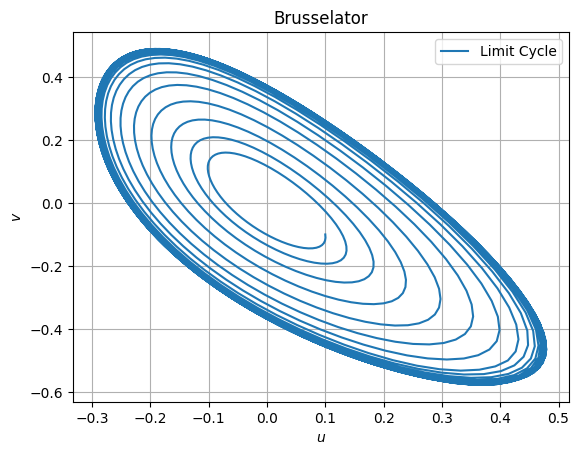

In [ ]:
# Define the Brusselator equations
def brusselator(t, initial, A, B):
    phi, psi = initial
    dphidt = A + (phi+A)**2 * (psi+B/A) - (B + 1) * (phi+A)
    dpsidt = B * (phi+A) - (phi+A)**2 * (psi+B/A)
    return [dphidt, dpsidt]

# Parameters A^2+1=B for Hopf bifurcation
A = 1
B = 2.1

# Initial conditions
initial = [0.1,-0.1]
N = 2000
# Time span for the simulation
t_span = (0, 200)
t_eval = np.linspace(*t_span, N)

# Solve the ODE
solution = solve_ivp(brusselator, t_span, initial, args=(A, B), t_eval=t_eval)

# Extract the solution
phi, psi = solution.y

# Plot the trajectory
#plt.figure(figsize=(10, 6))
plt.plot(phi, psi, label='Limit Cycle')
plt.title('Brusselator')
plt.xlabel(r'$u$')
plt.ylabel(r'$v$')
plt.grid()
plt.legend()
plt.show()

In [ ]:
jaxopt.LBFGS()

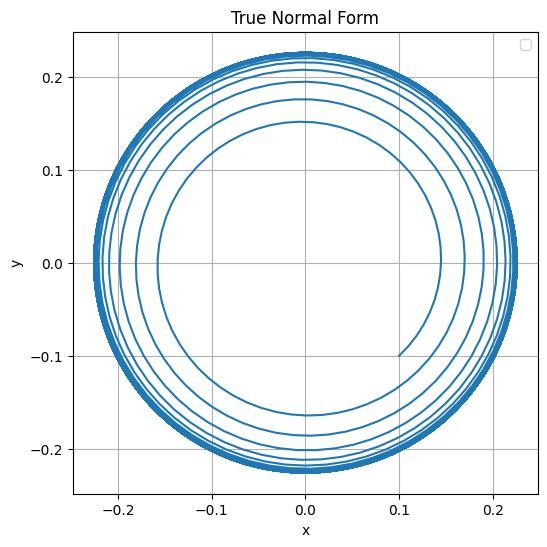

In [ ]:
# Define the normal forms equations
def normal(t, initial, mu):
    x, y = initial
    dxdt = (mu-x**2-y**2)*x-y
    dydt = (mu-x**2-y**2)*y+x
    return [dxdt, dydt]

# Parameters (from Kuznetsov)
mu = (B-A**2-1)/jnp.sqrt(4*A**2-(B-A**2-1)**2)
# Initial conditions
initial = [0.1,-0.1]

# Time span for the simulation
t_span = (0, 200)
t_eval = np.linspace(*t_span, N)

# Solve the ODE
normal_form = solve_ivp(normal, t_span, initial, args=(mu,), t_eval=t_eval)

# Extract the solution
x, y = normal_form.y

# Plot the limit cycle
plt.figure(figsize=(6, 6))
plt.plot(x, y)
plt.title('True Normal Form')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()

In [ ]:
def kernel_polynomial(s1,t1,s2,t2,c=0):
  K = (0+s1*t1+s2*t2)**4
  return K

def kernel_linear(s1,t1,s2,t2,c=1):
  K = (s1*t1+s2*t2)+c
  return K

def kernel_anisotropic(s1,t1,s2,t2,sigma1,sigma2):
  r = ((s1-s2)/sigma1)**2+((t1-t2)/sigma2)**2
  return jnp.exp(-r)

def kernel_gaussian(s,t,sigma):
    K = jnp.exp(-(s-t)**2/(2*sigma**2))
    return K

def kernel_gaussian_dt(s,t,sigma):
    K = -(s-t)*kernel_gaussian(s,t,sigma)/sigma**2
    return K

def kernel_matern(s,t,sigma):
  K = (1+jnp.sqrt(5)*jnp.abs(s-t)/sigma+5/3*jnp.abs(s-t)**2/sigma**2)*jnp.exp(-jnp.sqrt(5)*jnp.abs(s-t)/sigma)
  return K

def kernel_matern_dt(s,t,sigma):
  K = -5*(s-t)*jnp.exp(-jnp.sqrt(5)*jnp.abs(s-t)/sigma)*(sigma+jnp.sqrt(5)*jnp.abs(s-t))/(3*sigma**3)
  return K

def kernel_polynomial_dt(s1,t1,s2,t2):
  K = 4*t1*(s1*t1+s2*t2)**3
  return K

def kernel_polynomial_dtt(s1,t1,s2,t2):
  K = 12*t1**2*(s1*t1+s2*t2)**2
  return K

In [ ]:
def K_Anisotropic(X,Y,sigma1=1,sigma2=1,reg=True,nugget=10**-3):
  size=len(X[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size,1)))
  X1=jnp.transpose(jnp.tile(X[:,1],(size,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))
  Y1=jnp.transpose(jnp.tile(Y[:,1],(size,1)))

  val = vmap(lambda s1, t1, s2, t2: kernel_anisotropic(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),X1.flatten(),np.transpose(Y0).flatten(),np.transpose(Y1).flatten())

  K_matrix=np.reshape(val,(size,size))
  if reg==True:
    K_matrix+=+nugget*jnp.eye(size)
  return K_matrix

In [ ]:
def K_Polynomial(X,Y,reg=True,nugget=10**-1):
  size=len(X[:,0])
  size2=len(Y[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size,1)))
  X1=jnp.transpose(jnp.tile(X[:,1],(size,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))
  Y1=jnp.transpose(jnp.tile(Y[:,1],(size,1)))

  val = vmap(lambda s1, t1, s2, t2: kernel_polynomial(s1, t1,s2,t2))(X0.flatten(),X1.flatten(),jnp.transpose(Y0).flatten(),jnp.transpose(Y1).flatten())

  K_matrix=jnp.reshape(val,(size,size))
  if reg==True:
    K_matrix+=+nugget*jnp.eye(size)
  return K_matrix

In [ ]:
def K_Linear(X,Y,reg=True,nugget=10**-1):
  size=len(X[:,0])
  size2=len(Y[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size,1)))
  X1=jnp.transpose(jnp.tile(X[:,1],(size,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))
  Y1=jnp.transpose(jnp.tile(Y[:,1],(size,1)))

  val = vmap(lambda s1, t1, s2, t2: kernel_linear(s1, t1,s2,t2))(X0.flatten(),X1.flatten(),jnp.transpose(Y0).flatten(),jnp.transpose(Y1).flatten())

  K_matrix=jnp.reshape(val,(size,size))
  if reg==True:
    K_matrix+=+nugget*jnp.eye(size)
  return K_matrix

In [ ]:
def K_Gaussian(X,Y,sigma,reg=True,nugget=1*10**-5):
#Kernel matrix as function of one vector
  size=len(X[:,0])
  size2=len(Y[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size2,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))

  val = vmap(lambda s, t: kernel_gaussian(s,t,sigma))(X0.flatten(),jnp.transpose(Y0).flatten())

  K_matrix=jnp.reshape(val,(size,size2))
  if reg==True and size==size2:
    K_matrix+=+nugget*jnp.eye(size)
  return K_matrix

In [ ]:
#Kernel matrix as function of one vector
def K_Gaussian_dt(X,Y,sigma,reg=False,nugget=10**-10):
  size=len(X[:,0])
  size2=len(Y[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size2,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))

  val = vmap(lambda s, t: kernel_gaussian_dt(s,t,sigma))(X0.flatten(),jnp.transpose(Y0).flatten())

  K_matrix=jnp.reshape(val,(size,size2))
  if reg==True and size==size2:
    K_matrix+=+nugget*jnp.eye(size)
  return K_matrix

In [ ]:
def K_Matern(X,Y,sigma,reg=True,nugget=1*10**-10):
#Kernel matrix as function of one vector
  size=len(X[:,0])
  size2=len(Y[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size2,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))

  val = vmap(lambda s, t: kernel_matern(s,t,sigma))(X0.flatten(),jnp.transpose(Y0).flatten())

  K_matrix=jnp.reshape(val,(size,size2))
  if reg==True and size==size2:
    K_matrix+=+nugget*jnp.eye(size)
  return K_matrix

In [ ]:
def K_Matern_dt(X,Y,sigma,reg=False,nugget=1*10**-10):
#Kernel matrix as function of one vector
  size=len(X[:,0])
  size2=len(Y[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size2,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))

  val = vmap(lambda s, t: kernel_matern_dt(s,t,sigma))(X0.flatten(),jnp.transpose(Y0).flatten())

  K_matrix=jnp.reshape(val,(size,size2))
  if reg==True and size==size2:
    K_matrix+=+nugget*jnp.eye(size)
  return K_matrix

In [ ]:
N = len(t_eval)
#Kernel matrix (Matern) for differentiating r  wrt t
K = K_Matern(t_eval.reshape((N,1)),t_eval.reshape((N,1)), 0.8)
K_t = K_Matern_dt(t_eval.reshape((N,1)),t_eval.reshape((N,1)), 0.8)

In [ ]:
Z0 = jnp.zeros((N,3))
#Initial guess for r is t/40
Z0 = Z0.at[:,0].set(t_eval/40)
#Kernel matrix (quartic polynomial) for r
K_r = K_Polynomial(solution.y.T,solution.y.T,nugget = 1*10**-3)


In [ ]:
def loss_function_r(Z,Kernel_Matrix):
  lambda2 = 100000
  lambda3 = 1000000
  #RKHS Norm

  L = Z[:,0].dot(jnp.linalg.inv(Kernel_Matrix)@Z[:,0])


  #print(L)
  #Uniqueness constraint
  L3 =  lambda3*(Z[0,0]-jnp.sqrt(2)/10)**2

  #print(L3)


  #Normal form equation for r
  L2 = lambda2*jnp.linalg.norm(jnp.gradient(Z[:,0])*9.975-((mu-Z[:,0]**2)*Z[:,0]))**2

  #print(L2)


  return L+L2+L3

In [ ]:
def gradient_descent_r(Z0,niterations,init_learning_rate=0.001):
  Z=Z0
  learning_rate=init_learning_rate
  for n in tqdm.tqdm(range(niterations)):
    grad_Z = grad(loss_function_r)(Z,K_r)
    Z-=learning_rate/jnp.sqrt(jnp.sum(grad_Z*grad_Z,axis=None))*grad_Z
    print(loss_function_r(Z,K_r))
  return Z

In [ ]:
v = gradient_descent_r(Z0,4000,init_learning_rate=0.1)

  0%|          | 2/4000 [00:01<41:35,  1.60it/s]  

442282770000.0
439778340000.0


  0%|          | 3/4000 [00:01<28:38,  2.33it/s]

437287600000.0


  0%|          | 4/4000 [00:01<22:39,  2.94it/s]

434810220000.0


  0%|          | 6/4000 [00:02<17:19,  3.84it/s]

432346500000.0
429896040000.0


  0%|          | 8/4000 [00:02<15:03,  4.42it/s]

427458900000.0
425035040000.0


  0%|          | 9/4000 [00:02<14:48,  4.49it/s]

422624430000.0


  0%|          | 11/4000 [00:03<14:09,  4.70it/s]

420226730000.0
417842230000.0


  0%|          | 12/4000 [00:03<13:48,  4.82it/s]

415470620000.0
413111840000.0

  0%|          | 14/4000 [00:03<13:29,  4.93it/s]


410766000000.0


  0%|          | 15/4000 [00:04<13:33,  4.90it/s]

408432840000.0


  0%|          | 16/4000 [00:04<13:40,  4.86it/s]

406112370000.0


  0%|          | 17/4000 [00:04<13:54,  4.77it/s]

403804500000.0


  0%|          | 18/4000 [00:04<15:20,  4.32it/s]

401509200000.0


  0%|          | 19/4000 [00:05<16:53,  3.93it/s]

399226300000.0


  0%|          | 20/4000 [00:05<21:01,  3.15it/s]

396955800000.0


  1%|          | 21/4000 [00:05<19:52,  3.34it/s]

394697640000.0


  1%|          | 22/4000 [00:06<18:29,  3.58it/s]

392451820000.0


  1%|          | 23/4000 [00:06<24:30,  2.70it/s]

390218150000.0


  1%|          | 24/4000 [00:06<21:29,  3.08it/s]

387996600000.0


  1%|          | 25/4000 [00:07<19:32,  3.39it/s]

385787100000.0


  1%|          | 26/4000 [00:07<18:30,  3.58it/s]

383589650000.0


  1%|          | 27/4000 [00:07<17:04,  3.88it/s]

381404050000.0


  1%|          | 28/4000 [00:07<16:00,  4.13it/s]

379230400000.0


  1%|          | 29/4000 [00:07<15:16,  4.33it/s]

377068450000.0


  1%|          | 30/4000 [00:08<14:58,  4.42it/s]

374918300000.0
372779840000.0

  1%|          | 32/4000 [00:08<14:02,  4.71it/s]


370653000000.0


  1%|          | 33/4000 [00:08<13:57,  4.74it/s]

368537700000.0


  1%|          | 34/4000 [00:08<13:49,  4.78it/s]

366433860000.0


  1%|          | 35/4000 [00:09<13:47,  4.79it/s]

364341460000.0


  1%|          | 37/4000 [00:09<13:37,  4.85it/s]

362260400000.0
360190670000.0


  1%|          | 38/4000 [00:09<13:42,  4.82it/s]

358132150000.0


  1%|          | 39/4000 [00:09<13:39,  4.84it/s]

356084780000.0


  1%|          | 40/4000 [00:10<13:43,  4.81it/s]

354048570000.0


  1%|          | 42/4000 [00:10<13:22,  4.93it/s]

352023400000.0
350009300000.0


  1%|          | 43/4000 [00:10<13:29,  4.89it/s]

348006000000.0


  1%|          | 45/4000 [00:11<13:26,  4.90it/s]

346013630000.0
344032120000.0


  1%|          | 46/4000 [00:11<13:32,  4.87it/s]

342061320000.0


  1%|          | 47/4000 [00:11<13:36,  4.84it/s]

340101230000.0


  1%|          | 48/4000 [00:11<13:41,  4.81it/s]

338151830000.0


  1%|          | 49/4000 [00:12<13:42,  4.81it/s]

336212950000.0


  1%|▏         | 51/4000 [00:12<13:18,  4.94it/s]

334284620000.0
332366770000.0


  1%|▏         | 52/4000 [00:12<13:17,  4.95it/s]

330459350000.0


  1%|▏         | 53/4000 [00:12<13:32,  4.86it/s]

328562250000.0


  1%|▏         | 54/4000 [00:13<13:35,  4.84it/s]

326675500000.0


  1%|▏         | 56/4000 [00:13<13:23,  4.91it/s]

324798970000.0
322932640000.0


  1%|▏         | 57/4000 [00:13<13:17,  4.95it/s]

321076500000.0


  1%|▏         | 59/4000 [00:14<13:13,  4.97it/s]

319230300000.0
317394220000.0


  2%|▏         | 60/4000 [00:14<17:03,  3.85it/s]

315568100000.0


  2%|▏         | 61/4000 [00:14<19:42,  3.33it/s]

313751960000.0


  2%|▏         | 62/4000 [00:15<31:47,  2.06it/s]

311945600000.0


  2%|▏         | 64/4000 [00:16<24:15,  2.70it/s]

310149050000.0
308362280000.0


  2%|▏         | 66/4000 [00:16<18:32,  3.54it/s]

306585270000.0
304817860000.0


  2%|▏         | 67/4000 [00:16<16:59,  3.86it/s]

303060120000.0


  2%|▏         | 68/4000 [00:17<16:05,  4.07it/s]

301311820000.0


  2%|▏         | 69/4000 [00:17<15:30,  4.22it/s]

299573150000.0


  2%|▏         | 70/4000 [00:17<16:21,  4.01it/s]

297843900000.0


  2%|▏         | 71/4000 [00:18<24:21,  2.69it/s]

296124020000.0


  2%|▏         | 72/4000 [00:18<21:48,  3.00it/s]

294413470000.0


  2%|▏         | 73/4000 [00:18<20:48,  3.15it/s]

292712300000.0


  2%|▏         | 74/4000 [00:19<19:45,  3.31it/s]

291020300000.0


  2%|▏         | 75/4000 [00:19<25:04,  2.61it/s]

289337500000.0


  2%|▏         | 76/4000 [00:19<21:57,  2.98it/s]

287663850000.0


  2%|▏         | 77/4000 [00:20<20:08,  3.24it/s]

285999370000.0


  2%|▏         | 79/4000 [00:20<16:38,  3.93it/s]

284343900000.0
282697400000.0


  2%|▏         | 80/4000 [00:20<15:34,  4.20it/s]

281059900000.0


  2%|▏         | 81/4000 [00:20<15:03,  4.34it/s]

279431350000.0


  2%|▏         | 83/4000 [00:21<14:12,  4.59it/s]

277811600000.0
276200620000.0


  2%|▏         | 85/4000 [00:21<13:34,  4.81it/s]

274598510000.0
273005040000.0


  2%|▏         | 86/4000 [00:21<13:32,  4.82it/s]

271420310000.0


  2%|▏         | 88/4000 [00:22<13:24,  4.86it/s]

269844170000.0
268276600000.0


  2%|▏         | 89/4000 [00:22<13:09,  4.95it/s]

266717560000.0
265167060000.0

  2%|▏         | 90/4000 [00:22<13:10,  4.95it/s]

  2%|▏         | 91/4000 [00:22<13:30,  4.82it/s]

263624970000.0


  2%|▏         | 93/4000 [00:23<13:30,  4.82it/s]

262091260000.0
260565940000.0


  2%|▏         | 95/4000 [00:23<13:05,  4.97it/s]

259048950000.0
257540200000.0


  2%|▏         | 96/4000 [00:24<13:24,  4.85it/s]

256039650000.0


  2%|▏         | 98/4000 [00:24<13:17,  4.90it/s]

254547360000.0
253063090000.0


  2%|▎         | 100/4000 [00:24<12:58,  5.01it/s]

251586990000.0
250118930000.0


  3%|▎         | 101/4000 [00:25<13:05,  4.97it/s]

248658820000.0
247206700000.0


  3%|▎         | 102/4000 [00:25<13:05,  4.96it/s]

245762590000.0


  3%|▎         | 105/4000 [00:25<12:53,  5.04it/s]

244326250000.0
242897800000.0


  3%|▎         | 106/4000 [00:26<13:00,  4.99it/s]

241477100000.0
240064200000.0


  3%|▎         | 109/4000 [00:26<12:53,  5.03it/s]

238659000000.0
237261460000.0


  3%|▎         | 111/4000 [00:27<12:48,  5.06it/s]

235871580000.0
234489230000.0


  3%|▎         | 112/4000 [00:27<12:57,  5.00it/s]

233114520000.0


  3%|▎         | 114/4000 [00:27<12:50,  5.04it/s]

231747240000.0
230387420000.0


  3%|▎         | 115/4000 [00:27<12:53,  5.02it/s]

229035130000.0


  3%|▎         | 117/4000 [00:28<12:53,  5.02it/s]

227690180000.0
226352610000.0


  3%|▎         | 118/4000 [00:28<13:21,  4.85it/s]

225022250000.0
223699270000.0

  3%|▎         | 120/4000 [00:28<13:06,  4.94it/s]


222383490000.0


  3%|▎         | 121/4000 [00:29<13:08,  4.92it/s]

221074930000.0


  3%|▎         | 123/4000 [00:29<12:56,  4.99it/s]

219773500000.0
218479180000.0


  3%|▎         | 125/4000 [00:29<12:38,  5.11it/s]

217191960000.0
215911810000.0


  3%|▎         | 126/4000 [00:30<12:40,  5.09it/s]

214638670000.0


  3%|▎         | 127/4000 [00:30<12:52,  5.01it/s]

213372520000.0


  3%|▎         | 128/4000 [00:30<13:25,  4.81it/s]

212113240000.0


  3%|▎         | 129/4000 [00:30<13:53,  4.64it/s]

210860900000.0


  3%|▎         | 130/4000 [00:30<15:44,  4.10it/s]

209615440000.0


  3%|▎         | 131/4000 [00:31<20:27,  3.15it/s]

208376790000.0


  3%|▎         | 132/4000 [00:31<19:10,  3.36it/s]

207144910000.0


  3%|▎         | 133/4000 [00:32<18:29,  3.49it/s]

205919780000.0


  3%|▎         | 134/4000 [00:32<23:36,  2.73it/s]

204701400000.0


  3%|▎         | 135/4000 [00:32<20:44,  3.11it/s]

203489690000.0


  3%|▎         | 136/4000 [00:32<18:49,  3.42it/s]

202284650000.0


  3%|▎         | 138/4000 [00:33<16:22,  3.93it/s]

201086200000.0
199894340000.0


  4%|▎         | 140/4000 [00:33<14:37,  4.40it/s]

198708970000.0
197530170000.0


  4%|▎         | 142/4000 [00:34<13:43,  4.69it/s]

196357850000.0
195191930000.0


  4%|▎         | 143/4000 [00:34<13:25,  4.79it/s]

194032450000.0


  4%|▎         | 145/4000 [00:34<13:09,  4.88it/s]

192879330000.0
191732530000.0


  4%|▎         | 147/4000 [00:35<12:59,  4.94it/s]

190592090000.0
189457840000.0


  4%|▎         | 148/4000 [00:35<12:50,  5.00it/s]

188329900000.0
187208120000.0

  4%|▍         | 150/4000 [00:35<12:44,  5.04it/s]


186092570000.0


  4%|▍         | 152/4000 [00:36<12:50,  5.00it/s]

184983100000.0
183879760000.0


  4%|▍         | 153/4000 [00:36<12:45,  5.02it/s]

182782530000.0
181691290000.0

  4%|▍         | 154/4000 [00:36<12:47,  5.01it/s]

  4%|▍         | 155/4000 [00:36<12:52,  4.98it/s]

180606120000.0
179526860000.0

  4%|▍         | 157/4000 [00:37<12:41,  5.04it/s]


178453640000.0


  4%|▍         | 159/4000 [00:37<12:42,  5.04it/s]

177386290000.0
176324790000.0


  4%|▍         | 160/4000 [00:37<12:52,  4.97it/s]

175269220000.0


  4%|▍         | 162/4000 [00:38<12:56,  4.94it/s]

174219430000.0
173175440000.0


  4%|▍         | 163/4000 [00:38<12:53,  4.96it/s]

172137200000.0


  4%|▍         | 164/4000 [00:38<12:59,  4.92it/s]

171104710000.0


  4%|▍         | 165/4000 [00:38<13:49,  4.62it/s]

170077960000.0


  4%|▍         | 167/4000 [00:39<13:21,  4.78it/s]

169056850000.0
168041370000.0


  4%|▍         | 168/4000 [00:39<13:16,  4.81it/s]

167031520000.0


  4%|▍         | 169/4000 [00:39<13:13,  4.83it/s]

166027250000.0


  4%|▍         | 171/4000 [00:40<13:05,  4.87it/s]

165028560000.0
164035330000.0


  4%|▍         | 173/4000 [00:40<12:50,  4.97it/s]

163047690000.0
162065470000.0


  4%|▍         | 174/4000 [00:40<12:45,  5.00it/s]

161088650000.0


  4%|▍         | 176/4000 [00:41<12:57,  4.92it/s]

160117310000.0
159151310000.0


  4%|▍         | 177/4000 [00:41<12:45,  5.00it/s]

158190670000.0
157235360000.0

  4%|▍         | 178/4000 [00:41<12:48,  4.97it/s]

  4%|▍         | 179/4000 [00:41<12:59,  4.90it/s]

156285340000.0


  4%|▍         | 180/4000 [00:41<13:28,  4.73it/s]

155340640000.0


  5%|▍         | 182/4000 [00:42<13:03,  4.87it/s]

154401110000.0
153466830000.0


  5%|▍         | 184/4000 [00:42<12:48,  4.96it/s]

152537740000.0
151613820000.0


  5%|▍         | 185/4000 [00:42<13:01,  4.88it/s]

150695000000.0


  5%|▍         | 186/4000 [00:43<13:10,  4.83it/s]

149781330000.0


  5%|▍         | 187/4000 [00:43<13:34,  4.68it/s]

148872690000.0


  5%|▍         | 188/4000 [00:43<15:36,  4.07it/s]

147969130000.0


  5%|▍         | 189/4000 [00:44<21:18,  2.98it/s]

147070580000.0


  5%|▍         | 190/4000 [00:44<19:48,  3.20it/s]

146177060000.0


  5%|▍         | 191/4000 [00:44<18:24,  3.45it/s]

145288510000.0


  5%|▍         | 192/4000 [00:45<18:05,  3.51it/s]

144404860000.0


  5%|▍         | 193/4000 [00:45<18:04,  3.51it/s]

143526180000.0


  5%|▍         | 194/4000 [00:45<16:50,  3.77it/s]

142652380000.0


  5%|▍         | 195/4000 [00:45<16:32,  3.84it/s]

141783430000.0


  5%|▍         | 197/4000 [00:46<18:25,  3.44it/s]

140919360000.0
140060080000.0


  5%|▍         | 198/4000 [00:46<17:20,  3.66it/s]

139205620000.0


  5%|▍         | 199/4000 [00:47<19:06,  3.31it/s]

138355930000.0
137510940000.0


  5%|▌         | 202/4000 [00:47<14:47,  4.28it/s]

136670690000.0
135835130000.0


  5%|▌         | 203/4000 [00:47<14:17,  4.43it/s]

135004230000.0


  5%|▌         | 205/4000 [00:48<13:31,  4.68it/s]

134178010000.0
133356410000.0


  5%|▌         | 207/4000 [00:48<13:01,  4.85it/s]

132539380000.0
131726930000.0


  5%|▌         | 208/4000 [00:48<12:58,  4.87it/s]

130919000000.0


  5%|▌         | 210/4000 [00:49<12:48,  4.93it/s]

130115640000.0
129316760000.0


  5%|▌         | 211/4000 [00:49<12:55,  4.88it/s]

128522340000.0


  5%|▌         | 212/4000 [00:49<13:13,  4.78it/s]

127732370000.0


  5%|▌         | 213/4000 [00:49<13:17,  4.75it/s]

126946860000.0


  5%|▌         | 215/4000 [00:50<13:04,  4.82it/s]

126165730000.0
125389000000.0


  5%|▌         | 217/4000 [00:50<12:41,  4.97it/s]

124616606000.0
123848550000.0


  5%|▌         | 218/4000 [00:50<12:49,  4.92it/s]

123084830000.0


  6%|▌         | 220/4000 [00:51<12:44,  4.95it/s]

122325400000.0
121570250000.0


  6%|▌         | 222/4000 [00:51<12:35,  5.00it/s]

120819330000.0
120072610000.0


  6%|▌         | 223/4000 [00:51<12:44,  4.94it/s]

119330130000.0


  6%|▌         | 224/4000 [00:52<13:12,  4.76it/s]

118591810000.0


  6%|▌         | 226/4000 [00:52<12:52,  4.89it/s]

117857640000.0
117127620000.0


  6%|▌         | 228/4000 [00:53<12:41,  4.95it/s]

116401684000.0
115679870000.0


  6%|▌         | 230/4000 [00:53<12:38,  4.97it/s]

114962110000.0
114248420000.0


  6%|▌         | 232/4000 [00:53<12:28,  5.03it/s]

113538770000.0
112833110000.0


  6%|▌         | 233/4000 [00:54<12:33,  5.00it/s]

112131410000.0


  6%|▌         | 235/4000 [00:54<12:42,  4.94it/s]

111433695000.0
110739920000.0


  6%|▌         | 237/4000 [00:54<12:27,  5.04it/s]

110050100000.0
109364140000.0


  6%|▌         | 239/4000 [00:55<12:28,  5.02it/s]

108682070000.0
108003890000.0


  6%|▌         | 241/4000 [00:55<12:30,  5.01it/s]

107329540000.0
106658955000.0


  6%|▌         | 242/4000 [00:55<12:32,  4.99it/s]

105992240000.0


  6%|▌         | 243/4000 [00:56<13:13,  4.74it/s]

105329295000.0


  6%|▌         | 244/4000 [00:56<14:03,  4.45it/s]

104670085000.0


  6%|▌         | 245/4000 [00:56<16:32,  3.78it/s]

104014635000.0


  6%|▌         | 246/4000 [00:57<20:57,  2.98it/s]

103362890000.0


  6%|▌         | 247/4000 [00:57<19:42,  3.17it/s]

102714850000.0


  6%|▌         | 248/4000 [00:57<18:30,  3.38it/s]

102070530000.0


  6%|▌         | 249/4000 [00:58<24:20,  2.57it/s]

101429820000.0


  6%|▋         | 250/4000 [00:58<21:08,  2.96it/s]

100792770000.0


  6%|▋         | 251/4000 [00:58<19:21,  3.23it/s]

100159350000.0


  6%|▋         | 252/4000 [00:58<17:59,  3.47it/s]

99529550000.0


  6%|▋         | 253/4000 [00:59<16:23,  3.81it/s]

98903300000.0
98280650000.0


  6%|▋         | 255/4000 [00:59<14:19,  4.36it/s]

97661534000.0


  6%|▋         | 257/4000 [00:59<13:22,  4.67it/s]

97045955000.0
96433880000.0


  6%|▋         | 259/4000 [01:00<13:04,  4.77it/s]

95825300000.0
95220200000.0


  7%|▋         | 261/4000 [01:00<12:42,  4.90it/s]

94618550000.0
94020330000.0


  7%|▋         | 263/4000 [01:01<12:31,  4.97it/s]

93425530000.0
92834150000.0


  7%|▋         | 264/4000 [01:01<12:51,  4.84it/s]

92246150000.0


  7%|▋         | 265/4000 [01:01<13:01,  4.78it/s]

91661510000.0
91080190000.0

  7%|▋         | 266/4000 [01:01<12:53,  4.83it/s]

  7%|▋         | 267/4000 [01:02<12:51,  4.84it/s]

90502230000.0
89927570000.0

  7%|▋         | 269/4000 [01:02<12:31,  4.97it/s]


89356210000.0


  7%|▋         | 271/4000 [01:02<12:34,  4.94it/s]

88788140000.0
88223320000.0


  7%|▋         | 273/4000 [01:03<12:21,  5.02it/s]

87661730000.0
87103400000.0


  7%|▋         | 274/4000 [01:03<12:20,  5.03it/s]

86548240000.0
85996280000.0


  7%|▋         | 276/4000 [01:03<12:28,  4.98it/s]

85447524000.0


  7%|▋         | 278/4000 [01:04<12:33,  4.94it/s]

84901900000.0
84359420000.0


  7%|▋         | 280/4000 [01:04<12:22,  5.01it/s]

83820080000.0
83283830000.0


  7%|▋         | 282/4000 [01:05<12:32,  4.94it/s]

82750670000.0
82220590000.0


  7%|▋         | 284/4000 [01:05<12:20,  5.02it/s]

81693570000.0
81169600000.0


  7%|▋         | 285/4000 [01:05<12:24,  4.99it/s]

80648650000.0


  7%|▋         | 286/4000 [01:05<12:30,  4.95it/s]

80130710000.0
79615770000.0

  7%|▋         | 287/4000 [01:06<12:28,  4.96it/s]

  7%|▋         | 289/4000 [01:06<12:26,  4.97it/s]

79103810000.0
78594800000.0


  7%|▋         | 290/4000 [01:06<12:35,  4.91it/s]

78088750000.0


  7%|▋         | 291/4000 [01:06<12:34,  4.91it/s]

77585640000.0


  7%|▋         | 292/4000 [01:07<12:39,  4.89it/s]

77085420000.0


  7%|▋         | 294/4000 [01:07<12:49,  4.82it/s]

76588120000.0
76093686000.0


  7%|▋         | 295/4000 [01:07<12:50,  4.81it/s]

75602140000.0


  7%|▋         | 296/4000 [01:07<12:48,  4.82it/s]

75113450000.0


  7%|▋         | 297/4000 [01:08<12:49,  4.81it/s]

74627600000.0


  7%|▋         | 299/4000 [01:08<12:31,  4.93it/s]

74144550000.0
73664315000.0


  8%|▊         | 300/4000 [01:08<12:29,  4.93it/s]

73186900000.0


  8%|▊         | 301/4000 [01:08<12:46,  4.83it/s]

72712250000.0


  8%|▊         | 302/4000 [01:09<13:32,  4.55it/s]

72240370000.0


  8%|▊         | 303/4000 [01:09<14:25,  4.27it/s]

71771234000.0


  8%|▊         | 304/4000 [01:09<18:48,  3.27it/s]

71304850000.0


  8%|▊         | 305/4000 [01:10<17:22,  3.54it/s]

70841156000.0


  8%|▊         | 306/4000 [01:10<16:53,  3.65it/s]

70380180000.0


  8%|▊         | 307/4000 [01:10<16:06,  3.82it/s]

69921910000.0


  8%|▊         | 308/4000 [01:11<22:52,  2.69it/s]

69466290000.0


  8%|▊         | 310/4000 [01:11<17:57,  3.42it/s]

69013360000.0
68563080000.0


  8%|▊         | 312/4000 [01:12<15:13,  4.04it/s]

68115407000.0
67670385000.0


  8%|▊         | 314/4000 [01:12<13:37,  4.51it/s]

67227955000.0
66788120000.0


  8%|▊         | 315/4000 [01:12<13:19,  4.61it/s]

66350866000.0


  8%|▊         | 316/4000 [01:12<13:12,  4.65it/s]

65916183000.0


  8%|▊         | 318/4000 [01:13<12:43,  4.82it/s]

65484034000.0
65054437000.0


  8%|▊         | 320/4000 [01:13<12:26,  4.93it/s]

64627370000.0
64202800000.0


  8%|▊         | 322/4000 [01:14<12:35,  4.87it/s]

63780725000.0
63361147000.0


  8%|▊         | 324/4000 [01:14<12:44,  4.81it/s]

62944040000.0
62529372000.0


  8%|▊         | 325/4000 [01:14<12:30,  4.89it/s]

62117175000.0


  8%|▊         | 326/4000 [01:15<12:39,  4.84it/s]

61707395000.0


  8%|▊         | 328/4000 [01:15<12:37,  4.85it/s]

61300027000.0
60895076000.0


  8%|▊         | 329/4000 [01:15<12:30,  4.89it/s]

60492513000.0
60092340000.0

  8%|▊         | 330/4000 [01:15<12:30,  4.89it/s]

  8%|▊         | 331/4000 [01:16<12:39,  4.83it/s]

59694514000.0
59299054000.0


  8%|▊         | 334/4000 [01:16<12:15,  4.98it/s]

58905944000.0
58515165000.0


  8%|▊         | 335/4000 [01:16<12:11,  5.01it/s]

58126684000.0


  8%|▊         | 336/4000 [01:17<12:43,  4.80it/s]

57740510000.0
57356624000.0

  8%|▊         | 338/4000 [01:17<12:19,  4.95it/s]


56975045000.0


  8%|▊         | 339/4000 [01:17<12:15,  4.98it/s]

56595710000.0
56218636000.0


  9%|▊         | 341/4000 [01:18<12:39,  4.82it/s]

55843800000.0


  9%|▊         | 343/4000 [01:18<12:23,  4.92it/s]

55471200000.0
55100826000.0


  9%|▊         | 345/4000 [01:18<12:15,  4.97it/s]

54732650000.0
54366675000.0


  9%|▊         | 346/4000 [01:19<12:21,  4.93it/s]

54002872000.0


  9%|▊         | 348/4000 [01:19<12:06,  5.03it/s]

53641245000.0
53281776000.0


  9%|▊         | 349/4000 [01:19<12:06,  5.03it/s]

52924460000.0


  9%|▉         | 350/4000 [01:19<12:13,  4.97it/s]

52569290000.0


  9%|▉         | 351/4000 [01:20<12:30,  4.86it/s]

52216230000.0


  9%|▉         | 353/4000 [01:20<12:22,  4.91it/s]

51865285000.0
51516450000.0


  9%|▉         | 354/4000 [01:20<12:16,  4.95it/s]

51169698000.0


  9%|▉         | 355/4000 [01:20<12:15,  4.96it/s]

50825023000.0
50482426000.0


  9%|▉         | 357/4000 [01:21<12:34,  4.83it/s]

50141884000.0


  9%|▉         | 358/4000 [01:21<12:37,  4.81it/s]

49803387000.0


  9%|▉         | 359/4000 [01:21<12:43,  4.77it/s]

49466925000.0


  9%|▉         | 360/4000 [01:22<13:27,  4.51it/s]

49132487000.0


  9%|▉         | 361/4000 [01:22<20:30,  2.96it/s]

48800055000.0


  9%|▉         | 362/4000 [01:22<18:27,  3.28it/s]

48469630000.0


  9%|▉         | 363/4000 [01:23<17:33,  3.45it/s]

48141193000.0


  9%|▉         | 364/4000 [01:23<16:35,  3.65it/s]

47814740000.0


  9%|▉         | 365/4000 [01:23<23:22,  2.59it/s]

47490260000.0


  9%|▉         | 366/4000 [01:24<20:26,  2.96it/s]

47167738000.0


  9%|▉         | 367/4000 [01:24<18:58,  3.19it/s]

46847160000.0


  9%|▉         | 369/4000 [01:24<15:55,  3.80it/s]

46528524000.0
46211810000.0


  9%|▉         | 370/4000 [01:25<14:45,  4.10it/s]

45897015000.0


  9%|▉         | 372/4000 [01:25<13:21,  4.53it/s]

45584130000.0
45273133000.0


  9%|▉         | 374/4000 [01:25<12:38,  4.78it/s]

44964030000.0
44656800000.0


  9%|▉         | 375/4000 [01:26<12:26,  4.86it/s]

44351430000.0


  9%|▉         | 377/4000 [01:26<12:19,  4.90it/s]

44047920000.0
43746260000.0


  9%|▉         | 378/4000 [01:26<12:41,  4.76it/s]

43446428000.0


  9%|▉         | 379/4000 [01:26<12:44,  4.73it/s]

43148423000.0
42852225000.0

 10%|▉         | 380/4000 [01:27<12:34,  4.80it/s]

 10%|▉         | 382/4000 [01:27<12:25,  4.85it/s]

42557846000.0
42265256000.0


 10%|▉         | 383/4000 [01:27<12:29,  4.82it/s]

41974444000.0


 10%|▉         | 384/4000 [01:27<12:28,  4.83it/s]

41685414000.0


 10%|▉         | 386/4000 [01:28<12:16,  4.90it/s]

41398145000.0
41112637000.0


 10%|▉         | 388/4000 [01:28<12:07,  4.96it/s]

40828883000.0
40546857000.0


 10%|▉         | 389/4000 [01:28<12:02,  5.00it/s]

40266560000.0


 10%|▉         | 390/4000 [01:29<12:09,  4.95it/s]

39987974000.0
39711113000.0

 10%|▉         | 391/4000 [01:29<12:09,  4.95it/s]

 10%|▉         | 392/4000 [01:29<12:25,  4.84it/s]

39435940000.0


 10%|▉         | 393/4000 [01:29<12:21,  4.86it/s]

39162462000.0


 10%|▉         | 394/4000 [01:30<12:36,  4.77it/s]

38890664000.0


 10%|▉         | 396/4000 [01:30<12:16,  4.89it/s]

38620530000.0
38352065000.0


 10%|▉         | 398/4000 [01:30<12:18,  4.88it/s]

38085255000.0
37820090000.0


 10%|▉         | 399/4000 [01:31<12:17,  4.88it/s]

37556556000.0


 10%|█         | 400/4000 [01:31<12:28,  4.81it/s]

37294650000.0


 10%|█         | 401/4000 [01:31<12:24,  4.83it/s]

37034357000.0


 10%|█         | 402/4000 [01:31<12:27,  4.81it/s]

36775674000.0


 10%|█         | 403/4000 [01:31<12:27,  4.81it/s]

36518593000.0
36263105000.0


 10%|█         | 406/4000 [01:32<12:09,  4.93it/s]

36009193000.0
35756855000.0


 10%|█         | 407/4000 [01:32<12:22,  4.84it/s]

35506078000.0


 10%|█         | 408/4000 [01:32<12:31,  4.78it/s]

35256865000.0


 10%|█         | 409/4000 [01:33<12:27,  4.80it/s]

35009196000.0


 10%|█         | 411/4000 [01:33<12:26,  4.81it/s]

34763063000.0
34518460000.0


 10%|█         | 413/4000 [01:33<12:31,  4.77it/s]

34275380000.0
34033816000.0


 10%|█         | 414/4000 [01:34<12:28,  4.79it/s]

33793757000.0


 10%|█         | 415/4000 [01:34<12:23,  4.82it/s]

33555194000.0
33318115000.0


 10%|█         | 417/4000 [01:34<12:53,  4.63it/s]

33082518000.0


 10%|█         | 418/4000 [01:35<13:19,  4.48it/s]

32848398000.0


 10%|█         | 419/4000 [01:35<20:15,  2.95it/s]

32615731000.0


 10%|█         | 420/4000 [01:35<18:19,  3.26it/s]

32384530000.0


 11%|█         | 421/4000 [01:36<17:05,  3.49it/s]

32154767000.0


 11%|█         | 422/4000 [01:36<16:14,  3.67it/s]

31926456000.0


 11%|█         | 423/4000 [01:36<18:57,  3.14it/s]

31699565000.0


 11%|█         | 424/4000 [01:37<17:21,  3.43it/s]

31474104000.0


 11%|█         | 425/4000 [01:37<16:34,  3.59it/s]

31250057000.0


 11%|█         | 426/4000 [01:37<15:44,  3.78it/s]

31027415000.0


 11%|█         | 427/4000 [01:37<14:47,  4.03it/s]

30806180000.0
30586330000.0

 11%|█         | 429/4000 [01:38<13:17,  4.48it/s]


30367857000.0


 11%|█         | 431/4000 [01:38<12:33,  4.74it/s]

30150773000.0
29935053000.0


 11%|█         | 432/4000 [01:38<12:21,  4.81it/s]

29720703000.0


 11%|█         | 433/4000 [01:38<12:42,  4.68it/s]

29507699000.0
29296038000.0


 11%|█         | 436/4000 [01:39<12:02,  4.93it/s]

29085714000.0
28876726000.0


 11%|█         | 437/4000 [01:39<12:07,  4.90it/s]

28669070000.0


 11%|█         | 438/4000 [01:39<12:24,  4.79it/s]

28462720000.0


 11%|█         | 440/4000 [01:40<12:19,  4.81it/s]

28257671000.0
28053934000.0


 11%|█         | 442/4000 [01:40<12:02,  4.92it/s]

27851491000.0
27650333000.0


 11%|█         | 443/4000 [01:40<12:20,  4.81it/s]

27450450000.0
27251850000.0


 11%|█         | 446/4000 [01:41<11:55,  4.97it/s]

27054508000.0
26858428000.0


 11%|█         | 447/4000 [01:41<11:52,  4.99it/s]

26663590000.0


 11%|█         | 448/4000 [01:42<12:08,  4.88it/s]

26470005000.0
26277655000.0


 11%|█▏        | 451/4000 [01:42<11:56,  4.95it/s]

26086540000.0
25896638000.0


 11%|█▏        | 452/4000 [01:42<12:15,  4.82it/s]

25707958000.0


 11%|█▏        | 453/4000 [01:43<12:36,  4.69it/s]

25520486000.0
25334217000.0

 11%|█▏        | 455/4000 [01:43<12:09,  4.86it/s]


25149145000.0


 11%|█▏        | 457/4000 [01:43<12:01,  4.91it/s]

24965260000.0
24782560000.0


 11%|█▏        | 458/4000 [01:44<12:05,  4.88it/s]

24601030000.0


 12%|█▏        | 460/4000 [01:44<12:03,  4.90it/s]

24420674000.0
24241478000.0


 12%|█▏        | 461/4000 [01:44<11:52,  4.97it/s]

24063437000.0


 12%|█▏        | 462/4000 [01:44<11:53,  4.96it/s]

23886545000.0


 12%|█▏        | 463/4000 [01:45<11:58,  4.92it/s]

23710798000.0


 12%|█▏        | 465/4000 [01:45<12:06,  4.86it/s]

23536183000.0
23362707000.0


 12%|█▏        | 466/4000 [01:45<12:01,  4.90it/s]

23190346000.0


 12%|█▏        | 467/4000 [01:45<12:01,  4.90it/s]

23019098000.0


 12%|█▏        | 468/4000 [01:46<12:01,  4.89it/s]

22848967000.0


 12%|█▏        | 470/4000 [01:46<11:55,  4.93it/s]

22679940000.0
22512010000.0


 12%|█▏        | 472/4000 [01:46<11:52,  4.95it/s]

22345173000.0
22179416000.0


 12%|█▏        | 474/4000 [01:47<11:48,  4.98it/s]

22014745000.0
21851142000.0


 12%|█▏        | 475/4000 [01:47<11:59,  4.90it/s]

21688607000.0


 12%|█▏        | 476/4000 [01:47<12:18,  4.77it/s]

21527134000.0


 12%|█▏        | 477/4000 [01:48<13:17,  4.42it/s]

21366714000.0


 12%|█▏        | 478/4000 [01:48<18:44,  3.13it/s]

21207343000.0


 12%|█▏        | 479/4000 [01:48<17:06,  3.43it/s]

21049014000.0


 12%|█▏        | 480/4000 [01:49<16:16,  3.61it/s]

20891722000.0


 12%|█▏        | 481/4000 [01:49<15:21,  3.82it/s]

20735461000.0


 12%|█▏        | 482/4000 [01:49<22:49,  2.57it/s]

20580225000.0


 12%|█▏        | 483/4000 [01:50<19:47,  2.96it/s]

20426009000.0


 12%|█▏        | 484/4000 [01:50<18:28,  3.17it/s]

20272802000.0


 12%|█▏        | 486/4000 [01:50<15:02,  3.89it/s]

20120607000.0
19969410000.0


 12%|█▏        | 487/4000 [01:51<14:11,  4.13it/s]

19819209000.0


 12%|█▏        | 489/4000 [01:51<13:02,  4.49it/s]

19670004000.0
19521774000.0


 12%|█▏        | 491/4000 [01:51<12:16,  4.76it/s]

19374526000.0
19228250000.0


 12%|█▏        | 492/4000 [01:52<12:11,  4.79it/s]

19082942000.0


 12%|█▏        | 494/4000 [01:52<12:05,  4.83it/s]

18938597000.0
18795207000.0


 12%|█▏        | 496/4000 [01:52<11:57,  4.88it/s]

18652764000.0
18511272000.0


 12%|█▏        | 497/4000 [01:53<12:01,  4.86it/s]

18370720000.0


 12%|█▏        | 499/4000 [01:53<11:57,  4.88it/s]

18231091000.0
18092400000.0


 12%|█▎        | 500/4000 [01:53<11:50,  4.93it/s]

17954632000.0


 13%|█▎        | 501/4000 [01:53<11:54,  4.89it/s]

17817782000.0


 13%|█▎        | 502/4000 [01:54<11:54,  4.89it/s]

17681838000.0


 13%|█▎        | 504/4000 [01:54<11:54,  4.89it/s]

17546811000.0
17412678000.0


 13%|█▎        | 505/4000 [01:54<12:12,  4.77it/s]

17279445000.0


 13%|█▎        | 506/4000 [01:54<12:11,  4.78it/s]

17147102000.0


 13%|█▎        | 507/4000 [01:55<12:08,  4.80it/s]

17015647000.0


 13%|█▎        | 509/4000 [01:55<12:00,  4.84it/s]

16885076000.0
16755376000.0


 13%|█▎        | 510/4000 [01:55<12:04,  4.81it/s]

16626547000.0


 13%|█▎        | 512/4000 [01:56<11:55,  4.88it/s]

16498587000.0
16371484000.0


 13%|█▎        | 514/4000 [01:56<11:37,  5.00it/s]

16245241000.0
16119842000.0


 13%|█▎        | 515/4000 [01:56<11:44,  4.95it/s]

15995292000.0
15871583000.0


 13%|█▎        | 517/4000 [01:57<11:50,  4.90it/s]

15748711000.0


 13%|█▎        | 519/4000 [01:57<11:44,  4.94it/s]

15626667000.0
15505453000.0


 13%|█▎        | 520/4000 [01:57<11:40,  4.97it/s]

15385056000.0


 13%|█▎        | 522/4000 [01:58<11:51,  4.89it/s]

15265476000.0
15146707000.0


 13%|█▎        | 524/4000 [01:58<11:51,  4.88it/s]

15028745000.0
14911586000.0


 13%|█▎        | 526/4000 [01:59<11:53,  4.87it/s]

14795221000.0
14679650000.0


 13%|█▎        | 528/4000 [01:59<11:49,  4.89it/s]

14564869000.0
14450866000.0


 13%|█▎        | 530/4000 [01:59<11:36,  4.98it/s]

14337646000.0
14225199000.0


 13%|█▎        | 531/4000 [02:00<11:47,  4.90it/s]

14113519000.0


 13%|█▎        | 532/4000 [02:00<11:47,  4.90it/s]

14002604000.0


 13%|█▎        | 533/4000 [02:00<11:50,  4.88it/s]

13892449000.0


 13%|█▎        | 534/4000 [02:00<12:09,  4.75it/s]

13783053000.0


 13%|█▎        | 535/4000 [02:00<12:53,  4.48it/s]

13674405000.0


 13%|█▎        | 536/4000 [02:01<13:53,  4.16it/s]

13566503000.0


 13%|█▎        | 537/4000 [02:01<19:27,  2.97it/s]

13459343000.0


 13%|█▎        | 538/4000 [02:02<18:11,  3.17it/s]

13352923000.0


 13%|█▎        | 539/4000 [02:02<16:36,  3.47it/s]

13247234000.0


 14%|█▎        | 540/4000 [02:02<22:18,  2.59it/s]

13142275000.0


 14%|█▎        | 541/4000 [02:03<19:28,  2.96it/s]

13038042000.0


 14%|█▎        | 542/4000 [02:03<17:30,  3.29it/s]

12934527000.0


 14%|█▎        | 543/4000 [02:03<16:30,  3.49it/s]

12831730000.0


 14%|█▎        | 544/4000 [02:03<15:13,  3.78it/s]

12729642000.0


 14%|█▎        | 546/4000 [02:04<13:31,  4.25it/s]

12628264000.0
12527587000.0


 14%|█▎        | 548/4000 [02:04<12:25,  4.63it/s]

12427608000.0
12328326000.0


 14%|█▎        | 549/4000 [02:04<12:25,  4.63it/s]

12229733000.0


 14%|█▍        | 550/4000 [02:05<12:25,  4.63it/s]

12131826000.0


 14%|█▍        | 552/4000 [02:05<12:09,  4.72it/s]

12034603000.0
11938056000.0


 14%|█▍        | 553/4000 [02:05<12:03,  4.77it/s]

11842183000.0


 14%|█▍        | 554/4000 [02:05<11:58,  4.80it/s]

11746984000.0
11652447000.0

 14%|█▍        | 556/4000 [02:06<11:39,  4.92it/s]


11558574000.0


 14%|█▍        | 557/4000 [02:06<11:39,  4.92it/s]

11465356000.0


 14%|█▍        | 558/4000 [02:06<11:40,  4.92it/s]

11372793000.0


 14%|█▍        | 560/4000 [02:07<11:40,  4.91it/s]

11280882000.0
11189615000.0


 14%|█▍        | 562/4000 [02:07<11:30,  4.98it/s]

11098991000.0
11009006000.0


 14%|█▍        | 563/4000 [02:07<11:50,  4.84it/s]

10919652000.0


 14%|█▍        | 564/4000 [02:07<11:53,  4.81it/s]

10830930000.0


 14%|█▍        | 566/4000 [02:08<11:40,  4.90it/s]

10742835000.0
10655362000.0


 14%|█▍        | 567/4000 [02:08<11:32,  4.96it/s]

10568508000.0
10482269000.0

 14%|█▍        | 568/4000 [02:08<11:33,  4.95it/s]

 14%|█▍        | 569/4000 [02:08<11:49,  4.83it/s]

10396640000.0


 14%|█▍        | 570/4000 [02:09<11:44,  4.87it/s]

10311623000.0


 14%|█▍        | 572/4000 [02:09<11:29,  4.97it/s]

10227207000.0
10143392000.0


 14%|█▍        | 573/4000 [02:09<11:32,  4.95it/s]

10060173000.0


 14%|█▍        | 575/4000 [02:10<11:34,  4.93it/s]

9977547000.0
9895510000.0


 14%|█▍        | 577/4000 [02:10<11:25,  4.99it/s]

9814058000.0
9733191000.0


 14%|█▍        | 579/4000 [02:10<11:25,  4.99it/s]

9652900000.0
9573186000.0


 15%|█▍        | 581/4000 [02:11<11:22,  5.01it/s]

9494043000.0
9415463000.0


 15%|█▍        | 582/4000 [02:11<11:15,  5.06it/s]

9337453000.0


 15%|█▍        | 583/4000 [02:11<11:23,  5.00it/s]

9260000000.0


 15%|█▍        | 584/4000 [02:11<11:43,  4.86it/s]

9183108000.0
9106767000.0

 15%|█▍        | 586/4000 [02:12<11:34,  4.92it/s]


9030980000.0


 15%|█▍        | 588/4000 [02:12<11:22,  5.00it/s]

8955734000.0
8881035000.0


 15%|█▍        | 590/4000 [02:13<11:41,  4.86it/s]

8806878000.0
8733257000.0


 15%|█▍        | 591/4000 [02:13<11:36,  4.89it/s]

8660169000.0


 15%|█▍        | 592/4000 [02:13<11:42,  4.85it/s]

8587611000.0


 15%|█▍        | 593/4000 [02:13<12:17,  4.62it/s]

8515580000.0


 15%|█▍        | 594/4000 [02:14<14:02,  4.04it/s]

8444074000.0


 15%|█▍        | 595/4000 [02:14<18:32,  3.06it/s]

8373084000.0


 15%|█▍        | 596/4000 [02:14<16:52,  3.36it/s]

8302617000.0


 15%|█▍        | 597/4000 [02:15<16:02,  3.54it/s]

8232660500.0


 15%|█▍        | 598/4000 [02:15<16:22,  3.46it/s]

8163216400.0


 15%|█▍        | 599/4000 [02:16<22:09,  2.56it/s]

8094280000.0


 15%|█▌        | 600/4000 [02:16<19:17,  2.94it/s]

8025844700.0


 15%|█▌        | 602/4000 [02:16<15:43,  3.60it/s]

7957914000.0
7890481000.0


 15%|█▌        | 603/4000 [02:16<14:36,  3.87it/s]

7823542000.0


 15%|█▌        | 605/4000 [02:17<12:59,  4.36it/s]

7757095000.0
7691136000.0


 15%|█▌        | 607/4000 [02:17<11:59,  4.72it/s]

7625662500.0
7560672000.0


 15%|█▌        | 608/4000 [02:17<11:58,  4.72it/s]

7496160000.0


 15%|█▌        | 610/4000 [02:18<11:51,  4.76it/s]

7432126500.0
7368564700.0


 15%|█▌        | 612/4000 [02:18<11:27,  4.93it/s]

7305475600.0
7242851000.0


 15%|█▌        | 613/4000 [02:19<11:40,  4.84it/s]

7180693500.0


 15%|█▌        | 615/4000 [02:19<11:33,  4.88it/s]

7118995000.0
7057757000.0


 15%|█▌        | 617/4000 [02:19<11:22,  4.96it/s]

6996972500.0
6936643600.0


 15%|█▌        | 618/4000 [02:20<11:27,  4.92it/s]

6876762000.0


 15%|█▌        | 619/4000 [02:20<11:31,  4.89it/s]

6817329700.0


 16%|█▌        | 621/4000 [02:20<11:20,  4.97it/s]

6758339000.0
6699791400.0


 16%|█▌        | 623/4000 [02:21<11:16,  4.99it/s]

6641683000.0
6584008700.0


 16%|█▌        | 625/4000 [02:21<11:23,  4.94it/s]

6526768600.0
6469958000.0


 16%|█▌        | 627/4000 [02:21<11:17,  4.98it/s]

6413574700.0
6357616000.0


 16%|█▌        | 628/4000 [02:22<11:19,  4.96it/s]

6302079000.0


 16%|█▌        | 630/4000 [02:22<11:17,  4.98it/s]

6246962700.0
6192260000.0


 16%|█▌        | 631/4000 [02:22<11:20,  4.95it/s]

6137973000.0


 16%|█▌        | 632/4000 [02:22<11:26,  4.90it/s]

6084096500.0


 16%|█▌        | 633/4000 [02:23<11:35,  4.84it/s]

6030629400.0


 16%|█▌        | 634/4000 [02:23<11:42,  4.79it/s]

5977567000.0
5924908500.0


 16%|█▌        | 636/4000 [02:23<11:33,  4.85it/s]

5872651000.0
5820790000.0


 16%|█▌        | 639/4000 [02:24<11:28,  4.88it/s]

5769325000.0
5718253000.0


 16%|█▌        | 640/4000 [02:24<11:36,  4.83it/s]

5667570700.0


 16%|█▌        | 641/4000 [02:24<11:38,  4.81it/s]

5617277000.0


 16%|█▌        | 642/4000 [02:24<11:41,  4.78it/s]

5567368000.0
5517841400.0

 16%|█▌        | 643/4000 [02:25<11:34,  4.83it/s]

 16%|█▌        | 645/4000 [02:25<11:24,  4.90it/s]

5468695600.0
5419927000.0


 16%|█▌        | 646/4000 [02:25<11:39,  4.80it/s]

5371534000.0


 16%|█▌        | 647/4000 [02:25<11:44,  4.76it/s]

5323513300.0


 16%|█▌        | 648/4000 [02:26<11:43,  4.76it/s]

5275863000.0


 16%|█▌        | 649/4000 [02:26<11:47,  4.73it/s]

5228580400.0


 16%|█▋        | 650/4000 [02:26<11:47,  4.73it/s]

5181663000.0


 16%|█▋        | 651/4000 [02:26<12:04,  4.62it/s]

5135109000.0


 16%|█▋        | 652/4000 [02:27<13:19,  4.19it/s]

5088916000.0


 16%|█▋        | 653/4000 [02:27<18:19,  3.04it/s]

5043080700.0


 16%|█▋        | 654/4000 [02:27<16:46,  3.32it/s]

4997602000.0


 16%|█▋        | 655/4000 [02:28<16:25,  3.40it/s]

4952476000.0


 16%|█▋        | 656/4000 [02:28<15:39,  3.56it/s]

4907703000.0


 16%|█▋        | 657/4000 [02:29<22:45,  2.45it/s]

4863277600.0


 16%|█▋        | 658/4000 [02:29<19:45,  2.82it/s]

4819198000.0


 16%|█▋        | 660/4000 [02:29<15:47,  3.53it/s]

4775463400.0
4732072000.0


 17%|█▋        | 661/4000 [02:30<14:30,  3.83it/s]

4689019000.0


 17%|█▋        | 662/4000 [02:30<13:58,  3.98it/s]

4646303000.0


 17%|█▋        | 663/4000 [02:30<13:20,  4.17it/s]

4603923500.0


 17%|█▋        | 664/4000 [02:30<12:46,  4.35it/s]

4561876000.0


 17%|█▋        | 665/4000 [02:30<12:19,  4.51it/s]

4520159700.0


 17%|█▋        | 666/4000 [02:31<12:00,  4.63it/s]

4478772000.0


 17%|█▋        | 668/4000 [02:31<11:31,  4.82it/s]

4437710300.0
4396972000.0


 17%|█▋        | 669/4000 [02:31<11:28,  4.84it/s]

4356557000.0


 17%|█▋        | 670/4000 [02:31<11:32,  4.81it/s]

4316462000.0


 17%|█▋        | 671/4000 [02:32<11:27,  4.85it/s]

4276684000.0


 17%|█▋        | 673/4000 [02:32<11:18,  4.90it/s]

4237222000.0
4198073300.0


 17%|█▋        | 674/4000 [02:32<11:24,  4.86it/s]

4159235800.0


 17%|█▋        | 675/4000 [02:32<11:28,  4.83it/s]

4120706800.0


 17%|█▋        | 677/4000 [02:33<11:20,  4.88it/s]

4082486500.0
4044569900.0


 17%|█▋        | 678/4000 [02:33<11:17,  4.90it/s]

4006957300.0


 17%|█▋        | 680/4000 [02:33<11:18,  4.90it/s]

3969644800.0
3932631000.0


 17%|█▋        | 681/4000 [02:34<11:25,  4.84it/s]

3895915000.0
3859493000.0


 17%|█▋        | 683/4000 [02:34<11:09,  4.95it/s]

3823364400.0


 17%|█▋        | 684/4000 [02:34<11:35,  4.77it/s]

3787526400.0


 17%|█▋        | 685/4000 [02:34<11:28,  4.82it/s]

3751977500.0


 17%|█▋        | 687/4000 [02:35<11:14,  4.91it/s]

3716715300.0
3681738200.0


 17%|█▋        | 688/4000 [02:35<11:14,  4.91it/s]

3647042800.0


 17%|█▋        | 689/4000 [02:35<11:25,  4.83it/s]

3612630500.0


 17%|█▋        | 690/4000 [02:36<11:27,  4.81it/s]

3578496000.0


 17%|█▋        | 691/4000 [02:36<11:32,  4.78it/s]

3544639200.0
3511057200.0

 17%|█▋        | 693/4000 [02:36<11:16,  4.89it/s]


3477749200.0


 17%|█▋        | 694/4000 [02:36<11:24,  4.83it/s]

3444712700.0
3411945500.0

 17%|█▋        | 696/4000 [02:37<11:07,  4.95it/s]


3379446500.0


 17%|█▋        | 698/4000 [02:37<10:58,  5.02it/s]

3347212300.0
3315243500.0


 17%|█▋        | 699/4000 [02:37<11:21,  4.84it/s]

3283536400.0


 18%|█▊        | 700/4000 [02:38<11:17,  4.87it/s]

3252089000.0


 18%|█▊        | 702/4000 [02:38<11:05,  4.96it/s]

3220901400.0
3189970200.0


 18%|█▊        | 703/4000 [02:38<11:01,  4.98it/s]

3159294200.0


 18%|█▊        | 704/4000 [02:38<11:18,  4.86it/s]

3128871400.0


 18%|█▊        | 705/4000 [02:39<11:16,  4.87it/s]

3098700000.0


 18%|█▊        | 707/4000 [02:39<11:20,  4.84it/s]

3068778000.0
3039105300.0


 18%|█▊        | 708/4000 [02:39<11:43,  4.68it/s]

3009677600.0


 18%|█▊        | 709/4000 [02:39<12:07,  4.52it/s]

2980494600.0


 18%|█▊        | 710/4000 [02:40<13:10,  4.16it/s]

2951554800.0


 18%|█▊        | 711/4000 [02:40<17:52,  3.07it/s]

2922856200.0


 18%|█▊        | 712/4000 [02:41<16:37,  3.30it/s]

2894397000.0


 18%|█▊        | 713/4000 [02:41<15:46,  3.47it/s]

2866175200.0


 18%|█▊        | 714/4000 [02:41<15:28,  3.54it/s]

2838189600.0


 18%|█▊        | 715/4000 [02:42<19:05,  2.87it/s]

2810438400.0


 18%|█▊        | 716/4000 [02:42<17:01,  3.22it/s]

2782920200.0


 18%|█▊        | 718/4000 [02:42<14:32,  3.76it/s]

2755633000.0
2728574500.0


 18%|█▊        | 719/4000 [02:42<14:06,  3.88it/s]

2701744400.0
2675140900.0

 18%|█▊        | 720/4000 [02:43<13:10,  4.15it/s]

 18%|█▊        | 721/4000 [02:43<12:38,  4.32it/s]

2648761300.0
2622605000.0

 18%|█▊        | 723/4000 [02:43<11:41,  4.67it/s]


2596670500.0


 18%|█▊        | 724/4000 [02:43<11:36,  4.70it/s]

2570955300.0


 18%|█▊        | 725/4000 [02:44<11:42,  4.66it/s]

2545458400.0
2520178700.0

 18%|█▊        | 726/4000 [02:44<11:29,  4.75it/s]

 18%|█▊        | 728/4000 [02:44<11:12,  4.87it/s]

2495114000.0
2470263000.0


 18%|█▊        | 729/4000 [02:45<11:18,  4.82it/s]

2445623600.0


 18%|█▊        | 730/4000 [02:45<11:32,  4.72it/s]

2421195300.0


 18%|█▊        | 732/4000 [02:45<11:04,  4.92it/s]

2396975600.0
2372963800.0


 18%|█▊        | 733/4000 [02:45<10:59,  4.95it/s]

2349157600.0


 18%|█▊        | 734/4000 [02:46<11:15,  4.83it/s]

2325556200.0


 18%|█▊        | 736/4000 [02:46<11:08,  4.88it/s]

2302158600.0
2278961700.0


 18%|█▊        | 737/4000 [02:46<11:18,  4.81it/s]

2255965000.0
2233167000.0


 18%|█▊        | 739/4000 [02:47<11:31,  4.72it/s]

2210566700.0


 19%|█▊        | 741/4000 [02:47<11:07,  4.88it/s]

2188162300.0
2165951200.0


 19%|█▊        | 742/4000 [02:47<11:15,  4.82it/s]

2143934300.0


 19%|█▊        | 743/4000 [02:47<11:25,  4.75it/s]

2122108300.0


 19%|█▊        | 745/4000 [02:48<11:20,  4.78it/s]

2100472800.0
2079026000.0


 19%|█▊        | 746/4000 [02:48<11:37,  4.67it/s]

2057766800.0
2036693500.0

 19%|█▊        | 747/4000 [02:48<11:26,  4.74it/s]

 19%|█▊        | 748/4000 [02:48<11:24,  4.75it/s]

2015804300.0


 19%|█▊        | 749/4000 [02:49<11:22,  4.76it/s]

1995098900.0
1974575100.0

 19%|█▉        | 751/4000 [02:49<11:03,  4.90it/s]


1954232300.0


 19%|█▉        | 752/4000 [02:49<10:54,  4.96it/s]

1934068700.0
1914083100.0

 19%|█▉        | 753/4000 [02:49<10:54,  4.96it/s]

 19%|█▉        | 755/4000 [02:50<11:00,  4.92it/s]

1894273800.0
1874640300.0


 19%|█▉        | 756/4000 [02:50<11:00,  4.91it/s]

1855179900.0


 19%|█▉        | 757/4000 [02:50<11:05,  4.87it/s]

1835893100.0


 19%|█▉        | 758/4000 [02:51<11:05,  4.87it/s]

1816777500.0


 19%|█▉        | 759/4000 [02:51<11:13,  4.81it/s]

1797832200.0


 19%|█▉        | 761/4000 [02:51<10:53,  4.96it/s]

1779055100.0
1760446300.0


 19%|█▉        | 762/4000 [02:51<10:58,  4.92it/s]

1742003500.0


 19%|█▉        | 764/4000 [02:52<10:55,  4.94it/s]

1723726000.0
1705612400.0


 19%|█▉        | 765/4000 [02:52<11:23,  4.74it/s]

1687661600.0


 19%|█▉        | 766/4000 [02:52<11:40,  4.62it/s]

1669872000.0


 19%|█▉        | 767/4000 [02:53<13:42,  3.93it/s]

1652242200.0


 19%|█▉        | 768/4000 [02:53<17:02,  3.16it/s]

1634772400.0


 19%|█▉        | 769/4000 [02:53<15:40,  3.43it/s]

1617459700.0


 19%|█▉        | 770/4000 [02:54<15:09,  3.55it/s]

1600303700.0


 19%|█▉        | 771/4000 [02:54<14:37,  3.68it/s]

1583303200.0


 19%|█▉        | 772/4000 [02:54<16:18,  3.30it/s]

1566457000.0


 19%|█▉        | 773/4000 [02:54<15:02,  3.57it/s]

1549763600.0


 19%|█▉        | 775/4000 [02:55<13:32,  3.97it/s]

1533222300.0
1516831600.0


 19%|█▉        | 777/4000 [02:55<12:15,  4.38it/s]

1500591000.0
1484498400.0


 19%|█▉        | 778/4000 [02:55<12:00,  4.47it/s]

1468553100.0


 19%|█▉        | 779/4000 [02:56<11:40,  4.60it/s]

1452754300.0


 20%|█▉        | 780/4000 [02:56<11:40,  4.60it/s]

1437100000.0


 20%|█▉        | 781/4000 [02:56<11:38,  4.61it/s]

1421590300.0
1406223200.0

 20%|█▉        | 782/4000 [02:56<11:28,  4.67it/s]

 20%|█▉        | 783/4000 [02:57<11:37,  4.61it/s]

1390997900.0


 20%|█▉        | 784/4000 [02:57<11:22,  4.71it/s]

1375913200.0


 20%|█▉        | 785/4000 [02:57<11:17,  4.75it/s]

1360968200.0


 20%|█▉        | 787/4000 [02:57<11:02,  4.85it/s]

1346161500.0
1331492100.0


 20%|█▉        | 788/4000 [02:58<11:04,  4.83it/s]

1316959500.0


 20%|█▉        | 789/4000 [02:58<11:12,  4.77it/s]

1302561900.0


 20%|█▉        | 790/4000 [02:58<11:18,  4.73it/s]

1288298400.0


 20%|█▉        | 791/4000 [02:58<11:24,  4.69it/s]

1274168600.0


 20%|█▉        | 792/4000 [02:58<11:47,  4.53it/s]

1260170800.0
1246303900.0

 20%|█▉        | 794/4000 [02:59<11:14,  4.75it/s]


1232566900.0


 20%|█▉        | 796/4000 [02:59<11:19,  4.72it/s]

1218959500.0
1205479800.0


 20%|█▉        | 797/4000 [02:59<11:15,  4.74it/s]

1192127400.0
1178901100.0


 20%|█▉        | 799/4000 [03:00<11:02,  4.83it/s]

1165800000.0


 20%|██        | 800/4000 [03:00<11:03,  4.82it/s]

1152822400.0


 20%|██        | 801/4000 [03:00<11:05,  4.80it/s]

1139968100.0


 20%|██        | 802/4000 [03:00<11:01,  4.83it/s]

1127236200.0


 20%|██        | 803/4000 [03:01<11:01,  4.83it/s]

1114625700.0


 20%|██        | 804/4000 [03:01<11:19,  4.71it/s]

1102134900.0


 20%|██        | 806/4000 [03:01<11:00,  4.83it/s]

1089763500.0
1077510400.0


 20%|██        | 807/4000 [03:02<11:13,  4.74it/s]

1065374800.0


 20%|██        | 808/4000 [03:02<11:08,  4.77it/s]

1053355460.0


 20%|██        | 809/4000 [03:02<11:01,  4.82it/s]

1041451650.0


 20%|██        | 810/4000 [03:02<11:11,  4.75it/s]

1029662500.0


 20%|██        | 811/4000 [03:02<11:12,  4.74it/s]

1017986750.0
1006424060.0


 20%|██        | 813/4000 [03:03<10:56,  4.86it/s]

994972900.0


 20%|██        | 814/4000 [03:03<10:53,  4.88it/s]

983632900.0


 20%|██        | 816/4000 [03:03<10:49,  4.90it/s]

972402900.0
961281860.0


 20%|██        | 817/4000 [03:04<10:50,  4.89it/s]

950269200.0


 20%|██        | 818/4000 [03:04<10:48,  4.91it/s]

939363700.0


 20%|██        | 819/4000 [03:04<11:11,  4.74it/s]

928565060.0


 20%|██        | 820/4000 [03:04<11:10,  4.74it/s]

917871900.0


 21%|██        | 821/4000 [03:04<11:10,  4.74it/s]

907283460.0


 21%|██        | 822/4000 [03:05<11:07,  4.76it/s]

896799170.0


 21%|██        | 823/4000 [03:05<11:21,  4.66it/s]

886417900.0


 21%|██        | 824/4000 [03:05<12:03,  4.39it/s]

876138800.0


 21%|██        | 825/4000 [03:06<18:06,  2.92it/s]

865961000.0


 21%|██        | 826/4000 [03:06<16:28,  3.21it/s]

855883970.0


 21%|██        | 827/4000 [03:06<15:32,  3.40it/s]

845906750.0


 21%|██        | 828/4000 [03:07<15:22,  3.44it/s]

836028200.0


 21%|██        | 829/4000 [03:07<19:33,  2.70it/s]

826247740.0


 21%|██        | 830/4000 [03:07<17:21,  3.05it/s]

816564860.0


 21%|██        | 831/4000 [03:08<16:10,  3.27it/s]

806978200.0


 21%|██        | 833/4000 [03:08<13:27,  3.92it/s]

797487400.0
788091500.0


 21%|██        | 834/4000 [03:08<12:42,  4.15it/s]

778789600.0


 21%|██        | 835/4000 [03:08<12:30,  4.22it/s]

769581250.0


 21%|██        | 836/4000 [03:09<11:58,  4.40it/s]

760465200.0


 21%|██        | 837/4000 [03:09<11:43,  4.50it/s]

751441100.0


 21%|██        | 838/4000 [03:09<11:41,  4.51it/s]

742507840.0


 21%|██        | 839/4000 [03:09<11:42,  4.50it/s]

733664960.0


 21%|██        | 840/4000 [03:10<11:47,  4.47it/s]

724911600.0


 21%|██        | 841/4000 [03:10<11:32,  4.56it/s]

716247000.0


 21%|██        | 843/4000 [03:10<11:07,  4.73it/s]

707670140.0
699180800.0


 21%|██        | 844/4000 [03:10<11:03,  4.76it/s]

690778000.0


 21%|██        | 845/4000 [03:11<11:17,  4.66it/s]

682460860.0


 21%|██        | 847/4000 [03:11<11:05,  4.74it/s]

674228860.0
666081000.0


 21%|██        | 848/4000 [03:11<11:08,  4.72it/s]

658016960.0


 21%|██        | 849/4000 [03:11<11:43,  4.48it/s]

650035900.0


 21%|██▏       | 851/4000 [03:12<11:20,  4.63it/s]

642136900.0
634319300.0


 21%|██▏       | 852/4000 [03:12<11:09,  4.70it/s]

626582660.0


 21%|██▏       | 853/4000 [03:12<11:05,  4.73it/s]

618926200.0


 21%|██▏       | 854/4000 [03:12<11:05,  4.73it/s]

611349060.0


 21%|██▏       | 856/4000 [03:13<10:55,  4.80it/s]

603850800.0
596430300.0


 21%|██▏       | 858/4000 [03:13<10:44,  4.88it/s]

589087360.0
581821250.0


 21%|██▏       | 859/4000 [03:14<11:09,  4.69it/s]

574631000.0


 22%|██▏       | 860/4000 [03:14<11:04,  4.73it/s]

567516300.0
560476200.0

 22%|██▏       | 861/4000 [03:14<10:54,  4.80it/s]

 22%|██▏       | 862/4000 [03:14<10:51,  4.81it/s]

553510400.0


 22%|██▏       | 863/4000 [03:14<10:59,  4.75it/s]

546617900.0


 22%|██▏       | 865/4000 [03:15<10:50,  4.82it/s]

539798200.0
533050780.0


 22%|██▏       | 866/4000 [03:15<10:56,  4.77it/s]

526374850.0


 22%|██▏       | 867/4000 [03:15<10:54,  4.79it/s]

519769800.0


 22%|██▏       | 868/4000 [03:15<11:04,  4.71it/s]

513235040.0


 22%|██▏       | 869/4000 [03:16<11:12,  4.66it/s]

506769950.0


 22%|██▏       | 870/4000 [03:16<11:01,  4.73it/s]

500373820.0


 22%|██▏       | 872/4000 [03:16<10:46,  4.84it/s]

494046370.0
487786560.0


 22%|██▏       | 873/4000 [03:16<11:07,  4.69it/s]

481594200.0


 22%|██▏       | 874/4000 [03:17<11:06,  4.69it/s]

475468320.0


 22%|██▏       | 875/4000 [03:17<10:56,  4.76it/s]

469408450.0


 22%|██▏       | 876/4000 [03:17<11:02,  4.72it/s]

463414140.0


 22%|██▏       | 877/4000 [03:17<10:54,  4.77it/s]

457484600.0


 22%|██▏       | 878/4000 [03:18<10:53,  4.78it/s]

451619500.0


 22%|██▏       | 879/4000 [03:18<11:25,  4.55it/s]

445817920.0


 22%|██▏       | 880/4000 [03:18<11:39,  4.46it/s]

440079680.0


 22%|██▏       | 881/4000 [03:18<12:17,  4.23it/s]

434403940.0


 22%|██▏       | 882/4000 [03:19<16:51,  3.08it/s]

428790200.0


 22%|██▏       | 883/4000 [03:19<15:57,  3.26it/s]

423237900.0


 22%|██▏       | 884/4000 [03:19<14:43,  3.53it/s]

417746560.0


 22%|██▏       | 885/4000 [03:20<14:35,  3.56it/s]

412315600.0


 22%|██▏       | 886/4000 [03:20<16:07,  3.22it/s]

406944320.0


 22%|██▏       | 887/4000 [03:20<14:50,  3.50it/s]

401632400.0


 22%|██▏       | 888/4000 [03:20<14:21,  3.61it/s]

396379100.0


 22%|██▏       | 889/4000 [03:21<13:14,  3.92it/s]

391184030.0


 22%|██▏       | 891/4000 [03:21<11:53,  4.36it/s]

386046660.0
380966370.0


 22%|██▏       | 893/4000 [03:21<11:01,  4.70it/s]

375942700.0
370975100.0


 22%|██▏       | 894/4000 [03:22<11:20,  4.57it/s]

366063000.0


 22%|██▏       | 896/4000 [03:22<11:02,  4.68it/s]

361206000.0
356403520.0


 22%|██▏       | 897/4000 [03:22<10:52,  4.76it/s]

351655140.0


 22%|██▏       | 899/4000 [03:23<10:43,  4.82it/s]

346960200.0
342318430.0


 22%|██▎       | 900/4000 [03:23<10:37,  4.86it/s]

337729060.0
333191800.0


 23%|██▎       | 902/4000 [03:23<10:38,  4.85it/s]

328706140.0
324271550.0

 23%|██▎       | 903/4000 [03:24<10:33,  4.89it/s]

 23%|██▎       | 904/4000 [03:24<10:36,  4.87it/s]

319887600.0


 23%|██▎       | 906/4000 [03:24<10:27,  4.93it/s]

315553700.0
311269500.0


 23%|██▎       | 908/4000 [03:25<10:25,  4.94it/s]

307034430.0
302848130.0


 23%|██▎       | 909/4000 [03:25<10:30,  4.90it/s]

298710080.0


 23%|██▎       | 910/4000 [03:25<10:44,  4.80it/s]

294619870.0


 23%|██▎       | 912/4000 [03:25<10:47,  4.77it/s]

290577000.0
286581000.0


 23%|██▎       | 913/4000 [03:26<10:41,  4.81it/s]

282631460.0
278727940.0

 23%|██▎       | 914/4000 [03:26<10:35,  4.85it/s]

 23%|██▎       | 915/4000 [03:26<10:48,  4.76it/s]

274869920.0


 23%|██▎       | 916/4000 [03:26<10:46,  4.77it/s]

271057100.0


 23%|██▎       | 917/4000 [03:26<10:54,  4.71it/s]

267288960.0


 23%|██▎       | 919/4000 [03:27<10:34,  4.85it/s]

263565070.0
259885010.0


 23%|██▎       | 920/4000 [03:27<10:32,  4.87it/s]

256248380.0


 23%|██▎       | 921/4000 [03:27<10:29,  4.89it/s]

252654740.0


 23%|██▎       | 922/4000 [03:27<10:33,  4.86it/s]

249103660.0


 23%|██▎       | 923/4000 [03:28<10:55,  4.69it/s]

245594740.0
242127550.0

 23%|██▎       | 924/4000 [03:28<10:45,  4.77it/s]

 23%|██▎       | 925/4000 [03:28<10:45,  4.76it/s]

238701730.0
235316780.0

 23%|██▎       | 926/4000 [03:28<10:37,  4.82it/s]

 23%|██▎       | 928/4000 [03:29<10:35,  4.83it/s]

231972430.0
228668140.0


 23%|██▎       | 929/4000 [03:29<10:35,  4.83it/s]

225403630.0


 23%|██▎       | 930/4000 [03:29<10:31,  4.86it/s]

222178460.0
218992260.0

 23%|██▎       | 931/4000 [03:29<10:27,  4.89it/s]

 23%|██▎       | 932/4000 [03:30<10:26,  4.89it/s]

215844660.0


 23%|██▎       | 934/4000 [03:30<10:25,  4.90it/s]

212735180.0
209663550.0


 23%|██▎       | 936/4000 [03:30<10:22,  4.92it/s]

206629300.0
203632140.0


 23%|██▎       | 937/4000 [03:31<10:37,  4.80it/s]

200671660.0


 23%|██▎       | 938/4000 [03:31<11:11,  4.56it/s]

197747460.0


 23%|██▎       | 939/4000 [03:31<13:12,  3.86it/s]

194859220.0


 24%|██▎       | 940/4000 [03:32<16:41,  3.05it/s]

192006580.0


 24%|██▎       | 941/4000 [03:32<16:00,  3.18it/s]

189189170.0


 24%|██▎       | 942/4000 [03:32<14:47,  3.44it/s]

186406600.0


 24%|██▎       | 943/4000 [03:32<14:34,  3.50it/s]

183658580.0


 24%|██▎       | 944/4000 [03:33<17:19,  2.94it/s]

180944700.0


 24%|██▎       | 945/4000 [03:33<15:46,  3.23it/s]

178264660.0


 24%|██▎       | 946/4000 [03:33<15:06,  3.37it/s]

175618080.0


 24%|██▎       | 948/4000 [03:34<12:43,  4.00it/s]

173004600.0
170423900.0


 24%|██▎       | 949/4000 [03:34<12:18,  4.13it/s]

167875710.0


 24%|██▍       | 950/4000 [03:34<11:59,  4.24it/s]

165359580.0


 24%|██▍       | 951/4000 [03:35<11:40,  4.35it/s]

162875280.0


 24%|██▍       | 952/4000 [03:35<11:23,  4.46it/s]

160422420.0
158000670.0

 24%|██▍       | 953/4000 [03:35<11:03,  4.59it/s]

 24%|██▍       | 954/4000 [03:35<11:09,  4.55it/s]

155609760.0


 24%|██▍       | 956/4000 [03:36<10:45,  4.71it/s]

153249330.0
150919040.0


 24%|██▍       | 957/4000 [03:36<10:53,  4.65it/s]

148618620.0


 24%|██▍       | 958/4000 [03:36<10:57,  4.62it/s]

146347730.0


 24%|██▍       | 959/4000 [03:36<10:50,  4.67it/s]

144106060.0


 24%|██▍       | 960/4000 [03:36<11:03,  4.58it/s]

141893330.0
139709200.0

 24%|██▍       | 961/4000 [03:37<10:47,  4.69it/s]

 24%|██▍       | 962/4000 [03:37<10:38,  4.76it/s]

137553360.0


 24%|██▍       | 963/4000 [03:37<10:33,  4.80it/s]

135425550.0


 24%|██▍       | 964/4000 [03:37<10:30,  4.82it/s]

133325490.0


 24%|██▍       | 966/4000 [03:38<10:27,  4.84it/s]

131252800.0
129207280.0


 24%|██▍       | 968/4000 [03:38<10:16,  4.92it/s]

127188570.0
125196376.0


 24%|██▍       | 969/4000 [03:38<10:20,  4.89it/s]

123230460.0


 24%|██▍       | 970/4000 [03:39<10:26,  4.84it/s]

121290560.0


 24%|██▍       | 972/4000 [03:39<10:29,  4.81it/s]

119376330.0
117487540.0


 24%|██▍       | 974/4000 [03:39<10:15,  4.92it/s]

115623880.0
113785090.0


 24%|██▍       | 976/4000 [03:40<10:16,  4.90it/s]

111970900.0
110181050.0


 24%|██▍       | 978/4000 [03:40<10:13,  4.92it/s]

108415230.0
106673240.0


 24%|██▍       | 979/4000 [03:40<10:18,  4.88it/s]

104954780.0


 24%|██▍       | 980/4000 [03:41<10:22,  4.85it/s]

103259610.0


 25%|██▍       | 981/4000 [03:41<10:34,  4.76it/s]

101587450.0
99938056.0

 25%|██▍       | 982/4000 [03:41<10:27,  4.81it/s]

 25%|██▍       | 983/4000 [03:41<10:24,  4.83it/s]

98311176.0


 25%|██▍       | 984/4000 [03:41<10:28,  4.80it/s]

96706570.0


 25%|██▍       | 985/4000 [03:42<10:23,  4.84it/s]

95123976.0


 25%|██▍       | 986/4000 [03:42<10:25,  4.82it/s]

93563130.0


 25%|██▍       | 987/4000 [03:42<10:27,  4.80it/s]

92023816.0


 25%|██▍       | 988/4000 [03:42<10:44,  4.67it/s]

90505784.0


 25%|██▍       | 989/4000 [03:42<10:54,  4.60it/s]

89008790.0


 25%|██▍       | 990/4000 [03:43<11:05,  4.52it/s]

87532616.0


 25%|██▍       | 991/4000 [03:43<10:49,  4.64it/s]

86077000.0


 25%|██▍       | 992/4000 [03:43<10:40,  4.70it/s]

84641704.0


 25%|██▍       | 993/4000 [03:43<10:32,  4.75it/s]

83226530.0


 25%|██▍       | 994/4000 [03:44<10:40,  4.69it/s]

81831220.0


 25%|██▍       | 995/4000 [03:44<11:09,  4.49it/s]

80455550.0


 25%|██▍       | 996/4000 [03:44<11:44,  4.27it/s]

79099300.0


 25%|██▍       | 997/4000 [03:45<17:18,  2.89it/s]

77762250.0


 25%|██▍       | 998/4000 [03:45<15:34,  3.21it/s]

76444184.0


 25%|██▍       | 999/4000 [03:45<15:41,  3.19it/s]

75144870.0


 25%|██▌       | 1000/4000 [03:45<14:29,  3.45it/s]

73864080.0


 25%|██▌       | 1001/4000 [03:46<15:27,  3.23it/s]

72601624.0


 25%|██▌       | 1002/4000 [03:46<14:10,  3.53it/s]

71357290.0


 25%|██▌       | 1003/4000 [03:46<13:21,  3.74it/s]

70130830.0


 25%|██▌       | 1004/4000 [03:46<13:02,  3.83it/s]

68922080.0


 25%|██▌       | 1006/4000 [03:47<11:32,  4.32it/s]

67730800.0
66556790.0


 25%|██▌       | 1008/4000 [03:47<10:43,  4.65it/s]

65399864.0
64259790.0


 25%|██▌       | 1009/4000 [03:48<10:46,  4.62it/s]

63136410.0


 25%|██▌       | 1011/4000 [03:48<10:54,  4.57it/s]

62029480.0
60938836.0


 25%|██▌       | 1012/4000 [03:48<10:40,  4.67it/s]

59864276.0


 25%|██▌       | 1014/4000 [03:49<10:18,  4.83it/s]

58805596.0
57762612.0


 25%|██▌       | 1015/4000 [03:49<10:39,  4.67it/s]

56735132.0
55722980.0

 25%|██▌       | 1016/4000 [03:49<10:27,  4.76it/s]

 25%|██▌       | 1017/4000 [03:49<10:20,  4.81it/s]

54725948.0


 25%|██▌       | 1018/4000 [03:49<10:30,  4.73it/s]

53743892.0


 25%|██▌       | 1019/4000 [03:50<10:25,  4.77it/s]

52776584.0


 26%|██▌       | 1021/4000 [03:50<10:13,  4.86it/s]

51823864.0
50885560.0


 26%|██▌       | 1022/4000 [03:50<10:24,  4.77it/s]

49961492.0


 26%|██▌       | 1023/4000 [03:50<10:19,  4.80it/s]

49051468.0


 26%|██▌       | 1024/4000 [03:51<10:32,  4.70it/s]

48155344.0


 26%|██▌       | 1026/4000 [03:51<10:18,  4.81it/s]

47272910.0
46404030.0


 26%|██▌       | 1027/4000 [03:51<10:19,  4.80it/s]

45548524.0


 26%|██▌       | 1028/4000 [03:52<10:20,  4.79it/s]

44706216.0


 26%|██▌       | 1029/4000 [03:52<10:14,  4.83it/s]

43876956.0


 26%|██▌       | 1030/4000 [03:52<10:34,  4.68it/s]

43060560.0


 26%|██▌       | 1031/4000 [03:52<10:29,  4.72it/s]

42256890.0


 26%|██▌       | 1033/4000 [03:53<10:12,  4.85it/s]

41465772.0
40687044.0


 26%|██▌       | 1034/4000 [03:53<10:08,  4.87it/s]

39920550.0


 26%|██▌       | 1036/4000 [03:53<09:58,  4.95it/s]

39166148.0
38423664.0


 26%|██▌       | 1037/4000 [03:53<10:08,  4.87it/s]

37692960.0


 26%|██▌       | 1038/4000 [03:54<10:22,  4.75it/s]

36973870.0


 26%|██▌       | 1039/4000 [03:54<10:16,  4.80it/s]

36266260.0


 26%|██▌       | 1041/4000 [03:54<10:15,  4.81it/s]

35569972.0
34884864.0


 26%|██▌       | 1043/4000 [03:55<10:11,  4.83it/s]

34210788.0
33547600.0


 26%|██▌       | 1044/4000 [03:55<10:08,  4.86it/s]

32895158.0


 26%|██▌       | 1045/4000 [03:55<10:05,  4.88it/s]

32253322.0


 26%|██▌       | 1046/4000 [03:55<10:04,  4.89it/s]

31621944.0


 26%|██▌       | 1047/4000 [03:55<10:16,  4.79it/s]

31000902.0


 26%|██▌       | 1048/4000 [03:56<10:14,  4.80it/s]

30390048.0


 26%|██▌       | 1049/4000 [03:56<10:11,  4.83it/s]

29789256.0


 26%|██▋       | 1050/4000 [03:56<10:20,  4.76it/s]

29198378.0


 26%|██▋       | 1051/4000 [03:56<10:27,  4.70it/s]

28617290.0


 26%|██▋       | 1052/4000 [03:57<10:57,  4.48it/s]

28045860.0


 26%|██▋       | 1053/4000 [03:57<11:16,  4.36it/s]

27483958.0


 26%|██▋       | 1054/4000 [03:57<13:13,  3.71it/s]

26931462.0


 26%|██▋       | 1055/4000 [03:58<16:10,  3.03it/s]

26388232.0


 26%|██▋       | 1056/4000 [03:58<15:11,  3.23it/s]

25854146.0


 26%|██▋       | 1057/4000 [03:58<14:15,  3.44it/s]

25329088.0


 26%|██▋       | 1058/4000 [03:58<15:05,  3.25it/s]

24812928.0


 26%|██▋       | 1059/4000 [03:59<17:06,  2.87it/s]

24305544.0


 26%|██▋       | 1060/4000 [03:59<16:22,  2.99it/s]

23806814.0


 27%|██▋       | 1061/4000 [03:59<14:33,  3.37it/s]

23316628.0


 27%|██▋       | 1063/4000 [04:00<12:18,  3.98it/s]

22834860.0
22361390.0


 27%|██▋       | 1064/4000 [04:00<11:34,  4.23it/s]

21896112.0


 27%|██▋       | 1066/4000 [04:00<10:44,  4.55it/s]

21438904.0
20989660.0


 27%|██▋       | 1068/4000 [04:01<10:40,  4.58it/s]

20548258.0
20114596.0


 27%|██▋       | 1069/4000 [04:01<10:35,  4.61it/s]

19688566.0


 27%|██▋       | 1070/4000 [04:01<10:31,  4.64it/s]

19270054.0


 27%|██▋       | 1071/4000 [04:02<10:30,  4.65it/s]

18858952.0


 27%|██▋       | 1072/4000 [04:02<10:30,  4.65it/s]

18455158.0
18058568.0


 27%|██▋       | 1074/4000 [04:02<10:21,  4.71it/s]

17669072.0


 27%|██▋       | 1075/4000 [04:02<10:24,  4.68it/s]

17286576.0


 27%|██▋       | 1076/4000 [04:03<10:38,  4.58it/s]

16910978.0


 27%|██▋       | 1078/4000 [04:03<10:38,  4.58it/s]

16542168.0
16180062.0


 27%|██▋       | 1079/4000 [04:03<10:45,  4.53it/s]

15824548.0


 27%|██▋       | 1080/4000 [04:04<10:35,  4.60it/s]

15475539.0


 27%|██▋       | 1081/4000 [04:04<10:39,  4.57it/s]

15132933.0
14796637.0


 27%|██▋       | 1083/4000 [04:04<10:14,  4.75it/s]

14466559.0


 27%|██▋       | 1084/4000 [04:04<10:14,  4.75it/s]

14142608.0


 27%|██▋       | 1085/4000 [04:05<10:19,  4.71it/s]

13824692.0


 27%|██▋       | 1086/4000 [04:05<10:15,  4.74it/s]

13512714.0


 27%|██▋       | 1087/4000 [04:05<10:10,  4.78it/s]

13206592.0


 27%|██▋       | 1088/4000 [04:05<10:23,  4.67it/s]

12906235.0


 27%|██▋       | 1089/4000 [04:05<10:35,  4.58it/s]

12611556.0


 27%|██▋       | 1091/4000 [04:06<10:10,  4.76it/s]

12322468.0
12038889.0


 27%|██▋       | 1092/4000 [04:06<10:12,  4.74it/s]

11760731.0


 27%|██▋       | 1093/4000 [04:06<10:33,  4.59it/s]

11487913.0


 27%|██▋       | 1094/4000 [04:06<10:26,  4.64it/s]

11220348.0


 27%|██▋       | 1096/4000 [04:07<10:01,  4.83it/s]

10957962.0
10700671.0


 27%|██▋       | 1097/4000 [04:07<10:03,  4.81it/s]

10448391.0


 27%|██▋       | 1098/4000 [04:07<10:13,  4.73it/s]

10201052.0


 27%|██▋       | 1099/4000 [04:08<10:16,  4.70it/s]

9958574.0
9720877.0

 28%|██▊       | 1100/4000 [04:08<10:08,  4.77it/s]

 28%|██▊       | 1102/4000 [04:08<09:56,  4.85it/s]

9487886.0
9259528.0


 28%|██▊       | 1103/4000 [04:08<10:10,  4.75it/s]

9035730.0


 28%|██▊       | 1104/4000 [04:09<10:17,  4.69it/s]

8816415.0


 28%|██▊       | 1106/4000 [04:09<10:02,  4.81it/s]

8601515.0
8390959.0


 28%|██▊       | 1107/4000 [04:09<10:05,  4.78it/s]

8184673.5


 28%|██▊       | 1108/4000 [04:09<10:31,  4.58it/s]

7982592.5


 28%|██▊       | 1109/4000 [04:10<11:01,  4.37it/s]

7784644.0


 28%|██▊       | 1110/4000 [04:10<16:19,  2.95it/s]

7590760.5


 28%|██▊       | 1111/4000 [04:11<15:11,  3.17it/s]

7400878.0


 28%|██▊       | 1112/4000 [04:11<14:35,  3.30it/s]

7214930.0


 28%|██▊       | 1113/4000 [04:11<13:47,  3.49it/s]

7032850.5


 28%|██▊       | 1114/4000 [04:11<14:57,  3.22it/s]

6854572.5


 28%|██▊       | 1115/4000 [04:12<14:00,  3.43it/s]

6680036.0


 28%|██▊       | 1116/4000 [04:12<13:13,  3.63it/s]

6509179.0


 28%|██▊       | 1117/4000 [04:12<12:38,  3.80it/s]

6341934.5


 28%|██▊       | 1118/4000 [04:12<11:56,  4.02it/s]

6178246.0


 28%|██▊       | 1119/4000 [04:13<11:31,  4.16it/s]

6018053.0
5861293.5

 28%|██▊       | 1120/4000 [04:13<11:01,  4.36it/s]

 28%|██▊       | 1121/4000 [04:13<10:44,  4.47it/s]

5707916.5


 28%|██▊       | 1122/4000 [04:13<10:38,  4.51it/s]

5557880.5


 28%|██▊       | 1123/4000 [04:13<10:34,  4.54it/s]

5411225.0


 28%|██▊       | 1124/4000 [04:14<10:44,  4.46it/s]

5268400.5


 28%|██▊       | 1126/4000 [04:14<10:31,  4.55it/s]

5132098.5
5014979.5


 28%|██▊       | 1127/4000 [04:14<10:22,  4.61it/s]

4937917.0


 28%|██▊       | 1128/4000 [04:15<10:10,  4.71it/s]

4863784.5


 28%|██▊       | 1130/4000 [04:15<10:02,  4.77it/s]

4791669.5
4720282.0


 28%|██▊       | 1131/4000 [04:15<10:01,  4.77it/s]

4651991.0


 28%|██▊       | 1132/4000 [04:15<10:21,  4.61it/s]

4583830.5


 28%|██▊       | 1133/4000 [04:16<10:16,  4.65it/s]

4518866.0


 28%|██▊       | 1135/4000 [04:16<10:05,  4.73it/s]

4453817.5
4391927.5


 28%|██▊       | 1136/4000 [04:16<10:04,  4.74it/s]

4329805.5


 28%|██▊       | 1137/4000 [04:16<09:56,  4.80it/s]

4270787.5


 28%|██▊       | 1138/4000 [04:17<09:57,  4.79it/s]

4211411.0


 28%|██▊       | 1139/4000 [04:17<10:11,  4.68it/s]

4155084.5
4098283.8

 28%|██▊       | 1140/4000 [04:17<10:00,  4.76it/s]

 29%|██▊       | 1141/4000 [04:17<10:00,  4.76it/s]

4044483.2


 29%|██▊       | 1142/4000 [04:17<09:52,  4.82it/s]

3990102.5


 29%|██▊       | 1143/4000 [04:18<10:05,  4.72it/s]

3938676.0


 29%|██▊       | 1145/4000 [04:18<09:50,  4.83it/s]

3886569.8
3837375.0


 29%|██▊       | 1146/4000 [04:18<09:53,  4.81it/s]

3787411.2


 29%|██▊       | 1147/4000 [04:19<09:53,  4.81it/s]

3740320.0


 29%|██▊       | 1148/4000 [04:19<09:55,  4.79it/s]

3692374.2


 29%|██▊       | 1149/4000 [04:19<09:57,  4.77it/s]

3647264.0


 29%|██▉       | 1150/4000 [04:19<10:24,  4.57it/s]

3601222.0


 29%|██▉       | 1151/4000 [04:19<10:24,  4.56it/s]

3557981.8


 29%|██▉       | 1152/4000 [04:20<10:15,  4.62it/s]

3513737.5


 29%|██▉       | 1154/4000 [04:20<10:05,  4.70it/s]

3472264.5
3429718.2


 29%|██▉       | 1156/4000 [04:20<09:52,  4.80it/s]

3389914.5
3348976.2


 29%|██▉       | 1157/4000 [04:21<09:56,  4.76it/s]

3310751.5


 29%|██▉       | 1159/4000 [04:21<09:48,  4.83it/s]

3271335.0
3234607.0


 29%|██▉       | 1160/4000 [04:21<09:51,  4.80it/s]

3196631.5


 29%|██▉       | 1161/4000 [04:22<09:52,  4.79it/s]

3161321.2


 29%|██▉       | 1162/4000 [04:22<09:52,  4.79it/s]

3124713.5


 29%|██▉       | 1163/4000 [04:22<10:03,  4.70it/s]

3090748.2


 29%|██▉       | 1164/4000 [04:22<10:05,  4.69it/s]

3055438.2


 29%|██▉       | 1165/4000 [04:22<10:20,  4.57it/s]

3022749.5


 29%|██▉       | 1166/4000 [04:23<10:49,  4.36it/s]

2988672.0


 29%|██▉       | 1167/4000 [04:23<16:19,  2.89it/s]

2957196.5


 29%|██▉       | 1168/4000 [04:24<14:51,  3.18it/s]

2924291.2


 29%|██▉       | 1169/4000 [04:24<14:19,  3.30it/s]

2893968.5


 29%|██▉       | 1170/4000 [04:24<13:39,  3.45it/s]

2862177.2


 29%|██▉       | 1171/4000 [04:25<18:19,  2.57it/s]

2832952.0


 29%|██▉       | 1172/4000 [04:25<16:02,  2.94it/s]

2802221.8


 29%|██▉       | 1173/4000 [04:25<15:23,  3.06it/s]

2774040.0


 29%|██▉       | 1174/4000 [04:25<13:39,  3.45it/s]

2744321.0


 29%|██▉       | 1176/4000 [04:26<11:30,  4.09it/s]

2717134.5
2688379.0


 29%|██▉       | 1178/4000 [04:26<10:34,  4.45it/s]

2662141.0
2634304.2


 29%|██▉       | 1179/4000 [04:26<10:20,  4.55it/s]

2608971.0


 30%|██▉       | 1180/4000 [04:27<10:13,  4.60it/s]

2582011.0


 30%|██▉       | 1181/4000 [04:27<10:04,  4.66it/s]

2557542.0


 30%|██▉       | 1182/4000 [04:27<10:01,  4.69it/s]

2531419.8


 30%|██▉       | 1183/4000 [04:27<09:51,  4.76it/s]

2507774.8


 30%|██▉       | 1184/4000 [04:27<09:48,  4.79it/s]

2482453.5


 30%|██▉       | 1186/4000 [04:28<09:33,  4.90it/s]

2459596.8
2435040.2


 30%|██▉       | 1188/4000 [04:28<09:32,  4.91it/s]

2412937.0
2389113.5


 30%|██▉       | 1189/4000 [04:28<09:51,  4.75it/s]

2367730.8
2344608.0

 30%|██▉       | 1190/4000 [04:29<09:43,  4.81it/s]

 30%|██▉       | 1191/4000 [04:29<09:46,  4.79it/s]

2323915.5


 30%|██▉       | 1192/4000 [04:29<09:41,  4.83it/s]

2301464.0


 30%|██▉       | 1193/4000 [04:29<09:44,  4.80it/s]

2281432.5


 30%|██▉       | 1194/4000 [04:30<10:16,  4.55it/s]

2259624.5


 30%|██▉       | 1195/4000 [04:30<10:04,  4.64it/s]

2240226.2


 30%|██▉       | 1196/4000 [04:30<10:00,  4.67it/s]

2219034.2


 30%|██▉       | 1197/4000 [04:30<10:07,  4.62it/s]

2200243.5


 30%|██▉       | 1198/4000 [04:30<09:58,  4.68it/s]

2179643.0


 30%|██▉       | 1199/4000 [04:31<09:54,  4.72it/s]

2161434.5


 30%|███       | 1201/4000 [04:31<09:37,  4.85it/s]

2141402.0
2123753.0


 30%|███       | 1202/4000 [04:31<09:46,  4.77it/s]

2104265.2


 30%|███       | 1203/4000 [04:31<09:54,  4.70it/s]

2087151.9


 30%|███       | 1204/4000 [04:32<09:50,  4.73it/s]

2068188.1


 30%|███       | 1205/4000 [04:32<09:55,  4.69it/s]

2051590.0


 30%|███       | 1206/4000 [04:32<09:47,  4.75it/s]

2033129.6


 30%|███       | 1207/4000 [04:32<10:15,  4.54it/s]

2017027.1


 30%|███       | 1208/4000 [04:33<10:12,  4.56it/s]

1999050.0


 30%|███       | 1209/4000 [04:33<10:00,  4.65it/s]

1983423.6


 30%|███       | 1210/4000 [04:33<09:50,  4.72it/s]

1965911.8
1950743.6

 30%|███       | 1211/4000 [04:33<09:41,  4.79it/s]

 30%|███       | 1212/4000 [04:33<09:56,  4.67it/s]

1933679.8
1918951.4

 30%|███       | 1213/4000 [04:34<09:46,  4.75it/s]

 30%|███       | 1215/4000 [04:34<09:44,  4.76it/s]

1902319.4
1888015.1


 30%|███       | 1216/4000 [04:34<09:39,  4.80it/s]

1871797.5


 30%|███       | 1217/4000 [04:34<09:56,  4.66it/s]

1857902.2


 30%|███       | 1218/4000 [04:35<09:47,  4.73it/s]

1842084.6


 30%|███       | 1220/4000 [04:35<09:39,  4.80it/s]

1828582.4
1813150.9


 31%|███       | 1221/4000 [04:35<09:58,  4.64it/s]

1800027.8


 31%|███       | 1222/4000 [04:36<10:14,  4.52it/s]

1784967.2


 31%|███       | 1223/4000 [04:36<11:15,  4.11it/s]

1772210.0


 31%|███       | 1224/4000 [04:36<15:11,  3.05it/s]

1757508.2


 31%|███       | 1225/4000 [04:37<14:10,  3.26it/s]

1745103.2


 31%|███       | 1226/4000 [04:37<13:26,  3.44it/s]

1730747.9


 31%|███       | 1227/4000 [04:37<12:44,  3.63it/s]

1718682.9


 31%|███       | 1228/4000 [04:38<14:42,  3.14it/s]

1704660.6


 31%|███       | 1229/4000 [04:38<13:40,  3.38it/s]

1692924.5


 31%|███       | 1230/4000 [04:38<12:47,  3.61it/s]

1679225.5


 31%|███       | 1231/4000 [04:38<12:28,  3.70it/s]

1667805.5


 31%|███       | 1232/4000 [04:38<11:54,  3.88it/s]

1654418.0


 31%|███       | 1233/4000 [04:39<11:19,  4.07it/s]

1643304.1


 31%|███       | 1234/4000 [04:39<10:44,  4.29it/s]

1630217.6


 31%|███       | 1235/4000 [04:39<10:43,  4.30it/s]

1619399.8


 31%|███       | 1236/4000 [04:39<10:30,  4.38it/s]

1606603.8


 31%|███       | 1238/4000 [04:40<10:02,  4.58it/s]

1596071.4
1583557.4


 31%|███       | 1239/4000 [04:40<09:56,  4.63it/s]

1573301.0


 31%|███       | 1240/4000 [04:40<09:48,  4.69it/s]

1561059.0
1551069.4

 31%|███       | 1241/4000 [04:40<09:38,  4.77it/s]

 31%|███       | 1243/4000 [04:41<09:35,  4.79it/s]

1539091.4
1529360.1


 31%|███       | 1244/4000 [04:41<09:39,  4.76it/s]

1517636.2


 31%|███       | 1245/4000 [04:41<09:47,  4.69it/s]

1508155.5


 31%|███       | 1246/4000 [04:41<09:51,  4.65it/s]

1496678.4


 31%|███       | 1247/4000 [04:42<09:56,  4.61it/s]

1487439.4


 31%|███       | 1248/4000 [04:42<09:46,  4.69it/s]

1476201.6


 31%|███       | 1249/4000 [04:42<09:42,  4.72it/s]

1467196.6
1456189.8


 31%|███▏      | 1251/4000 [04:42<09:31,  4.81it/s]

1447412.1


 31%|███▏      | 1252/4000 [04:43<09:34,  4.78it/s]

1436629.6


 31%|███▏      | 1253/4000 [04:43<09:36,  4.77it/s]

1428071.5


 31%|███▏      | 1254/4000 [04:43<09:35,  4.77it/s]

1417506.5


 31%|███▏      | 1255/4000 [04:43<09:53,  4.62it/s]

1409161.5


 31%|███▏      | 1256/4000 [04:44<09:49,  4.66it/s]

1398807.1


 31%|███▏      | 1257/4000 [04:44<09:53,  4.62it/s]

1390668.4


 31%|███▏      | 1258/4000 [04:44<09:50,  4.65it/s]

1380518.5
1372579.9


 32%|███▏      | 1260/4000 [04:44<09:34,  4.77it/s]

1362628.2


 32%|███▏      | 1261/4000 [04:45<09:35,  4.76it/s]

1354883.9


 32%|███▏      | 1262/4000 [04:45<09:51,  4.63it/s]

1345124.1


 32%|███▏      | 1263/4000 [04:45<09:47,  4.66it/s]

1337568.4


 32%|███▏      | 1264/4000 [04:45<10:09,  4.49it/s]

1327995.4


 32%|███▏      | 1265/4000 [04:46<10:08,  4.49it/s]

1320621.9


 32%|███▏      | 1266/4000 [04:46<10:26,  4.36it/s]

1311230.6


 32%|███▏      | 1267/4000 [04:46<10:30,  4.33it/s]

1304034.1


 32%|███▏      | 1268/4000 [04:46<10:24,  4.38it/s]

1294819.0


 32%|███▏      | 1269/4000 [04:46<10:15,  4.44it/s]

1287794.6


 32%|███▏      | 1270/4000 [04:47<10:22,  4.39it/s]

1278750.2


 32%|███▏      | 1271/4000 [04:47<10:14,  4.44it/s]

1271893.1
1263014.6


 32%|███▏      | 1273/4000 [04:47<09:54,  4.59it/s]

1256319.9


 32%|███▏      | 1274/4000 [04:48<10:07,  4.49it/s]

1247602.8


 32%|███▏      | 1275/4000 [04:48<10:05,  4.50it/s]

1241065.5


 32%|███▏      | 1276/4000 [04:48<09:58,  4.55it/s]

1232505.5


 32%|███▏      | 1277/4000 [04:48<09:59,  4.54it/s]

1226121.5


 32%|███▏      | 1278/4000 [04:48<10:23,  4.37it/s]

1217713.6


 32%|███▏      | 1279/4000 [04:49<16:54,  2.68it/s]

1211478.6


 32%|███▏      | 1280/4000 [04:49<15:08,  3.00it/s]

1203219.0


 32%|███▏      | 1281/4000 [04:50<14:34,  3.11it/s]

1197128.8


 32%|███▏      | 1282/4000 [04:50<13:46,  3.29it/s]

1189013.5


 32%|███▏      | 1283/4000 [04:50<16:08,  2.81it/s]

1183063.8


 32%|███▏      | 1284/4000 [04:51<14:21,  3.15it/s]

1175088.8


 32%|███▏      | 1285/4000 [04:51<13:39,  3.31it/s]

1169275.9


 32%|███▏      | 1287/4000 [04:51<11:22,  3.98it/s]

1161437.4
1155757.9


 32%|███▏      | 1288/4000 [04:52<10:50,  4.17it/s]

1148052.1


 32%|███▏      | 1289/4000 [04:52<10:26,  4.33it/s]

1142501.9


 32%|███▏      | 1290/4000 [04:52<10:20,  4.37it/s]

1134925.5


 32%|███▏      | 1291/4000 [04:52<10:02,  4.50it/s]

1129501.8


 32%|███▏      | 1292/4000 [04:52<09:53,  4.56it/s]

1122051.0


 32%|███▏      | 1293/4000 [04:53<09:44,  4.63it/s]

1116749.8


 32%|███▏      | 1294/4000 [04:53<09:35,  4.70it/s]

1109422.0


 32%|███▏      | 1295/4000 [04:53<09:40,  4.66it/s]

1104239.8


 32%|███▏      | 1296/4000 [04:53<09:35,  4.70it/s]

1097031.4


 32%|███▏      | 1297/4000 [04:53<09:29,  4.75it/s]

1091965.8


 32%|███▏      | 1298/4000 [04:54<09:40,  4.65it/s]

1084873.5


 32%|███▏      | 1299/4000 [04:54<09:33,  4.71it/s]

1079921.0


 32%|███▎      | 1300/4000 [04:54<09:56,  4.53it/s]

1072942.2


 33%|███▎      | 1301/4000 [04:54<09:44,  4.62it/s]

1068100.4


 33%|███▎      | 1302/4000 [04:55<09:36,  4.68it/s]

1061232.0


 33%|███▎      | 1303/4000 [04:55<09:33,  4.71it/s]

1056497.5


 33%|███▎      | 1304/4000 [04:55<09:39,  4.65it/s]

1049736.8


 33%|███▎      | 1305/4000 [04:55<09:32,  4.71it/s]

1045107.1


 33%|███▎      | 1306/4000 [04:55<09:25,  4.77it/s]

1038451.3


 33%|███▎      | 1307/4000 [04:56<09:22,  4.79it/s]

1033923.6


 33%|███▎      | 1308/4000 [04:56<09:17,  4.83it/s]

1027370.56


 33%|███▎      | 1309/4000 [04:56<09:14,  4.85it/s]

1022942.06


 33%|███▎      | 1310/4000 [04:56<09:25,  4.75it/s]

1016489.06


 33%|███▎      | 1311/4000 [04:56<09:31,  4.70it/s]

1012157.44


 33%|███▎      | 1312/4000 [04:57<09:29,  4.72it/s]

1005801.9


 33%|███▎      | 1313/4000 [04:57<09:24,  4.76it/s]

1001565.2


 33%|███▎      | 1314/4000 [04:57<09:28,  4.72it/s]

995304.4


 33%|███▎      | 1315/4000 [04:57<09:46,  4.58it/s]

991159.75


 33%|███▎      | 1316/4000 [04:58<09:40,  4.63it/s]

984992.1


 33%|███▎      | 1318/4000 [04:58<09:20,  4.78it/s]

980937.4
974860.25


 33%|███▎      | 1319/4000 [04:58<09:26,  4.73it/s]

970893.2
964904.44


 33%|███▎      | 1322/4000 [04:59<09:10,  4.87it/s]

961023.3
955120.7


 33%|███▎      | 1323/4000 [04:59<09:15,  4.82it/s]

951323.0


 33%|███▎      | 1324/4000 [04:59<09:15,  4.81it/s]

945505.0


 33%|███▎      | 1325/4000 [04:59<09:17,  4.80it/s]

941788.8


 33%|███▎      | 1326/4000 [05:00<09:15,  4.81it/s]

936053.1


 33%|███▎      | 1327/4000 [05:00<09:33,  4.66it/s]

932416.7


 33%|███▎      | 1328/4000 [05:00<09:27,  4.71it/s]

926761.1


 33%|███▎      | 1329/4000 [05:00<09:44,  4.57it/s]

923202.3


 33%|███▎      | 1330/4000 [05:01<11:44,  3.79it/s]

917625.7


 33%|███▎      | 1331/4000 [05:01<10:59,  4.05it/s]

914142.6


 33%|███▎      | 1332/4000 [05:01<10:43,  4.15it/s]

908642.9


 33%|███▎      | 1333/4000 [05:01<10:51,  4.09it/s]

905234.3


 33%|███▎      | 1334/4000 [05:02<11:35,  3.83it/s]

899809.25


 33%|███▎      | 1335/4000 [05:02<15:49,  2.81it/s]

896473.06


 33%|███▎      | 1336/4000 [05:02<14:37,  3.04it/s]

891121.56


 33%|███▎      | 1337/4000 [05:03<13:27,  3.30it/s]

887856.0


 33%|███▎      | 1338/4000 [05:03<12:32,  3.54it/s]

882576.1


 33%|███▎      | 1339/4000 [05:04<19:34,  2.27it/s]

879379.94
874169.8

 34%|███▎      | 1340/4000 [05:04<16:23,  2.70it/s]

 34%|███▎      | 1341/4000 [05:04<14:10,  3.13it/s]

871041.3


 34%|███▎      | 1342/4000 [05:04<12:50,  3.45it/s]

865900.1


 34%|███▎      | 1343/4000 [05:05<11:41,  3.79it/s]

862837.56


 34%|███▎      | 1344/4000 [05:05<11:07,  3.98it/s]

857763.25


 34%|███▎      | 1345/4000 [05:05<10:43,  4.13it/s]

854765.25
849756.56


 34%|███▎      | 1347/4000 [05:05<09:52,  4.48it/s]

846821.75


 34%|███▎      | 1348/4000 [05:06<09:37,  4.60it/s]

841877.2


 34%|███▎      | 1349/4000 [05:06<09:41,  4.56it/s]

839004.06
834122.2

 34%|███▍      | 1350/4000 [05:06<09:27,  4.67it/s]

 34%|███▍      | 1351/4000 [05:06<09:52,  4.47it/s]

831309.56


 34%|███▍      | 1352/4000 [05:07<09:43,  4.54it/s]

826489.1


 34%|███▍      | 1353/4000 [05:07<09:39,  4.57it/s]

823735.4


 34%|███▍      | 1354/4000 [05:07<09:30,  4.64it/s]

818975.3


 34%|███▍      | 1355/4000 [05:07<09:21,  4.71it/s]

816279.0


 34%|███▍      | 1356/4000 [05:07<09:14,  4.77it/s]

811577.9


 34%|███▍      | 1357/4000 [05:08<09:27,  4.66it/s]

808938.44


 34%|███▍      | 1358/4000 [05:08<09:19,  4.73it/s]

804294.6


 34%|███▍      | 1359/4000 [05:08<09:44,  4.52it/s]

801710.5


 34%|███▍      | 1360/4000 [05:08<09:30,  4.63it/s]

797123.0


 34%|███▍      | 1361/4000 [05:08<09:35,  4.58it/s]

794593.0


 34%|███▍      | 1362/4000 [05:09<09:25,  4.67it/s]

790060.75


 34%|███▍      | 1363/4000 [05:09<09:17,  4.73it/s]

787583.7


 34%|███▍      | 1364/4000 [05:09<09:11,  4.78it/s]

783105.56


 34%|███▍      | 1365/4000 [05:09<09:18,  4.72it/s]

780680.4


 34%|███▍      | 1366/4000 [05:10<09:42,  4.52it/s]

776254.9


 34%|███▍      | 1367/4000 [05:10<09:42,  4.52it/s]

773880.7
769507.1

 34%|███▍      | 1368/4000 [05:10<09:25,  4.65it/s]

 34%|███▍      | 1369/4000 [05:10<09:32,  4.60it/s]

767182.75


 34%|███▍      | 1370/4000 [05:10<09:36,  4.56it/s]

762860.0


 34%|███▍      | 1371/4000 [05:11<09:42,  4.51it/s]

760583.94


 34%|███▍      | 1372/4000 [05:11<09:31,  4.60it/s]

756311.2
754082.7


 34%|███▍      | 1374/4000 [05:11<09:15,  4.73it/s]

749858.8
747677.0

 34%|███▍      | 1375/4000 [05:11<09:08,  4.79it/s]

 34%|███▍      | 1376/4000 [05:12<09:20,  4.68it/s]

743500.9


 34%|███▍      | 1377/4000 [05:12<09:35,  4.56it/s]

741364.8
737235.5

 34%|███▍      | 1378/4000 [05:12<09:21,  4.67it/s]

 34%|███▍      | 1379/4000 [05:12<09:37,  4.54it/s]

735144.4


 34%|███▍      | 1380/4000 [05:13<09:38,  4.53it/s]

731061.0


 35%|███▍      | 1382/4000 [05:13<09:13,  4.73it/s]

729013.6
724975.2


 35%|███▍      | 1383/4000 [05:13<09:11,  4.74it/s]

722970.94


 35%|███▍      | 1384/4000 [05:13<09:11,  4.74it/s]

718976.75


 35%|███▍      | 1385/4000 [05:14<09:19,  4.67it/s]

717014.5


 35%|███▍      | 1386/4000 [05:14<09:33,  4.56it/s]

713063.44


 35%|███▍      | 1387/4000 [05:14<09:54,  4.39it/s]

711142.8


 35%|███▍      | 1388/4000 [05:14<10:34,  4.12it/s]

707234.2


 35%|███▍      | 1389/4000 [05:15<14:28,  3.01it/s]

705353.94


 35%|███▍      | 1390/4000 [05:15<13:44,  3.17it/s]

701487.0


 35%|███▍      | 1391/4000 [05:15<13:01,  3.34it/s]

699646.25


 35%|███▍      | 1392/4000 [05:16<12:35,  3.45it/s]

695820.4


 35%|███▍      | 1393/4000 [05:16<13:13,  3.28it/s]

694018.5


 35%|███▍      | 1394/4000 [05:16<12:16,  3.54it/s]

690232.7


 35%|███▍      | 1395/4000 [05:17<11:51,  3.66it/s]

688468.94


 35%|███▍      | 1396/4000 [05:17<11:43,  3.70it/s]

684722.44


 35%|███▍      | 1397/4000 [05:17<11:05,  3.91it/s]

682996.1


 35%|███▍      | 1398/4000 [05:17<10:26,  4.15it/s]

679288.1


 35%|███▍      | 1399/4000 [05:17<10:19,  4.20it/s]

677598.44


 35%|███▌      | 1400/4000 [05:18<10:05,  4.29it/s]

673928.56


 35%|███▌      | 1401/4000 [05:18<10:26,  4.15it/s]

672274.8


 35%|███▌      | 1402/4000 [05:18<10:28,  4.13it/s]

668641.94


 35%|███▌      | 1403/4000 [05:18<10:14,  4.22it/s]

667023.5


 35%|███▌      | 1404/4000 [05:19<09:55,  4.36it/s]

663427.3


 35%|███▌      | 1405/4000 [05:19<09:49,  4.40it/s]

661843.3


 35%|███▌      | 1406/4000 [05:19<09:31,  4.54it/s]

658282.94


 35%|███▌      | 1407/4000 [05:19<09:31,  4.54it/s]

656732.7


 35%|███▌      | 1408/4000 [05:19<09:32,  4.53it/s]

653207.8


 35%|███▌      | 1409/4000 [05:20<09:21,  4.61it/s]

651690.9


 35%|███▌      | 1411/4000 [05:20<09:10,  4.70it/s]

648200.3
646716.1


 35%|███▌      | 1412/4000 [05:20<09:11,  4.69it/s]

643259.5


 35%|███▌      | 1413/4000 [05:21<09:19,  4.63it/s]

641807.3


 35%|███▌      | 1414/4000 [05:21<09:27,  4.55it/s]

638384.06


 35%|███▌      | 1415/4000 [05:21<09:28,  4.55it/s]

636963.3


 35%|███▌      | 1416/4000 [05:21<09:15,  4.65it/s]

633572.7


 35%|███▌      | 1417/4000 [05:21<09:31,  4.52it/s]

632183.06


 35%|███▌      | 1418/4000 [05:22<09:17,  4.63it/s]

628824.5


 35%|███▌      | 1419/4000 [05:22<09:07,  4.71it/s]

627465.06


 36%|███▌      | 1420/4000 [05:22<09:22,  4.59it/s]

624138.2


 36%|███▌      | 1421/4000 [05:22<09:25,  4.56it/s]

622808.4


 36%|███▌      | 1422/4000 [05:23<09:31,  4.51it/s]

619512.4


 36%|███▌      | 1423/4000 [05:23<09:22,  4.58it/s]

618212.06


 36%|███▌      | 1425/4000 [05:23<09:09,  4.69it/s]

614946.6
613674.75


 36%|███▌      | 1426/4000 [05:23<09:26,  4.54it/s]

610439.4


 36%|███▌      | 1427/4000 [05:24<09:20,  4.59it/s]

609195.6


 36%|███▌      | 1428/4000 [05:24<09:21,  4.58it/s]

605989.6


 36%|███▌      | 1429/4000 [05:24<09:24,  4.56it/s]

604773.5


 36%|███▌      | 1430/4000 [05:24<09:24,  4.55it/s]

601596.44


 36%|███▌      | 1431/4000 [05:24<09:24,  4.55it/s]

600407.6


 36%|███▌      | 1432/4000 [05:25<09:27,  4.52it/s]

597258.8


 36%|███▌      | 1433/4000 [05:25<09:20,  4.58it/s]

596096.75


 36%|███▌      | 1434/4000 [05:25<09:26,  4.53it/s]

592975.9


 36%|███▌      | 1435/4000 [05:25<09:21,  4.57it/s]

591840.06


 36%|███▌      | 1436/4000 [05:26<09:13,  4.63it/s]

588746.56


 36%|███▌      | 1437/4000 [05:26<09:09,  4.66it/s]

587636.56


 36%|███▌      | 1438/4000 [05:26<09:04,  4.70it/s]

584570.1


 36%|███▌      | 1440/4000 [05:26<09:11,  4.64it/s]

583485.44
580445.5


 36%|███▌      | 1441/4000 [05:27<09:21,  4.55it/s]

579385.44


 36%|███▌      | 1442/4000 [05:27<09:28,  4.50it/s]

576371.7


 36%|███▌      | 1443/4000 [05:27<10:14,  4.16it/s]

575336.25


 36%|███▌      | 1444/4000 [05:28<14:26,  2.95it/s]

572348.1


 36%|███▌      | 1445/4000 [05:28<13:08,  3.24it/s]

571336.44


 36%|███▌      | 1446/4000 [05:28<12:27,  3.42it/s]

568373.75


 36%|███▌      | 1447/4000 [05:28<11:55,  3.57it/s]

567385.8


 36%|███▌      | 1448/4000 [05:29<15:51,  2.68it/s]

564447.8


 36%|███▌      | 1449/4000 [05:29<14:08,  3.01it/s]

563482.94


 36%|███▋      | 1450/4000 [05:30<12:57,  3.28it/s]

560569.3


 36%|███▋      | 1451/4000 [05:30<12:04,  3.52it/s]

559627.3


 36%|███▋      | 1452/4000 [05:30<11:14,  3.78it/s]

556737.9


 36%|███▋      | 1453/4000 [05:30<10:43,  3.96it/s]

555818.2


 36%|███▋      | 1454/4000 [05:30<10:08,  4.18it/s]

552952.25


 36%|███▋      | 1456/4000 [05:31<09:32,  4.44it/s]

552054.7
549211.94


 36%|███▋      | 1457/4000 [05:31<09:21,  4.53it/s]

548336.0


 36%|███▋      | 1458/4000 [05:31<09:32,  4.44it/s]

545516.2


 36%|███▋      | 1460/4000 [05:32<09:15,  4.57it/s]

544661.56
541864.25


 37%|███▋      | 1462/4000 [05:32<08:52,  4.76it/s]

541030.56
538255.3


 37%|███▋      | 1463/4000 [05:32<09:19,  4.54it/s]

537442.3


 37%|███▋      | 1464/4000 [05:33<09:07,  4.63it/s]

534688.75


 37%|███▋      | 1465/4000 [05:33<09:17,  4.55it/s]

533896.2


 37%|███▋      | 1466/4000 [05:33<09:07,  4.63it/s]

531163.9


 37%|███▋      | 1467/4000 [05:33<09:16,  4.55it/s]

530391.1


 37%|███▋      | 1468/4000 [05:34<09:18,  4.53it/s]

527680.06


 37%|███▋      | 1469/4000 [05:34<09:09,  4.60it/s]

526926.9


 37%|███▋      | 1470/4000 [05:34<09:04,  4.65it/s]

524236.7


 37%|███▋      | 1471/4000 [05:34<09:11,  4.58it/s]

523502.84


 37%|███▋      | 1472/4000 [05:34<09:01,  4.67it/s]

520833.03


 37%|███▋      | 1473/4000 [05:35<08:59,  4.68it/s]

520118.12


 37%|███▋      | 1474/4000 [05:35<08:57,  4.70it/s]

517468.5


 37%|███▋      | 1476/4000 [05:35<08:55,  4.71it/s]

516772.16
514142.3


 37%|███▋      | 1477/4000 [05:35<09:20,  4.50it/s]

513464.5


 37%|███▋      | 1478/4000 [05:36<09:05,  4.62it/s]

510854.12


 37%|███▋      | 1479/4000 [05:36<09:09,  4.58it/s]

510194.22


 37%|███▋      | 1480/4000 [05:36<08:59,  4.67it/s]

507603.0


 37%|███▋      | 1481/4000 [05:36<08:58,  4.68it/s]

506961.0


 37%|███▋      | 1482/4000 [05:37<09:01,  4.65it/s]

504388.88


 37%|███▋      | 1483/4000 [05:37<08:53,  4.72it/s]

503764.25


 37%|███▋      | 1484/4000 [05:37<09:01,  4.64it/s]

501210.72
500603.28

 37%|███▋      | 1485/4000 [05:37<08:50,  4.74it/s]

 37%|███▋      | 1486/4000 [05:37<09:04,  4.62it/s]

498068.03


 37%|███▋      | 1487/4000 [05:38<09:17,  4.51it/s]

497477.7


 37%|███▋      | 1488/4000 [05:38<09:15,  4.52it/s]

494960.47


 37%|███▋      | 1489/4000 [05:38<09:03,  4.62it/s]

494386.66


 37%|███▋      | 1490/4000 [05:38<09:08,  4.58it/s]

491887.38


 37%|███▋      | 1491/4000 [05:38<08:57,  4.67it/s]

491330.0


 37%|███▋      | 1492/4000 [05:39<09:10,  4.56it/s]

488848.28


 37%|███▋      | 1493/4000 [05:39<09:02,  4.62it/s]

488307.1
485842.66

 37%|███▋      | 1494/4000 [05:39<08:51,  4.72it/s]

 37%|███▋      | 1495/4000 [05:39<08:57,  4.66it/s]

485317.22


 37%|███▋      | 1496/4000 [05:40<08:55,  4.68it/s]

482869.78


 37%|███▋      | 1497/4000 [05:40<09:09,  4.55it/s]

482360.22


 37%|███▋      | 1498/4000 [05:40<09:26,  4.42it/s]

479929.5


 37%|███▋      | 1499/4000 [05:40<09:44,  4.28it/s]

479435.22


 38%|███▊      | 1500/4000 [05:41<13:40,  3.05it/s]

477021.1


 38%|███▊      | 1501/4000 [05:41<12:40,  3.28it/s]

476542.1


 38%|███▊      | 1502/4000 [05:41<12:02,  3.46it/s]

474144.22


 38%|███▊      | 1503/4000 [05:42<11:46,  3.53it/s]

473680.28


 38%|███▊      | 1504/4000 [05:42<13:02,  3.19it/s]

471298.22


 38%|███▊      | 1505/4000 [05:42<12:09,  3.42it/s]

470849.0


 38%|███▊      | 1506/4000 [05:42<11:54,  3.49it/s]

468483.0


 38%|███▊      | 1507/4000 [05:43<11:26,  3.63it/s]

468048.06


 38%|███▊      | 1508/4000 [05:43<10:42,  3.88it/s]

465697.84


 38%|███▊      | 1509/4000 [05:43<10:03,  4.13it/s]

465277.16


 38%|███▊      | 1510/4000 [05:43<09:48,  4.23it/s]

462942.16


 38%|███▊      | 1511/4000 [05:44<09:29,  4.37it/s]

462535.56


 38%|███▊      | 1512/4000 [05:44<09:44,  4.26it/s]

460215.72


 38%|███▊      | 1513/4000 [05:44<09:49,  4.22it/s]

459823.16


 38%|███▊      | 1514/4000 [05:44<09:28,  4.37it/s]

457518.1


 38%|███▊      | 1515/4000 [05:44<09:15,  4.47it/s]

457139.2


 38%|███▊      | 1516/4000 [05:45<09:21,  4.43it/s]

454848.9


 38%|███▊      | 1517/4000 [05:45<09:06,  4.54it/s]

454483.34


 38%|███▊      | 1518/4000 [05:45<08:53,  4.65it/s]

452207.6


 38%|███▊      | 1519/4000 [05:45<08:51,  4.66it/s]

451855.34


 38%|███▊      | 1520/4000 [05:46<09:31,  4.34it/s]

449594.06


 38%|███▊      | 1522/4000 [05:46<09:05,  4.55it/s]

449254.7
447007.38


 38%|███▊      | 1523/4000 [05:46<09:09,  4.51it/s]

446681.03


 38%|███▊      | 1524/4000 [05:46<09:04,  4.55it/s]

444447.72


 38%|███▊      | 1525/4000 [05:47<09:03,  4.55it/s]

444133.84


 38%|███▊      | 1526/4000 [05:47<09:13,  4.47it/s]

441914.3


 38%|███▊      | 1527/4000 [05:47<09:16,  4.45it/s]

441612.97


 38%|███▊      | 1528/4000 [05:47<09:23,  4.38it/s]

439407.06


 38%|███▊      | 1529/4000 [05:48<09:18,  4.42it/s]

439117.88


 38%|███▊      | 1530/4000 [05:48<09:17,  4.43it/s]

436925.38


 38%|███▊      | 1531/4000 [05:48<09:05,  4.53it/s]

436648.3


 38%|███▊      | 1532/4000 [05:48<08:56,  4.60it/s]

434469.0


 38%|███▊      | 1533/4000 [05:48<09:00,  4.56it/s]

434203.8
432037.5


 38%|███▊      | 1536/4000 [05:49<08:42,  4.71it/s]

431784.12
429630.62


 38%|███▊      | 1538/4000 [05:50<08:30,  4.83it/s]

429388.9
427248.03


 38%|███▊      | 1539/4000 [05:50<08:42,  4.71it/s]

427017.66


 38%|███▊      | 1540/4000 [05:50<08:50,  4.64it/s]

424889.44


 39%|███▊      | 1541/4000 [05:50<08:44,  4.69it/s]

424670.28


 39%|███▊      | 1542/4000 [05:50<08:41,  4.71it/s]

422554.22


 39%|███▊      | 1543/4000 [05:51<08:41,  4.71it/s]

422346.25


 39%|███▊      | 1544/4000 [05:51<08:39,  4.73it/s]

420242.47


 39%|███▊      | 1545/4000 [05:51<08:49,  4.64it/s]

420045.28


 39%|███▊      | 1546/4000 [05:51<08:42,  4.70it/s]

417953.47


 39%|███▊      | 1547/4000 [05:51<08:51,  4.61it/s]

417767.1


 39%|███▊      | 1548/4000 [05:52<08:45,  4.67it/s]

415687.1
415511.53


 39%|███▉      | 1550/4000 [05:52<08:44,  4.67it/s]

413443.16


 39%|███▉      | 1551/4000 [05:52<08:35,  4.75it/s]

413278.06


 39%|███▉      | 1552/4000 [05:53<08:52,  4.60it/s]

411221.16


 39%|███▉      | 1553/4000 [05:53<09:00,  4.52it/s]

411066.47


 39%|███▉      | 1554/4000 [05:53<09:21,  4.36it/s]

409020.88


 39%|███▉      | 1555/4000 [05:53<10:17,  3.96it/s]

408876.38


 39%|███▉      | 1556/4000 [05:54<13:46,  2.96it/s]

406842.2


 39%|███▉      | 1557/4000 [05:54<12:46,  3.19it/s]

406707.7


 39%|███▉      | 1558/4000 [05:54<11:54,  3.42it/s]

404684.47


 39%|███▉      | 1559/4000 [05:55<11:51,  3.43it/s]

404559.84


 39%|███▉      | 1560/4000 [05:55<15:41,  2.59it/s]

402547.6


 39%|███▉      | 1561/4000 [05:55<13:46,  2.95it/s]

402432.8


 39%|███▉      | 1562/4000 [05:56<12:56,  3.14it/s]

400431.3


 39%|███▉      | 1563/4000 [05:56<11:32,  3.52it/s]

400326.28


 39%|███▉      | 1564/4000 [05:56<10:59,  3.69it/s]

398335.5


 39%|███▉      | 1565/4000 [05:56<10:13,  3.97it/s]

398239.75


 39%|███▉      | 1566/4000 [05:57<10:00,  4.05it/s]

396259.56


 39%|███▉      | 1567/4000 [05:57<09:44,  4.16it/s]

396173.25


 39%|███▉      | 1568/4000 [05:57<09:19,  4.35it/s]

394203.53


 39%|███▉      | 1569/4000 [05:57<09:15,  4.38it/s]

394126.44


 39%|███▉      | 1571/4000 [05:58<08:49,  4.59it/s]

392166.94
392098.9


 39%|███▉      | 1572/4000 [05:58<08:47,  4.61it/s]

390149.62


 39%|███▉      | 1573/4000 [05:58<08:39,  4.67it/s]

390090.72


 39%|███▉      | 1574/4000 [05:58<08:45,  4.62it/s]

388151.25
388101.16

 39%|███▉      | 1575/4000 [05:59<08:35,  4.71it/s]

 39%|███▉      | 1576/4000 [05:59<08:35,  4.71it/s]

386171.7


 39%|███▉      | 1577/4000 [05:59<08:33,  4.72it/s]

386130.4


 39%|███▉      | 1578/4000 [05:59<08:28,  4.76it/s]

384210.8


 39%|███▉      | 1579/4000 [05:59<08:43,  4.62it/s]

384178.03


 40%|███▉      | 1580/4000 [06:00<08:48,  4.58it/s]

382268.03


 40%|███▉      | 1581/4000 [06:00<08:41,  4.64it/s]

382243.88


 40%|███▉      | 1582/4000 [06:00<08:54,  4.53it/s]

380343.25


 40%|███▉      | 1583/4000 [06:00<09:07,  4.42it/s]

380327.66


 40%|███▉      | 1584/4000 [06:01<09:06,  4.42it/s]

378436.44


 40%|███▉      | 1585/4000 [06:01<08:54,  4.52it/s]

378429.12


 40%|███▉      | 1587/4000 [06:01<08:30,  4.73it/s]

376547.12
376548.06


 40%|███▉      | 1588/4000 [06:01<09:09,  4.39it/s]

374675.28


 40%|███▉      | 1589/4000 [06:02<08:58,  4.48it/s]

374684.34


 40%|███▉      | 1590/4000 [06:02<08:46,  4.57it/s]

372820.44


 40%|███▉      | 1591/4000 [06:02<08:39,  4.64it/s]

372837.5


 40%|███▉      | 1592/4000 [06:02<08:49,  4.55it/s]

370982.7


 40%|███▉      | 1593/4000 [06:03<08:43,  4.60it/s]

371007.53


 40%|███▉      | 1594/4000 [06:03<08:46,  4.57it/s]

369161.75


 40%|███▉      | 1595/4000 [06:03<08:38,  4.64it/s]

369194.22


 40%|███▉      | 1596/4000 [06:03<08:29,  4.72it/s]

367357.12


 40%|███▉      | 1597/4000 [06:03<08:43,  4.59it/s]

367397.28


 40%|███▉      | 1598/4000 [06:04<08:42,  4.60it/s]

365568.94


 40%|███▉      | 1599/4000 [06:04<08:44,  4.57it/s]

365616.56


 40%|████      | 1600/4000 [06:04<08:38,  4.62it/s]

363796.78


 40%|████      | 1601/4000 [06:04<08:33,  4.67it/s]

363851.88


 40%|████      | 1602/4000 [06:04<08:43,  4.58it/s]

362040.6


 40%|████      | 1603/4000 [06:05<08:48,  4.54it/s]

362103.06


 40%|████      | 1604/4000 [06:05<08:54,  4.49it/s]

360300.03


 40%|████      | 1605/4000 [06:05<08:39,  4.61it/s]

360369.8


 40%|████      | 1606/4000 [06:05<08:34,  4.65it/s]

358575.0


 40%|████      | 1607/4000 [06:06<08:49,  4.52it/s]

358652.1


 40%|████      | 1608/4000 [06:06<08:47,  4.53it/s]

356865.3


 40%|████      | 1609/4000 [06:06<08:56,  4.46it/s]

356949.44


 40%|████      | 1610/4000 [06:06<09:43,  4.10it/s]

355170.72


 40%|████      | 1611/4000 [06:07<13:36,  2.93it/s]

355262.03


 40%|████      | 1612/4000 [06:07<12:26,  3.20it/s]

353491.16


 40%|████      | 1613/4000 [06:07<11:41,  3.40it/s]

353589.34


 40%|████      | 1614/4000 [06:08<11:11,  3.55it/s]

351826.34


 40%|████      | 1615/4000 [06:08<11:41,  3.40it/s]

351931.4


 40%|████      | 1616/4000 [06:08<10:52,  3.66it/s]

350176.16


 40%|████      | 1617/4000 [06:08<10:28,  3.79it/s]

350287.9


 40%|████      | 1618/4000 [06:09<10:18,  3.85it/s]

348540.38


 40%|████      | 1619/4000 [06:09<09:50,  4.03it/s]

348658.75


 41%|████      | 1621/4000 [06:09<08:56,  4.43it/s]

346918.78
347043.84


 41%|████      | 1622/4000 [06:10<09:08,  4.33it/s]

345311.25


 41%|████      | 1623/4000 [06:10<09:01,  4.39it/s]

345442.9


 41%|████      | 1624/4000 [06:10<08:57,  4.42it/s]

343717.8


 41%|████      | 1625/4000 [06:10<08:45,  4.52it/s]

343855.7


 41%|████      | 1626/4000 [06:10<08:47,  4.50it/s]

342137.94


 41%|████      | 1627/4000 [06:11<08:54,  4.44it/s]

342282.28


 41%|████      | 1628/4000 [06:11<08:41,  4.55it/s]

340571.6


 41%|████      | 1629/4000 [06:11<08:44,  4.52it/s]

340722.34


 41%|████      | 1630/4000 [06:11<08:36,  4.59it/s]

339018.75


 41%|████      | 1631/4000 [06:12<08:53,  4.44it/s]

339175.78


 41%|████      | 1632/4000 [06:12<08:55,  4.42it/s]

337479.22


 41%|████      | 1633/4000 [06:12<08:50,  4.46it/s]

337642.34
335952.78


 41%|████      | 1635/4000 [06:12<08:30,  4.63it/s]

336121.9


 41%|████      | 1636/4000 [06:13<08:26,  4.66it/s]

334439.34


 41%|████      | 1637/4000 [06:13<08:23,  4.69it/s]

334614.44


 41%|████      | 1638/4000 [06:13<08:35,  4.58it/s]

332938.62
333119.66

 41%|████      | 1639/4000 [06:13<08:23,  4.69it/s]

 41%|████      | 1640/4000 [06:13<08:32,  4.61it/s]

331450.56


 41%|████      | 1641/4000 [06:14<08:24,  4.68it/s]

331637.53


 41%|████      | 1642/4000 [06:14<08:25,  4.67it/s]

329975.0


 41%|████      | 1643/4000 [06:14<08:17,  4.73it/s]

330167.78


 41%|████      | 1644/4000 [06:14<08:25,  4.66it/s]

328511.75


 41%|████      | 1645/4000 [06:15<08:41,  4.52it/s]

328710.3


 41%|████      | 1646/4000 [06:15<08:51,  4.43it/s]

327060.8


 41%|████      | 1647/4000 [06:15<08:48,  4.45it/s]

327265.0


 41%|████      | 1648/4000 [06:15<08:36,  4.56it/s]

325621.97


 41%|████      | 1649/4000 [06:15<08:38,  4.53it/s]

325831.66


 41%|████▏     | 1650/4000 [06:16<09:02,  4.33it/s]

324195.06


 41%|████▏     | 1651/4000 [06:16<09:05,  4.31it/s]

324410.25
322779.94

 41%|████▏     | 1652/4000 [06:16<08:43,  4.49it/s]

 41%|████▏     | 1653/4000 [06:16<09:13,  4.24it/s]

323000.6


 41%|████▏     | 1654/4000 [06:17<08:54,  4.39it/s]

321376.47


 41%|████▏     | 1655/4000 [06:17<09:08,  4.28it/s]

321602.53


 41%|████▏     | 1656/4000 [06:17<08:50,  4.42it/s]

319984.56


 41%|████▏     | 1657/4000 [06:17<08:48,  4.43it/s]

320215.94


 41%|████▏     | 1658/4000 [06:17<08:35,  4.54it/s]

318604.06


 41%|████▏     | 1659/4000 [06:18<08:55,  4.37it/s]

318840.66


 42%|████▏     | 1660/4000 [06:18<09:00,  4.33it/s]

317234.84


 42%|████▏     | 1661/4000 [06:18<08:54,  4.37it/s]

317476.72


 42%|████▏     | 1662/4000 [06:18<09:00,  4.33it/s]

315876.8


 42%|████▏     | 1663/4000 [06:19<09:04,  4.29it/s]

316123.78


 42%|████▏     | 1664/4000 [06:19<09:09,  4.25it/s]

314529.72


 42%|████▏     | 1665/4000 [06:19<09:43,  4.00it/s]

314781.9


 42%|████▏     | 1666/4000 [06:20<12:45,  3.05it/s]

313193.66


 42%|████▏     | 1667/4000 [06:20<11:53,  3.27it/s]

313450.72


 42%|████▏     | 1668/4000 [06:20<11:48,  3.29it/s]

311868.38


 42%|████▏     | 1669/4000 [06:21<11:11,  3.47it/s]

312130.3


 42%|████▏     | 1670/4000 [06:21<15:21,  2.53it/s]

310553.7


 42%|████▏     | 1671/4000 [06:21<13:43,  2.83it/s]

310820.56


 42%|████▏     | 1672/4000 [06:22<12:59,  2.99it/s]

309249.5


 42%|████▏     | 1673/4000 [06:22<11:38,  3.33it/s]

309521.25


 42%|████▏     | 1674/4000 [06:22<10:48,  3.58it/s]

307955.94


 42%|████▏     | 1675/4000 [06:22<10:03,  3.85it/s]

308232.28


 42%|████▏     | 1676/4000 [06:23<09:45,  3.97it/s]

306672.56


 42%|████▏     | 1677/4000 [06:23<09:32,  4.06it/s]

306953.72


 42%|████▏     | 1678/4000 [06:23<09:26,  4.10it/s]

305399.4


 42%|████▏     | 1679/4000 [06:23<09:00,  4.30it/s]

305685.25


 42%|████▏     | 1680/4000 [06:24<08:58,  4.30it/s]

304136.34


 42%|████▏     | 1681/4000 [06:24<08:42,  4.44it/s]

304426.8


 42%|████▏     | 1682/4000 [06:24<08:45,  4.41it/s]

302883.2


 42%|████▏     | 1683/4000 [06:24<08:48,  4.38it/s]

303178.28


 42%|████▏     | 1684/4000 [06:24<08:48,  4.38it/s]

301640.0


 42%|████▏     | 1685/4000 [06:25<08:35,  4.49it/s]

301939.53


 42%|████▏     | 1686/4000 [06:25<08:58,  4.30it/s]

300406.56


 42%|████▏     | 1687/4000 [06:25<08:51,  4.35it/s]

300710.6


 42%|████▏     | 1688/4000 [06:25<08:47,  4.38it/s]

299182.8


 42%|████▏     | 1689/4000 [06:26<08:47,  4.38it/s]

299491.16


 42%|████▏     | 1690/4000 [06:26<08:33,  4.50it/s]

297968.62


 42%|████▏     | 1691/4000 [06:26<08:26,  4.56it/s]

298281.4


 42%|████▏     | 1692/4000 [06:26<08:27,  4.54it/s]

296763.84


 42%|████▏     | 1693/4000 [06:26<08:32,  4.50it/s]

297081.03


 42%|████▏     | 1694/4000 [06:27<08:23,  4.58it/s]

295568.38


 42%|████▏     | 1695/4000 [06:27<08:22,  4.58it/s]

295889.94


 42%|████▏     | 1696/4000 [06:27<08:23,  4.58it/s]

294382.28


 42%|████▏     | 1697/4000 [06:27<09:01,  4.25it/s]

294708.0


 42%|████▏     | 1698/4000 [06:28<09:01,  4.25it/s]

293205.2


 42%|████▏     | 1699/4000 [06:28<08:41,  4.41it/s]

293535.16


 42%|████▎     | 1700/4000 [06:28<08:53,  4.31it/s]

292037.38


 43%|████▎     | 1701/4000 [06:28<08:49,  4.34it/s]

292371.34


 43%|████▎     | 1702/4000 [06:28<08:49,  4.34it/s]

290878.4


 43%|████▎     | 1703/4000 [06:29<08:44,  4.38it/s]

291216.53


 43%|████▎     | 1704/4000 [06:29<08:31,  4.49it/s]

289728.38


 43%|████▎     | 1705/4000 [06:29<08:35,  4.46it/s]

290070.47


 43%|████▎     | 1706/4000 [06:29<08:41,  4.40it/s]

288587.06


 43%|████▎     | 1707/4000 [06:30<08:37,  4.43it/s]

288933.12


 43%|████▎     | 1708/4000 [06:30<08:35,  4.45it/s]

287454.4


 43%|████▎     | 1709/4000 [06:30<08:31,  4.48it/s]

287804.5


 43%|████▎     | 1710/4000 [06:30<08:30,  4.49it/s]

286330.4


 43%|████▎     | 1711/4000 [06:30<08:25,  4.53it/s]

286684.34


 43%|████▎     | 1712/4000 [06:31<08:33,  4.45it/s]

285214.88


 43%|████▎     | 1713/4000 [06:31<08:20,  4.57it/s]

285572.72


 43%|████▎     | 1714/4000 [06:31<08:10,  4.66it/s]

284107.78


 43%|████▎     | 1715/4000 [06:31<08:24,  4.53it/s]

284469.47


 43%|████▎     | 1716/4000 [06:32<08:17,  4.59it/s]

283009.03


 43%|████▎     | 1717/4000 [06:32<08:38,  4.40it/s]

283374.47


 43%|████▎     | 1718/4000 [06:32<09:21,  4.07it/s]

281918.56


 43%|████▎     | 1719/4000 [06:33<13:10,  2.89it/s]

282287.6


 43%|████▎     | 1720/4000 [06:33<12:16,  3.10it/s]

280836.25


 43%|████▎     | 1721/4000 [06:33<11:29,  3.30it/s]

281208.88


 43%|████▎     | 1722/4000 [06:34<11:39,  3.25it/s]

279762.0


 43%|████▎     | 1723/4000 [06:34<14:03,  2.70it/s]

280138.22


 43%|████▎     | 1724/4000 [06:34<12:36,  3.01it/s]

278695.7


 43%|████▎     | 1725/4000 [06:35<11:48,  3.21it/s]

279075.53


 43%|████▎     | 1726/4000 [06:35<10:35,  3.58it/s]

277637.28


 43%|████▎     | 1727/4000 [06:35<09:59,  3.79it/s]

278020.78


 43%|████▎     | 1728/4000 [06:35<09:23,  4.03it/s]

276586.78


 43%|████▎     | 1729/4000 [06:35<09:19,  4.06it/s]

276973.78


 43%|████▎     | 1730/4000 [06:36<08:55,  4.24it/s]

275543.97


 43%|████▎     | 1731/4000 [06:36<08:46,  4.31it/s]

275934.47


 43%|████▎     | 1732/4000 [06:36<08:32,  4.42it/s]

274508.88


 43%|████▎     | 1733/4000 [06:36<08:36,  4.39it/s]

274902.75


 43%|████▎     | 1734/4000 [06:37<08:44,  4.32it/s]

273481.34


 43%|████▎     | 1735/4000 [06:37<08:29,  4.45it/s]

273878.7


 43%|████▎     | 1736/4000 [06:37<08:19,  4.53it/s]

272461.3


 43%|████▎     | 1737/4000 [06:37<08:22,  4.50it/s]

272862.03


 43%|████▎     | 1738/4000 [06:37<08:24,  4.48it/s]

271448.78


 43%|████▎     | 1739/4000 [06:38<08:31,  4.42it/s]

271852.9


 44%|████▎     | 1740/4000 [06:38<08:31,  4.42it/s]

270443.53


 44%|████▎     | 1741/4000 [06:38<08:25,  4.47it/s]

270850.97


 44%|████▎     | 1742/4000 [06:38<08:31,  4.42it/s]

269445.72


 44%|████▎     | 1743/4000 [06:39<08:58,  4.19it/s]

269856.34


 44%|████▎     | 1744/4000 [06:39<08:48,  4.27it/s]

268455.03


 44%|████▎     | 1745/4000 [06:39<08:32,  4.40it/s]

268868.88


 44%|████▎     | 1746/4000 [06:39<08:28,  4.43it/s]

267471.56


 44%|████▎     | 1747/4000 [06:39<08:21,  4.49it/s]

267888.7


 44%|████▎     | 1748/4000 [06:40<08:32,  4.39it/s]

266495.16


 44%|████▎     | 1749/4000 [06:40<08:25,  4.45it/s]

266915.4


 44%|████▍     | 1750/4000 [06:40<08:20,  4.50it/s]

265525.66


 44%|████▍     | 1751/4000 [06:40<08:19,  4.50it/s]

265949.16


 44%|████▍     | 1752/4000 [06:41<08:38,  4.34it/s]

264563.25


 44%|████▍     | 1753/4000 [06:41<08:43,  4.29it/s]

264989.72


 44%|████▍     | 1754/4000 [06:41<08:29,  4.41it/s]

263607.62


 44%|████▍     | 1755/4000 [06:41<08:14,  4.54it/s]

264037.16


 44%|████▍     | 1756/4000 [06:42<08:26,  4.43it/s]

262658.88


 44%|████▍     | 1757/4000 [06:42<08:23,  4.45it/s]

263091.34
261716.83

 44%|████▍     | 1758/4000 [06:42<08:07,  4.60it/s]

 44%|████▍     | 1759/4000 [06:42<08:20,  4.47it/s]

262152.3


 44%|████▍     | 1760/4000 [06:42<08:21,  4.46it/s]

260781.47


 44%|████▍     | 1761/4000 [06:43<08:13,  4.53it/s]

261219.88


 44%|████▍     | 1762/4000 [06:43<08:20,  4.47it/s]

259852.66


 44%|████▍     | 1763/4000 [06:43<08:11,  4.55it/s]

260294.12


 44%|████▍     | 1764/4000 [06:43<08:05,  4.61it/s]

258930.4


 44%|████▍     | 1765/4000 [06:43<08:00,  4.65it/s]

259374.88


 44%|████▍     | 1766/4000 [06:44<08:02,  4.63it/s]

258014.66


 44%|████▍     | 1767/4000 [06:44<08:10,  4.55it/s]

258461.97


 44%|████▍     | 1768/4000 [06:44<08:12,  4.53it/s]

257105.34


 44%|████▍     | 1769/4000 [06:44<08:03,  4.61it/s]

257555.45


 44%|████▍     | 1770/4000 [06:45<08:09,  4.56it/s]

256202.38


 44%|████▍     | 1771/4000 [06:45<08:29,  4.37it/s]

256655.33


 44%|████▍     | 1772/4000 [06:45<08:52,  4.19it/s]

255305.83


 44%|████▍     | 1773/4000 [06:46<11:57,  3.10it/s]

255761.42


 44%|████▍     | 1774/4000 [06:46<11:22,  3.26it/s]

254415.36


 44%|████▍     | 1775/4000 [06:46<10:59,  3.38it/s]

254873.83


 44%|████▍     | 1776/4000 [06:46<10:53,  3.40it/s]

253531.1


 44%|████▍     | 1777/4000 [06:47<14:16,  2.60it/s]

253992.34


 44%|████▍     | 1778/4000 [06:47<12:55,  2.87it/s]

252652.94


 44%|████▍     | 1779/4000 [06:48<11:59,  3.09it/s]

253116.94


 44%|████▍     | 1780/4000 [06:48<10:42,  3.45it/s]

251780.84


 45%|████▍     | 1781/4000 [06:48<10:13,  3.61it/s]

252247.58


 45%|████▍     | 1782/4000 [06:48<09:27,  3.91it/s]

250914.81


 45%|████▍     | 1783/4000 [06:48<09:06,  4.06it/s]

251384.19


 45%|████▍     | 1784/4000 [06:49<08:42,  4.24it/s]

250054.64


 45%|████▍     | 1785/4000 [06:49<08:41,  4.25it/s]

250526.72


 45%|████▍     | 1786/4000 [06:49<08:21,  4.41it/s]

249200.39


 45%|████▍     | 1787/4000 [06:49<08:11,  4.50it/s]

249675.16


 45%|████▍     | 1788/4000 [06:50<08:16,  4.46it/s]

248352.02


 45%|████▍     | 1789/4000 [06:50<08:20,  4.42it/s]

248829.33


 45%|████▍     | 1790/4000 [06:50<08:18,  4.43it/s]

247509.47


 45%|████▍     | 1791/4000 [06:50<08:10,  4.51it/s]

247989.22


 45%|████▍     | 1792/4000 [06:50<08:10,  4.50it/s]

246672.61


 45%|████▍     | 1793/4000 [06:51<08:00,  4.60it/s]

247154.88


 45%|████▍     | 1794/4000 [06:51<08:07,  4.53it/s]

245841.38


 45%|████▍     | 1795/4000 [06:51<08:11,  4.48it/s]

246326.22


 45%|████▍     | 1796/4000 [06:51<08:00,  4.58it/s]

245015.9


 45%|████▍     | 1797/4000 [06:52<07:59,  4.60it/s]

245503.03


 45%|████▍     | 1798/4000 [06:52<08:04,  4.55it/s]

244195.94


 45%|████▍     | 1799/4000 [06:52<08:00,  4.58it/s]

244685.47


 45%|████▌     | 1800/4000 [06:52<08:20,  4.40it/s]

243381.36


 45%|████▌     | 1801/4000 [06:52<08:26,  4.34it/s]

243873.48


 45%|████▌     | 1802/4000 [06:53<08:13,  4.45it/s]

242572.33


 45%|████▌     | 1803/4000 [06:53<08:15,  4.44it/s]

243066.83


 45%|████▌     | 1804/4000 [06:53<08:18,  4.41it/s]

241768.72


 45%|████▌     | 1805/4000 [06:53<08:17,  4.41it/s]

242265.62


 45%|████▌     | 1806/4000 [06:54<08:16,  4.42it/s]

240970.52


 45%|████▌     | 1807/4000 [06:54<08:05,  4.52it/s]

241469.75


 45%|████▌     | 1808/4000 [06:54<08:10,  4.47it/s]

240177.62


 45%|████▌     | 1809/4000 [06:54<08:09,  4.48it/s]

240679.2


 45%|████▌     | 1810/4000 [06:54<08:04,  4.52it/s]

239390.0


 45%|████▌     | 1811/4000 [06:55<08:07,  4.49it/s]

239893.81


 45%|████▌     | 1812/4000 [06:55<08:00,  4.55it/s]

238607.56


 45%|████▌     | 1813/4000 [06:55<08:06,  4.50it/s]

239113.72


 45%|████▌     | 1814/4000 [06:55<07:59,  4.56it/s]

237830.28


 45%|████▌     | 1815/4000 [06:56<07:58,  4.57it/s]

238338.66


 45%|████▌     | 1816/4000 [06:56<07:52,  4.62it/s]

237058.22


 45%|████▌     | 1817/4000 [06:56<07:48,  4.66it/s]

237568.84


 45%|████▌     | 1818/4000 [06:56<08:13,  4.42it/s]

236291.11


 45%|████▌     | 1819/4000 [06:56<08:16,  4.40it/s]

236803.98


 46%|████▌     | 1820/4000 [06:57<08:02,  4.51it/s]

235529.17


 46%|████▌     | 1821/4000 [06:57<08:07,  4.47it/s]

236044.14


 46%|████▌     | 1822/4000 [06:57<08:09,  4.45it/s]

234772.19


 46%|████▌     | 1823/4000 [06:57<08:14,  4.40it/s]

235289.28


 46%|████▌     | 1824/4000 [06:58<08:17,  4.38it/s]

234020.08


 46%|████▌     | 1825/4000 [06:58<08:36,  4.21it/s]

234539.45


 46%|████▌     | 1826/4000 [06:58<09:07,  3.97it/s]

233272.88


 46%|████▌     | 1827/4000 [06:59<12:20,  2.94it/s]

233794.33


 46%|████▌     | 1828/4000 [06:59<11:19,  3.20it/s]

232530.64


 46%|████▌     | 1829/4000 [06:59<10:44,  3.37it/s]

233054.23


 46%|████▌     | 1830/4000 [06:59<10:44,  3.36it/s]

231793.11


 46%|████▌     | 1831/4000 [07:00<14:18,  2.53it/s]

232318.81


 46%|████▌     | 1832/4000 [07:00<12:51,  2.81it/s]

231060.34


 46%|████▌     | 1833/4000 [07:01<11:44,  3.08it/s]

231588.16


 46%|████▌     | 1834/4000 [07:01<10:25,  3.46it/s]

230332.39


 46%|████▌     | 1835/4000 [07:01<09:46,  3.69it/s]

230862.27


 46%|████▌     | 1836/4000 [07:01<09:08,  3.95it/s]

229609.03


 46%|████▌     | 1837/4000 [07:02<09:00,  4.00it/s]

230141.06


 46%|████▌     | 1838/4000 [07:02<08:29,  4.24it/s]

228890.33


 46%|████▌     | 1839/4000 [07:02<08:29,  4.24it/s]

229424.42


 46%|████▌     | 1840/4000 [07:02<08:10,  4.41it/s]

228176.3


 46%|████▌     | 1841/4000 [07:02<08:22,  4.30it/s]

228712.34


 46%|████▌     | 1842/4000 [07:03<08:07,  4.42it/s]

227466.84


 46%|████▌     | 1843/4000 [07:03<07:55,  4.54it/s]

228004.86


 46%|████▌     | 1844/4000 [07:03<07:44,  4.64it/s]

226761.92


 46%|████▌     | 1845/4000 [07:03<07:51,  4.57it/s]

227301.86


 46%|████▌     | 1846/4000 [07:03<07:58,  4.50it/s]

226061.39


 46%|████▌     | 1847/4000 [07:04<07:48,  4.60it/s]

226603.28


 46%|████▌     | 1848/4000 [07:04<07:58,  4.49it/s]

225365.33


 46%|████▌     | 1849/4000 [07:04<07:53,  4.55it/s]

225909.22


 46%|████▋     | 1850/4000 [07:04<07:45,  4.61it/s]

224673.72


 46%|████▋     | 1851/4000 [07:05<08:15,  4.34it/s]

225219.47


 46%|████▋     | 1852/4000 [07:05<08:10,  4.38it/s]

223986.53


 46%|████▋     | 1853/4000 [07:05<07:58,  4.48it/s]

224534.06


 46%|████▋     | 1854/4000 [07:05<08:01,  4.46it/s]

223303.66


 46%|████▋     | 1855/4000 [07:06<08:17,  4.31it/s]

223853.02
222625.03

 46%|████▋     | 1856/4000 [07:06<07:58,  4.48it/s]

 46%|████▋     | 1857/4000 [07:06<08:04,  4.42it/s]

223176.22


 46%|████▋     | 1858/4000 [07:06<07:54,  4.51it/s]

221950.67


 46%|████▋     | 1859/4000 [07:06<07:59,  4.47it/s]

222503.64


 46%|████▋     | 1860/4000 [07:07<08:01,  4.45it/s]

221280.58


 47%|████▋     | 1861/4000 [07:07<07:53,  4.52it/s]

221835.27


 47%|████▋     | 1862/4000 [07:07<07:45,  4.59it/s]

220614.61


 47%|████▋     | 1863/4000 [07:07<07:51,  4.53it/s]

221171.16


 47%|████▋     | 1864/4000 [07:07<07:44,  4.60it/s]

219952.81


 47%|████▋     | 1865/4000 [07:08<08:06,  4.39it/s]

220511.17


 47%|████▋     | 1866/4000 [07:08<07:56,  4.48it/s]

219295.11


 47%|████▋     | 1867/4000 [07:08<07:46,  4.57it/s]

219855.28


 47%|████▋     | 1868/4000 [07:08<07:49,  4.55it/s]

218641.56


 47%|████▋     | 1869/4000 [07:09<07:56,  4.47it/s]

219203.36


 47%|████▋     | 1870/4000 [07:09<07:59,  4.44it/s]

217991.9


 47%|████▋     | 1871/4000 [07:09<08:12,  4.32it/s]

218555.66


 47%|████▋     | 1872/4000 [07:09<07:59,  4.44it/s]

217346.3


 47%|████▋     | 1873/4000 [07:10<08:09,  4.35it/s]

217911.78


 47%|████▋     | 1874/4000 [07:10<08:08,  4.35it/s]

216704.73


 47%|████▋     | 1875/4000 [07:10<07:51,  4.51it/s]

217271.94


 47%|████▋     | 1876/4000 [07:10<07:58,  4.44it/s]

216067.1


 47%|████▋     | 1877/4000 [07:10<07:59,  4.42it/s]

216635.95


 47%|████▋     | 1878/4000 [07:11<08:08,  4.34it/s]

215433.38


 47%|████▋     | 1879/4000 [07:11<08:25,  4.20it/s]

216003.9


 47%|████▋     | 1880/4000 [07:11<09:04,  3.89it/s]

214803.55


 47%|████▋     | 1881/4000 [07:12<12:07,  2.91it/s]

215375.78


 47%|████▋     | 1882/4000 [07:12<11:15,  3.13it/s]

214177.53


 47%|████▋     | 1883/4000 [07:12<10:30,  3.36it/s]

214751.38


 47%|████▋     | 1884/4000 [07:13<11:02,  3.19it/s]

213555.31


 47%|████▋     | 1885/4000 [07:13<10:52,  3.24it/s]

214130.86


 47%|████▋     | 1886/4000 [07:13<10:08,  3.47it/s]

212936.88


 47%|████▋     | 1887/4000 [07:13<10:02,  3.51it/s]

213514.05


 47%|████▋     | 1888/4000 [07:14<09:38,  3.65it/s]

212322.19


 47%|████▋     | 1889/4000 [07:14<09:10,  3.83it/s]

212901.02


 47%|████▋     | 1890/4000 [07:14<08:43,  4.03it/s]

211711.3


 47%|████▋     | 1891/4000 [07:14<08:15,  4.25it/s]

212291.62


 47%|████▋     | 1892/4000 [07:15<08:19,  4.22it/s]

211104.06


 47%|████▋     | 1893/4000 [07:15<08:17,  4.24it/s]

211685.89


 47%|████▋     | 1894/4000 [07:15<08:10,  4.29it/s]

210500.45


 47%|████▋     | 1895/4000 [07:15<07:56,  4.42it/s]

211083.89


 47%|████▋     | 1896/4000 [07:15<07:56,  4.42it/s]

209900.52


 47%|████▋     | 1897/4000 [07:16<07:46,  4.51it/s]

210485.47


 47%|████▋     | 1898/4000 [07:16<07:57,  4.40it/s]

209304.17


 47%|████▋     | 1899/4000 [07:16<07:56,  4.41it/s]

209890.56


 48%|████▊     | 1900/4000 [07:16<07:51,  4.46it/s]

208711.34


 48%|████▊     | 1901/4000 [07:17<07:54,  4.43it/s]

209299.33


 48%|████▊     | 1902/4000 [07:17<07:56,  4.40it/s]

208122.08


 48%|████▊     | 1903/4000 [07:17<07:57,  4.39it/s]

208711.53


 48%|████▊     | 1904/4000 [07:17<07:53,  4.42it/s]

207536.38


 48%|████▊     | 1905/4000 [07:18<07:53,  4.42it/s]

208127.22


 48%|████▊     | 1906/4000 [07:18<07:44,  4.51it/s]

206954.14


 48%|████▊     | 1907/4000 [07:18<07:57,  4.39it/s]

207546.36


 48%|████▊     | 1908/4000 [07:18<07:46,  4.48it/s]

206375.38


 48%|████▊     | 1909/4000 [07:18<07:51,  4.43it/s]

206968.97


 48%|████▊     | 1910/4000 [07:19<07:46,  4.48it/s]

205800.03


 48%|████▊     | 1911/4000 [07:19<07:51,  4.43it/s]

206395.0


 48%|████▊     | 1912/4000 [07:19<07:54,  4.40it/s]

205228.08


 48%|████▊     | 1913/4000 [07:19<07:42,  4.52it/s]

205824.36


 48%|████▊     | 1914/4000 [07:20<07:53,  4.41it/s]

204659.53


 48%|████▊     | 1915/4000 [07:20<07:57,  4.36it/s]

205257.12


 48%|████▊     | 1916/4000 [07:20<08:10,  4.25it/s]

204094.22


 48%|████▊     | 1917/4000 [07:20<07:54,  4.39it/s]

204693.27


 48%|████▊     | 1918/4000 [07:20<08:01,  4.33it/s]

203532.3


 48%|████▊     | 1919/4000 [07:21<07:47,  4.45it/s]

204132.67


 48%|████▊     | 1920/4000 [07:21<07:51,  4.41it/s]

202973.67


 48%|████▊     | 1921/4000 [07:21<07:54,  4.38it/s]

203575.4


 48%|████▊     | 1922/4000 [07:21<08:02,  4.31it/s]

202418.25


 48%|████▊     | 1923/4000 [07:22<07:56,  4.36it/s]

203021.39


 48%|████▊     | 1924/4000 [07:22<07:57,  4.35it/s]

201866.05


 48%|████▊     | 1925/4000 [07:22<07:45,  4.46it/s]

202470.5


 48%|████▊     | 1926/4000 [07:22<07:45,  4.45it/s]

201317.12


 48%|████▊     | 1927/4000 [07:23<07:49,  4.42it/s]

201922.92


 48%|████▊     | 1928/4000 [07:23<07:49,  4.42it/s]

200771.34


 48%|████▊     | 1929/4000 [07:23<07:48,  4.42it/s]

201378.45


 48%|████▊     | 1930/4000 [07:23<07:50,  4.40it/s]

200228.69


 48%|████▊     | 1931/4000 [07:23<08:01,  4.30it/s]

200837.2


 48%|████▊     | 1932/4000 [07:24<08:26,  4.08it/s]

199689.22


 48%|████▊     | 1933/4000 [07:24<09:28,  3.64it/s]

200299.0


 48%|████▊     | 1934/4000 [07:25<11:14,  3.06it/s]

199152.83


 48%|████▊     | 1935/4000 [07:25<11:07,  3.09it/s]

199764.02


 48%|████▊     | 1936/4000 [07:25<10:32,  3.27it/s]

198619.55


 48%|████▊     | 1937/4000 [07:26<14:31,  2.37it/s]

199231.97


 48%|████▊     | 1938/4000 [07:26<12:33,  2.74it/s]

198089.3


 48%|████▊     | 1939/4000 [07:26<11:29,  2.99it/s]

198703.0


 48%|████▊     | 1940/4000 [07:27<10:15,  3.35it/s]

197562.08


 49%|████▊     | 1941/4000 [07:27<09:18,  3.68it/s]

198177.17


 49%|████▊     | 1942/4000 [07:27<08:54,  3.85it/s]

197037.86


 49%|████▊     | 1943/4000 [07:27<08:33,  4.01it/s]

197654.23


 49%|████▊     | 1944/4000 [07:27<08:24,  4.07it/s]

196516.73


 49%|████▊     | 1945/4000 [07:28<08:01,  4.26it/s]

197134.36


 49%|████▊     | 1946/4000 [07:28<07:55,  4.32it/s]

195998.45


 49%|████▊     | 1947/4000 [07:28<07:39,  4.47it/s]

196617.39


 49%|████▊     | 1948/4000 [07:28<07:46,  4.40it/s]

195483.19


 49%|████▊     | 1949/4000 [07:29<07:48,  4.38it/s]

196103.33


 49%|████▉     | 1950/4000 [07:29<07:37,  4.49it/s]

194970.88


 49%|████▉     | 1951/4000 [07:29<07:38,  4.47it/s]

195592.19


 49%|████▉     | 1952/4000 [07:29<07:41,  4.44it/s]

194461.44


 49%|████▉     | 1953/4000 [07:29<07:39,  4.46it/s]

195084.0


 49%|████▉     | 1954/4000 [07:30<07:26,  4.59it/s]

193954.9


 49%|████▉     | 1955/4000 [07:30<08:07,  4.19it/s]

194578.61


 49%|████▉     | 1956/4000 [07:30<07:48,  4.36it/s]

193451.19


 49%|████▉     | 1957/4000 [07:30<07:45,  4.38it/s]

194076.05


 49%|████▉     | 1958/4000 [07:31<07:43,  4.40it/s]

192950.25


 49%|████▉     | 1959/4000 [07:31<07:41,  4.42it/s]

193576.39


 49%|████▉     | 1960/4000 [07:31<07:42,  4.41it/s]

192452.2


 49%|████▉     | 1961/4000 [07:31<07:45,  4.38it/s]

193079.48


 49%|████▉     | 1962/4000 [07:31<07:53,  4.30it/s]

191956.9


 49%|████▉     | 1963/4000 [07:32<08:05,  4.19it/s]

192585.45


 49%|████▉     | 1964/4000 [07:32<08:01,  4.23it/s]

191464.34


 49%|████▉     | 1965/4000 [07:32<07:47,  4.35it/s]

192094.1


 49%|████▉     | 1966/4000 [07:32<07:46,  4.36it/s]

190974.52


 49%|████▉     | 1967/4000 [07:33<07:49,  4.33it/s]

191605.56


 49%|████▉     | 1968/4000 [07:33<07:33,  4.48it/s]

190487.45


 49%|████▉     | 1969/4000 [07:33<07:37,  4.44it/s]

191119.64


 49%|████▉     | 1970/4000 [07:33<07:25,  4.56it/s]

190003.14


 49%|████▉     | 1971/4000 [07:34<07:38,  4.43it/s]

190636.44


 49%|████▉     | 1972/4000 [07:34<07:42,  4.38it/s]

189521.5


 49%|████▉     | 1973/4000 [07:34<07:32,  4.48it/s]

190155.9


 49%|████▉     | 1974/4000 [07:34<07:31,  4.49it/s]

189042.52


 49%|████▉     | 1975/4000 [07:34<07:31,  4.49it/s]

189677.98


 49%|████▉     | 1976/4000 [07:35<07:44,  4.36it/s]

188566.17


 49%|████▉     | 1977/4000 [07:35<07:32,  4.47it/s]

189202.78


 49%|████▉     | 1978/4000 [07:35<07:33,  4.46it/s]

188092.45


 49%|████▉     | 1979/4000 [07:35<07:21,  4.57it/s]

188730.22


 50%|████▉     | 1980/4000 [07:36<07:30,  4.49it/s]

187621.34


 50%|████▉     | 1981/4000 [07:36<07:31,  4.47it/s]

188260.11


 50%|████▉     | 1982/4000 [07:36<07:22,  4.56it/s]

187152.83


 50%|████▉     | 1983/4000 [07:36<07:30,  4.48it/s]

187792.7


 50%|████▉     | 1984/4000 [07:36<07:40,  4.38it/s]

186686.84


 50%|████▉     | 1985/4000 [07:37<08:05,  4.15it/s]

187327.8


 50%|████▉     | 1986/4000 [07:37<09:07,  3.68it/s]

186223.4


 50%|████▉     | 1987/4000 [07:38<11:22,  2.95it/s]

186865.44


 50%|████▉     | 1988/4000 [07:38<10:56,  3.06it/s]

185762.5


 50%|████▉     | 1989/4000 [07:38<10:20,  3.24it/s]

186405.64


 50%|████▉     | 1990/4000 [07:39<13:07,  2.55it/s]

185304.12


 50%|████▉     | 1991/4000 [07:39<11:43,  2.86it/s]

185948.28


 50%|████▉     | 1992/4000 [07:39<11:06,  3.01it/s]

184848.27


 50%|████▉     | 1993/4000 [07:39<10:10,  3.29it/s]

185493.42


 50%|████▉     | 1994/4000 [07:40<09:20,  3.58it/s]

184394.88


 50%|████▉     | 1995/4000 [07:40<08:41,  3.85it/s]

185041.02


 50%|████▉     | 1996/4000 [07:40<08:23,  3.98it/s]

183943.97


 50%|████▉     | 1997/4000 [07:40<08:10,  4.08it/s]

184591.02


 50%|████▉     | 1998/4000 [07:41<07:58,  4.18it/s]

183495.48


 50%|████▉     | 1999/4000 [07:41<07:57,  4.19it/s]

184143.47


 50%|█████     | 2000/4000 [07:41<07:41,  4.34it/s]

183049.36


 50%|█████     | 2001/4000 [07:41<07:37,  4.37it/s]

183698.38


 50%|█████     | 2002/4000 [07:41<07:38,  4.36it/s]

182605.69


 50%|█████     | 2003/4000 [07:42<07:33,  4.40it/s]

183255.64


 50%|█████     | 2004/4000 [07:42<07:34,  4.39it/s]

182164.34


 50%|█████     | 2005/4000 [07:42<07:29,  4.43it/s]

182815.33


 50%|█████     | 2006/4000 [07:42<07:18,  4.54it/s]

181725.39


 50%|█████     | 2007/4000 [07:43<07:22,  4.50it/s]

182377.28


 50%|█████     | 2008/4000 [07:43<07:33,  4.39it/s]

181288.89


 50%|█████     | 2009/4000 [07:43<07:22,  4.50it/s]

181941.56


 50%|█████     | 2010/4000 [07:43<07:27,  4.45it/s]

180854.61


 50%|█████     | 2011/4000 [07:44<07:27,  4.44it/s]

181508.31


 50%|█████     | 2012/4000 [07:44<07:28,  4.43it/s]

180422.62


 50%|█████     | 2013/4000 [07:44<07:32,  4.39it/s]

181077.33


 50%|█████     | 2014/4000 [07:44<07:18,  4.53it/s]

179992.94


 50%|█████     | 2015/4000 [07:44<07:22,  4.49it/s]

180648.58


 50%|█████     | 2016/4000 [07:45<07:15,  4.55it/s]

179565.56


 50%|█████     | 2017/4000 [07:45<07:23,  4.47it/s]

180222.14


 50%|█████     | 2018/4000 [07:45<07:15,  4.55it/s]

179140.42


 50%|█████     | 2019/4000 [07:45<07:31,  4.39it/s]

179797.97


 50%|█████     | 2020/4000 [07:46<07:30,  4.39it/s]

178717.55


 51%|█████     | 2021/4000 [07:46<07:31,  4.39it/s]

179376.02


 51%|█████     | 2022/4000 [07:46<07:42,  4.28it/s]

178296.84


 51%|█████     | 2023/4000 [07:46<07:41,  4.28it/s]

178956.31


 51%|█████     | 2024/4000 [07:46<07:25,  4.43it/s]

177878.39


 51%|█████     | 2025/4000 [07:47<07:36,  4.33it/s]

178538.86


 51%|█████     | 2026/4000 [07:47<07:35,  4.33it/s]

177462.19


 51%|█████     | 2027/4000 [07:47<07:23,  4.45it/s]

178123.53


 51%|█████     | 2028/4000 [07:47<07:24,  4.43it/s]

177048.11


 51%|█████     | 2029/4000 [07:48<07:23,  4.44it/s]

177710.34


 51%|█████     | 2030/4000 [07:48<07:27,  4.40it/s]

176636.33


 51%|█████     | 2031/4000 [07:48<07:29,  4.38it/s]

177299.23


 51%|█████     | 2032/4000 [07:48<07:19,  4.47it/s]

176226.61


 51%|█████     | 2033/4000 [07:49<07:37,  4.30it/s]

176890.42


 51%|█████     | 2034/4000 [07:49<07:28,  4.38it/s]

175819.08


 51%|█████     | 2035/4000 [07:49<07:32,  4.35it/s]

176483.64


 51%|█████     | 2036/4000 [07:49<07:27,  4.39it/s]

175413.64


 51%|█████     | 2037/4000 [07:49<07:42,  4.24it/s]

176079.02


 51%|█████     | 2038/4000 [07:50<07:58,  4.10it/s]

175010.23


 51%|█████     | 2039/4000 [07:50<11:45,  2.78it/s]

175676.48


 51%|█████     | 2040/4000 [07:51<10:34,  3.09it/s]

174608.98


 51%|█████     | 2041/4000 [07:51<09:56,  3.28it/s]

175276.12


 51%|█████     | 2042/4000 [07:51<09:33,  3.41it/s]

174209.78


 51%|█████     | 2043/4000 [07:52<10:50,  3.01it/s]

174877.86


 51%|█████     | 2044/4000 [07:52<09:53,  3.29it/s]

173812.61


 51%|█████     | 2045/4000 [07:52<09:27,  3.45it/s]

174481.56


 51%|█████     | 2046/4000 [07:52<08:54,  3.65it/s]

173417.55


 51%|█████     | 2047/4000 [07:52<08:24,  3.87it/s]

174087.31


 51%|█████     | 2048/4000 [07:53<07:56,  4.09it/s]

173024.48


 51%|█████     | 2049/4000 [07:53<07:39,  4.25it/s]

173695.02


 51%|█████▏    | 2050/4000 [07:53<07:32,  4.31it/s]

172633.5


 51%|█████▏    | 2051/4000 [07:53<07:28,  4.34it/s]

173304.78


 51%|█████▏    | 2052/4000 [07:54<07:27,  4.35it/s]

172244.55


 51%|█████▏    | 2053/4000 [07:54<07:29,  4.33it/s]

172916.53


 51%|█████▏    | 2054/4000 [07:54<07:13,  4.49it/s]

171857.47


 51%|█████▏    | 2055/4000 [07:54<07:30,  4.32it/s]

172530.33


 51%|█████▏    | 2056/4000 [07:55<07:27,  4.34it/s]

171472.4


 51%|█████▏    | 2057/4000 [07:55<07:25,  4.37it/s]

172146.1


 51%|█████▏    | 2058/4000 [07:55<07:12,  4.49it/s]

171089.3


 51%|█████▏    | 2059/4000 [07:55<07:15,  4.46it/s]

171763.8


 52%|█████▏    | 2060/4000 [07:55<07:30,  4.30it/s]

170708.1


 52%|█████▏    | 2061/4000 [07:56<07:14,  4.46it/s]

171383.45


 52%|█████▏    | 2063/4000 [07:56<06:55,  4.66it/s]

170328.84
171005.08


 52%|█████▏    | 2064/4000 [07:56<07:06,  4.54it/s]

169951.6


 52%|█████▏    | 2065/4000 [07:56<07:00,  4.60it/s]

170628.5


 52%|█████▏    | 2066/4000 [07:57<07:09,  4.51it/s]

169576.27


 52%|█████▏    | 2067/4000 [07:57<07:11,  4.48it/s]

170253.94


 52%|█████▏    | 2068/4000 [07:57<07:03,  4.56it/s]

169202.72


 52%|█████▏    | 2069/4000 [07:57<07:14,  4.45it/s]

169881.28


 52%|█████▏    | 2070/4000 [07:58<07:24,  4.34it/s]

168831.11


 52%|█████▏    | 2071/4000 [07:58<07:20,  4.38it/s]

169510.44


 52%|█████▏    | 2072/4000 [07:58<07:17,  4.41it/s]

168461.45


 52%|█████▏    | 2073/4000 [07:58<07:06,  4.52it/s]

169141.39


 52%|█████▏    | 2074/4000 [07:59<07:18,  4.40it/s]

168093.6


 52%|█████▏    | 2075/4000 [07:59<07:10,  4.47it/s]

168774.27


 52%|█████▏    | 2076/4000 [07:59<07:02,  4.55it/s]

167727.6


 52%|█████▏    | 2077/4000 [07:59<07:06,  4.51it/s]

168409.0


 52%|█████▏    | 2078/4000 [07:59<07:11,  4.45it/s]

167363.42


 52%|█████▏    | 2079/4000 [08:00<07:04,  4.53it/s]

168045.48


 52%|█████▏    | 2080/4000 [08:00<07:06,  4.51it/s]

167001.14


 52%|█████▏    | 2081/4000 [08:00<06:57,  4.59it/s]

167683.81


 52%|█████▏    | 2082/4000 [08:00<07:03,  4.53it/s]

166640.6


 52%|█████▏    | 2083/4000 [08:01<07:08,  4.47it/s]

167324.02


 52%|█████▏    | 2084/4000 [08:01<06:56,  4.60it/s]

166281.84


 52%|█████▏    | 2085/4000 [08:01<07:06,  4.49it/s]

166965.95


 52%|█████▏    | 2086/4000 [08:01<07:00,  4.55it/s]

165924.84


 52%|█████▏    | 2087/4000 [08:01<07:02,  4.52it/s]

166609.72


 52%|█████▏    | 2088/4000 [08:02<07:14,  4.40it/s]

165569.58


 52%|█████▏    | 2089/4000 [08:02<07:02,  4.53it/s]

166255.2


 52%|█████▏    | 2090/4000 [08:02<07:03,  4.52it/s]

165216.1


 52%|█████▏    | 2091/4000 [08:02<07:07,  4.46it/s]

165902.52


 52%|█████▏    | 2092/4000 [08:03<07:49,  4.07it/s]

164864.44


 52%|█████▏    | 2093/4000 [08:03<11:54,  2.67it/s]

165551.45


 52%|█████▏    | 2094/4000 [08:04<10:59,  2.89it/s]

164514.5


 52%|█████▏    | 2095/4000 [08:04<10:08,  3.13it/s]

165202.19


 52%|█████▏    | 2096/4000 [08:04<09:53,  3.21it/s]

164166.27


 52%|█████▏    | 2097/4000 [08:05<11:58,  2.65it/s]

164854.67


 52%|█████▏    | 2098/4000 [08:05<10:53,  2.91it/s]

163819.7


 52%|█████▏    | 2099/4000 [08:05<10:07,  3.13it/s]

164508.83


 52%|█████▎    | 2100/4000 [08:05<09:04,  3.49it/s]

163474.86


 53%|█████▎    | 2101/4000 [08:06<08:27,  3.74it/s]

164164.73


 53%|█████▎    | 2102/4000 [08:06<08:05,  3.91it/s]

163131.72


 53%|█████▎    | 2103/4000 [08:06<07:51,  4.02it/s]

163822.27


 53%|█████▎    | 2104/4000 [08:06<07:37,  4.15it/s]

162790.27


 53%|█████▎    | 2105/4000 [08:07<07:33,  4.17it/s]

163481.48


 53%|█████▎    | 2106/4000 [08:07<07:30,  4.21it/s]

162450.47


 53%|█████▎    | 2107/4000 [08:07<07:22,  4.28it/s]

163142.38


 53%|█████▎    | 2108/4000 [08:07<07:26,  4.24it/s]

162112.28


 53%|█████▎    | 2109/4000 [08:07<07:28,  4.22it/s]

162804.98


 53%|█████▎    | 2110/4000 [08:08<07:22,  4.27it/s]

161775.8


 53%|█████▎    | 2111/4000 [08:08<07:09,  4.40it/s]

162469.11


 53%|█████▎    | 2112/4000 [08:08<07:03,  4.46it/s]

161440.97


 53%|█████▎    | 2113/4000 [08:08<06:54,  4.56it/s]

162134.86


 53%|█████▎    | 2114/4000 [08:09<07:02,  4.47it/s]

161107.7


 53%|█████▎    | 2115/4000 [08:09<07:00,  4.48it/s]

161802.28


 53%|█████▎    | 2116/4000 [08:09<06:50,  4.59it/s]

160776.14


 53%|█████▎    | 2117/4000 [08:09<06:59,  4.49it/s]

161471.31


 53%|█████▎    | 2118/4000 [08:09<06:52,  4.56it/s]

160446.16


 53%|█████▎    | 2119/4000 [08:10<06:47,  4.61it/s]

161141.98


 53%|█████▎    | 2120/4000 [08:10<06:58,  4.49it/s]

160117.73


 53%|█████▎    | 2121/4000 [08:10<06:51,  4.57it/s]

160814.17


 53%|█████▎    | 2122/4000 [08:10<06:46,  4.62it/s]

159790.9


 53%|█████▎    | 2123/4000 [08:11<07:08,  4.38it/s]

160487.98


 53%|█████▎    | 2124/4000 [08:11<07:03,  4.43it/s]

159465.62


 53%|█████▎    | 2125/4000 [08:11<07:05,  4.41it/s]

160163.31


 53%|█████▎    | 2126/4000 [08:11<07:08,  4.38it/s]

159141.92


 53%|█████▎    | 2127/4000 [08:11<07:05,  4.40it/s]

159840.25


 53%|█████▎    | 2128/4000 [08:12<06:56,  4.50it/s]

158819.73


 53%|█████▎    | 2129/4000 [08:12<06:55,  4.51it/s]

159518.67


 53%|█████▎    | 2130/4000 [08:12<06:48,  4.58it/s]

158499.2


 53%|█████▎    | 2131/4000 [08:12<06:54,  4.50it/s]

159198.61


 53%|█████▎    | 2132/4000 [08:13<07:03,  4.41it/s]

158180.11


 53%|█████▎    | 2133/4000 [08:13<06:51,  4.53it/s]

158880.12


 53%|█████▎    | 2134/4000 [08:13<07:01,  4.42it/s]

157862.6


 53%|█████▎    | 2135/4000 [08:13<07:01,  4.42it/s]

158563.1


 53%|█████▎    | 2136/4000 [08:13<06:59,  4.44it/s]

157546.56


 53%|█████▎    | 2137/4000 [08:14<06:49,  4.55it/s]

158247.61


 53%|█████▎    | 2138/4000 [08:14<07:09,  4.34it/s]

157232.11


 53%|█████▎    | 2139/4000 [08:14<07:05,  4.38it/s]

157933.6


 54%|█████▎    | 2140/4000 [08:14<07:07,  4.35it/s]

156919.0


 54%|█████▎    | 2141/4000 [08:15<07:05,  4.37it/s]

157621.16


 54%|█████▎    | 2142/4000 [08:15<07:02,  4.40it/s]

156607.4


 54%|█████▎    | 2143/4000 [08:15<07:11,  4.30it/s]

157310.17


 54%|█████▎    | 2144/4000 [08:15<07:22,  4.19it/s]

156297.31


 54%|█████▎    | 2145/4000 [08:16<08:26,  3.66it/s]

157000.6


 54%|█████▎    | 2146/4000 [08:16<11:07,  2.78it/s]

155988.72


 54%|█████▎    | 2147/4000 [08:16<10:07,  3.05it/s]

156692.55


 54%|█████▎    | 2148/4000 [08:17<09:25,  3.27it/s]

155681.56


 54%|█████▎    | 2149/4000 [08:17<08:57,  3.45it/s]

156385.89


 54%|█████▍    | 2150/4000 [08:17<09:53,  3.12it/s]

155375.84


 54%|█████▍    | 2151/4000 [08:18<09:18,  3.31it/s]

156080.72


 54%|█████▍    | 2152/4000 [08:18<09:03,  3.40it/s]

155071.52


 54%|█████▍    | 2153/4000 [08:18<08:29,  3.62it/s]

155777.0


 54%|█████▍    | 2154/4000 [08:18<08:04,  3.81it/s]

154768.58


 54%|█████▍    | 2155/4000 [08:19<07:46,  3.95it/s]

155474.67


 54%|█████▍    | 2156/4000 [08:19<07:25,  4.14it/s]

154467.16


 54%|█████▍    | 2157/4000 [08:19<07:25,  4.14it/s]

155173.73
154167.08

 54%|█████▍    | 2158/4000 [08:19<07:02,  4.36it/s]

 54%|█████▍    | 2159/4000 [08:20<07:02,  4.36it/s]

154874.23


 54%|█████▍    | 2160/4000 [08:20<06:50,  4.48it/s]

153868.39


 54%|█████▍    | 2161/4000 [08:20<06:57,  4.41it/s]

154576.17


 54%|█████▍    | 2162/4000 [08:20<06:53,  4.45it/s]

153571.11


 54%|█████▍    | 2163/4000 [08:20<06:52,  4.45it/s]

154279.45


 54%|█████▍    | 2164/4000 [08:21<06:43,  4.55it/s]

153275.25


 54%|█████▍    | 2165/4000 [08:21<06:49,  4.48it/s]

153984.06


 54%|█████▍    | 2166/4000 [08:21<06:42,  4.55it/s]

152980.77


 54%|█████▍    | 2167/4000 [08:21<06:50,  4.47it/s]

153690.06


 54%|█████▍    | 2168/4000 [08:22<06:53,  4.43it/s]

152687.61


 54%|█████▍    | 2169/4000 [08:22<06:44,  4.52it/s]

153397.45


 54%|█████▍    | 2170/4000 [08:22<06:45,  4.51it/s]

152395.86


 54%|█████▍    | 2171/4000 [08:22<06:51,  4.45it/s]

153106.16


 54%|█████▍    | 2172/4000 [08:22<06:46,  4.49it/s]

152105.44


 54%|█████▍    | 2173/4000 [08:23<06:38,  4.58it/s]

152816.25


 54%|█████▍    | 2174/4000 [08:23<06:39,  4.57it/s]

151816.25


 54%|█████▍    | 2175/4000 [08:23<06:47,  4.48it/s]

152527.67


 54%|█████▍    | 2176/4000 [08:23<06:57,  4.37it/s]

151528.58


 54%|█████▍    | 2177/4000 [08:24<06:58,  4.35it/s]

152240.38


 54%|█████▍    | 2178/4000 [08:24<06:58,  4.35it/s]

151242.16


 54%|█████▍    | 2179/4000 [08:24<06:48,  4.46it/s]

151954.42


 55%|█████▍    | 2180/4000 [08:24<06:54,  4.39it/s]

150957.02


 55%|█████▍    | 2181/4000 [08:24<06:54,  4.39it/s]

151669.78


 55%|█████▍    | 2182/4000 [08:25<06:49,  4.44it/s]

150673.17


 55%|█████▍    | 2183/4000 [08:25<06:52,  4.41it/s]

151386.47


 55%|█████▍    | 2184/4000 [08:25<06:50,  4.42it/s]

150390.69


 55%|█████▍    | 2185/4000 [08:25<06:52,  4.40it/s]

151104.45


 55%|█████▍    | 2186/4000 [08:26<06:49,  4.43it/s]

150109.39


 55%|█████▍    | 2187/4000 [08:26<06:54,  4.37it/s]

150823.7


 55%|█████▍    | 2188/4000 [08:26<06:43,  4.49it/s]

149829.42


 55%|█████▍    | 2189/4000 [08:26<07:03,  4.28it/s]

150544.27


 55%|█████▍    | 2190/4000 [08:26<06:58,  4.32it/s]

149550.77


 55%|█████▍    | 2191/4000 [08:27<06:46,  4.45it/s]

150266.02


 55%|█████▍    | 2192/4000 [08:27<06:47,  4.44it/s]

149273.38


 55%|█████▍    | 2193/4000 [08:27<06:45,  4.45it/s]

149989.11


 55%|█████▍    | 2194/4000 [08:27<06:52,  4.38it/s]

148997.22


 55%|█████▍    | 2195/4000 [08:28<06:55,  4.35it/s]

149713.47


 55%|█████▍    | 2196/4000 [08:28<06:43,  4.47it/s]

148722.25


 55%|█████▍    | 2197/4000 [08:28<07:02,  4.27it/s]

149439.0


 55%|█████▍    | 2198/4000 [08:28<07:13,  4.15it/s]

148448.61


 55%|█████▍    | 2199/4000 [08:29<08:19,  3.61it/s]

149165.84


 55%|█████▌    | 2200/4000 [08:29<09:58,  3.01it/s]

148176.2


 55%|█████▌    | 2201/4000 [08:29<09:32,  3.14it/s]

148893.89


 55%|█████▌    | 2202/4000 [08:30<08:55,  3.36it/s]

147905.02


 55%|█████▌    | 2203/4000 [08:30<09:24,  3.18it/s]

148623.19


 55%|█████▌    | 2204/4000 [08:31<10:43,  2.79it/s]

147634.95


 55%|█████▌    | 2205/4000 [08:31<09:42,  3.08it/s]

148353.73


 55%|█████▌    | 2206/4000 [08:31<09:07,  3.27it/s]

147366.2


 55%|█████▌    | 2207/4000 [08:31<08:16,  3.61it/s]

148085.39


 55%|█████▌    | 2208/4000 [08:31<07:56,  3.76it/s]

147098.66


 55%|█████▌    | 2209/4000 [08:32<07:36,  3.93it/s]

147818.3


 55%|█████▌    | 2210/4000 [08:32<07:30,  3.97it/s]

146832.36


 55%|█████▌    | 2211/4000 [08:32<07:04,  4.22it/s]

147552.4


 55%|█████▌    | 2212/4000 [08:32<07:06,  4.19it/s]

146567.2


 55%|█████▌    | 2213/4000 [08:33<06:56,  4.29it/s]

147287.7


 55%|█████▌    | 2214/4000 [08:33<06:53,  4.32it/s]

146303.2


 55%|█████▌    | 2215/4000 [08:33<06:50,  4.35it/s]

147024.22


 55%|█████▌    | 2216/4000 [08:33<06:40,  4.46it/s]

146040.42


 55%|█████▌    | 2217/4000 [08:34<06:45,  4.40it/s]

146761.84


 55%|█████▌    | 2218/4000 [08:34<06:46,  4.39it/s]

145778.77


 55%|█████▌    | 2219/4000 [08:34<06:34,  4.52it/s]

146500.67


 56%|█████▌    | 2220/4000 [08:34<06:34,  4.52it/s]

145518.33


 56%|█████▌    | 2221/4000 [08:34<06:35,  4.49it/s]

146240.64


 56%|█████▌    | 2222/4000 [08:35<06:37,  4.48it/s]

145259.05


 56%|█████▌    | 2223/4000 [08:35<06:26,  4.60it/s]

145981.8


 56%|█████▌    | 2224/4000 [08:35<06:33,  4.52it/s]

145000.9


 56%|█████▌    | 2225/4000 [08:35<06:26,  4.59it/s]

145724.14


 56%|█████▌    | 2226/4000 [08:36<06:39,  4.44it/s]

144743.86


 56%|█████▌    | 2227/4000 [08:36<06:41,  4.42it/s]

145467.53


 56%|█████▌    | 2228/4000 [08:36<06:31,  4.53it/s]

144488.0


 56%|█████▌    | 2229/4000 [08:36<06:35,  4.48it/s]

145212.03


 56%|█████▌    | 2230/4000 [08:36<06:31,  4.52it/s]

144233.39


 56%|█████▌    | 2231/4000 [08:37<06:39,  4.43it/s]

144957.69


 56%|█████▌    | 2232/4000 [08:37<06:46,  4.35it/s]

143979.78


 56%|█████▌    | 2233/4000 [08:37<06:45,  4.36it/s]

144704.5


 56%|█████▌    | 2234/4000 [08:37<06:41,  4.40it/s]

143727.27


 56%|█████▌    | 2235/4000 [08:38<06:31,  4.51it/s]

144452.39


 56%|█████▌    | 2236/4000 [08:38<06:37,  4.44it/s]

143476.0


 56%|█████▌    | 2237/4000 [08:38<06:29,  4.53it/s]

144201.36


 56%|█████▌    | 2238/4000 [08:38<06:39,  4.41it/s]

143225.8


 56%|█████▌    | 2239/4000 [08:38<06:49,  4.31it/s]

143951.45


 56%|█████▌    | 2240/4000 [08:39<06:45,  4.34it/s]

142976.67


 56%|█████▌    | 2241/4000 [08:39<06:41,  4.38it/s]

143702.73


 56%|█████▌    | 2242/4000 [08:39<06:37,  4.42it/s]

142728.58


 56%|█████▌    | 2243/4000 [08:39<06:37,  4.43it/s]

143455.02


 56%|█████▌    | 2244/4000 [08:40<06:29,  4.51it/s]

142481.61


 56%|█████▌    | 2245/4000 [08:40<06:37,  4.41it/s]

143208.5


 56%|█████▌    | 2246/4000 [08:40<06:35,  4.44it/s]

142235.73


 56%|█████▌    | 2247/4000 [08:40<06:23,  4.57it/s]

142962.97


 56%|█████▌    | 2248/4000 [08:40<06:39,  4.38it/s]

141990.89


 56%|█████▌    | 2249/4000 [08:41<06:31,  4.48it/s]

142718.55


 56%|█████▋    | 2250/4000 [08:41<06:49,  4.27it/s]

141747.12


 56%|█████▋    | 2251/4000 [08:41<06:41,  4.36it/s]

142475.2


 56%|█████▋    | 2252/4000 [08:41<07:13,  4.03it/s]

141504.42


 56%|█████▋    | 2253/4000 [08:42<09:59,  2.91it/s]

142232.89


 56%|█████▋    | 2254/4000 [08:42<09:06,  3.20it/s]

141262.8


 56%|█████▋    | 2255/4000 [08:43<08:45,  3.32it/s]

141991.69


 56%|█████▋    | 2256/4000 [08:43<08:23,  3.46it/s]

141022.22


 56%|█████▋    | 2257/4000 [08:43<10:46,  2.70it/s]

141751.52


 56%|█████▋    | 2258/4000 [08:44<09:32,  3.04it/s]

140782.64


 56%|█████▋    | 2259/4000 [08:44<09:08,  3.17it/s]

141512.44


 56%|█████▋    | 2260/4000 [08:44<08:12,  3.53it/s]

140544.14


 57%|█████▋    | 2261/4000 [08:44<07:36,  3.81it/s]

141274.34


 57%|█████▋    | 2262/4000 [08:45<07:19,  3.95it/s]

140306.78


 57%|█████▋    | 2263/4000 [08:45<06:56,  4.17it/s]

141037.2


 57%|█████▋    | 2264/4000 [08:45<06:52,  4.21it/s]

140070.47


 57%|█████▋    | 2265/4000 [08:45<06:36,  4.38it/s]

140801.12


 57%|█████▋    | 2266/4000 [08:45<06:38,  4.36it/s]

139835.12


 57%|█████▋    | 2267/4000 [08:46<06:28,  4.46it/s]

140566.08


 57%|█████▋    | 2268/4000 [08:46<06:31,  4.42it/s]

139600.78


 57%|█████▋    | 2269/4000 [08:46<06:32,  4.41it/s]

140332.16


 57%|█████▋    | 2270/4000 [08:46<06:36,  4.37it/s]

139367.4


 57%|█████▋    | 2271/4000 [08:47<06:33,  4.39it/s]

140099.2


 57%|█████▋    | 2272/4000 [08:47<06:22,  4.52it/s]

139135.05


 57%|█████▋    | 2273/4000 [08:47<06:28,  4.45it/s]

139867.3


 57%|█████▋    | 2274/4000 [08:47<06:21,  4.53it/s]

138903.75


 57%|█████▋    | 2275/4000 [08:47<06:45,  4.26it/s]

139636.34


 57%|█████▋    | 2276/4000 [08:48<06:36,  4.34it/s]

138673.5


 57%|█████▋    | 2277/4000 [08:48<06:25,  4.47it/s]

139406.33


 57%|█████▋    | 2278/4000 [08:48<06:31,  4.40it/s]

138444.27


 57%|█████▋    | 2279/4000 [08:48<06:32,  4.39it/s]

139177.4


 57%|█████▋    | 2280/4000 [08:49<06:31,  4.40it/s]

138215.95


 57%|█████▋    | 2281/4000 [08:49<06:30,  4.40it/s]

138949.42


 57%|█████▋    | 2282/4000 [08:49<06:21,  4.50it/s]

137988.72


 57%|█████▋    | 2283/4000 [08:49<06:33,  4.36it/s]

138722.4


 57%|█████▋    | 2284/4000 [08:49<06:23,  4.48it/s]

137762.38


 57%|█████▋    | 2285/4000 [08:50<06:29,  4.40it/s]

138496.47


 57%|█████▋    | 2286/4000 [08:50<06:19,  4.52it/s]

137537.08


 57%|█████▋    | 2287/4000 [08:50<06:33,  4.35it/s]

138271.45


 57%|█████▋    | 2288/4000 [08:50<06:27,  4.42it/s]

137312.72


 57%|█████▋    | 2289/4000 [08:51<06:32,  4.36it/s]

138047.45


 57%|█████▋    | 2290/4000 [08:51<06:21,  4.48it/s]

137089.45


 57%|█████▋    | 2291/4000 [08:51<06:27,  4.42it/s]

137824.31


 57%|█████▋    | 2292/4000 [08:51<06:34,  4.33it/s]

136867.06


 57%|█████▋    | 2293/4000 [08:52<06:35,  4.32it/s]

137602.19


 57%|█████▋    | 2294/4000 [08:52<06:36,  4.30it/s]

136645.77


 57%|█████▋    | 2295/4000 [08:52<06:24,  4.43it/s]

137381.03


 57%|█████▋    | 2296/4000 [08:52<06:40,  4.26it/s]

136425.33


 57%|█████▋    | 2297/4000 [08:52<06:39,  4.26it/s]

137160.94


 57%|█████▋    | 2298/4000 [08:53<06:35,  4.30it/s]

136205.86


 57%|█████▋    | 2299/4000 [08:53<06:33,  4.32it/s]

136941.73


 57%|█████▊    | 2300/4000 [08:53<06:22,  4.45it/s]

135987.38


 58%|█████▊    | 2301/4000 [08:53<06:29,  4.36it/s]

136723.45


 58%|█████▊    | 2302/4000 [08:54<06:22,  4.44it/s]

135769.89


 58%|█████▊    | 2303/4000 [08:54<06:25,  4.40it/s]

136506.2


 58%|█████▊    | 2304/4000 [08:54<06:24,  4.41it/s]

135553.25


 58%|█████▊    | 2305/4000 [08:54<06:42,  4.22it/s]

136289.94


 58%|█████▊    | 2306/4000 [08:55<07:56,  3.55it/s]

135337.53


 58%|█████▊    | 2307/4000 [08:55<09:18,  3.03it/s]

136074.61


 58%|█████▊    | 2308/4000 [08:55<08:45,  3.22it/s]

135122.84


 58%|█████▊    | 2309/4000 [08:56<08:10,  3.45it/s]

135860.23


 58%|█████▊    | 2310/4000 [08:56<08:31,  3.30it/s]

134909.11


 58%|█████▊    | 2311/4000 [08:57<10:46,  2.61it/s]

135646.75


 58%|█████▊    | 2312/4000 [08:57<09:31,  2.95it/s]

134696.33


 58%|█████▊    | 2313/4000 [08:57<08:48,  3.19it/s]

135434.22


 58%|█████▊    | 2314/4000 [08:57<07:56,  3.54it/s]

134484.56


 58%|█████▊    | 2315/4000 [08:57<07:42,  3.64it/s]

135222.64


 58%|█████▊    | 2316/4000 [08:58<07:10,  3.91it/s]

134273.66


 58%|█████▊    | 2317/4000 [08:58<06:48,  4.12it/s]

135012.02


 58%|█████▊    | 2318/4000 [08:58<06:35,  4.26it/s]

134063.73


 58%|█████▊    | 2319/4000 [08:58<06:24,  4.37it/s]

134802.31


 58%|█████▊    | 2320/4000 [08:59<06:32,  4.28it/s]

133854.75


 58%|█████▊    | 2321/4000 [08:59<06:28,  4.32it/s]

134593.53


 58%|█████▊    | 2322/4000 [08:59<06:16,  4.46it/s]

133646.72


 58%|█████▊    | 2323/4000 [08:59<06:20,  4.40it/s]

134385.8


 58%|█████▊    | 2324/4000 [09:00<06:29,  4.31it/s]

133439.58


 58%|█████▊    | 2325/4000 [09:00<06:28,  4.32it/s]

134178.9


 58%|█████▊    | 2326/4000 [09:00<06:23,  4.37it/s]

133233.39


 58%|█████▊    | 2327/4000 [09:00<06:11,  4.50it/s]

133973.02


 58%|█████▊    | 2328/4000 [09:00<06:14,  4.47it/s]

133028.16


 58%|█████▊    | 2329/4000 [09:01<06:23,  4.36it/s]

133768.03


 58%|█████▊    | 2330/4000 [09:01<06:11,  4.49it/s]

132823.88


 58%|█████▊    | 2331/4000 [09:01<06:20,  4.38it/s]

133563.98


 58%|█████▊    | 2332/4000 [09:01<06:11,  4.49it/s]

132620.56


 58%|█████▊    | 2333/4000 [09:02<06:23,  4.34it/s]

133360.84


 58%|█████▊    | 2334/4000 [09:02<06:21,  4.37it/s]

132418.22


 58%|█████▊    | 2335/4000 [09:02<06:12,  4.47it/s]

133158.64


 58%|█████▊    | 2336/4000 [09:02<06:05,  4.55it/s]

132216.75


 58%|█████▊    | 2337/4000 [09:02<06:21,  4.36it/s]

132957.38


 58%|█████▊    | 2338/4000 [09:03<06:31,  4.24it/s]

132016.27


 58%|█████▊    | 2339/4000 [09:03<06:30,  4.25it/s]

132757.11


 58%|█████▊    | 2340/4000 [09:03<06:33,  4.21it/s]

131816.72


 59%|█████▊    | 2341/4000 [09:03<06:41,  4.13it/s]

132557.78


 59%|█████▊    | 2342/4000 [09:04<06:33,  4.22it/s]

131618.06


 59%|█████▊    | 2343/4000 [09:04<06:16,  4.40it/s]

132359.42


 59%|█████▊    | 2344/4000 [09:04<06:17,  4.39it/s]

131420.42


 59%|█████▊    | 2345/4000 [09:04<06:08,  4.49it/s]

132161.9


 59%|█████▊    | 2346/4000 [09:05<06:16,  4.40it/s]

131223.78


 59%|█████▊    | 2347/4000 [09:05<06:18,  4.37it/s]

131965.31


 59%|█████▊    | 2348/4000 [09:05<06:18,  4.37it/s]

131028.086


 59%|█████▊    | 2349/4000 [09:05<06:06,  4.50it/s]

131769.72


 59%|█████▉    | 2350/4000 [09:05<06:13,  4.42it/s]

130833.305


 59%|█████▉    | 2351/4000 [09:06<06:08,  4.47it/s]

131575.11


 59%|█████▉    | 2352/4000 [09:06<06:02,  4.55it/s]

130639.45


 59%|█████▉    | 2353/4000 [09:06<05:57,  4.61it/s]

131381.31


 59%|█████▉    | 2354/4000 [09:06<06:01,  4.56it/s]

130446.62


 59%|█████▉    | 2355/4000 [09:07<06:06,  4.49it/s]

131188.53


 59%|█████▉    | 2356/4000 [09:07<06:15,  4.37it/s]

130254.7


 59%|█████▉    | 2357/4000 [09:07<06:17,  4.35it/s]

130996.766


 59%|█████▉    | 2358/4000 [09:07<06:21,  4.30it/s]

130063.76


 59%|█████▉    | 2359/4000 [09:08<06:50,  4.00it/s]

130805.92


 59%|█████▉    | 2360/4000 [09:08<09:40,  2.83it/s]

129873.74


 59%|█████▉    | 2361/4000 [09:08<08:53,  3.07it/s]

130616.016


 59%|█████▉    | 2362/4000 [09:09<08:58,  3.04it/s]

129684.68


 59%|█████▉    | 2363/4000 [09:09<08:47,  3.11it/s]

130427.09


 59%|█████▉    | 2364/4000 [09:09<09:29,  2.87it/s]

129496.6


 59%|█████▉    | 2365/4000 [09:10<09:00,  3.03it/s]

130239.1


 59%|█████▉    | 2366/4000 [09:10<08:11,  3.32it/s]

129309.48


 59%|█████▉    | 2367/4000 [09:10<07:35,  3.58it/s]

130052.055


 59%|█████▉    | 2368/4000 [09:10<07:09,  3.80it/s]

129123.29


 59%|█████▉    | 2369/4000 [09:11<06:52,  3.96it/s]

129865.94


 59%|█████▉    | 2370/4000 [09:11<06:39,  4.08it/s]

128938.125


 59%|█████▉    | 2371/4000 [09:11<06:21,  4.27it/s]

129680.75


 59%|█████▉    | 2372/4000 [09:11<06:18,  4.30it/s]

128753.9


 59%|█████▉    | 2373/4000 [09:12<06:16,  4.33it/s]

129496.53


 59%|█████▉    | 2374/4000 [09:12<06:14,  4.34it/s]

128570.61


 59%|█████▉    | 2375/4000 [09:12<06:15,  4.32it/s]

129313.26


 59%|█████▉    | 2376/4000 [09:12<06:13,  4.35it/s]

128388.27


 59%|█████▉    | 2377/4000 [09:12<06:04,  4.45it/s]

129130.914


 59%|█████▉    | 2378/4000 [09:13<06:07,  4.42it/s]

128206.99


 59%|█████▉    | 2379/4000 [09:13<06:13,  4.34it/s]

128949.44


 60%|█████▉    | 2380/4000 [09:13<06:22,  4.24it/s]

128026.586


 60%|█████▉    | 2381/4000 [09:13<06:22,  4.23it/s]

128768.95


 60%|█████▉    | 2382/4000 [09:14<06:20,  4.25it/s]

127847.16


 60%|█████▉    | 2383/4000 [09:14<06:08,  4.38it/s]

128589.38


 60%|█████▉    | 2384/4000 [09:14<06:13,  4.33it/s]

127668.64


 60%|█████▉    | 2385/4000 [09:14<06:05,  4.42it/s]

128410.74


 60%|█████▉    | 2386/4000 [09:15<06:10,  4.36it/s]

127491.08


 60%|█████▉    | 2387/4000 [09:15<06:06,  4.41it/s]

128232.96


 60%|█████▉    | 2388/4000 [09:15<06:14,  4.31it/s]

127314.46


 60%|█████▉    | 2389/4000 [09:15<06:03,  4.43it/s]

128056.11


 60%|█████▉    | 2390/4000 [09:15<06:08,  4.37it/s]

127138.73


 60%|█████▉    | 2391/4000 [09:16<06:07,  4.38it/s]

127880.195


 60%|█████▉    | 2392/4000 [09:16<06:06,  4.39it/s]

126963.875


 60%|█████▉    | 2393/4000 [09:16<06:09,  4.34it/s]

127705.12


 60%|█████▉    | 2394/4000 [09:16<06:07,  4.37it/s]

126789.99


 60%|█████▉    | 2395/4000 [09:17<06:10,  4.33it/s]

127530.9


 60%|█████▉    | 2396/4000 [09:17<06:00,  4.45it/s]

126616.96


 60%|█████▉    | 2397/4000 [09:17<06:08,  4.35it/s]

127357.53


 60%|█████▉    | 2398/4000 [09:17<05:59,  4.45it/s]

126444.836


 60%|█████▉    | 2399/4000 [09:18<06:09,  4.33it/s]

127185.055


 60%|██████    | 2400/4000 [09:18<06:15,  4.27it/s]

126273.49


 60%|██████    | 2401/4000 [09:18<06:02,  4.41it/s]

127013.42


 60%|██████    | 2402/4000 [09:18<06:20,  4.20it/s]

126103.02


 60%|██████    | 2403/4000 [09:18<06:20,  4.19it/s]

126842.6


 60%|██████    | 2404/4000 [09:19<06:16,  4.24it/s]

125933.414


 60%|██████    | 2405/4000 [09:19<06:02,  4.40it/s]

126672.56


 60%|██████    | 2406/4000 [09:19<06:09,  4.31it/s]

125764.6


 60%|██████    | 2407/4000 [09:19<06:10,  4.30it/s]

126503.32


 60%|██████    | 2408/4000 [09:20<06:30,  4.07it/s]

125596.625


 60%|██████    | 2409/4000 [09:20<06:33,  4.04it/s]

126334.79


 60%|██████    | 2410/4000 [09:20<07:14,  3.66it/s]

125429.39


 60%|██████    | 2411/4000 [09:21<09:29,  2.79it/s]

126167.055


 60%|██████    | 2412/4000 [09:21<09:00,  2.94it/s]

125262.9


 60%|██████    | 2413/4000 [09:21<08:27,  3.13it/s]

126000.02


 60%|██████    | 2414/4000 [09:22<08:40,  3.04it/s]

125097.195


 60%|██████    | 2415/4000 [09:22<09:53,  2.67it/s]

125833.73


 60%|██████    | 2416/4000 [09:22<09:08,  2.89it/s]

124932.17


 60%|██████    | 2417/4000 [09:23<08:17,  3.18it/s]

125668.16


 60%|██████    | 2418/4000 [09:23<07:39,  3.44it/s]

124767.83


 60%|██████    | 2419/4000 [09:23<07:13,  3.65it/s]

125503.23


 60%|██████    | 2420/4000 [09:23<06:55,  3.80it/s]

124604.266


 61%|██████    | 2421/4000 [09:24<06:42,  3.92it/s]

125338.94


 61%|██████    | 2422/4000 [09:24<06:32,  4.02it/s]

124441.3


 61%|██████    | 2423/4000 [09:24<06:23,  4.11it/s]

125175.29


 61%|██████    | 2424/4000 [09:24<06:16,  4.18it/s]

124278.99


 61%|██████    | 2425/4000 [09:25<06:09,  4.26it/s]

125012.26


 61%|██████    | 2426/4000 [09:25<06:09,  4.26it/s]

124117.35


 61%|██████    | 2427/4000 [09:25<06:04,  4.31it/s]

124849.836


 61%|██████    | 2428/4000 [09:25<06:01,  4.35it/s]

123956.37


 61%|██████    | 2429/4000 [09:25<06:06,  4.29it/s]

124687.93


 61%|██████    | 2430/4000 [09:26<06:17,  4.16it/s]

123795.86


 61%|██████    | 2431/4000 [09:26<06:03,  4.32it/s]

124526.63


 61%|██████    | 2432/4000 [09:26<06:05,  4.28it/s]

123635.95


 61%|██████    | 2433/4000 [09:26<06:01,  4.33it/s]

124365.93


 61%|██████    | 2434/4000 [09:27<06:04,  4.30it/s]

123476.6


 61%|██████    | 2435/4000 [09:27<05:53,  4.43it/s]

124205.71


 61%|██████    | 2436/4000 [09:27<05:58,  4.36it/s]

123317.836


 61%|██████    | 2437/4000 [09:27<06:00,  4.34it/s]

124046.016


 61%|██████    | 2438/4000 [09:28<06:03,  4.30it/s]

123159.61


 61%|██████    | 2439/4000 [09:28<06:02,  4.30it/s]

123886.805


 61%|██████    | 2440/4000 [09:28<06:01,  4.32it/s]

123001.914


 61%|██████    | 2441/4000 [09:28<05:59,  4.34it/s]

123728.1


 61%|██████    | 2442/4000 [09:29<06:00,  4.32it/s]

122844.69


 61%|██████    | 2443/4000 [09:29<05:55,  4.39it/s]

123569.87


 61%|██████    | 2444/4000 [09:29<05:49,  4.45it/s]

122687.96


 61%|██████    | 2445/4000 [09:29<05:46,  4.49it/s]

123412.086


 61%|██████    | 2446/4000 [09:29<05:52,  4.41it/s]

122531.73


 61%|██████    | 2447/4000 [09:30<05:55,  4.37it/s]

123254.87


 61%|██████    | 2448/4000 [09:30<06:00,  4.31it/s]

122375.875


 61%|██████    | 2449/4000 [09:30<05:49,  4.43it/s]

123098.086


 61%|██████▏   | 2450/4000 [09:30<06:03,  4.26it/s]

122220.516


 61%|██████▏   | 2451/4000 [09:31<06:05,  4.24it/s]

122941.734


 61%|██████▏   | 2452/4000 [09:31<06:01,  4.28it/s]

122065.62


 61%|██████▏   | 2453/4000 [09:31<05:50,  4.41it/s]

122785.79


 61%|██████▏   | 2454/4000 [09:31<05:53,  4.37it/s]

121911.16


 61%|██████▏   | 2455/4000 [09:31<05:55,  4.35it/s]

122630.29


 61%|██████▏   | 2456/4000 [09:32<05:52,  4.38it/s]

121757.195


 61%|██████▏   | 2457/4000 [09:32<05:54,  4.35it/s]

122475.23


 61%|██████▏   | 2458/4000 [09:32<05:46,  4.45it/s]

121603.69


 61%|██████▏   | 2459/4000 [09:32<05:55,  4.33it/s]

122320.5


 62%|██████▏   | 2460/4000 [09:33<06:12,  4.13it/s]

121450.61


 62%|██████▏   | 2461/4000 [09:33<06:20,  4.05it/s]

122166.234


 62%|██████▏   | 2462/4000 [09:33<06:52,  3.72it/s]

121297.945


 62%|██████▏   | 2463/4000 [09:34<09:00,  2.84it/s]

122012.414


 62%|██████▏   | 2464/4000 [09:34<08:23,  3.05it/s]

121145.664


 62%|██████▏   | 2465/4000 [09:34<07:51,  3.25it/s]

121859.0


 62%|██████▏   | 2466/4000 [09:35<08:29,  3.01it/s]

120993.87


 62%|██████▏   | 2467/4000 [09:35<09:02,  2.82it/s]

121705.984


 62%|██████▏   | 2468/4000 [09:35<08:11,  3.12it/s]

120842.484


 62%|██████▏   | 2469/4000 [09:36<07:48,  3.27it/s]

121553.43


 62%|██████▏   | 2470/4000 [09:36<07:15,  3.52it/s]

120691.5


 62%|██████▏   | 2471/4000 [09:36<06:41,  3.81it/s]

121401.25


 62%|██████▏   | 2472/4000 [09:36<06:31,  3.90it/s]

120540.984


 62%|██████▏   | 2473/4000 [09:37<06:25,  3.96it/s]

121249.45


 62%|██████▏   | 2474/4000 [09:37<06:19,  4.02it/s]

120390.91


 62%|██████▏   | 2475/4000 [09:37<06:10,  4.12it/s]

121098.16


 62%|██████▏   | 2476/4000 [09:37<05:55,  4.28it/s]

120241.195


 62%|██████▏   | 2477/4000 [09:37<06:06,  4.16it/s]

120947.234


 62%|██████▏   | 2478/4000 [09:38<05:52,  4.31it/s]

120091.984


 62%|██████▏   | 2479/4000 [09:38<06:01,  4.21it/s]

120796.7


 62%|██████▏   | 2480/4000 [09:38<05:54,  4.28it/s]

119943.11


 62%|██████▏   | 2481/4000 [09:38<05:48,  4.36it/s]

120646.62


 62%|██████▏   | 2482/4000 [09:39<05:46,  4.38it/s]

119794.66


 62%|██████▏   | 2483/4000 [09:39<05:48,  4.35it/s]

120497.03


 62%|██████▏   | 2484/4000 [09:39<05:44,  4.41it/s]

119646.59


 62%|██████▏   | 2485/4000 [09:39<05:48,  4.35it/s]

120347.836


 62%|██████▏   | 2486/4000 [09:40<05:54,  4.27it/s]

119499.03


 62%|██████▏   | 2487/4000 [09:40<05:49,  4.33it/s]

120199.06


 62%|██████▏   | 2488/4000 [09:40<05:48,  4.34it/s]

119351.82


 62%|██████▏   | 2489/4000 [09:40<05:46,  4.36it/s]

120050.72


 62%|██████▏   | 2490/4000 [09:40<05:36,  4.49it/s]

119205.14


 62%|██████▏   | 2491/4000 [09:41<05:39,  4.45it/s]

119902.76


 62%|██████▏   | 2492/4000 [09:41<05:48,  4.33it/s]

119058.83


 62%|██████▏   | 2493/4000 [09:41<05:43,  4.39it/s]

119755.28


 62%|██████▏   | 2494/4000 [09:41<05:45,  4.36it/s]

118912.98


 62%|██████▏   | 2495/4000 [09:42<05:54,  4.24it/s]

119608.2


 62%|██████▏   | 2496/4000 [09:42<05:47,  4.33it/s]

118767.555


 62%|██████▏   | 2497/4000 [09:42<05:58,  4.20it/s]

119461.61


 62%|██████▏   | 2498/4000 [09:42<05:49,  4.30it/s]

118622.56


 62%|██████▏   | 2499/4000 [09:43<05:53,  4.24it/s]

119315.46


 62%|██████▎   | 2500/4000 [09:43<05:42,  4.38it/s]

118477.94


 63%|██████▎   | 2501/4000 [09:43<05:54,  4.23it/s]

119169.71


 63%|██████▎   | 2502/4000 [09:43<05:51,  4.26it/s]

118333.83


 63%|██████▎   | 2503/4000 [09:43<05:51,  4.26it/s]

119024.43


 63%|██████▎   | 2504/4000 [09:44<05:55,  4.21it/s]

118190.125


 63%|██████▎   | 2505/4000 [09:44<05:57,  4.19it/s]

118879.59


 63%|██████▎   | 2506/4000 [09:44<05:51,  4.25it/s]

118046.87


 63%|██████▎   | 2507/4000 [09:44<05:53,  4.22it/s]

118735.2


 63%|██████▎   | 2508/4000 [09:45<05:53,  4.23it/s]

117904.055


 63%|██████▎   | 2509/4000 [09:45<05:45,  4.31it/s]

118591.305


 63%|██████▎   | 2510/4000 [09:45<05:48,  4.28it/s]

117761.695


 63%|██████▎   | 2511/4000 [09:45<05:46,  4.30it/s]

118447.76


 63%|██████▎   | 2512/4000 [09:46<05:53,  4.21it/s]

117619.79


 63%|██████▎   | 2513/4000 [09:46<05:55,  4.18it/s]

118304.73


 63%|██████▎   | 2514/4000 [09:46<06:12,  3.99it/s]

117478.33


 63%|██████▎   | 2515/4000 [09:47<08:38,  2.86it/s]

118162.14


 63%|██████▎   | 2516/4000 [09:47<08:03,  3.07it/s]

117337.3


 63%|██████▎   | 2517/4000 [09:47<07:54,  3.13it/s]

118020.016


 63%|██████▎   | 2518/4000 [09:48<07:38,  3.23it/s]

117196.766


 63%|██████▎   | 2519/4000 [09:48<10:30,  2.35it/s]

117878.29


 63%|██████▎   | 2520/4000 [09:49<09:21,  2.64it/s]

117056.66


 63%|██████▎   | 2521/4000 [09:49<08:13,  3.00it/s]

117737.06


 63%|██████▎   | 2522/4000 [09:49<07:18,  3.37it/s]

116917.0


 63%|██████▎   | 2523/4000 [09:49<06:51,  3.59it/s]

117596.2


 63%|██████▎   | 2524/4000 [09:49<06:21,  3.87it/s]

116777.836


 63%|██████▎   | 2525/4000 [09:50<06:11,  3.97it/s]

117455.9


 63%|██████▎   | 2526/4000 [09:50<05:53,  4.17it/s]

116639.06


 63%|██████▎   | 2527/4000 [09:50<05:50,  4.20it/s]

117316.055


 63%|██████▎   | 2528/4000 [09:50<05:49,  4.21it/s]

116500.73


 63%|██████▎   | 2529/4000 [09:51<05:44,  4.27it/s]

117176.664


 63%|██████▎   | 2530/4000 [09:51<05:44,  4.26it/s]

116362.84


 63%|██████▎   | 2531/4000 [09:51<05:34,  4.39it/s]

117037.65


 63%|██████▎   | 2532/4000 [09:51<05:51,  4.17it/s]

116225.47


 63%|██████▎   | 2533/4000 [09:52<05:56,  4.12it/s]

116899.11


 63%|██████▎   | 2534/4000 [09:52<05:46,  4.23it/s]

116088.53


 63%|██████▎   | 2535/4000 [09:52<05:34,  4.37it/s]

116761.09


 63%|██████▎   | 2536/4000 [09:52<05:39,  4.32it/s]

115952.03


 63%|██████▎   | 2537/4000 [09:52<05:40,  4.30it/s]

116623.47


 63%|██████▎   | 2538/4000 [09:53<05:30,  4.42it/s]

115815.984


 63%|██████▎   | 2539/4000 [09:53<05:32,  4.40it/s]

116486.3


 64%|██████▎   | 2540/4000 [09:53<05:24,  4.50it/s]

115680.37


 64%|██████▎   | 2541/4000 [09:53<05:33,  4.38it/s]

116349.62


 64%|██████▎   | 2542/4000 [09:54<05:35,  4.34it/s]

115545.22


 64%|██████▎   | 2543/4000 [09:54<05:33,  4.37it/s]

116213.37


 64%|██████▎   | 2544/4000 [09:54<05:24,  4.49it/s]

115410.51


 64%|██████▎   | 2545/4000 [09:54<05:37,  4.32it/s]

116077.555


 64%|██████▎   | 2546/4000 [09:55<05:47,  4.19it/s]

115276.266


 64%|██████▎   | 2547/4000 [09:55<05:41,  4.26it/s]

115942.23


 64%|██████▎   | 2548/4000 [09:55<05:39,  4.28it/s]

115142.44


 64%|██████▎   | 2549/4000 [09:55<05:28,  4.42it/s]

115807.33


 64%|██████▍   | 2550/4000 [09:55<05:35,  4.33it/s]

115009.12


 64%|██████▍   | 2551/4000 [09:56<05:26,  4.44it/s]

115672.88


 64%|██████▍   | 2552/4000 [09:56<05:32,  4.36it/s]

114876.19


 64%|██████▍   | 2553/4000 [09:56<05:28,  4.40it/s]

115538.95


 64%|██████▍   | 2554/4000 [09:56<05:31,  4.36it/s]

114743.695


 64%|██████▍   | 2555/4000 [09:57<05:36,  4.30it/s]

115405.4


 64%|██████▍   | 2556/4000 [09:57<05:39,  4.25it/s]

114611.664


 64%|██████▍   | 2557/4000 [09:57<05:28,  4.40it/s]

115272.35


 64%|██████▍   | 2558/4000 [09:57<05:30,  4.37it/s]

114480.06


 64%|██████▍   | 2559/4000 [09:58<05:33,  4.32it/s]

115139.734


 64%|██████▍   | 2560/4000 [09:58<05:26,  4.41it/s]

114348.92


 64%|██████▍   | 2561/4000 [09:58<05:27,  4.40it/s]

115007.49


 64%|██████▍   | 2562/4000 [09:58<05:24,  4.43it/s]

114218.266


 64%|██████▍   | 2563/4000 [09:58<05:27,  4.38it/s]

114875.74


 64%|██████▍   | 2564/4000 [09:59<05:33,  4.31it/s]

114087.984


 64%|██████▍   | 2565/4000 [09:59<05:39,  4.23it/s]

114744.44


 64%|██████▍   | 2566/4000 [09:59<06:08,  3.89it/s]

113958.125


 64%|██████▍   | 2567/4000 [10:00<08:30,  2.81it/s]

114613.63


 64%|██████▍   | 2568/4000 [10:00<07:48,  3.06it/s]

113828.7


 64%|██████▍   | 2569/4000 [10:00<07:43,  3.08it/s]

114483.234


 64%|██████▍   | 2570/4000 [10:01<07:26,  3.20it/s]

113699.8


 64%|██████▍   | 2571/4000 [10:01<09:55,  2.40it/s]

114353.2


 64%|██████▍   | 2572/4000 [10:02<08:45,  2.72it/s]

113571.3


 64%|██████▍   | 2573/4000 [10:02<08:00,  2.97it/s]

114223.67


 64%|██████▍   | 2574/4000 [10:02<07:05,  3.35it/s]

113443.21


 64%|██████▍   | 2575/4000 [10:02<06:39,  3.57it/s]

114094.51


 64%|██████▍   | 2576/4000 [10:03<06:18,  3.77it/s]

113315.586


 64%|██████▍   | 2577/4000 [10:03<06:11,  3.83it/s]

113965.875


 64%|██████▍   | 2578/4000 [10:03<05:59,  3.96it/s]

113188.39


 64%|██████▍   | 2579/4000 [10:03<05:48,  4.08it/s]

113837.66


 64%|██████▍   | 2580/4000 [10:03<05:45,  4.11it/s]

113061.54


 65%|██████▍   | 2581/4000 [10:04<05:46,  4.10it/s]

113709.875


 65%|██████▍   | 2582/4000 [10:04<05:32,  4.27it/s]

112935.17


 65%|██████▍   | 2583/4000 [10:04<05:32,  4.26it/s]

113582.516


 65%|██████▍   | 2584/4000 [10:04<05:30,  4.28it/s]

112809.28


 65%|██████▍   | 2585/4000 [10:05<05:21,  4.40it/s]

113455.586


 65%|██████▍   | 2586/4000 [10:05<05:29,  4.29it/s]

112683.766


 65%|██████▍   | 2587/4000 [10:05<05:27,  4.31it/s]

113329.055


 65%|██████▍   | 2588/4000 [10:05<05:27,  4.31it/s]

112558.664


 65%|██████▍   | 2589/4000 [10:06<05:30,  4.27it/s]

113202.97


 65%|██████▍   | 2590/4000 [10:06<05:33,  4.22it/s]

112433.99


 65%|██████▍   | 2591/4000 [10:06<05:23,  4.36it/s]

113077.32


 65%|██████▍   | 2592/4000 [10:06<05:29,  4.27it/s]

112309.7


 65%|██████▍   | 2593/4000 [10:06<05:33,  4.22it/s]

112952.11


 65%|██████▍   | 2594/4000 [10:07<05:39,  4.14it/s]

112185.87


 65%|██████▍   | 2595/4000 [10:07<05:37,  4.16it/s]

112827.305


 65%|██████▍   | 2596/4000 [10:07<05:39,  4.13it/s]

112062.46


 65%|██████▍   | 2597/4000 [10:07<05:44,  4.07it/s]

112702.91


 65%|██████▍   | 2598/4000 [10:08<05:37,  4.15it/s]

111939.516


 65%|██████▍   | 2599/4000 [10:08<05:31,  4.22it/s]

112578.96


 65%|██████▌   | 2600/4000 [10:08<05:32,  4.21it/s]

111816.914


 65%|██████▌   | 2601/4000 [10:08<05:27,  4.27it/s]

112455.39


 65%|██████▌   | 2602/4000 [10:09<05:21,  4.35it/s]

111694.734


 65%|██████▌   | 2603/4000 [10:09<05:20,  4.35it/s]

112332.234


 65%|██████▌   | 2604/4000 [10:09<05:24,  4.30it/s]

111572.98


 65%|██████▌   | 2605/4000 [10:09<05:24,  4.30it/s]

112209.52


 65%|██████▌   | 2606/4000 [10:10<05:26,  4.27it/s]

111451.62


 65%|██████▌   | 2607/4000 [10:10<05:15,  4.41it/s]

112087.25


 65%|██████▌   | 2608/4000 [10:10<05:26,  4.27it/s]

111330.63


 65%|██████▌   | 2609/4000 [10:10<05:22,  4.31it/s]

111965.375


 65%|██████▌   | 2610/4000 [10:10<05:22,  4.31it/s]

111210.06


 65%|██████▌   | 2611/4000 [10:11<05:26,  4.26it/s]

111843.91


 65%|██████▌   | 2612/4000 [10:11<05:29,  4.22it/s]

111089.93


 65%|██████▌   | 2613/4000 [10:11<05:27,  4.23it/s]

111722.84


 65%|██████▌   | 2614/4000 [10:11<05:27,  4.23it/s]

110970.18


 65%|██████▌   | 2615/4000 [10:12<05:27,  4.23it/s]

111602.14


 65%|██████▌   | 2616/4000 [10:12<05:27,  4.23it/s]

110850.87


 65%|██████▌   | 2617/4000 [10:12<05:44,  4.01it/s]

111481.83


 65%|██████▌   | 2618/4000 [10:13<06:34,  3.50it/s]

110731.94


 65%|██████▌   | 2619/4000 [10:13<07:51,  2.93it/s]

111362.0


 66%|██████▌   | 2620/4000 [10:13<07:22,  3.12it/s]

110613.41


 66%|██████▌   | 2621/4000 [10:14<07:12,  3.19it/s]

111242.54


 66%|██████▌   | 2622/4000 [10:14<08:32,  2.69it/s]

110495.26


 66%|██████▌   | 2623/4000 [10:14<07:43,  2.97it/s]

111123.45


 66%|██████▌   | 2624/4000 [10:15<07:16,  3.15it/s]

110377.49


 66%|██████▌   | 2625/4000 [10:15<06:49,  3.36it/s]

111004.766


 66%|██████▌   | 2626/4000 [10:15<06:22,  3.59it/s]

110260.17


 66%|██████▌   | 2627/4000 [10:15<06:10,  3.70it/s]

110886.5


 66%|██████▌   | 2628/4000 [10:16<05:58,  3.83it/s]

110143.13


 66%|██████▌   | 2629/4000 [10:16<05:47,  3.95it/s]

110768.65


 66%|██████▌   | 2630/4000 [10:16<05:34,  4.09it/s]

110026.57


 66%|██████▌   | 2631/4000 [10:16<05:33,  4.10it/s]

110651.11


 66%|██████▌   | 2632/4000 [10:17<05:35,  4.08it/s]

109910.43


 66%|██████▌   | 2633/4000 [10:17<05:25,  4.20it/s]

110534.07


 66%|██████▌   | 2634/4000 [10:17<05:12,  4.38it/s]

109794.62


 66%|██████▌   | 2635/4000 [10:17<05:23,  4.22it/s]

110417.32


 66%|██████▌   | 2636/4000 [10:17<05:29,  4.15it/s]

109679.22


 66%|██████▌   | 2637/4000 [10:18<05:28,  4.15it/s]

110301.01


 66%|██████▌   | 2638/4000 [10:18<05:20,  4.25it/s]

109564.18


 66%|██████▌   | 2639/4000 [10:18<05:24,  4.19it/s]

110185.03


 66%|██████▌   | 2640/4000 [10:18<05:23,  4.21it/s]

109449.51


 66%|██████▌   | 2641/4000 [10:19<05:12,  4.35it/s]

110069.52


 66%|██████▌   | 2642/4000 [10:19<05:18,  4.26it/s]

109335.25


 66%|██████▌   | 2643/4000 [10:19<05:05,  4.44it/s]

109954.305


 66%|██████▌   | 2644/4000 [10:19<05:22,  4.20it/s]

109221.36


 66%|██████▌   | 2645/4000 [10:20<05:17,  4.27it/s]

109839.53


 66%|██████▌   | 2646/4000 [10:20<05:19,  4.24it/s]

109107.86


 66%|██████▌   | 2647/4000 [10:20<05:15,  4.29it/s]

109725.16


 66%|██████▌   | 2648/4000 [10:20<05:21,  4.21it/s]

108994.664


 66%|██████▌   | 2649/4000 [10:21<05:15,  4.28it/s]

109611.14


 66%|██████▋   | 2650/4000 [10:21<05:23,  4.17it/s]

108881.84


 66%|██████▋   | 2651/4000 [10:21<05:10,  4.35it/s]

109497.52


 66%|██████▋   | 2652/4000 [10:21<05:10,  4.34it/s]

108769.414


 66%|██████▋   | 2653/4000 [10:21<05:17,  4.24it/s]

109384.23


 66%|██████▋   | 2654/4000 [10:22<05:06,  4.39it/s]

108657.41


 66%|██████▋   | 2655/4000 [10:22<05:10,  4.33it/s]

109271.32


 66%|██████▋   | 2656/4000 [10:22<05:01,  4.46it/s]

108545.734


 66%|██████▋   | 2657/4000 [10:22<05:12,  4.30it/s]

109158.79


 66%|██████▋   | 2658/4000 [10:23<05:10,  4.32it/s]

108434.414


 66%|██████▋   | 2659/4000 [10:23<05:10,  4.32it/s]

109046.63


 66%|██████▋   | 2660/4000 [10:23<05:01,  4.45it/s]

108323.38


 67%|██████▋   | 2661/4000 [10:23<05:05,  4.38it/s]

108934.9


 67%|██████▋   | 2662/4000 [10:24<05:06,  4.37it/s]

108212.81


 67%|██████▋   | 2663/4000 [10:24<04:57,  4.49it/s]

108823.51


 67%|██████▋   | 2664/4000 [10:24<05:03,  4.40it/s]

108102.58


 67%|██████▋   | 2665/4000 [10:24<05:09,  4.32it/s]

108712.46


 67%|██████▋   | 2666/4000 [10:24<05:08,  4.33it/s]

107992.67


 67%|██████▋   | 2667/4000 [10:25<05:12,  4.27it/s]

108601.78


 67%|██████▋   | 2668/4000 [10:25<05:25,  4.09it/s]

107883.18


 67%|██████▋   | 2669/4000 [10:25<05:38,  3.93it/s]

108491.43


 67%|██████▋   | 2670/4000 [10:26<08:05,  2.74it/s]

107774.06


 67%|██████▋   | 2671/4000 [10:26<07:20,  3.02it/s]

108381.42


 67%|██████▋   | 2672/4000 [10:26<07:09,  3.09it/s]

107665.26


 67%|██████▋   | 2673/4000 [10:27<06:45,  3.27it/s]

108271.85


 67%|██████▋   | 2674/4000 [10:27<07:46,  2.84it/s]

107556.78


 67%|██████▋   | 2675/4000 [10:27<06:59,  3.16it/s]

108162.62


 67%|██████▋   | 2676/4000 [10:28<06:40,  3.30it/s]

107448.695


 67%|██████▋   | 2677/4000 [10:28<06:10,  3.57it/s]

108053.74


 67%|██████▋   | 2678/4000 [10:28<05:54,  3.73it/s]

107340.93


 67%|██████▋   | 2679/4000 [10:28<05:42,  3.86it/s]

107945.18


 67%|██████▋   | 2680/4000 [10:29<05:31,  3.98it/s]

107233.58


 67%|██████▋   | 2681/4000 [10:29<05:14,  4.19it/s]

107836.96


 67%|██████▋   | 2682/4000 [10:29<05:18,  4.13it/s]

107126.586


 67%|██████▋   | 2683/4000 [10:29<05:04,  4.32it/s]

107729.03


 67%|██████▋   | 2684/4000 [10:29<05:14,  4.18it/s]

107019.92


 67%|██████▋   | 2685/4000 [10:30<05:14,  4.18it/s]

107621.555


 67%|██████▋   | 2686/4000 [10:30<05:08,  4.26it/s]

106913.55


 67%|██████▋   | 2687/4000 [10:30<04:58,  4.40it/s]

107514.4


 67%|██████▋   | 2688/4000 [10:30<05:02,  4.34it/s]

106807.555


 67%|██████▋   | 2689/4000 [10:31<04:54,  4.46it/s]

107407.625


 67%|██████▋   | 2690/4000 [10:31<05:06,  4.28it/s]

106701.84


 67%|██████▋   | 2691/4000 [10:31<04:56,  4.41it/s]

107301.25


 67%|██████▋   | 2692/4000 [10:31<05:03,  4.30it/s]

106596.5


 67%|██████▋   | 2693/4000 [10:32<05:02,  4.32it/s]

107195.164


 67%|██████▋   | 2694/4000 [10:32<05:03,  4.31it/s]

106491.445


 67%|██████▋   | 2695/4000 [10:32<05:03,  4.30it/s]

107089.43


 67%|██████▋   | 2696/4000 [10:32<05:07,  4.24it/s]

106386.734


 67%|██████▋   | 2697/4000 [10:32<05:10,  4.19it/s]

106984.02


 67%|██████▋   | 2698/4000 [10:33<05:09,  4.21it/s]

106282.47


 67%|██████▋   | 2699/4000 [10:33<05:06,  4.24it/s]

106878.98


 68%|██████▊   | 2700/4000 [10:33<05:02,  4.29it/s]

106178.47


 68%|██████▊   | 2701/4000 [10:33<05:04,  4.26it/s]

106774.19


 68%|██████▊   | 2702/4000 [10:34<05:01,  4.31it/s]

106074.85


 68%|██████▊   | 2703/4000 [10:34<05:01,  4.30it/s]

106669.81


 68%|██████▊   | 2704/4000 [10:34<05:03,  4.27it/s]

105971.484


 68%|██████▊   | 2705/4000 [10:34<04:58,  4.34it/s]

106565.734


 68%|██████▊   | 2706/4000 [10:35<04:58,  4.33it/s]

105868.555


 68%|██████▊   | 2707/4000 [10:35<05:01,  4.28it/s]

106462.016


 68%|██████▊   | 2708/4000 [10:35<05:02,  4.28it/s]

105765.875


 68%|██████▊   | 2709/4000 [10:35<05:00,  4.29it/s]

106358.58


 68%|██████▊   | 2710/4000 [10:36<05:00,  4.30it/s]

105663.56


 68%|██████▊   | 2711/4000 [10:36<05:00,  4.29it/s]

106255.49


 68%|██████▊   | 2712/4000 [10:36<04:59,  4.30it/s]

105561.555


 68%|██████▊   | 2713/4000 [10:36<05:06,  4.20it/s]

106152.74


 68%|██████▊   | 2714/4000 [10:36<05:01,  4.26it/s]

105459.89


 68%|██████▊   | 2715/4000 [10:37<05:10,  4.13it/s]

106050.34


 68%|██████▊   | 2716/4000 [10:37<05:07,  4.17it/s]

105358.516


 68%|██████▊   | 2717/4000 [10:37<05:12,  4.11it/s]

105948.26


 68%|██████▊   | 2718/4000 [10:37<05:07,  4.17it/s]

105257.47


 68%|██████▊   | 2719/4000 [10:38<05:04,  4.21it/s]

105846.54


 68%|██████▊   | 2720/4000 [10:38<05:12,  4.09it/s]

105156.73


 68%|██████▊   | 2721/4000 [10:38<05:24,  3.94it/s]

105745.086


 68%|██████▊   | 2722/4000 [10:39<07:55,  2.69it/s]

105056.36


 68%|██████▊   | 2723/4000 [10:39<07:21,  2.89it/s]

105643.95


 68%|██████▊   | 2724/4000 [10:39<06:58,  3.05it/s]

104956.28


 68%|██████▊   | 2725/4000 [10:40<06:51,  3.10it/s]

105543.15


 68%|██████▊   | 2726/4000 [10:40<07:58,  2.66it/s]

104856.51


 68%|██████▊   | 2727/4000 [10:40<07:10,  2.96it/s]

105442.67


 68%|██████▊   | 2728/4000 [10:41<06:40,  3.17it/s]

104757.05


 68%|██████▊   | 2729/4000 [10:41<06:16,  3.38it/s]

105342.555


 68%|██████▊   | 2730/4000 [10:41<05:55,  3.57it/s]

104657.875


 68%|██████▊   | 2731/4000 [10:41<05:32,  3.82it/s]

105242.73


 68%|██████▊   | 2732/4000 [10:42<05:19,  3.97it/s]

104559.04


 68%|██████▊   | 2733/4000 [10:42<05:03,  4.17it/s]

105143.22


 68%|██████▊   | 2734/4000 [10:42<05:07,  4.12it/s]

104460.51


 68%|██████▊   | 2735/4000 [10:42<04:56,  4.26it/s]

105044.02


 68%|██████▊   | 2736/4000 [10:43<05:00,  4.21it/s]

104362.24


 68%|██████▊   | 2737/4000 [10:43<05:08,  4.09it/s]

104945.16


 68%|██████▊   | 2738/4000 [10:43<04:56,  4.25it/s]

104264.42


 68%|██████▊   | 2739/4000 [10:43<04:55,  4.26it/s]

104846.54


 68%|██████▊   | 2740/4000 [10:44<04:53,  4.30it/s]

104166.81


 69%|██████▊   | 2741/4000 [10:44<04:54,  4.27it/s]

104748.3


 69%|██████▊   | 2742/4000 [10:44<04:53,  4.29it/s]

104069.45


 69%|██████▊   | 2743/4000 [10:44<04:57,  4.23it/s]

104650.41


 69%|██████▊   | 2744/4000 [10:44<04:56,  4.24it/s]

103972.47


 69%|██████▊   | 2745/4000 [10:45<04:52,  4.30it/s]

104552.71


 69%|██████▊   | 2746/4000 [10:45<04:43,  4.43it/s]

103875.77


 69%|██████▊   | 2747/4000 [10:45<04:49,  4.33it/s]

104455.375


 69%|██████▊   | 2748/4000 [10:45<04:49,  4.32it/s]

103779.42


 69%|██████▊   | 2749/4000 [10:46<04:48,  4.34it/s]

104358.32


 69%|██████▉   | 2750/4000 [10:46<04:50,  4.30it/s]

103683.375


 69%|██████▉   | 2751/4000 [10:46<04:49,  4.31it/s]

104261.56


 69%|██████▉   | 2752/4000 [10:46<04:53,  4.25it/s]

103587.56


 69%|██████▉   | 2753/4000 [10:47<05:13,  3.98it/s]

104165.16


 69%|██████▉   | 2754/4000 [10:47<05:06,  4.06it/s]

103492.08


 69%|██████▉   | 2755/4000 [10:47<05:07,  4.05it/s]

104069.016


 69%|██████▉   | 2756/4000 [10:47<05:10,  4.01it/s]

103396.9


 69%|██████▉   | 2757/4000 [10:48<05:01,  4.12it/s]

103973.18


 69%|██████▉   | 2758/4000 [10:48<04:56,  4.19it/s]

103302.01


 69%|██████▉   | 2759/4000 [10:48<04:53,  4.23it/s]

103877.64


 69%|██████▉   | 2760/4000 [10:48<04:55,  4.19it/s]

103207.414


 69%|██████▉   | 2761/4000 [10:49<04:56,  4.18it/s]

103782.41


 69%|██████▉   | 2762/4000 [10:49<04:53,  4.21it/s]

103113.15


 69%|██████▉   | 2763/4000 [10:49<04:52,  4.22it/s]

103687.46


 69%|██████▉   | 2764/4000 [10:49<04:57,  4.16it/s]

103019.16


 69%|██████▉   | 2765/4000 [10:50<04:58,  4.14it/s]

103592.766


 69%|██████▉   | 2766/4000 [10:50<04:54,  4.20it/s]

102925.47


 69%|██████▉   | 2767/4000 [10:50<04:50,  4.25it/s]

103498.38


 69%|██████▉   | 2768/4000 [10:50<04:48,  4.28it/s]

102832.086


 69%|██████▉   | 2769/4000 [10:50<04:53,  4.19it/s]

103404.28


 69%|██████▉   | 2770/4000 [10:51<04:50,  4.24it/s]

102738.96


 69%|██████▉   | 2771/4000 [10:51<04:52,  4.21it/s]

103310.51


 69%|██████▉   | 2772/4000 [10:51<04:57,  4.12it/s]

102646.15


 69%|██████▉   | 2773/4000 [10:52<05:40,  3.60it/s]

103216.945


 69%|██████▉   | 2774/4000 [10:52<06:57,  2.94it/s]

102553.64


 69%|██████▉   | 2775/4000 [10:52<06:32,  3.12it/s]

103123.72


 69%|██████▉   | 2776/4000 [10:53<06:18,  3.23it/s]

102461.41


 69%|██████▉   | 2777/4000 [10:53<06:13,  3.27it/s]

103030.77


 69%|██████▉   | 2778/4000 [10:53<06:44,  3.02it/s]

102369.44


 69%|██████▉   | 2779/4000 [10:54<06:17,  3.24it/s]

102938.14


 70%|██████▉   | 2780/4000 [10:54<06:11,  3.29it/s]

102277.75


 70%|██████▉   | 2781/4000 [10:54<05:42,  3.56it/s]

102845.76


 70%|██████▉   | 2782/4000 [10:54<05:25,  3.74it/s]

102186.36


 70%|██████▉   | 2783/4000 [10:55<05:14,  3.87it/s]

102753.664


 70%|██████▉   | 2784/4000 [10:55<05:07,  3.95it/s]

102095.25


 70%|██████▉   | 2785/4000 [10:55<04:51,  4.17it/s]

102661.9


 70%|██████▉   | 2786/4000 [10:55<04:46,  4.24it/s]

102004.34


 70%|██████▉   | 2787/4000 [10:55<04:43,  4.28it/s]

102570.41


 70%|██████▉   | 2788/4000 [10:56<04:44,  4.27it/s]

101913.77


 70%|██████▉   | 2789/4000 [10:56<04:51,  4.16it/s]

102479.19


 70%|██████▉   | 2790/4000 [10:56<04:44,  4.25it/s]

101823.47


 70%|██████▉   | 2791/4000 [10:56<04:36,  4.38it/s]

102388.234


 70%|██████▉   | 2792/4000 [10:57<04:41,  4.30it/s]

101733.5


 70%|██████▉   | 2793/4000 [10:57<04:39,  4.32it/s]

102297.52


 70%|██████▉   | 2794/4000 [10:57<04:30,  4.46it/s]

101643.766


 70%|██████▉   | 2795/4000 [10:57<04:37,  4.34it/s]

102207.14


 70%|██████▉   | 2796/4000 [10:58<04:41,  4.27it/s]

101554.266


 70%|██████▉   | 2797/4000 [10:58<04:41,  4.27it/s]

102117.05


 70%|██████▉   | 2798/4000 [10:58<04:36,  4.35it/s]

101465.06


 70%|██████▉   | 2799/4000 [10:58<04:29,  4.45it/s]

102027.2


 70%|███████   | 2800/4000 [10:58<04:43,  4.24it/s]

101376.14


 70%|███████   | 2801/4000 [10:59<04:45,  4.20it/s]

101937.64


 70%|███████   | 2802/4000 [10:59<04:35,  4.35it/s]

101287.49


 70%|███████   | 2803/4000 [10:59<04:38,  4.30it/s]

101848.305


 70%|███████   | 2804/4000 [10:59<04:30,  4.42it/s]

101199.125


 70%|███████   | 2805/4000 [11:00<04:45,  4.18it/s]

101759.266


 70%|███████   | 2806/4000 [11:00<04:45,  4.19it/s]

101111.02


 70%|███████   | 2807/4000 [11:00<04:42,  4.23it/s]

101670.484


 70%|███████   | 2808/4000 [11:00<04:42,  4.22it/s]

101023.18


 70%|███████   | 2809/4000 [11:01<04:32,  4.36it/s]

101582.03


 70%|███████   | 2810/4000 [11:01<04:45,  4.17it/s]

100935.586


 70%|███████   | 2811/4000 [11:01<04:44,  4.18it/s]

101493.81


 70%|███████   | 2812/4000 [11:01<04:39,  4.26it/s]

100848.234


 70%|███████   | 2813/4000 [11:01<04:37,  4.27it/s]

101405.85


 70%|███████   | 2814/4000 [11:02<04:38,  4.25it/s]

100761.17


 70%|███████   | 2815/4000 [11:02<04:30,  4.39it/s]

101318.19


 70%|███████   | 2816/4000 [11:02<04:35,  4.30it/s]

100674.37


 70%|███████   | 2817/4000 [11:02<04:36,  4.27it/s]

101230.82


 70%|███████   | 2818/4000 [11:03<04:34,  4.31it/s]

100587.836


 70%|███████   | 2819/4000 [11:03<04:37,  4.25it/s]

101143.64


 70%|███████   | 2820/4000 [11:03<04:28,  4.39it/s]

100501.52


 71%|███████   | 2821/4000 [11:03<04:37,  4.26it/s]

101056.76


 71%|███████   | 2822/4000 [11:04<04:33,  4.31it/s]

100415.49


 71%|███████   | 2823/4000 [11:04<04:40,  4.19it/s]

100970.15


 71%|███████   | 2824/4000 [11:04<04:45,  4.12it/s]

100329.75


 71%|███████   | 2825/4000 [11:04<04:50,  4.04it/s]

100883.76


 71%|███████   | 2826/4000 [11:05<07:07,  2.74it/s]

100244.26


 71%|███████   | 2827/4000 [11:05<06:37,  2.95it/s]

100797.62


 71%|███████   | 2828/4000 [11:06<06:09,  3.17it/s]

100159.06


 71%|███████   | 2829/4000 [11:06<05:49,  3.35it/s]

100711.71


 71%|███████   | 2830/4000 [11:06<07:00,  2.78it/s]

100074.11


 71%|███████   | 2831/4000 [11:07<06:19,  3.08it/s]

100626.1


 71%|███████   | 2832/4000 [11:07<06:05,  3.19it/s]

99989.414


 71%|███████   | 2833/4000 [11:07<05:36,  3.46it/s]

100540.74


 71%|███████   | 2834/4000 [11:07<05:19,  3.65it/s]

99904.95


 71%|███████   | 2835/4000 [11:08<05:03,  3.84it/s]

100455.6


 71%|███████   | 2836/4000 [11:08<04:55,  3.95it/s]

99820.77


 71%|███████   | 2837/4000 [11:08<04:42,  4.12it/s]

100370.734


 71%|███████   | 2838/4000 [11:08<04:43,  4.10it/s]

99736.83


 71%|███████   | 2839/4000 [11:08<04:41,  4.13it/s]

100286.15


 71%|███████   | 2840/4000 [11:09<04:38,  4.16it/s]

99653.1


 71%|███████   | 2841/4000 [11:09<04:39,  4.14it/s]

100201.87


 71%|███████   | 2842/4000 [11:09<04:38,  4.15it/s]

99569.55


 71%|███████   | 2843/4000 [11:09<04:35,  4.20it/s]

100117.84


 71%|███████   | 2844/4000 [11:10<04:34,  4.20it/s]

99486.33


 71%|███████   | 2845/4000 [11:10<04:31,  4.25it/s]

100034.0


 71%|███████   | 2846/4000 [11:10<04:32,  4.23it/s]

99403.36


 71%|███████   | 2847/4000 [11:10<04:32,  4.23it/s]

99950.42


 71%|███████   | 2848/4000 [11:11<04:31,  4.24it/s]

99320.59


 71%|███████   | 2849/4000 [11:11<04:35,  4.18it/s]

99867.13


 71%|███████▏  | 2850/4000 [11:11<04:36,  4.16it/s]

99238.12


 71%|███████▏  | 2851/4000 [11:11<04:31,  4.23it/s]

99784.07


 71%|███████▏  | 2852/4000 [11:12<04:37,  4.14it/s]

99155.836


 71%|███████▏  | 2853/4000 [11:12<04:32,  4.21it/s]

99701.23


 71%|███████▏  | 2854/4000 [11:12<04:32,  4.21it/s]

99073.85


 71%|███████▏  | 2855/4000 [11:12<05:27,  3.50it/s]

99618.664


 71%|███████▏  | 2856/4000 [11:13<05:07,  3.72it/s]

98992.08


 71%|███████▏  | 2857/4000 [11:13<04:49,  3.95it/s]

99536.336


 71%|███████▏  | 2858/4000 [11:13<04:43,  4.03it/s]

98910.57


 71%|███████▏  | 2859/4000 [11:13<04:44,  4.01it/s]

99454.16


 72%|███████▏  | 2860/4000 [11:14<04:36,  4.13it/s]

98829.35


 72%|███████▏  | 2861/4000 [11:14<04:34,  4.15it/s]

99372.33


 72%|███████▏  | 2862/4000 [11:14<04:24,  4.31it/s]

98748.305


 72%|███████▏  | 2863/4000 [11:14<04:32,  4.18it/s]

99290.67


 72%|███████▏  | 2864/4000 [11:14<04:23,  4.32it/s]

98667.54


 72%|███████▏  | 2865/4000 [11:15<04:42,  4.01it/s]

99209.266


 72%|███████▏  | 2866/4000 [11:15<04:36,  4.11it/s]

98587.01


 72%|███████▏  | 2867/4000 [11:15<04:24,  4.28it/s]

99128.086


 72%|███████▏  | 2868/4000 [11:15<04:27,  4.23it/s]

98506.71


 72%|███████▏  | 2869/4000 [11:16<04:23,  4.30it/s]

99047.17


 72%|███████▏  | 2870/4000 [11:16<04:14,  4.43it/s]

98426.6


 72%|███████▏  | 2871/4000 [11:16<04:20,  4.33it/s]

98966.56


 72%|███████▏  | 2872/4000 [11:16<04:19,  4.35it/s]

98346.72


 72%|███████▏  | 2873/4000 [11:17<04:21,  4.31it/s]

98886.18


 72%|███████▏  | 2874/4000 [11:17<04:24,  4.25it/s]

98267.08


 72%|███████▏  | 2875/4000 [11:17<04:29,  4.18it/s]

98805.99


 72%|███████▏  | 2876/4000 [11:17<04:44,  3.95it/s]

98187.664


 72%|███████▏  | 2877/4000 [11:18<06:53,  2.72it/s]

98726.07


 72%|███████▏  | 2878/4000 [11:18<06:14,  2.99it/s]

98108.484


 72%|███████▏  | 2879/4000 [11:19<05:53,  3.17it/s]

98646.36


 72%|███████▏  | 2880/4000 [11:19<05:34,  3.35it/s]

98029.54


 72%|███████▏  | 2881/4000 [11:19<06:49,  2.73it/s]

98566.88


 72%|███████▏  | 2882/4000 [11:20<06:13,  2.99it/s]

97950.87


 72%|███████▏  | 2883/4000 [11:20<05:58,  3.11it/s]

98487.63


 72%|███████▏  | 2884/4000 [11:20<05:27,  3.41it/s]

97872.4


 72%|███████▏  | 2885/4000 [11:20<05:11,  3.58it/s]

98408.64


 72%|███████▏  | 2886/4000 [11:21<05:07,  3.63it/s]

97794.13


 72%|███████▏  | 2887/4000 [11:21<04:55,  3.76it/s]

98329.86


 72%|███████▏  | 2888/4000 [11:21<04:42,  3.94it/s]

97716.086


 72%|███████▏  | 2889/4000 [11:21<04:36,  4.01it/s]

98251.305


 72%|███████▏  | 2890/4000 [11:22<04:31,  4.09it/s]

97638.3


 72%|███████▏  | 2891/4000 [11:22<04:28,  4.13it/s]

98172.98


 72%|███████▏  | 2892/4000 [11:22<04:23,  4.21it/s]

97560.734


 72%|███████▏  | 2893/4000 [11:22<04:19,  4.26it/s]

98094.88


 72%|███████▏  | 2894/4000 [11:22<04:17,  4.29it/s]

97483.41


 72%|███████▏  | 2895/4000 [11:23<04:13,  4.35it/s]

98017.016


 72%|███████▏  | 2896/4000 [11:23<04:06,  4.47it/s]

97406.27


 72%|███████▏  | 2897/4000 [11:23<04:16,  4.31it/s]

97939.35


 72%|███████▏  | 2898/4000 [11:23<04:09,  4.42it/s]

97329.37


 72%|███████▏  | 2899/4000 [11:24<04:13,  4.34it/s]

97861.93


 72%|███████▎  | 2900/4000 [11:24<04:18,  4.25it/s]

97252.766


 73%|███████▎  | 2901/4000 [11:24<04:19,  4.23it/s]

97784.67


 73%|███████▎  | 2902/4000 [11:24<04:24,  4.15it/s]

97176.336


 73%|███████▎  | 2903/4000 [11:25<04:24,  4.15it/s]

97707.7


 73%|███████▎  | 2904/4000 [11:25<04:24,  4.15it/s]

97100.125


 73%|███████▎  | 2905/4000 [11:25<04:22,  4.16it/s]

97630.91


 73%|███████▎  | 2906/4000 [11:25<04:19,  4.22it/s]

97024.14


 73%|███████▎  | 2907/4000 [11:26<04:18,  4.22it/s]

97554.37


 73%|███████▎  | 2908/4000 [11:26<04:26,  4.10it/s]

96948.37


 73%|███████▎  | 2909/4000 [11:26<04:23,  4.13it/s]

97478.03


 73%|███████▎  | 2910/4000 [11:26<04:27,  4.07it/s]

96872.83


 73%|███████▎  | 2911/4000 [11:27<04:22,  4.15it/s]

97401.914


 73%|███████▎  | 2912/4000 [11:27<04:19,  4.19it/s]

96797.484


 73%|███████▎  | 2913/4000 [11:27<04:18,  4.20it/s]

97326.04


 73%|███████▎  | 2914/4000 [11:27<04:15,  4.26it/s]

96722.375


 73%|███████▎  | 2915/4000 [11:27<04:17,  4.22it/s]

97250.34


 73%|███████▎  | 2916/4000 [11:28<04:13,  4.27it/s]

96647.44


 73%|███████▎  | 2917/4000 [11:28<04:17,  4.21it/s]

97174.93


 73%|███████▎  | 2918/4000 [11:28<04:13,  4.26it/s]

96572.74


 73%|███████▎  | 2919/4000 [11:28<04:14,  4.24it/s]

97099.69


 73%|███████▎  | 2920/4000 [11:29<04:15,  4.23it/s]

96498.3


 73%|███████▎  | 2921/4000 [11:29<04:18,  4.17it/s]

97024.7


 73%|███████▎  | 2922/4000 [11:29<04:12,  4.27it/s]

96423.98


 73%|███████▎  | 2923/4000 [11:29<04:11,  4.29it/s]

96949.93


 73%|███████▎  | 2924/4000 [11:30<04:09,  4.31it/s]

96349.875


 73%|███████▎  | 2925/4000 [11:30<04:16,  4.20it/s]

96875.41


 73%|███████▎  | 2926/4000 [11:30<04:21,  4.11it/s]

96275.97


 73%|███████▎  | 2927/4000 [11:30<04:29,  3.98it/s]

96801.05


 73%|███████▎  | 2928/4000 [11:31<05:10,  3.45it/s]

96202.34


 73%|███████▎  | 2929/4000 [11:31<06:08,  2.91it/s]

96726.87


 73%|███████▎  | 2930/4000 [11:31<05:55,  3.01it/s]

96128.91


 73%|███████▎  | 2931/4000 [11:32<05:37,  3.17it/s]

96652.95


 73%|███████▎  | 2932/4000 [11:32<06:51,  2.60it/s]

96055.68


 73%|███████▎  | 2933/4000 [11:33<06:13,  2.86it/s]

96579.26


 73%|███████▎  | 2934/4000 [11:33<05:53,  3.02it/s]

95982.63


 73%|███████▎  | 2935/4000 [11:33<05:21,  3.31it/s]

96505.75


 73%|███████▎  | 2936/4000 [11:33<04:57,  3.58it/s]

95909.81


 73%|███████▎  | 2937/4000 [11:34<04:45,  3.72it/s]

96432.44


 73%|███████▎  | 2938/4000 [11:34<04:36,  3.84it/s]

95837.234


 73%|███████▎  | 2939/4000 [11:34<04:34,  3.87it/s]

96359.27


 74%|███████▎  | 2940/4000 [11:34<04:24,  4.00it/s]

95764.91


 74%|███████▎  | 2941/4000 [11:35<04:16,  4.13it/s]

96286.37


 74%|███████▎  | 2942/4000 [11:35<04:13,  4.17it/s]

95692.695


 74%|███████▎  | 2943/4000 [11:35<04:16,  4.12it/s]

96213.68


 74%|███████▎  | 2944/4000 [11:35<04:18,  4.08it/s]

95620.71


 74%|███████▎  | 2945/4000 [11:36<04:15,  4.13it/s]

96141.18


 74%|███████▎  | 2946/4000 [11:36<04:09,  4.22it/s]

95548.97


 74%|███████▎  | 2947/4000 [11:36<04:01,  4.37it/s]

96068.87


 74%|███████▎  | 2948/4000 [11:36<04:03,  4.32it/s]

95477.39


 74%|███████▎  | 2949/4000 [11:36<04:06,  4.27it/s]

95996.8


 74%|███████▍  | 2950/4000 [11:37<04:06,  4.25it/s]

95406.02


 74%|███████▍  | 2951/4000 [11:37<04:09,  4.21it/s]

95924.93


 74%|███████▍  | 2952/4000 [11:37<04:13,  4.14it/s]

95334.85


 74%|███████▍  | 2953/4000 [11:37<04:12,  4.15it/s]

95853.21


 74%|███████▍  | 2954/4000 [11:38<04:10,  4.17it/s]

95263.914


 74%|███████▍  | 2955/4000 [11:38<04:10,  4.17it/s]

95781.73


 74%|███████▍  | 2956/4000 [11:38<04:14,  4.11it/s]

95193.125


 74%|███████▍  | 2957/4000 [11:38<04:10,  4.16it/s]

95710.46


 74%|███████▍  | 2958/4000 [11:39<04:08,  4.20it/s]

95122.555


 74%|███████▍  | 2959/4000 [11:39<04:13,  4.11it/s]

95639.375


 74%|███████▍  | 2960/4000 [11:39<04:13,  4.11it/s]

95052.18


 74%|███████▍  | 2961/4000 [11:39<04:06,  4.21it/s]

95568.56


 74%|███████▍  | 2962/4000 [11:40<04:05,  4.22it/s]

94981.984


 74%|███████▍  | 2963/4000 [11:40<04:05,  4.23it/s]

95497.94


 74%|███████▍  | 2964/4000 [11:40<04:00,  4.31it/s]

94911.945


 74%|███████▍  | 2965/4000 [11:40<04:05,  4.22it/s]

95427.5


 74%|███████▍  | 2966/4000 [11:40<04:10,  4.13it/s]

94842.1


 74%|███████▍  | 2967/4000 [11:41<04:05,  4.21it/s]

95357.25


 74%|███████▍  | 2968/4000 [11:41<04:07,  4.17it/s]

94772.49


 74%|███████▍  | 2969/4000 [11:41<04:13,  4.07it/s]

95287.16


 74%|███████▍  | 2970/4000 [11:41<04:10,  4.12it/s]

94703.09


 74%|███████▍  | 2971/4000 [11:42<04:12,  4.07it/s]

95217.3


 74%|███████▍  | 2972/4000 [11:42<04:06,  4.18it/s]

94633.89


 74%|███████▍  | 2973/4000 [11:42<04:05,  4.19it/s]

95147.65


 74%|███████▍  | 2974/4000 [11:42<04:05,  4.18it/s]

94564.91


 74%|███████▍  | 2975/4000 [11:43<04:06,  4.16it/s]

95078.14


 74%|███████▍  | 2976/4000 [11:43<04:00,  4.25it/s]

94496.06


 74%|███████▍  | 2977/4000 [11:43<04:10,  4.08it/s]

95008.83


 74%|███████▍  | 2978/4000 [11:44<04:42,  3.62it/s]

94427.44


 74%|███████▍  | 2979/4000 [11:44<06:19,  2.69it/s]

94939.74


 74%|███████▍  | 2980/4000 [11:44<06:06,  2.78it/s]

94359.01


 75%|███████▍  | 2981/4000 [11:45<05:45,  2.95it/s]

94870.82


 75%|███████▍  | 2982/4000 [11:45<05:42,  2.97it/s]

94290.74


 75%|███████▍  | 2983/4000 [11:46<06:17,  2.69it/s]

94802.125


 75%|███████▍  | 2984/4000 [11:46<05:46,  2.93it/s]

94222.67


 75%|███████▍  | 2985/4000 [11:46<05:22,  3.15it/s]

94733.62


 75%|███████▍  | 2986/4000 [11:46<04:54,  3.44it/s]

94154.78


 75%|███████▍  | 2987/4000 [11:47<04:40,  3.61it/s]

94665.305


 75%|███████▍  | 2988/4000 [11:47<04:46,  3.53it/s]

94087.09


 75%|███████▍  | 2989/4000 [11:47<04:29,  3.75it/s]

94597.15


 75%|███████▍  | 2990/4000 [11:47<04:22,  3.85it/s]

94019.625


 75%|███████▍  | 2991/4000 [11:48<04:22,  3.85it/s]

94529.21


 75%|███████▍  | 2992/4000 [11:48<04:18,  3.90it/s]

93952.305


 75%|███████▍  | 2993/4000 [11:48<04:07,  4.07it/s]

94461.445


 75%|███████▍  | 2994/4000 [11:48<03:59,  4.21it/s]

93885.16


 75%|███████▍  | 2995/4000 [11:48<04:00,  4.18it/s]

94393.84


 75%|███████▍  | 2996/4000 [11:49<04:03,  4.13it/s]

93818.19


 75%|███████▍  | 2997/4000 [11:49<03:56,  4.24it/s]

94326.51


 75%|███████▍  | 2998/4000 [11:49<03:58,  4.21it/s]

93751.44


 75%|███████▍  | 2999/4000 [11:49<03:59,  4.17it/s]

94259.28


 75%|███████▌  | 3000/4000 [11:50<03:58,  4.18it/s]

93684.875


 75%|███████▌  | 3001/4000 [11:50<03:59,  4.18it/s]

94192.266


 75%|███████▌  | 3002/4000 [11:50<03:54,  4.26it/s]

93618.5


 75%|███████▌  | 3003/4000 [11:50<03:56,  4.22it/s]

94125.44


 75%|███████▌  | 3004/4000 [11:51<03:58,  4.18it/s]

93552.266


 75%|███████▌  | 3005/4000 [11:51<03:56,  4.20it/s]

94058.82


 75%|███████▌  | 3006/4000 [11:51<03:52,  4.28it/s]

93486.2


 75%|███████▌  | 3007/4000 [11:51<03:49,  4.33it/s]

93992.36


 75%|███████▌  | 3008/4000 [11:52<03:49,  4.33it/s]

93420.37


 75%|███████▌  | 3009/4000 [11:52<03:49,  4.32it/s]

93926.07


 75%|███████▌  | 3010/4000 [11:52<03:49,  4.31it/s]

93354.67


 75%|███████▌  | 3011/4000 [11:52<03:47,  4.34it/s]

93859.97


 75%|███████▌  | 3012/4000 [11:52<03:46,  4.36it/s]

93289.2


 75%|███████▌  | 3013/4000 [11:53<03:47,  4.33it/s]

93794.086


 75%|███████▌  | 3014/4000 [11:53<03:40,  4.48it/s]

93223.84


 75%|███████▌  | 3015/4000 [11:53<03:44,  4.39it/s]

93728.36


 75%|███████▌  | 3016/4000 [11:53<03:44,  4.38it/s]

93158.72


 75%|███████▌  | 3017/4000 [11:54<03:51,  4.25it/s]

93662.766


 75%|███████▌  | 3018/4000 [11:54<03:48,  4.29it/s]

93093.81


 75%|███████▌  | 3019/4000 [11:54<03:45,  4.36it/s]

93597.42


 76%|███████▌  | 3020/4000 [11:54<03:46,  4.33it/s]

93029.03


 76%|███████▌  | 3021/4000 [11:55<03:44,  4.36it/s]

93532.19


 76%|███████▌  | 3022/4000 [11:55<03:48,  4.29it/s]

92964.5


 76%|███████▌  | 3023/4000 [11:55<03:44,  4.35it/s]

93467.1


 76%|███████▌  | 3024/4000 [11:55<03:42,  4.39it/s]

92900.086


 76%|███████▌  | 3025/4000 [11:55<03:45,  4.33it/s]

93402.23


 76%|███████▌  | 3026/4000 [11:56<03:51,  4.21it/s]

92835.875


 76%|███████▌  | 3027/4000 [11:56<03:52,  4.19it/s]

93337.55


 76%|███████▌  | 3028/4000 [11:56<03:53,  4.17it/s]

92771.8


 76%|███████▌  | 3029/4000 [11:56<04:15,  3.81it/s]

93273.05


 76%|███████▌  | 3030/4000 [11:57<05:59,  2.69it/s]

92707.93


 76%|███████▌  | 3031/4000 [11:57<05:49,  2.77it/s]

93208.7


 76%|███████▌  | 3032/4000 [11:58<05:23,  2.99it/s]

92644.22


 76%|███████▌  | 3033/4000 [11:58<06:33,  2.46it/s]

93144.49


 76%|███████▌  | 3034/4000 [11:59<05:47,  2.78it/s]

92580.78


 76%|███████▌  | 3035/4000 [11:59<05:28,  2.94it/s]

93080.47


 76%|███████▌  | 3036/4000 [11:59<04:56,  3.26it/s]

92517.39


 76%|███████▌  | 3037/4000 [11:59<04:35,  3.50it/s]

93016.69


 76%|███████▌  | 3038/4000 [12:00<04:22,  3.66it/s]

92454.195


 76%|███████▌  | 3039/4000 [12:00<04:17,  3.74it/s]

92953.04


 76%|███████▌  | 3040/4000 [12:00<04:09,  3.85it/s]

92391.16


 76%|███████▌  | 3041/4000 [12:00<04:03,  3.95it/s]

92889.59


 76%|███████▌  | 3042/4000 [12:01<03:58,  4.01it/s]

92328.336


 76%|███████▌  | 3043/4000 [12:01<03:56,  4.04it/s]

92826.3


 76%|███████▌  | 3044/4000 [12:01<03:56,  4.05it/s]

92265.65


 76%|███████▌  | 3045/4000 [12:01<03:49,  4.16it/s]

92763.13


 76%|███████▌  | 3046/4000 [12:02<03:53,  4.09it/s]

92203.16


 76%|███████▌  | 3047/4000 [12:02<03:50,  4.13it/s]

92700.2


 76%|███████▌  | 3048/4000 [12:02<03:50,  4.13it/s]

92140.77


 76%|███████▌  | 3049/4000 [12:02<03:41,  4.29it/s]

92637.43


 76%|███████▋  | 3050/4000 [12:02<03:51,  4.11it/s]

92078.6


 76%|███████▋  | 3051/4000 [12:03<03:48,  4.15it/s]

92574.82


 76%|███████▋  | 3052/4000 [12:03<03:49,  4.13it/s]

92016.57


 76%|███████▋  | 3053/4000 [12:03<03:50,  4.11it/s]

92512.44


 76%|███████▋  | 3054/4000 [12:03<03:49,  4.13it/s]

91954.695


 76%|███████▋  | 3055/4000 [12:04<03:48,  4.13it/s]

92450.17


 76%|███████▋  | 3056/4000 [12:04<03:46,  4.18it/s]

91893.01


 76%|███████▋  | 3057/4000 [12:04<03:47,  4.15it/s]

92388.086


 76%|███████▋  | 3058/4000 [12:04<03:38,  4.31it/s]

91831.484


 76%|███████▋  | 3059/4000 [12:05<03:41,  4.25it/s]

92326.13


 76%|███████▋  | 3060/4000 [12:05<03:40,  4.25it/s]

91770.14


 77%|███████▋  | 3061/4000 [12:05<03:43,  4.21it/s]

92264.39


 77%|███████▋  | 3062/4000 [12:05<03:44,  4.18it/s]

91708.914


 77%|███████▋  | 3063/4000 [12:06<03:36,  4.33it/s]

92202.84


 77%|███████▋  | 3064/4000 [12:06<03:47,  4.12it/s]

91647.875


 77%|███████▋  | 3065/4000 [12:06<03:45,  4.14it/s]

92141.35


 77%|███████▋  | 3066/4000 [12:06<03:41,  4.21it/s]

91587.08


 77%|███████▋  | 3067/4000 [12:07<03:44,  4.15it/s]

92080.08


 77%|███████▋  | 3068/4000 [12:07<03:44,  4.15it/s]

91526.38


 77%|███████▋  | 3069/4000 [12:07<03:44,  4.15it/s]

92018.98


 77%|███████▋  | 3070/4000 [12:07<03:47,  4.09it/s]

91465.83


 77%|███████▋  | 3071/4000 [12:07<03:46,  4.10it/s]

91958.016


 77%|███████▋  | 3072/4000 [12:08<03:43,  4.15it/s]

91405.445


 77%|███████▋  | 3073/4000 [12:08<03:41,  4.18it/s]

91897.3


 77%|███████▋  | 3074/4000 [12:08<03:40,  4.19it/s]

91345.195


 77%|███████▋  | 3075/4000 [12:08<03:38,  4.23it/s]

91836.65


 77%|███████▋  | 3076/4000 [12:09<03:33,  4.32it/s]

91285.16


 77%|███████▋  | 3077/4000 [12:09<03:34,  4.31it/s]

91776.22


 77%|███████▋  | 3078/4000 [12:09<03:39,  4.19it/s]

91225.234


 77%|███████▋  | 3079/4000 [12:09<03:49,  4.02it/s]

91715.91


 77%|███████▋  | 3080/4000 [12:10<05:40,  2.71it/s]

91165.484


 77%|███████▋  | 3081/4000 [12:10<05:08,  2.98it/s]

91655.76


 77%|███████▋  | 3082/4000 [12:11<04:57,  3.09it/s]

91105.93


 77%|███████▋  | 3083/4000 [12:11<04:47,  3.19it/s]

91595.78


 77%|███████▋  | 3084/4000 [12:11<05:31,  2.77it/s]

91046.53


 77%|███████▋  | 3085/4000 [12:12<05:03,  3.02it/s]

91535.945


 77%|███████▋  | 3086/4000 [12:12<04:53,  3.11it/s]

90987.24


 77%|███████▋  | 3087/4000 [12:12<04:27,  3.41it/s]

91476.29


 77%|███████▋  | 3088/4000 [12:12<04:16,  3.56it/s]

90928.164


 77%|███████▋  | 3089/4000 [12:13<04:03,  3.74it/s]

91416.79


 77%|███████▋  | 3090/4000 [12:13<03:53,  3.89it/s]

90869.23


 77%|███████▋  | 3091/4000 [12:13<03:48,  3.98it/s]

91357.414


 77%|███████▋  | 3092/4000 [12:13<03:52,  3.91it/s]

90810.4


 77%|███████▋  | 3093/4000 [12:14<03:49,  3.95it/s]

91298.24


 77%|███████▋  | 3094/4000 [12:14<03:43,  4.06it/s]

90751.78


 77%|███████▋  | 3095/4000 [12:14<03:44,  4.04it/s]

91239.21


 77%|███████▋  | 3096/4000 [12:14<03:41,  4.09it/s]

90693.3


 77%|███████▋  | 3097/4000 [12:15<03:38,  4.14it/s]

91180.33


 77%|███████▋  | 3098/4000 [12:15<03:35,  4.19it/s]

90634.97


 77%|███████▋  | 3099/4000 [12:15<03:36,  4.16it/s]

91121.62


 78%|███████▊  | 3100/4000 [12:15<03:32,  4.24it/s]

90576.8


 78%|███████▊  | 3101/4000 [12:16<03:37,  4.14it/s]

91063.07


 78%|███████▊  | 3102/4000 [12:16<03:36,  4.16it/s]

90518.734


 78%|███████▊  | 3103/4000 [12:16<03:36,  4.14it/s]

91004.68


 78%|███████▊  | 3104/4000 [12:16<03:34,  4.18it/s]

90460.84


 78%|███████▊  | 3105/4000 [12:17<03:35,  4.15it/s]

90946.42


 78%|███████▊  | 3106/4000 [12:17<03:29,  4.26it/s]

90403.15


 78%|███████▊  | 3107/4000 [12:17<03:41,  4.03it/s]

90888.305


 78%|███████▊  | 3108/4000 [12:17<03:41,  4.02it/s]

90345.57


 78%|███████▊  | 3109/4000 [12:18<03:48,  3.91it/s]

90830.34


 78%|███████▊  | 3110/4000 [12:18<03:38,  4.07it/s]

90288.19


 78%|███████▊  | 3111/4000 [12:18<03:38,  4.07it/s]

90772.52


 78%|███████▊  | 3112/4000 [12:18<03:30,  4.22it/s]

90230.86


 78%|███████▊  | 3113/4000 [12:18<03:32,  4.18it/s]

90714.88


 78%|███████▊  | 3114/4000 [12:19<03:29,  4.23it/s]

90173.734


 78%|███████▊  | 3115/4000 [12:19<03:27,  4.26it/s]

90657.43


 78%|███████▊  | 3116/4000 [12:19<03:20,  4.40it/s]

90116.73


 78%|███████▊  | 3117/4000 [12:19<03:26,  4.28it/s]

90600.125


 78%|███████▊  | 3118/4000 [12:20<03:26,  4.27it/s]

90059.9


 78%|███████▊  | 3119/4000 [12:20<03:26,  4.28it/s]

90542.96


 78%|███████▊  | 3120/4000 [12:20<03:29,  4.21it/s]

90003.2


 78%|███████▊  | 3121/4000 [12:20<03:29,  4.20it/s]

90485.96


 78%|███████▊  | 3122/4000 [12:21<03:28,  4.20it/s]

89946.61


 78%|███████▊  | 3123/4000 [12:21<03:28,  4.21it/s]

90429.125


 78%|███████▊  | 3124/4000 [12:21<03:26,  4.25it/s]

89890.21


 78%|███████▊  | 3125/4000 [12:21<03:27,  4.21it/s]

90372.36


 78%|███████▊  | 3126/4000 [12:22<03:29,  4.18it/s]

89834.0


 78%|███████▊  | 3127/4000 [12:22<03:31,  4.14it/s]

90315.73


 78%|███████▊  | 3128/4000 [12:22<03:29,  4.16it/s]

89777.9


 78%|███████▊  | 3129/4000 [12:22<03:34,  4.06it/s]

90259.31


 78%|███████▊  | 3130/4000 [12:23<04:00,  3.62it/s]

89722.0


 78%|███████▊  | 3131/4000 [12:23<04:54,  2.95it/s]

90202.99


 78%|███████▊  | 3132/4000 [12:23<04:49,  3.00it/s]

89666.19


 78%|███████▊  | 3133/4000 [12:24<04:35,  3.15it/s]

90146.805


 78%|███████▊  | 3134/4000 [12:24<04:47,  3.01it/s]

89610.58


 78%|███████▊  | 3135/4000 [12:24<04:26,  3.24it/s]

90090.78


 78%|███████▊  | 3136/4000 [12:25<04:11,  3.44it/s]

89555.04


 78%|███████▊  | 3137/4000 [12:25<04:08,  3.47it/s]

90034.92


 78%|███████▊  | 3138/4000 [12:25<03:52,  3.71it/s]

89499.67


 78%|███████▊  | 3139/4000 [12:25<03:44,  3.84it/s]

89979.2


 78%|███████▊  | 3140/4000 [12:26<03:41,  3.88it/s]

89444.5


 79%|███████▊  | 3141/4000 [12:26<03:37,  3.95it/s]

89923.58


 79%|███████▊  | 3142/4000 [12:26<03:31,  4.06it/s]

89389.42


 79%|███████▊  | 3143/4000 [12:26<03:26,  4.14it/s]

89868.19


 79%|███████▊  | 3144/4000 [12:26<03:22,  4.22it/s]

89334.49


 79%|███████▊  | 3145/4000 [12:27<03:28,  4.10it/s]

89812.87


 79%|███████▊  | 3146/4000 [12:27<03:28,  4.09it/s]

89279.664


 79%|███████▊  | 3147/4000 [12:27<03:24,  4.17it/s]

89757.75


 79%|███████▊  | 3148/4000 [12:27<03:27,  4.10it/s]

89224.98


 79%|███████▊  | 3149/4000 [12:28<03:27,  4.10it/s]

89702.71


 79%|███████▉  | 3150/4000 [12:28<03:35,  3.95it/s]

89170.52


 79%|███████▉  | 3151/4000 [12:28<03:30,  4.04it/s]

89647.86


 79%|███████▉  | 3152/4000 [12:28<03:23,  4.16it/s]

89116.12


 79%|███████▉  | 3153/4000 [12:29<03:25,  4.12it/s]

89593.18


 79%|███████▉  | 3154/4000 [12:29<03:26,  4.09it/s]

89061.875


 79%|███████▉  | 3155/4000 [12:29<03:23,  4.16it/s]

89538.56


 79%|███████▉  | 3156/4000 [12:29<03:21,  4.19it/s]

89007.836


 79%|███████▉  | 3157/4000 [12:30<03:17,  4.27it/s]

89484.12


 79%|███████▉  | 3158/4000 [12:30<03:14,  4.33it/s]

88953.88


 79%|███████▉  | 3159/4000 [12:30<03:17,  4.26it/s]

89429.766


 79%|███████▉  | 3160/4000 [12:30<03:18,  4.24it/s]

88900.08


 79%|███████▉  | 3161/4000 [12:31<03:19,  4.20it/s]

89375.61


 79%|███████▉  | 3162/4000 [12:31<03:19,  4.21it/s]

88846.38


 79%|███████▉  | 3163/4000 [12:31<03:18,  4.22it/s]

89321.6


 79%|███████▉  | 3164/4000 [12:31<03:18,  4.21it/s]

88792.85


 79%|███████▉  | 3165/4000 [12:32<03:16,  4.25it/s]

89267.695


 79%|███████▉  | 3166/4000 [12:32<03:19,  4.19it/s]

88739.46


 79%|███████▉  | 3167/4000 [12:32<03:16,  4.23it/s]

89213.95


 79%|███████▉  | 3168/4000 [12:32<03:14,  4.27it/s]

88686.21


 79%|███████▉  | 3169/4000 [12:32<03:13,  4.30it/s]

89160.35


 79%|███████▉  | 3170/4000 [12:33<03:15,  4.25it/s]

88633.055


 79%|███████▉  | 3171/4000 [12:33<03:15,  4.25it/s]

89106.88


 79%|███████▉  | 3172/4000 [12:33<03:11,  4.31it/s]

88580.055


 79%|███████▉  | 3173/4000 [12:33<03:12,  4.30it/s]

89053.555


 79%|███████▉  | 3174/4000 [12:34<03:11,  4.32it/s]

88527.195


 79%|███████▉  | 3175/4000 [12:34<03:11,  4.30it/s]

89000.336


 79%|███████▉  | 3176/4000 [12:34<03:13,  4.25it/s]

88474.45


 79%|███████▉  | 3177/4000 [12:34<03:14,  4.24it/s]

88947.27


 79%|███████▉  | 3178/4000 [12:35<03:09,  4.34it/s]

88421.91


 79%|███████▉  | 3179/4000 [12:35<03:15,  4.19it/s]

88894.35


 80%|███████▉  | 3180/4000 [12:35<03:22,  4.05it/s]

88369.47


 80%|███████▉  | 3181/4000 [12:35<03:33,  3.83it/s]

88841.51


 80%|███████▉  | 3182/4000 [12:36<04:47,  2.85it/s]

88317.12


 80%|███████▉  | 3183/4000 [12:36<04:28,  3.04it/s]

88788.875


 80%|███████▉  | 3184/4000 [12:36<04:10,  3.26it/s]

88264.93


 80%|███████▉  | 3185/4000 [12:37<05:19,  2.55it/s]

88736.36


 80%|███████▉  | 3186/4000 [12:37<04:57,  2.73it/s]

88212.836


 80%|███████▉  | 3187/4000 [12:38<04:22,  3.09it/s]

88683.984


 80%|███████▉  | 3188/4000 [12:38<03:59,  3.39it/s]

88160.95


 80%|███████▉  | 3189/4000 [12:38<03:47,  3.57it/s]

88631.7


 80%|███████▉  | 3190/4000 [12:38<03:34,  3.78it/s]

88109.17


 80%|███████▉  | 3191/4000 [12:39<03:32,  3.81it/s]

88579.54


 80%|███████▉  | 3192/4000 [12:39<03:28,  3.87it/s]

88057.51


 80%|███████▉  | 3193/4000 [12:39<03:23,  3.97it/s]

88527.53


 80%|███████▉  | 3194/4000 [12:39<03:19,  4.04it/s]

88005.96


 80%|███████▉  | 3195/4000 [12:40<03:16,  4.09it/s]

88475.625


 80%|███████▉  | 3196/4000 [12:40<03:13,  4.16it/s]

87954.61


 80%|███████▉  | 3197/4000 [12:40<03:15,  4.11it/s]

88423.94


 80%|███████▉  | 3198/4000 [12:40<03:15,  4.10it/s]

87903.31


 80%|███████▉  | 3199/4000 [12:40<03:14,  4.12it/s]

88372.305


 80%|████████  | 3200/4000 [12:41<03:14,  4.12it/s]

87852.21


 80%|████████  | 3201/4000 [12:41<03:10,  4.19it/s]

88320.76


 80%|████████  | 3202/4000 [12:41<03:02,  4.36it/s]

87801.22


 80%|████████  | 3203/4000 [12:41<03:10,  4.19it/s]

88269.44


 80%|████████  | 3204/4000 [12:42<03:16,  4.05it/s]

87750.35


 80%|████████  | 3205/4000 [12:42<03:13,  4.10it/s]

88218.18


 80%|████████  | 3206/4000 [12:42<03:11,  4.14it/s]

87699.586


 80%|████████  | 3207/4000 [12:42<03:10,  4.16it/s]

88167.086


 80%|████████  | 3208/4000 [12:43<03:09,  4.18it/s]

87648.99


 80%|████████  | 3209/4000 [12:43<03:14,  4.08it/s]

88116.13


 80%|████████  | 3210/4000 [12:43<03:09,  4.16it/s]

87598.45


 80%|████████  | 3211/4000 [12:43<03:12,  4.10it/s]

88065.3


 80%|████████  | 3212/4000 [12:44<03:08,  4.18it/s]

87548.11


 80%|████████  | 3213/4000 [12:44<03:08,  4.17it/s]

88014.58


 80%|████████  | 3214/4000 [12:44<03:01,  4.33it/s]

87497.87


 80%|████████  | 3215/4000 [12:44<03:07,  4.20it/s]

87964.02


 80%|████████  | 3216/4000 [12:45<03:09,  4.13it/s]

87447.72


 80%|████████  | 3217/4000 [12:45<03:06,  4.20it/s]

87913.55


 80%|████████  | 3218/4000 [12:45<03:06,  4.20it/s]

87397.734


 80%|████████  | 3219/4000 [12:45<03:04,  4.24it/s]

87863.22


 80%|████████  | 3220/4000 [12:46<03:05,  4.20it/s]

87347.85


 81%|████████  | 3221/4000 [12:46<03:01,  4.28it/s]

87813.05


 81%|████████  | 3222/4000 [12:46<02:57,  4.37it/s]

87298.055


 81%|████████  | 3223/4000 [12:46<03:00,  4.31it/s]

87762.96


 81%|████████  | 3224/4000 [12:46<03:02,  4.26it/s]

87248.484


 81%|████████  | 3225/4000 [12:47<03:05,  4.19it/s]

87713.01


 81%|████████  | 3226/4000 [12:47<03:04,  4.19it/s]

87198.98


 81%|████████  | 3227/4000 [12:47<03:02,  4.24it/s]

87663.2


 81%|████████  | 3228/4000 [12:47<03:04,  4.19it/s]

87149.586


 81%|████████  | 3229/4000 [12:48<03:18,  3.89it/s]

87613.42


 81%|████████  | 3230/4000 [12:48<03:41,  3.47it/s]

87100.38


 81%|████████  | 3231/4000 [12:49<04:21,  2.94it/s]

87563.875


 81%|████████  | 3232/4000 [12:49<04:15,  3.01it/s]

87051.234


 81%|████████  | 3233/4000 [12:49<04:06,  3.11it/s]

87514.414


 81%|████████  | 3234/4000 [12:50<05:15,  2.43it/s]

87002.2


 81%|████████  | 3235/4000 [12:50<04:38,  2.74it/s]

87465.11


 81%|████████  | 3236/4000 [12:50<04:17,  2.97it/s]

86953.305


 81%|████████  | 3237/4000 [12:51<03:55,  3.25it/s]

87415.91


 81%|████████  | 3238/4000 [12:51<03:40,  3.46it/s]

86904.555


 81%|████████  | 3239/4000 [12:51<03:30,  3.62it/s]

87366.805


 81%|████████  | 3240/4000 [12:51<03:23,  3.73it/s]

86855.945


 81%|████████  | 3241/4000 [12:52<03:19,  3.81it/s]

87317.805


 81%|████████  | 3242/4000 [12:52<03:15,  3.87it/s]

86807.44


 81%|████████  | 3243/4000 [12:52<03:06,  4.05it/s]

87268.92


 81%|████████  | 3244/4000 [12:52<03:10,  3.96it/s]

86759.05


 81%|████████  | 3245/4000 [12:52<03:05,  4.06it/s]

87220.18


 81%|████████  | 3246/4000 [12:53<03:02,  4.13it/s]

86710.76


 81%|████████  | 3247/4000 [12:53<03:02,  4.13it/s]

87171.57


 81%|████████  | 3248/4000 [12:53<02:59,  4.18it/s]

86662.63


 81%|████████  | 3249/4000 [12:53<03:00,  4.15it/s]

87123.086


 81%|████████▏ | 3250/4000 [12:54<03:02,  4.10it/s]

86614.59


 81%|████████▏ | 3251/4000 [12:54<03:02,  4.11it/s]

87074.7


 81%|████████▏ | 3252/4000 [12:54<03:00,  4.14it/s]

86566.67


 81%|████████▏ | 3253/4000 [12:54<02:54,  4.29it/s]

87026.43


 81%|████████▏ | 3254/4000 [12:55<02:54,  4.27it/s]

86518.875


 81%|████████▏ | 3255/4000 [12:55<02:54,  4.27it/s]

86978.33


 81%|████████▏ | 3256/4000 [12:55<02:52,  4.31it/s]

86471.18


 81%|████████▏ | 3257/4000 [12:55<02:57,  4.18it/s]

86930.31


 81%|████████▏ | 3258/4000 [12:56<02:56,  4.21it/s]

86423.586


 81%|████████▏ | 3259/4000 [12:56<02:54,  4.26it/s]

86882.44


 82%|████████▏ | 3260/4000 [12:56<02:58,  4.15it/s]

86376.12


 82%|████████▏ | 3261/4000 [12:56<02:56,  4.18it/s]

86834.69


 82%|████████▏ | 3262/4000 [12:56<02:51,  4.30it/s]

86328.74


 82%|████████▏ | 3263/4000 [12:57<02:57,  4.16it/s]

86787.05


 82%|████████▏ | 3264/4000 [12:57<02:59,  4.10it/s]

86281.54


 82%|████████▏ | 3265/4000 [12:57<02:50,  4.30it/s]

86739.555


 82%|████████▏ | 3266/4000 [12:57<02:57,  4.14it/s]

86234.4


 82%|████████▏ | 3267/4000 [12:58<02:55,  4.17it/s]

86692.11


 82%|████████▏ | 3268/4000 [12:58<02:56,  4.14it/s]

86187.41


 82%|████████▏ | 3269/4000 [12:58<02:53,  4.23it/s]

86644.81


 82%|████████▏ | 3270/4000 [12:58<02:49,  4.31it/s]

86140.484


 82%|████████▏ | 3271/4000 [12:59<02:51,  4.25it/s]

86597.64


 82%|████████▏ | 3272/4000 [12:59<02:55,  4.16it/s]

86093.7


 82%|████████▏ | 3273/4000 [12:59<02:52,  4.22it/s]

86550.55


 82%|████████▏ | 3274/4000 [12:59<02:52,  4.21it/s]

86047.12


 82%|████████▏ | 3275/4000 [13:00<02:47,  4.32it/s]

86503.586


 82%|████████▏ | 3276/4000 [13:00<02:53,  4.17it/s]

86000.57


 82%|████████▏ | 3277/4000 [13:00<02:52,  4.19it/s]

86456.74


 82%|████████▏ | 3278/4000 [13:00<02:57,  4.07it/s]

85954.164


 82%|████████▏ | 3279/4000 [13:01<03:03,  3.93it/s]

86409.98


 82%|████████▏ | 3280/4000 [13:01<03:15,  3.69it/s]

85907.875


 82%|████████▏ | 3281/4000 [13:01<03:59,  3.00it/s]

86363.35


 82%|████████▏ | 3282/4000 [13:02<03:38,  3.28it/s]

85861.69


 82%|████████▏ | 3283/4000 [13:02<03:42,  3.22it/s]

86316.836


 82%|████████▏ | 3284/4000 [13:02<03:36,  3.31it/s]

85815.58


 82%|████████▏ | 3285/4000 [13:03<03:57,  3.01it/s]

86270.484


 82%|████████▏ | 3286/4000 [13:03<03:40,  3.24it/s]

85769.61


 82%|████████▏ | 3287/4000 [13:03<03:38,  3.26it/s]

86224.23


 82%|████████▏ | 3288/4000 [13:03<03:24,  3.48it/s]

85723.74


 82%|████████▏ | 3289/4000 [13:04<03:14,  3.65it/s]

86178.03


 82%|████████▏ | 3290/4000 [13:04<03:08,  3.77it/s]

85677.984


 82%|████████▏ | 3291/4000 [13:04<03:05,  3.83it/s]

86132.01


 82%|████████▏ | 3292/4000 [13:04<03:00,  3.93it/s]

85632.35


 82%|████████▏ | 3293/4000 [13:05<02:56,  4.01it/s]

86086.09


 82%|████████▏ | 3294/4000 [13:05<02:51,  4.11it/s]

85586.83


 82%|████████▏ | 3295/4000 [13:05<02:49,  4.16it/s]

86040.26


 82%|████████▏ | 3296/4000 [13:05<02:50,  4.13it/s]

85541.35


 82%|████████▏ | 3297/4000 [13:06<02:49,  4.16it/s]

85994.59


 82%|████████▏ | 3298/4000 [13:06<02:50,  4.11it/s]

85496.03


 82%|████████▏ | 3299/4000 [13:06<02:52,  4.07it/s]

85948.98


 82%|████████▎ | 3300/4000 [13:06<02:53,  4.04it/s]

85450.85


 83%|████████▎ | 3301/4000 [13:07<02:51,  4.08it/s]

85903.46


 83%|████████▎ | 3302/4000 [13:07<02:49,  4.12it/s]

85405.77


 83%|████████▎ | 3303/4000 [13:07<02:50,  4.09it/s]

85858.11


 83%|████████▎ | 3304/4000 [13:07<02:49,  4.10it/s]

85360.76


 83%|████████▎ | 3305/4000 [13:08<02:47,  4.14it/s]

85812.85


 83%|████████▎ | 3306/4000 [13:08<02:50,  4.07it/s]

85315.84


 83%|████████▎ | 3307/4000 [13:08<02:47,  4.15it/s]

85767.73


 83%|████████▎ | 3308/4000 [13:08<02:47,  4.14it/s]

85271.05


 83%|████████▎ | 3309/4000 [13:09<02:46,  4.14it/s]

85722.695


 83%|████████▎ | 3310/4000 [13:09<02:47,  4.12it/s]

85226.36


 83%|████████▎ | 3311/4000 [13:09<02:43,  4.21it/s]

85677.766


 83%|████████▎ | 3312/4000 [13:09<02:46,  4.13it/s]

85181.82


 83%|████████▎ | 3313/4000 [13:10<02:50,  4.02it/s]

85632.94


 83%|████████▎ | 3314/4000 [13:10<02:49,  4.04it/s]

85137.36


 83%|████████▎ | 3315/4000 [13:10<02:43,  4.20it/s]

85588.21


 83%|████████▎ | 3316/4000 [13:10<02:46,  4.11it/s]

85093.01


 83%|████████▎ | 3317/4000 [13:10<02:44,  4.15it/s]

85543.586


 83%|████████▎ | 3318/4000 [13:11<02:40,  4.24it/s]

85048.75


 83%|████████▎ | 3319/4000 [13:11<02:42,  4.20it/s]

85499.15


 83%|████████▎ | 3320/4000 [13:11<02:42,  4.19it/s]

85004.58


 83%|████████▎ | 3321/4000 [13:11<02:45,  4.11it/s]

85454.734


 83%|████████▎ | 3322/4000 [13:12<02:43,  4.16it/s]

84960.53


 83%|████████▎ | 3323/4000 [13:12<02:43,  4.13it/s]

85410.46


 83%|████████▎ | 3324/4000 [13:12<02:43,  4.13it/s]

84916.6


 83%|████████▎ | 3325/4000 [13:12<02:43,  4.13it/s]

85366.3


 83%|████████▎ | 3326/4000 [13:13<02:38,  4.24it/s]

84872.79


 83%|████████▎ | 3327/4000 [13:13<02:42,  4.15it/s]

85322.17


 83%|████████▎ | 3328/4000 [13:13<02:40,  4.19it/s]

84829.125


 83%|████████▎ | 3329/4000 [13:13<02:43,  4.11it/s]

85278.15


 83%|████████▎ | 3330/4000 [13:14<02:53,  3.87it/s]

84785.54


 83%|████████▎ | 3331/4000 [13:14<03:17,  3.39it/s]

85234.24


 83%|████████▎ | 3332/4000 [13:14<03:47,  2.94it/s]

84742.086


 83%|████████▎ | 3333/4000 [13:15<03:37,  3.07it/s]

85190.51


 83%|████████▎ | 3334/4000 [13:15<03:32,  3.13it/s]

84698.65


 83%|████████▎ | 3335/4000 [13:16<04:32,  2.44it/s]

85146.84


 83%|████████▎ | 3336/4000 [13:16<04:02,  2.74it/s]

84655.36


 83%|████████▎ | 3337/4000 [13:16<03:45,  2.93it/s]

85103.27


 83%|████████▎ | 3338/4000 [13:16<03:23,  3.25it/s]

84612.16


 83%|████████▎ | 3339/4000 [13:17<03:13,  3.42it/s]

85059.83


 84%|████████▎ | 3340/4000 [13:17<03:00,  3.66it/s]

84569.086


 84%|████████▎ | 3341/4000 [13:17<02:55,  3.75it/s]

85016.46


 84%|████████▎ | 3342/4000 [13:17<02:52,  3.82it/s]

84526.11


 84%|████████▎ | 3343/4000 [13:18<02:49,  3.87it/s]

84973.23


 84%|████████▎ | 3344/4000 [13:18<02:43,  4.01it/s]

84483.21


 84%|████████▎ | 3345/4000 [13:18<02:41,  4.05it/s]

84930.01


 84%|████████▎ | 3346/4000 [13:18<02:41,  4.06it/s]

84440.5


 84%|████████▎ | 3347/4000 [13:19<02:43,  3.99it/s]

84886.95


 84%|████████▎ | 3348/4000 [13:19<02:43,  3.98it/s]

84397.836


 84%|████████▎ | 3349/4000 [13:19<02:37,  4.12it/s]

84843.98


 84%|████████▍ | 3350/4000 [13:19<02:37,  4.12it/s]

84355.32


 84%|████████▍ | 3351/4000 [13:20<02:34,  4.19it/s]

84801.125


 84%|████████▍ | 3352/4000 [13:20<02:35,  4.15it/s]

84312.805


 84%|████████▍ | 3353/4000 [13:20<02:33,  4.22it/s]

84758.39


 84%|████████▍ | 3354/4000 [13:20<02:34,  4.19it/s]

84270.41


 84%|████████▍ | 3355/4000 [13:21<02:34,  4.17it/s]

84715.766


 84%|████████▍ | 3356/4000 [13:21<02:34,  4.17it/s]

84228.12


 84%|████████▍ | 3357/4000 [13:21<02:31,  4.24it/s]

84673.234


 84%|████████▍ | 3358/4000 [13:21<02:36,  4.11it/s]

84185.945


 84%|████████▍ | 3359/4000 [13:22<02:35,  4.13it/s]

84630.805


 84%|████████▍ | 3360/4000 [13:22<02:38,  4.03it/s]

84143.805


 84%|████████▍ | 3361/4000 [13:22<02:37,  4.05it/s]

84588.51


 84%|████████▍ | 3362/4000 [13:22<02:36,  4.08it/s]

84101.83


 84%|████████▍ | 3363/4000 [13:23<02:35,  4.09it/s]

84546.31


 84%|████████▍ | 3364/4000 [13:23<02:34,  4.11it/s]

84059.95


 84%|████████▍ | 3365/4000 [13:23<02:31,  4.20it/s]

84504.164


 84%|████████▍ | 3366/4000 [13:23<02:31,  4.17it/s]

84018.195


 84%|████████▍ | 3367/4000 [13:24<02:35,  4.07it/s]

84462.13


 84%|████████▍ | 3368/4000 [13:24<02:33,  4.11it/s]

83976.47


 84%|████████▍ | 3369/4000 [13:24<02:33,  4.12it/s]

84420.19


 84%|████████▍ | 3370/4000 [13:24<02:36,  4.03it/s]

83934.9


 84%|████████▍ | 3371/4000 [13:24<02:35,  4.04it/s]

84378.34


 84%|████████▍ | 3372/4000 [13:25<02:35,  4.05it/s]

83893.4


 84%|████████▍ | 3373/4000 [13:25<02:37,  3.98it/s]

84336.59


 84%|████████▍ | 3374/4000 [13:25<02:32,  4.09it/s]

83852.0


 84%|████████▍ | 3375/4000 [13:25<02:35,  4.02it/s]

84294.95


 84%|████████▍ | 3376/4000 [13:26<02:34,  4.05it/s]

83810.71


 84%|████████▍ | 3377/4000 [13:26<02:33,  4.06it/s]

84253.375


 84%|████████▍ | 3378/4000 [13:26<02:31,  4.11it/s]

83769.53


 84%|████████▍ | 3379/4000 [13:26<02:34,  4.01it/s]

84211.945


 84%|████████▍ | 3380/4000 [13:27<02:38,  3.92it/s]

83728.42


 85%|████████▍ | 3381/4000 [13:27<03:00,  3.44it/s]

84170.58


 85%|████████▍ | 3382/4000 [13:28<03:28,  2.96it/s]

83687.45


 85%|████████▍ | 3383/4000 [13:28<03:17,  3.13it/s]

84129.29


 85%|████████▍ | 3384/4000 [13:28<03:06,  3.29it/s]

83646.55


 85%|████████▍ | 3385/4000 [13:28<03:21,  3.05it/s]

84088.16


 85%|████████▍ | 3386/4000 [13:29<03:06,  3.29it/s]

83605.73


 85%|████████▍ | 3387/4000 [13:29<03:00,  3.39it/s]

84047.09


 85%|████████▍ | 3388/4000 [13:29<02:51,  3.56it/s]

83564.984


 85%|████████▍ | 3389/4000 [13:30<02:45,  3.70it/s]

84006.125


 85%|████████▍ | 3390/4000 [13:30<02:42,  3.76it/s]

83524.37


 85%|████████▍ | 3391/4000 [13:30<02:36,  3.90it/s]

83965.25


 85%|████████▍ | 3392/4000 [13:30<02:36,  3.89it/s]

83483.85


 85%|████████▍ | 3393/4000 [13:30<02:31,  4.02it/s]

83924.47


 85%|████████▍ | 3394/4000 [13:31<02:29,  4.04it/s]

83443.46


 85%|████████▍ | 3395/4000 [13:31<02:30,  4.02it/s]

83883.81


 85%|████████▍ | 3396/4000 [13:31<02:28,  4.06it/s]

83403.1


 85%|████████▍ | 3397/4000 [13:31<02:27,  4.10it/s]

83843.195


 85%|████████▍ | 3398/4000 [13:32<02:26,  4.10it/s]

83362.84


 85%|████████▍ | 3399/4000 [13:32<02:24,  4.15it/s]

83802.73


 85%|████████▌ | 3400/4000 [13:32<02:24,  4.15it/s]

83322.68


 85%|████████▌ | 3401/4000 [13:32<02:25,  4.11it/s]

83762.32


 85%|████████▌ | 3402/4000 [13:33<02:25,  4.12it/s]

83282.62


 85%|████████▌ | 3403/4000 [13:33<02:20,  4.26it/s]

83722.016


 85%|████████▌ | 3404/4000 [13:33<02:23,  4.14it/s]

83242.64


 85%|████████▌ | 3405/4000 [13:33<02:22,  4.16it/s]

83681.81


 85%|████████▌ | 3406/4000 [13:34<02:20,  4.22it/s]

83202.8


 85%|████████▌ | 3407/4000 [13:34<02:18,  4.27it/s]

83641.664


 85%|████████▌ | 3408/4000 [13:34<02:20,  4.20it/s]

83163.055


 85%|████████▌ | 3409/4000 [13:34<02:23,  4.11it/s]

83601.63


 85%|████████▌ | 3410/4000 [13:35<02:28,  3.96it/s]

83123.37


 85%|████████▌ | 3411/4000 [13:35<02:27,  3.98it/s]

83561.7


 85%|████████▌ | 3412/4000 [13:35<02:24,  4.06it/s]

83083.805


 85%|████████▌ | 3413/4000 [13:35<02:24,  4.07it/s]

83521.83


 85%|████████▌ | 3414/4000 [13:36<02:23,  4.10it/s]

83044.33


 85%|████████▌ | 3415/4000 [13:36<02:22,  4.11it/s]

83482.06


 85%|████████▌ | 3416/4000 [13:36<02:24,  4.03it/s]

83004.91


 85%|████████▌ | 3417/4000 [13:36<02:21,  4.13it/s]

83442.42


 85%|████████▌ | 3418/4000 [13:37<02:21,  4.12it/s]

82965.57


 85%|████████▌ | 3419/4000 [13:37<02:22,  4.07it/s]

83402.87


 86%|████████▌ | 3420/4000 [13:37<02:20,  4.14it/s]

82926.336


 86%|████████▌ | 3421/4000 [13:37<02:16,  4.24it/s]

83363.41


 86%|████████▌ | 3422/4000 [13:38<02:21,  4.07it/s]

82887.195


 86%|████████▌ | 3423/4000 [13:38<02:16,  4.24it/s]

83324.0


 86%|████████▌ | 3424/4000 [13:38<02:19,  4.14it/s]

82848.14


 86%|████████▌ | 3425/4000 [13:38<02:20,  4.10it/s]

83284.734


 86%|████████▌ | 3426/4000 [13:39<02:21,  4.06it/s]

82809.195


 86%|████████▌ | 3427/4000 [13:39<02:20,  4.08it/s]

83245.49


 86%|████████▌ | 3428/4000 [13:39<02:19,  4.11it/s]

82770.29


 86%|████████▌ | 3429/4000 [13:39<02:20,  4.06it/s]

83206.42


 86%|████████▌ | 3430/4000 [13:40<02:28,  3.85it/s]

82731.53


 86%|████████▌ | 3431/4000 [13:40<02:46,  3.42it/s]

83167.4


 86%|████████▌ | 3432/4000 [13:40<03:20,  2.83it/s]

82692.8


 86%|████████▌ | 3433/4000 [13:41<03:16,  2.89it/s]

83128.48


 86%|████████▌ | 3434/4000 [13:41<03:03,  3.09it/s]

82654.195


 86%|████████▌ | 3435/4000 [13:41<03:12,  2.93it/s]

83089.625


 86%|████████▌ | 3436/4000 [13:42<03:09,  2.98it/s]

82615.69


 86%|████████▌ | 3437/4000 [13:42<02:54,  3.23it/s]

83050.88


 86%|████████▌ | 3438/4000 [13:42<02:49,  3.31it/s]

82577.25


 86%|████████▌ | 3439/4000 [13:42<02:40,  3.50it/s]

83012.18


 86%|████████▌ | 3440/4000 [13:43<02:33,  3.65it/s]

82538.94


 86%|████████▌ | 3441/4000 [13:43<02:24,  3.86it/s]

82973.625


 86%|████████▌ | 3442/4000 [13:43<02:22,  3.93it/s]

82500.65


 86%|████████▌ | 3443/4000 [13:43<02:19,  3.99it/s]

82935.15


 86%|████████▌ | 3444/4000 [13:44<02:19,  3.97it/s]

82462.484


 86%|████████▌ | 3445/4000 [13:44<02:18,  4.02it/s]

82896.75


 86%|████████▌ | 3446/4000 [13:44<02:15,  4.07it/s]

82424.45


 86%|████████▌ | 3447/4000 [13:44<02:14,  4.13it/s]

82858.43


 86%|████████▌ | 3448/4000 [13:45<02:18,  3.98it/s]

82386.44


 86%|████████▌ | 3449/4000 [13:45<02:14,  4.09it/s]

82820.25


 86%|████████▋ | 3450/4000 [13:45<02:20,  3.90it/s]

82348.48


 86%|████████▋ | 3451/4000 [13:45<02:19,  3.94it/s]

82782.14


 86%|████████▋ | 3452/4000 [13:46<02:18,  3.95it/s]

82310.69


 86%|████████▋ | 3453/4000 [13:46<02:16,  4.00it/s]

82744.09


 86%|████████▋ | 3454/4000 [13:46<02:15,  4.04it/s]

82272.96


 86%|████████▋ | 3455/4000 [13:46<02:17,  3.98it/s]

82706.08


 86%|████████▋ | 3456/4000 [13:47<02:16,  3.99it/s]

82235.34


 86%|████████▋ | 3457/4000 [13:47<02:14,  4.04it/s]

82668.2


 86%|████████▋ | 3458/4000 [13:47<02:14,  4.03it/s]

82197.74


 86%|████████▋ | 3459/4000 [13:47<02:11,  4.12it/s]

82630.445


 86%|████████▋ | 3460/4000 [13:48<02:15,  4.00it/s]

82160.266


 87%|████████▋ | 3461/4000 [13:48<02:16,  3.95it/s]

82592.734


 87%|████████▋ | 3462/4000 [13:48<02:09,  4.15it/s]

82122.85


 87%|████████▋ | 3463/4000 [13:48<02:11,  4.09it/s]

82555.1


 87%|████████▋ | 3464/4000 [13:49<02:08,  4.18it/s]

82085.6


 87%|████████▋ | 3465/4000 [13:49<02:09,  4.13it/s]

82517.56


 87%|████████▋ | 3466/4000 [13:49<02:09,  4.13it/s]

82048.37


 87%|████████▋ | 3467/4000 [13:49<02:06,  4.21it/s]

82480.13


 87%|████████▋ | 3468/4000 [13:50<02:09,  4.11it/s]

82011.21


 87%|████████▋ | 3469/4000 [13:50<02:09,  4.11it/s]

82442.78


 87%|████████▋ | 3470/4000 [13:50<02:03,  4.28it/s]

81974.16


 87%|████████▋ | 3471/4000 [13:50<02:06,  4.18it/s]

82405.52


 87%|████████▋ | 3472/4000 [13:51<02:06,  4.18it/s]

81937.16


 87%|████████▋ | 3473/4000 [13:51<02:07,  4.13it/s]

82368.35


 87%|████████▋ | 3474/4000 [13:51<02:04,  4.24it/s]

81900.266


 87%|████████▋ | 3475/4000 [13:51<02:06,  4.14it/s]

82331.23


 87%|████████▋ | 3476/4000 [13:52<02:06,  4.14it/s]

81863.49


 87%|████████▋ | 3477/4000 [13:52<02:01,  4.32it/s]

82294.16


 87%|████████▋ | 3478/4000 [13:52<02:06,  4.12it/s]

81826.79


 87%|████████▋ | 3479/4000 [13:52<02:08,  4.07it/s]

82257.17


 87%|████████▋ | 3480/4000 [13:53<02:14,  3.88it/s]

81790.21


 87%|████████▋ | 3481/4000 [13:53<02:26,  3.55it/s]

82220.3


 87%|████████▋ | 3482/4000 [13:53<03:05,  2.80it/s]

81753.71


 87%|████████▋ | 3483/4000 [13:54<02:57,  2.92it/s]

82183.46


 87%|████████▋ | 3484/4000 [13:54<02:47,  3.08it/s]

81717.24


 87%|████████▋ | 3485/4000 [13:54<02:56,  2.92it/s]

82146.75


 87%|████████▋ | 3486/4000 [13:55<03:02,  2.82it/s]

81680.87


 87%|████████▋ | 3487/4000 [13:55<02:45,  3.10it/s]

82110.16


 87%|████████▋ | 3488/4000 [13:55<02:38,  3.23it/s]

81644.58


 87%|████████▋ | 3489/4000 [13:56<02:28,  3.44it/s]

82073.59


 87%|████████▋ | 3490/4000 [13:56<02:18,  3.68it/s]

81608.37


 87%|████████▋ | 3491/4000 [13:56<02:13,  3.81it/s]

82037.14


 87%|████████▋ | 3492/4000 [13:56<02:09,  3.93it/s]

81572.234


 87%|████████▋ | 3493/4000 [13:56<02:07,  3.97it/s]

82000.76


 87%|████████▋ | 3494/4000 [13:57<02:05,  4.03it/s]

81536.195


 87%|████████▋ | 3495/4000 [13:57<02:03,  4.10it/s]

81964.44


 87%|████████▋ | 3496/4000 [13:57<02:04,  4.05it/s]

81500.25


 87%|████████▋ | 3497/4000 [13:57<02:05,  4.01it/s]

81928.23


 87%|████████▋ | 3498/4000 [13:58<02:03,  4.06it/s]

81464.34


 87%|████████▋ | 3499/4000 [13:58<02:00,  4.17it/s]

81892.086


 88%|████████▊ | 3500/4000 [13:58<02:00,  4.14it/s]

81428.516


 88%|████████▊ | 3501/4000 [13:58<01:56,  4.29it/s]

81856.07


 88%|████████▊ | 3502/4000 [13:59<02:04,  4.02it/s]

81392.79


 88%|████████▊ | 3503/4000 [13:59<02:01,  4.10it/s]

81820.07


 88%|████████▊ | 3504/4000 [13:59<02:01,  4.10it/s]

81357.11


 88%|████████▊ | 3505/4000 [13:59<01:57,  4.21it/s]

81784.27


 88%|████████▊ | 3506/4000 [14:00<02:03,  4.00it/s]

81321.5


 88%|████████▊ | 3507/4000 [14:00<02:01,  4.06it/s]

81748.445


 88%|████████▊ | 3508/4000 [14:00<02:01,  4.05it/s]

81285.945


 88%|████████▊ | 3509/4000 [14:00<01:59,  4.12it/s]

81712.76


 88%|████████▊ | 3510/4000 [14:01<01:59,  4.11it/s]

81250.54


 88%|████████▊ | 3511/4000 [14:01<01:57,  4.17it/s]

81677.14


 88%|████████▊ | 3512/4000 [14:01<01:56,  4.19it/s]

81215.14


 88%|████████▊ | 3513/4000 [14:01<01:55,  4.21it/s]

81641.61


 88%|████████▊ | 3514/4000 [14:02<01:58,  4.09it/s]

81179.86


 88%|████████▊ | 3515/4000 [14:02<01:59,  4.07it/s]

81606.18


 88%|████████▊ | 3516/4000 [14:02<02:00,  4.03it/s]

81144.62


 88%|████████▊ | 3517/4000 [14:02<01:58,  4.06it/s]

81570.8


 88%|████████▊ | 3518/4000 [14:03<01:59,  4.04it/s]

81109.48


 88%|████████▊ | 3519/4000 [14:03<01:57,  4.09it/s]

81535.5


 88%|████████▊ | 3520/4000 [14:03<01:56,  4.12it/s]

81074.45


 88%|████████▊ | 3521/4000 [14:03<01:59,  4.01it/s]

81500.28


 88%|████████▊ | 3522/4000 [14:04<01:56,  4.10it/s]

81039.46


 88%|████████▊ | 3523/4000 [14:04<01:56,  4.08it/s]

81465.13


 88%|████████▊ | 3524/4000 [14:04<01:57,  4.05it/s]

81004.586


 88%|████████▊ | 3525/4000 [14:04<01:59,  3.97it/s]

81430.1


 88%|████████▊ | 3526/4000 [14:05<01:57,  4.04it/s]

80969.72


 88%|████████▊ | 3527/4000 [14:05<01:56,  4.07it/s]

81395.086


 88%|████████▊ | 3528/4000 [14:05<01:56,  4.06it/s]

80934.984


 88%|████████▊ | 3529/4000 [14:05<01:56,  4.06it/s]

81360.17


 88%|████████▊ | 3530/4000 [14:06<02:01,  3.87it/s]

80900.37


 88%|████████▊ | 3531/4000 [14:06<02:09,  3.61it/s]

81325.32


 88%|████████▊ | 3532/4000 [14:06<02:44,  2.84it/s]

80865.734


 88%|████████▊ | 3533/4000 [14:07<02:41,  2.90it/s]

81290.586


 88%|████████▊ | 3534/4000 [14:07<02:32,  3.06it/s]

80831.234


 88%|████████▊ | 3535/4000 [14:07<02:47,  2.78it/s]

81255.86


 88%|████████▊ | 3536/4000 [14:08<02:33,  3.02it/s]

80796.82


 88%|████████▊ | 3537/4000 [14:08<02:28,  3.12it/s]

81221.234


 88%|████████▊ | 3538/4000 [14:08<02:16,  3.38it/s]

80762.484


 88%|████████▊ | 3539/4000 [14:09<02:10,  3.53it/s]

81186.695


 88%|████████▊ | 3540/4000 [14:09<02:03,  3.73it/s]

80728.2


 89%|████████▊ | 3541/4000 [14:09<02:00,  3.81it/s]

81152.234


 89%|████████▊ | 3542/4000 [14:09<01:59,  3.85it/s]

80694.0


 89%|████████▊ | 3543/4000 [14:10<01:58,  3.87it/s]

81117.836


 89%|████████▊ | 3544/4000 [14:10<01:58,  3.86it/s]

80659.93


 89%|████████▊ | 3545/4000 [14:10<01:55,  3.95it/s]

81083.48


 89%|████████▊ | 3546/4000 [14:10<01:53,  3.99it/s]

80625.91


 89%|████████▊ | 3547/4000 [14:11<01:58,  3.81it/s]

81049.234


 89%|████████▊ | 3548/4000 [14:11<01:55,  3.90it/s]

80591.96


 89%|████████▊ | 3549/4000 [14:11<01:52,  4.00it/s]

81015.06


 89%|████████▉ | 3550/4000 [14:11<01:50,  4.07it/s]

80558.08


 89%|████████▉ | 3551/4000 [14:12<01:50,  4.05it/s]

80980.93


 89%|████████▉ | 3552/4000 [14:12<01:48,  4.13it/s]

80524.234


 89%|████████▉ | 3553/4000 [14:12<01:49,  4.07it/s]

80946.945


 89%|████████▉ | 3554/4000 [14:12<01:49,  4.09it/s]

80490.52


 89%|████████▉ | 3555/4000 [14:12<01:51,  3.99it/s]

80912.97


 89%|████████▉ | 3556/4000 [14:13<01:49,  4.06it/s]

80456.85


 89%|████████▉ | 3557/4000 [14:13<01:46,  4.15it/s]

80879.1


 89%|████████▉ | 3558/4000 [14:13<01:48,  4.06it/s]

80423.266


 89%|████████▉ | 3559/4000 [14:13<01:47,  4.09it/s]

80845.28


 89%|████████▉ | 3560/4000 [14:14<01:48,  4.06it/s]

80389.8


 89%|████████▉ | 3561/4000 [14:14<01:48,  4.05it/s]

80811.49


 89%|████████▉ | 3562/4000 [14:14<01:46,  4.10it/s]

80356.36


 89%|████████▉ | 3563/4000 [14:14<01:47,  4.05it/s]

80777.81


 89%|████████▉ | 3564/4000 [14:15<01:46,  4.08it/s]

80323.016


 89%|████████▉ | 3565/4000 [14:15<01:46,  4.10it/s]

80744.26


 89%|████████▉ | 3566/4000 [14:15<01:44,  4.14it/s]

80289.7


 89%|████████▉ | 3567/4000 [14:15<01:45,  4.09it/s]

80710.71


 89%|████████▉ | 3568/4000 [14:16<01:43,  4.18it/s]

80256.52


 89%|████████▉ | 3569/4000 [14:16<01:45,  4.10it/s]

80677.266


 89%|████████▉ | 3570/4000 [14:16<01:43,  4.14it/s]

80223.375


 89%|████████▉ | 3571/4000 [14:16<01:44,  4.12it/s]

80643.9


 89%|████████▉ | 3572/4000 [14:17<01:43,  4.13it/s]

80190.305


 89%|████████▉ | 3573/4000 [14:17<01:44,  4.10it/s]

80610.58


 89%|████████▉ | 3574/4000 [14:17<01:44,  4.09it/s]

80157.31


 89%|████████▉ | 3575/4000 [14:17<01:46,  4.00it/s]

80577.336


 89%|████████▉ | 3576/4000 [14:18<01:47,  3.95it/s]

80124.43


 89%|████████▉ | 3577/4000 [14:18<01:46,  3.98it/s]

80544.2


 89%|████████▉ | 3578/4000 [14:18<01:47,  3.92it/s]

80091.516


 89%|████████▉ | 3579/4000 [14:18<01:56,  3.62it/s]

80511.15


 90%|████████▉ | 3580/4000 [14:19<02:39,  2.63it/s]

80058.67


 90%|████████▉ | 3581/4000 [14:19<02:25,  2.89it/s]

80478.22


 90%|████████▉ | 3582/4000 [14:20<02:17,  3.04it/s]

80025.92


 90%|████████▉ | 3583/4000 [14:20<02:10,  3.18it/s]

80445.27


 90%|████████▉ | 3584/4000 [14:20<02:29,  2.78it/s]

79993.27


 90%|████████▉ | 3585/4000 [14:21<02:19,  2.98it/s]

80412.38


 90%|████████▉ | 3586/4000 [14:21<02:15,  3.06it/s]

79960.8


 90%|████████▉ | 3587/4000 [14:21<02:03,  3.34it/s]

80379.55


 90%|████████▉ | 3588/4000 [14:21<01:56,  3.54it/s]

79928.32


 90%|████████▉ | 3589/4000 [14:22<01:50,  3.71it/s]

80346.8


 90%|████████▉ | 3590/4000 [14:22<01:47,  3.81it/s]

79895.9


 90%|████████▉ | 3591/4000 [14:22<01:48,  3.77it/s]

80314.13


 90%|████████▉ | 3592/4000 [14:22<01:44,  3.90it/s]

79863.5


 90%|████████▉ | 3593/4000 [14:23<01:41,  4.00it/s]

80281.58


 90%|████████▉ | 3594/4000 [14:23<01:40,  4.05it/s]

79831.21


 90%|████████▉ | 3595/4000 [14:23<01:40,  4.03it/s]

80249.06


 90%|████████▉ | 3596/4000 [14:23<01:39,  4.06it/s]

79798.984


 90%|████████▉ | 3597/4000 [14:24<01:37,  4.14it/s]

80216.62


 90%|████████▉ | 3598/4000 [14:24<01:37,  4.12it/s]

79766.86


 90%|████████▉ | 3599/4000 [14:24<01:37,  4.12it/s]

80184.22


 90%|█████████ | 3600/4000 [14:24<01:37,  4.11it/s]

79734.74


 90%|█████████ | 3601/4000 [14:25<01:36,  4.13it/s]

80151.97


 90%|█████████ | 3602/4000 [14:25<01:36,  4.13it/s]

79702.72


 90%|█████████ | 3603/4000 [14:25<01:38,  4.03it/s]

80119.73


 90%|█████████ | 3604/4000 [14:25<01:35,  4.13it/s]

79670.77


 90%|█████████ | 3605/4000 [14:26<01:34,  4.16it/s]

80087.56


 90%|█████████ | 3606/4000 [14:26<01:34,  4.19it/s]

79638.94


 90%|█████████ | 3607/4000 [14:26<01:38,  4.01it/s]

80055.445


 90%|█████████ | 3608/4000 [14:26<01:37,  4.04it/s]

79607.15


 90%|█████████ | 3609/4000 [14:27<01:38,  3.98it/s]

80023.39


 90%|█████████ | 3610/4000 [14:27<01:35,  4.07it/s]

79575.42


 90%|█████████ | 3611/4000 [14:27<01:36,  4.05it/s]

79991.43


 90%|█████████ | 3612/4000 [14:27<01:35,  4.06it/s]

79543.72


 90%|█████████ | 3613/4000 [14:28<01:35,  4.07it/s]

79959.55


 90%|█████████ | 3614/4000 [14:28<01:34,  4.08it/s]

79512.13


 90%|█████████ | 3615/4000 [14:28<01:31,  4.19it/s]

79927.766


 90%|█████████ | 3616/4000 [14:28<01:33,  4.09it/s]

79480.555


 90%|█████████ | 3617/4000 [14:29<01:33,  4.10it/s]

79896.01


 90%|█████████ | 3618/4000 [14:29<01:30,  4.21it/s]

79449.14


 90%|█████████ | 3619/4000 [14:29<01:30,  4.20it/s]

79864.27


 90%|█████████ | 3620/4000 [14:29<01:32,  4.13it/s]

79417.766


 91%|█████████ | 3621/4000 [14:29<01:30,  4.17it/s]

79832.68


 91%|█████████ | 3622/4000 [14:30<01:33,  4.02it/s]

79386.41


 91%|█████████ | 3623/4000 [14:30<01:30,  4.17it/s]

79801.14


 91%|█████████ | 3624/4000 [14:30<01:35,  3.95it/s]

79355.17


 91%|█████████ | 3625/4000 [14:31<01:32,  4.05it/s]

79769.625


 91%|█████████ | 3626/4000 [14:31<01:29,  4.17it/s]

79323.984


 91%|█████████ | 3627/4000 [14:31<01:31,  4.07it/s]

79738.19


 91%|█████████ | 3628/4000 [14:31<01:33,  3.96it/s]

79292.85


 91%|█████████ | 3629/4000 [14:32<01:45,  3.53it/s]

79706.87


 91%|█████████ | 3630/4000 [14:32<02:06,  2.94it/s]

79261.805


 91%|█████████ | 3631/4000 [14:32<02:05,  2.95it/s]

79675.586


 91%|█████████ | 3632/4000 [14:33<01:55,  3.18it/s]

79230.79


 91%|█████████ | 3633/4000 [14:33<01:48,  3.37it/s]

79644.38


 91%|█████████ | 3634/4000 [14:33<02:06,  2.90it/s]

79199.83


 91%|█████████ | 3635/4000 [14:34<01:58,  3.09it/s]

79613.3


 91%|█████████ | 3636/4000 [14:34<01:52,  3.24it/s]

79168.93


 91%|█████████ | 3637/4000 [14:34<01:44,  3.46it/s]

79582.195


 91%|█████████ | 3638/4000 [14:34<01:41,  3.55it/s]

79138.14


 91%|█████████ | 3639/4000 [14:35<01:35,  3.77it/s]

79551.18


 91%|█████████ | 3640/4000 [14:35<01:31,  3.92it/s]

79107.43


 91%|█████████ | 3641/4000 [14:35<01:30,  3.98it/s]

79520.25


 91%|█████████ | 3642/4000 [14:35<01:30,  3.96it/s]

79076.73


 91%|█████████ | 3643/4000 [14:36<01:26,  4.11it/s]

79489.39


 91%|█████████ | 3644/4000 [14:36<01:25,  4.16it/s]

79046.13


 91%|█████████ | 3645/4000 [14:36<01:25,  4.17it/s]

79458.54


 91%|█████████ | 3646/4000 [14:36<01:24,  4.21it/s]

79015.61


 91%|█████████ | 3647/4000 [14:37<01:27,  4.06it/s]

79427.79


 91%|█████████ | 3648/4000 [14:37<01:26,  4.05it/s]

78985.12


 91%|█████████ | 3649/4000 [14:37<01:23,  4.21it/s]

79397.1


 91%|█████████▏| 3650/4000 [14:37<01:25,  4.08it/s]

78954.67


 91%|█████████▏| 3651/4000 [14:38<01:24,  4.15it/s]

79366.49


 91%|█████████▏| 3652/4000 [14:38<01:26,  4.02it/s]

78924.34


 91%|█████████▏| 3653/4000 [14:38<01:23,  4.15it/s]

79335.97


 91%|█████████▏| 3654/4000 [14:38<01:24,  4.07it/s]

78894.05


 91%|█████████▏| 3655/4000 [14:39<01:26,  4.00it/s]

79305.49


 91%|█████████▏| 3656/4000 [14:39<01:24,  4.05it/s]

78863.83


 91%|█████████▏| 3657/4000 [14:39<01:23,  4.10it/s]

79275.016


 91%|█████████▏| 3658/4000 [14:39<01:23,  4.09it/s]

78833.69


 91%|█████████▏| 3659/4000 [14:40<01:23,  4.09it/s]

79244.695


 92%|█████████▏| 3660/4000 [14:40<01:22,  4.13it/s]

78803.57


 92%|█████████▏| 3661/4000 [14:40<01:20,  4.19it/s]

79214.38


 92%|█████████▏| 3662/4000 [14:40<01:20,  4.18it/s]

78773.53


 92%|█████████▏| 3663/4000 [14:40<01:21,  4.14it/s]

79184.16


 92%|█████████▏| 3664/4000 [14:41<01:23,  4.04it/s]

78743.59


 92%|█████████▏| 3665/4000 [14:41<01:22,  4.08it/s]

79153.96


 92%|█████████▏| 3666/4000 [14:41<01:23,  3.98it/s]

78713.75


 92%|█████████▏| 3667/4000 [14:41<01:22,  4.03it/s]

79123.8


 92%|█████████▏| 3668/4000 [14:42<01:22,  4.01it/s]

78683.92


 92%|█████████▏| 3669/4000 [14:42<01:21,  4.05it/s]

79093.75


 92%|█████████▏| 3670/4000 [14:42<01:20,  4.10it/s]

78654.18


 92%|█████████▏| 3671/4000 [14:42<01:20,  4.11it/s]

79063.77


 92%|█████████▏| 3672/4000 [14:43<01:22,  4.00it/s]

78624.445


 92%|█████████▏| 3673/4000 [14:43<01:20,  4.08it/s]

79033.85


 92%|█████████▏| 3674/4000 [14:43<01:19,  4.08it/s]

78594.78


 92%|█████████▏| 3675/4000 [14:43<01:19,  4.09it/s]

79004.0


 92%|█████████▏| 3676/4000 [14:44<01:18,  4.13it/s]

78565.2


 92%|█████████▏| 3677/4000 [14:44<01:18,  4.12it/s]

78974.22


 92%|█████████▏| 3678/4000 [14:44<01:20,  4.00it/s]

78535.664


 92%|█████████▏| 3679/4000 [14:45<01:30,  3.53it/s]

78944.49


 92%|█████████▏| 3680/4000 [14:45<01:53,  2.83it/s]

78506.19


 92%|█████████▏| 3681/4000 [14:45<01:43,  3.07it/s]

78914.85


 92%|█████████▏| 3682/4000 [14:46<01:43,  3.08it/s]

78476.77


 92%|█████████▏| 3683/4000 [14:46<01:38,  3.22it/s]

78885.22


 92%|█████████▏| 3684/4000 [14:46<01:48,  2.90it/s]

78447.48


 92%|█████████▏| 3685/4000 [14:47<01:40,  3.13it/s]

78855.664


 92%|█████████▏| 3686/4000 [14:47<01:37,  3.23it/s]

78418.23


 92%|█████████▏| 3687/4000 [14:47<01:30,  3.47it/s]

78826.16


 92%|█████████▏| 3688/4000 [14:47<01:31,  3.42it/s]

78389.02


 92%|█████████▏| 3689/4000 [14:48<01:25,  3.62it/s]

78796.76


 92%|█████████▏| 3690/4000 [14:48<01:20,  3.84it/s]

78359.836


 92%|█████████▏| 3691/4000 [14:48<01:20,  3.84it/s]

78767.38


 92%|█████████▏| 3692/4000 [14:48<01:18,  3.94it/s]

78330.766


 92%|█████████▏| 3693/4000 [14:49<01:19,  3.84it/s]

78738.12


 92%|█████████▏| 3694/4000 [14:49<01:18,  3.89it/s]

78301.67


 92%|█████████▏| 3695/4000 [14:49<01:15,  4.02it/s]

78708.914


 92%|█████████▏| 3696/4000 [14:49<01:16,  3.96it/s]

78272.64


 92%|█████████▏| 3697/4000 [14:50<01:15,  4.01it/s]

78679.77


 92%|█████████▏| 3698/4000 [14:50<01:16,  3.96it/s]

78243.73


 92%|█████████▏| 3699/4000 [14:50<01:14,  4.05it/s]

78650.65


 92%|█████████▎| 3700/4000 [14:50<01:12,  4.12it/s]

78214.88


 93%|█████████▎| 3701/4000 [14:51<01:12,  4.11it/s]

78621.59


 93%|█████████▎| 3702/4000 [14:51<01:12,  4.09it/s]

78186.08


 93%|█████████▎| 3703/4000 [14:51<01:12,  4.08it/s]

78592.6


 93%|█████████▎| 3704/4000 [14:51<01:12,  4.07it/s]

78157.36


 93%|█████████▎| 3705/4000 [14:52<01:12,  4.05it/s]

78563.66


 93%|█████████▎| 3706/4000 [14:52<01:11,  4.10it/s]

78128.73


 93%|█████████▎| 3707/4000 [14:52<01:12,  4.05it/s]

78534.766


 93%|█████████▎| 3708/4000 [14:52<01:11,  4.09it/s]

78100.12


 93%|█████████▎| 3709/4000 [14:53<01:10,  4.12it/s]

78505.945


 93%|█████████▎| 3710/4000 [14:53<01:08,  4.20it/s]

78071.54


 93%|█████████▎| 3711/4000 [14:53<01:10,  4.12it/s]

78477.195


 93%|█████████▎| 3712/4000 [14:53<01:10,  4.09it/s]

78043.02


 93%|█████████▎| 3713/4000 [14:54<01:10,  4.05it/s]

78448.484


 93%|█████████▎| 3714/4000 [14:54<01:09,  4.10it/s]

78014.65


 93%|█████████▎| 3715/4000 [14:54<01:09,  4.10it/s]

78419.83


 93%|█████████▎| 3716/4000 [14:54<01:08,  4.17it/s]

77986.26


 93%|█████████▎| 3717/4000 [14:55<01:08,  4.13it/s]

78391.28


 93%|█████████▎| 3718/4000 [14:55<01:07,  4.21it/s]

77957.92


 93%|█████████▎| 3719/4000 [14:55<01:07,  4.18it/s]

78362.766


 93%|█████████▎| 3720/4000 [14:55<01:07,  4.15it/s]

77929.67


 93%|█████████▎| 3721/4000 [14:55<01:06,  4.20it/s]

78334.34


 93%|█████████▎| 3722/4000 [14:56<01:05,  4.23it/s]

77901.44


 93%|█████████▎| 3723/4000 [14:56<01:05,  4.20it/s]

78305.945


 93%|█████████▎| 3724/4000 [14:56<01:05,  4.21it/s]

77873.3


 93%|█████████▎| 3725/4000 [14:56<01:05,  4.21it/s]

78277.555


 93%|█████████▎| 3726/4000 [14:57<01:06,  4.14it/s]

77845.234


 93%|█████████▎| 3727/4000 [14:57<01:04,  4.20it/s]

78249.31


 93%|█████████▎| 3728/4000 [14:57<01:07,  4.01it/s]

77817.164


 93%|█████████▎| 3729/4000 [14:58<01:13,  3.69it/s]

78221.12


 93%|█████████▎| 3730/4000 [14:58<01:41,  2.66it/s]

77789.19


 93%|█████████▎| 3731/4000 [14:58<01:31,  2.93it/s]

78192.97


 93%|█████████▎| 3732/4000 [14:59<01:26,  3.10it/s]

77761.27


 93%|█████████▎| 3733/4000 [14:59<01:22,  3.22it/s]

78164.85


 93%|█████████▎| 3734/4000 [14:59<01:27,  3.05it/s]

77733.39


 93%|█████████▎| 3735/4000 [15:00<01:21,  3.26it/s]

78136.81


 93%|█████████▎| 3736/4000 [15:00<01:20,  3.26it/s]

77705.57


 93%|█████████▎| 3737/4000 [15:00<01:15,  3.47it/s]

78108.836


 93%|█████████▎| 3738/4000 [15:00<01:12,  3.62it/s]

77677.85


 93%|█████████▎| 3739/4000 [15:01<01:10,  3.73it/s]

78080.9


 94%|█████████▎| 3740/4000 [15:01<01:07,  3.86it/s]

77650.195


 94%|█████████▎| 3741/4000 [15:01<01:06,  3.92it/s]

78053.01


 94%|█████████▎| 3742/4000 [15:01<01:06,  3.89it/s]

77622.55


 94%|█████████▎| 3743/4000 [15:02<01:05,  3.93it/s]

78025.164


 94%|█████████▎| 3744/4000 [15:02<01:03,  4.03it/s]

77594.99


 94%|█████████▎| 3745/4000 [15:02<01:01,  4.13it/s]

77997.414


 94%|█████████▎| 3746/4000 [15:02<01:00,  4.17it/s]

77567.48


 94%|█████████▎| 3747/4000 [15:03<01:02,  4.08it/s]

77969.695


 94%|█████████▎| 3748/4000 [15:03<01:01,  4.09it/s]

77540.01


 94%|█████████▎| 3749/4000 [15:03<01:01,  4.09it/s]

77942.06


 94%|█████████▍| 3750/4000 [15:03<01:01,  4.07it/s]

77512.6


 94%|█████████▍| 3751/4000 [15:04<01:03,  3.92it/s]

77914.47


 94%|█████████▍| 3752/4000 [15:04<01:01,  4.06it/s]

77485.26


 94%|█████████▍| 3753/4000 [15:04<01:01,  4.02it/s]

77886.93


 94%|█████████▍| 3754/4000 [15:04<01:01,  4.02it/s]

77457.97


 94%|█████████▍| 3755/4000 [15:05<01:01,  3.99it/s]

77859.48


 94%|█████████▍| 3756/4000 [15:05<01:00,  4.01it/s]

77430.734


 94%|█████████▍| 3757/4000 [15:05<01:00,  4.01it/s]

77832.06


 94%|█████████▍| 3758/4000 [15:05<01:00,  3.99it/s]

77403.54


 94%|█████████▍| 3759/4000 [15:06<01:01,  3.92it/s]

77804.69


 94%|█████████▍| 3760/4000 [15:06<01:00,  3.99it/s]

77376.38


 94%|█████████▍| 3761/4000 [15:06<00:57,  4.13it/s]

77777.43


 94%|█████████▍| 3762/4000 [15:06<00:58,  4.06it/s]

77349.32


 94%|█████████▍| 3763/4000 [15:07<00:58,  4.04it/s]

77750.17


 94%|█████████▍| 3764/4000 [15:07<00:59,  3.99it/s]

77322.266


 94%|█████████▍| 3765/4000 [15:07<01:00,  3.91it/s]

77723.0


 94%|█████████▍| 3766/4000 [15:07<00:58,  3.99it/s]

77295.3


 94%|█████████▍| 3767/4000 [15:08<00:58,  3.96it/s]

77695.84


 94%|█████████▍| 3768/4000 [15:08<00:58,  3.99it/s]

77268.45


 94%|█████████▍| 3769/4000 [15:08<00:57,  4.03it/s]

77668.77


 94%|█████████▍| 3770/4000 [15:08<00:57,  4.02it/s]

77241.54


 94%|█████████▍| 3771/4000 [15:09<00:56,  4.06it/s]

77641.77


 94%|█████████▍| 3772/4000 [15:09<00:56,  4.04it/s]

77214.71


 94%|█████████▍| 3773/4000 [15:09<00:55,  4.12it/s]

77614.8


 94%|█████████▍| 3774/4000 [15:09<00:56,  4.00it/s]

77187.98


 94%|█████████▍| 3775/4000 [15:10<00:56,  3.99it/s]

77587.875


 94%|█████████▍| 3776/4000 [15:10<00:56,  3.99it/s]

77161.3


 94%|█████████▍| 3777/4000 [15:10<00:56,  3.96it/s]

77561.0


 94%|█████████▍| 3778/4000 [15:10<00:59,  3.75it/s]

77134.63


 94%|█████████▍| 3779/4000 [15:11<01:07,  3.28it/s]

77534.234


 94%|█████████▍| 3780/4000 [15:11<01:18,  2.81it/s]

77108.03


 95%|█████████▍| 3781/4000 [15:12<01:15,  2.91it/s]

77507.516


 95%|█████████▍| 3782/4000 [15:12<01:13,  2.97it/s]

77081.516


 95%|█████████▍| 3783/4000 [15:12<01:24,  2.57it/s]

77480.78


 95%|█████████▍| 3784/4000 [15:13<01:16,  2.83it/s]

77055.03


 95%|█████████▍| 3785/4000 [15:13<01:11,  3.03it/s]

77454.12


 95%|█████████▍| 3786/4000 [15:13<01:04,  3.30it/s]

77028.61


 95%|█████████▍| 3787/4000 [15:13<01:01,  3.47it/s]

77427.54


 95%|█████████▍| 3788/4000 [15:14<00:58,  3.60it/s]

77002.234


 95%|█████████▍| 3789/4000 [15:14<00:56,  3.73it/s]

77400.99


 95%|█████████▍| 3790/4000 [15:14<00:55,  3.80it/s]

76975.97


 95%|█████████▍| 3791/4000 [15:14<00:54,  3.84it/s]

77374.46


 95%|█████████▍| 3792/4000 [15:15<00:53,  3.90it/s]

76949.71


 95%|█████████▍| 3793/4000 [15:15<00:54,  3.82it/s]

77348.07


 95%|█████████▍| 3794/4000 [15:15<00:52,  3.89it/s]

76923.45


 95%|█████████▍| 3795/4000 [15:15<00:52,  3.93it/s]

77321.734


 95%|█████████▍| 3796/4000 [15:16<00:49,  4.09it/s]

76897.27


 95%|█████████▍| 3797/4000 [15:16<00:51,  3.97it/s]

77295.39


 95%|█████████▍| 3798/4000 [15:16<00:49,  4.11it/s]

76871.12


 95%|█████████▍| 3799/4000 [15:16<00:49,  4.05it/s]

77269.164


 95%|█████████▌| 3800/4000 [15:17<00:48,  4.10it/s]

76845.086


 95%|█████████▌| 3801/4000 [15:17<00:50,  3.98it/s]

77242.945


 95%|█████████▌| 3802/4000 [15:17<00:49,  3.97it/s]

76819.03


 95%|█████████▌| 3803/4000 [15:17<00:49,  3.99it/s]

77216.82


 95%|█████████▌| 3804/4000 [15:18<00:49,  3.97it/s]

76793.05


 95%|█████████▌| 3805/4000 [15:18<00:48,  4.02it/s]

77190.68


 95%|█████████▌| 3806/4000 [15:18<00:46,  4.15it/s]

76767.2


 95%|█████████▌| 3807/4000 [15:18<00:47,  4.08it/s]

77164.64


 95%|█████████▌| 3808/4000 [15:19<00:46,  4.10it/s]

76741.36


 95%|█████████▌| 3809/4000 [15:19<00:46,  4.08it/s]

77138.63


 95%|█████████▌| 3810/4000 [15:19<00:46,  4.08it/s]

76715.54


 95%|█████████▌| 3811/4000 [15:19<00:47,  3.95it/s]

77112.67


 95%|█████████▌| 3812/4000 [15:20<00:47,  3.93it/s]

76689.79


 95%|█████████▌| 3813/4000 [15:20<00:48,  3.87it/s]

77086.805


 95%|█████████▌| 3814/4000 [15:20<00:47,  3.90it/s]

76664.11


 95%|█████████▌| 3815/4000 [15:20<00:46,  3.98it/s]

77060.99


 95%|█████████▌| 3816/4000 [15:21<00:45,  4.04it/s]

76638.46


 95%|█████████▌| 3817/4000 [15:21<00:45,  4.05it/s]

77035.17


 95%|█████████▌| 3818/4000 [15:21<00:45,  4.02it/s]

76612.85


 95%|█████████▌| 3819/4000 [15:21<00:44,  4.07it/s]

77009.47


 96%|█████████▌| 3820/4000 [15:22<00:45,  3.99it/s]

76587.29


 96%|█████████▌| 3821/4000 [15:22<00:44,  4.01it/s]

76983.766


 96%|█████████▌| 3822/4000 [15:22<00:44,  3.96it/s]

76561.766


 96%|█████████▌| 3823/4000 [15:22<00:43,  4.02it/s]

76958.164


 96%|█████████▌| 3824/4000 [15:23<00:43,  4.03it/s]

76536.336


 96%|█████████▌| 3825/4000 [15:23<00:42,  4.08it/s]

76932.57


 96%|█████████▌| 3826/4000 [15:23<00:43,  3.99it/s]

76510.94


 96%|█████████▌| 3827/4000 [15:23<00:44,  3.88it/s]

76907.016


 96%|█████████▌| 3828/4000 [15:24<01:04,  2.65it/s]

76485.586


 96%|█████████▌| 3829/4000 [15:24<00:58,  2.92it/s]

76881.56


 96%|█████████▌| 3830/4000 [15:25<00:56,  3.02it/s]

76460.28


 96%|█████████▌| 3831/4000 [15:25<00:52,  3.21it/s]

76856.12


 96%|█████████▌| 3832/4000 [15:25<00:54,  3.06it/s]

76435.04


 96%|█████████▌| 3833/4000 [15:26<00:51,  3.26it/s]

76830.734


 96%|█████████▌| 3834/4000 [15:26<00:52,  3.16it/s]

76409.85


 96%|█████████▌| 3835/4000 [15:26<00:48,  3.40it/s]

76805.37


 96%|█████████▌| 3836/4000 [15:26<00:46,  3.55it/s]

76384.71


 96%|█████████▌| 3837/4000 [15:27<00:43,  3.72it/s]

76780.08


 96%|█████████▌| 3838/4000 [15:27<00:42,  3.83it/s]

76359.65


 96%|█████████▌| 3839/4000 [15:27<00:40,  3.98it/s]

76754.88


 96%|█████████▌| 3840/4000 [15:27<00:40,  3.94it/s]

76334.62


 96%|█████████▌| 3841/4000 [15:28<00:39,  4.04it/s]

76729.695


 96%|█████████▌| 3842/4000 [15:28<00:38,  4.11it/s]

76309.59


 96%|█████████▌| 3843/4000 [15:28<00:39,  3.99it/s]

76704.586


 96%|█████████▌| 3844/4000 [15:28<00:39,  4.00it/s]

76284.625


 96%|█████████▌| 3845/4000 [15:29<00:39,  3.92it/s]

76679.52


 96%|█████████▌| 3846/4000 [15:29<00:37,  4.06it/s]

76259.76


 96%|█████████▌| 3847/4000 [15:29<00:37,  4.04it/s]

76654.484


 96%|█████████▌| 3848/4000 [15:29<00:37,  4.04it/s]

76234.914


 96%|█████████▌| 3849/4000 [15:30<00:37,  3.98it/s]

76629.47


 96%|█████████▋| 3850/4000 [15:30<00:37,  3.99it/s]

76210.12


 96%|█████████▋| 3851/4000 [15:30<00:37,  3.99it/s]

76604.53


 96%|█████████▋| 3852/4000 [15:30<00:36,  4.05it/s]

76185.414


 96%|█████████▋| 3853/4000 [15:31<00:36,  3.99it/s]

76579.66


 96%|█████████▋| 3854/4000 [15:31<00:35,  4.08it/s]

76160.72


 96%|█████████▋| 3855/4000 [15:31<00:35,  4.04it/s]

76554.836


 96%|█████████▋| 3856/4000 [15:31<00:34,  4.16it/s]

76136.03


 96%|█████████▋| 3857/4000 [15:32<00:35,  4.06it/s]

76530.055


 96%|█████████▋| 3858/4000 [15:32<00:35,  4.05it/s]

76111.43


 96%|█████████▋| 3859/4000 [15:32<00:35,  3.99it/s]

76505.33


 96%|█████████▋| 3860/4000 [15:32<00:34,  4.07it/s]

76086.9


 97%|█████████▋| 3861/4000 [15:33<00:35,  3.93it/s]

76480.66


 97%|█████████▋| 3862/4000 [15:33<00:34,  4.00it/s]

76062.35


 97%|█████████▋| 3863/4000 [15:33<00:33,  4.03it/s]

76456.0


 97%|█████████▋| 3864/4000 [15:33<00:34,  3.98it/s]

76037.92


 97%|█████████▋| 3865/4000 [15:34<00:33,  4.07it/s]

76431.38


 97%|█████████▋| 3866/4000 [15:34<00:32,  4.11it/s]

76013.54


 97%|█████████▋| 3867/4000 [15:34<00:32,  4.11it/s]

76406.875


 97%|█████████▋| 3868/4000 [15:34<00:31,  4.20it/s]

75989.17


 97%|█████████▋| 3869/4000 [15:34<00:31,  4.17it/s]

76382.36


 97%|█████████▋| 3870/4000 [15:35<00:31,  4.14it/s]

75964.87


 97%|█████████▋| 3871/4000 [15:35<00:31,  4.06it/s]

76357.91


 97%|█████████▋| 3872/4000 [15:35<00:31,  4.09it/s]

75940.63


 97%|█████████▋| 3873/4000 [15:35<00:31,  4.01it/s]

76333.5


 97%|█████████▋| 3874/4000 [15:36<00:30,  4.10it/s]

75916.42


 97%|█████████▋| 3875/4000 [15:36<00:31,  3.97it/s]

76309.15


 97%|█████████▋| 3876/4000 [15:36<00:33,  3.72it/s]

75892.266


 97%|█████████▋| 3877/4000 [15:37<00:37,  3.31it/s]

76284.84


 97%|█████████▋| 3878/4000 [15:37<00:44,  2.75it/s]

75868.16


 97%|█████████▋| 3879/4000 [15:38<00:42,  2.82it/s]

76260.59


 97%|█████████▋| 3880/4000 [15:38<00:40,  3.00it/s]

75844.1


 97%|█████████▋| 3881/4000 [15:38<00:49,  2.39it/s]

76236.336


 97%|█████████▋| 3882/4000 [15:39<00:44,  2.65it/s]

75820.09


 97%|█████████▋| 3883/4000 [15:39<00:41,  2.82it/s]

76212.18


 97%|█████████▋| 3884/4000 [15:39<00:37,  3.13it/s]

75796.13


 97%|█████████▋| 3885/4000 [15:40<00:35,  3.27it/s]

76188.06


 97%|█████████▋| 3886/4000 [15:40<00:33,  3.44it/s]

75772.21


 97%|█████████▋| 3887/4000 [15:40<00:31,  3.64it/s]

76163.95


 97%|█████████▋| 3888/4000 [15:40<00:30,  3.73it/s]

75748.36


 97%|█████████▋| 3889/4000 [15:41<00:30,  3.66it/s]

76139.91


 97%|█████████▋| 3890/4000 [15:41<00:28,  3.80it/s]

75724.53


 97%|█████████▋| 3891/4000 [15:41<00:27,  3.90it/s]

76115.92


 97%|█████████▋| 3892/4000 [15:41<00:27,  3.99it/s]

75700.805


 97%|█████████▋| 3893/4000 [15:41<00:26,  4.05it/s]

76091.945


 97%|█████████▋| 3894/4000 [15:42<00:26,  4.04it/s]

75677.08


 97%|█████████▋| 3895/4000 [15:42<00:25,  4.09it/s]

76068.04


 97%|█████████▋| 3896/4000 [15:42<00:25,  4.10it/s]

75653.45


 97%|█████████▋| 3897/4000 [15:42<00:25,  4.07it/s]

76044.19


 97%|█████████▋| 3898/4000 [15:43<00:25,  4.07it/s]

75629.77


 97%|█████████▋| 3899/4000 [15:43<00:24,  4.09it/s]

76020.4


 98%|█████████▊| 3900/4000 [15:43<00:24,  4.13it/s]

75606.17


 98%|█████████▊| 3901/4000 [15:43<00:24,  3.96it/s]

75996.69


 98%|█████████▊| 3902/4000 [15:44<00:24,  4.06it/s]

75582.586


 98%|█████████▊| 3903/4000 [15:44<00:24,  3.98it/s]

75973.0


 98%|█████████▊| 3904/4000 [15:44<00:23,  4.05it/s]

75559.06


 98%|█████████▊| 3905/4000 [15:44<00:23,  3.98it/s]

75949.34


 98%|█████████▊| 3906/4000 [15:45<00:23,  3.95it/s]

75535.625


 98%|█████████▊| 3907/4000 [15:45<00:23,  3.96it/s]

75925.72


 98%|█████████▊| 3908/4000 [15:45<00:22,  4.03it/s]

75512.234


 98%|█████████▊| 3909/4000 [15:45<00:22,  4.11it/s]

75902.16


 98%|█████████▊| 3910/4000 [15:46<00:21,  4.17it/s]

75488.85


 98%|█████████▊| 3911/4000 [15:46<00:21,  4.07it/s]

75878.664


 98%|█████████▊| 3912/4000 [15:46<00:21,  4.11it/s]

75465.52


 98%|█████████▊| 3913/4000 [15:46<00:21,  3.97it/s]

75855.18


 98%|█████████▊| 3914/4000 [15:47<00:21,  3.98it/s]

75442.24


 98%|█████████▊| 3915/4000 [15:47<00:21,  4.00it/s]

75831.734


 98%|█████████▊| 3916/4000 [15:47<00:21,  3.99it/s]

75419.02


 98%|█████████▊| 3917/4000 [15:47<00:21,  3.89it/s]

75808.34


 98%|█████████▊| 3918/4000 [15:48<00:21,  3.89it/s]

75395.87


 98%|█████████▊| 3919/4000 [15:48<00:20,  3.95it/s]

75785.03


 98%|█████████▊| 3920/4000 [15:48<00:20,  4.00it/s]

75372.68


 98%|█████████▊| 3921/4000 [15:48<00:20,  3.89it/s]

75761.766


 98%|█████████▊| 3922/4000 [15:49<00:19,  3.95it/s]

75349.586


 98%|█████████▊| 3923/4000 [15:49<00:19,  4.03it/s]

75738.48


 98%|█████████▊| 3924/4000 [15:49<00:18,  4.05it/s]

75326.51


 98%|█████████▊| 3925/4000 [15:50<00:19,  3.81it/s]

75715.336


 98%|█████████▊| 3926/4000 [15:50<00:26,  2.80it/s]

75303.484


 98%|█████████▊| 3927/4000 [15:50<00:24,  2.94it/s]

75692.2


 98%|█████████▊| 3928/4000 [15:51<00:23,  3.11it/s]

75280.48


 98%|█████████▊| 3929/4000 [15:51<00:22,  3.14it/s]

75669.13


 98%|█████████▊| 3930/4000 [15:52<00:26,  2.61it/s]

75257.55


 98%|█████████▊| 3931/4000 [15:52<00:24,  2.85it/s]

75646.07


 98%|█████████▊| 3932/4000 [15:52<00:22,  2.98it/s]

75234.66


 98%|█████████▊| 3933/4000 [15:52<00:20,  3.29it/s]

75623.06


 98%|█████████▊| 3934/4000 [15:53<00:19,  3.44it/s]

75211.83


 98%|█████████▊| 3935/4000 [15:53<00:17,  3.65it/s]

75600.09


 98%|█████████▊| 3936/4000 [15:53<00:16,  3.78it/s]

75189.05


 98%|█████████▊| 3937/4000 [15:53<00:16,  3.84it/s]

75577.15


 98%|█████████▊| 3938/4000 [15:54<00:15,  3.89it/s]

75166.28


 98%|█████████▊| 3939/4000 [15:54<00:15,  4.01it/s]

75554.266


 98%|█████████▊| 3940/4000 [15:54<00:14,  4.04it/s]

75143.56


 99%|█████████▊| 3941/4000 [15:54<00:14,  4.07it/s]

75531.445


 99%|█████████▊| 3942/4000 [15:55<00:14,  4.06it/s]

75120.89


 99%|█████████▊| 3943/4000 [15:55<00:13,  4.16it/s]

75508.65


 99%|█████████▊| 3944/4000 [15:55<00:13,  4.13it/s]

75098.27


 99%|█████████▊| 3945/4000 [15:55<00:13,  4.06it/s]

75485.914


 99%|█████████▊| 3946/4000 [15:55<00:13,  4.01it/s]

75075.71


 99%|█████████▊| 3947/4000 [15:56<00:13,  3.97it/s]

75463.164


 99%|█████████▊| 3948/4000 [15:56<00:12,  4.03it/s]

75053.19


 99%|█████████▊| 3949/4000 [15:56<00:12,  4.02it/s]

75440.52


 99%|█████████▉| 3950/4000 [15:57<00:12,  3.96it/s]

75030.74


 99%|█████████▉| 3951/4000 [15:57<00:12,  3.96it/s]

75417.86


 99%|█████████▉| 3952/4000 [15:57<00:11,  4.07it/s]

75008.27


 99%|█████████▉| 3953/4000 [15:57<00:11,  4.16it/s]

75395.305


 99%|█████████▉| 3954/4000 [15:57<00:11,  4.11it/s]

74985.89


 99%|█████████▉| 3955/4000 [15:58<00:10,  4.11it/s]

75372.75


 99%|█████████▉| 3956/4000 [15:58<00:10,  4.10it/s]

74963.51


 99%|█████████▉| 3957/4000 [15:58<00:10,  4.08it/s]

75350.31


 99%|█████████▉| 3958/4000 [15:58<00:10,  4.02it/s]

74941.13


 99%|█████████▉| 3959/4000 [15:59<00:10,  4.04it/s]

75327.89


 99%|█████████▉| 3960/4000 [15:59<00:09,  4.03it/s]

74918.85


 99%|█████████▉| 3961/4000 [15:59<00:09,  4.15it/s]

75305.5


 99%|█████████▉| 3962/4000 [15:59<00:09,  4.08it/s]

74896.625


 99%|█████████▉| 3963/4000 [16:00<00:09,  4.04it/s]

75283.11


 99%|█████████▉| 3964/4000 [16:00<00:08,  4.03it/s]

74874.46


 99%|█████████▉| 3965/4000 [16:00<00:08,  4.14it/s]

75260.82


 99%|█████████▉| 3966/4000 [16:00<00:08,  4.06it/s]

74852.27


 99%|█████████▉| 3967/4000 [16:01<00:07,  4.15it/s]

75238.55


 99%|█████████▉| 3968/4000 [16:01<00:07,  4.16it/s]

74830.164


 99%|█████████▉| 3969/4000 [16:01<00:07,  4.11it/s]

75216.32


 99%|█████████▉| 3970/4000 [16:01<00:07,  4.13it/s]

74808.11


 99%|█████████▉| 3971/4000 [16:02<00:07,  4.01it/s]

75194.11


 99%|█████████▉| 3972/4000 [16:02<00:07,  3.99it/s]

74786.08


 99%|█████████▉| 3973/4000 [16:02<00:06,  3.89it/s]

75171.96


 99%|█████████▉| 3974/4000 [16:02<00:06,  3.76it/s]

74764.13


 99%|█████████▉| 3975/4000 [16:03<00:09,  2.60it/s]

75149.82


 99%|█████████▉| 3976/4000 [16:03<00:08,  2.79it/s]

74742.195


 99%|█████████▉| 3977/4000 [16:04<00:07,  2.96it/s]

75127.78


 99%|█████████▉| 3978/4000 [16:04<00:07,  3.00it/s]

74720.32


 99%|█████████▉| 3979/4000 [16:05<00:08,  2.60it/s]

75105.74


100%|█████████▉| 3980/4000 [16:05<00:06,  2.87it/s]

74698.44


100%|█████████▉| 3981/4000 [16:05<00:06,  3.06it/s]

75083.76


100%|█████████▉| 3982/4000 [16:05<00:05,  3.25it/s]

74676.64


100%|█████████▉| 3983/4000 [16:06<00:05,  3.34it/s]

75061.81


100%|█████████▉| 3984/4000 [16:06<00:04,  3.57it/s]

74654.88


100%|█████████▉| 3985/4000 [16:06<00:04,  3.61it/s]

75039.92


100%|█████████▉| 3986/4000 [16:06<00:03,  3.78it/s]

74633.164


100%|█████████▉| 3987/4000 [16:07<00:03,  3.77it/s]

75018.05


100%|█████████▉| 3988/4000 [16:07<00:03,  3.76it/s]

74611.48


100%|█████████▉| 3989/4000 [16:07<00:02,  3.88it/s]

74996.266


100%|█████████▉| 3990/4000 [16:07<00:02,  3.87it/s]

74589.83


100%|█████████▉| 3991/4000 [16:08<00:02,  3.78it/s]

74974.46


100%|█████████▉| 3992/4000 [16:08<00:02,  3.93it/s]

74568.26


100%|█████████▉| 3993/4000 [16:08<00:01,  3.96it/s]

74952.71


100%|█████████▉| 3994/4000 [16:08<00:01,  3.96it/s]

74546.69


100%|█████████▉| 3995/4000 [16:09<00:01,  3.92it/s]

74931.016


100%|█████████▉| 3996/4000 [16:09<00:01,  3.89it/s]

74525.19


100%|█████████▉| 3997/4000 [16:09<00:00,  3.97it/s]

74909.35


100%|█████████▉| 3998/4000 [16:09<00:00,  3.96it/s]

74503.69


100%|█████████▉| 3999/4000 [16:10<00:00,  4.08it/s]

74887.766


100%|██████████| 4000/4000 [16:10<00:00,  4.12it/s]

74482.22


In [ ]:
v = gradient_descent_r(v,4000,init_learning_rate=0.001)

  0%|          | 1/4000 [00:00<17:50,  3.74it/s]

436.1144


  0%|          | 2/4000 [00:00<16:14,  4.10it/s]

436.0845


  0%|          | 3/4000 [00:00<16:17,  4.09it/s]

436.0568


  0%|          | 4/4000 [00:00<15:31,  4.29it/s]

436.02744


  0%|          | 5/4000 [00:01<16:35,  4.01it/s]

436.00012


  0%|          | 6/4000 [00:01<16:10,  4.11it/s]

435.9696


  0%|          | 7/4000 [00:01<15:40,  4.25it/s]

435.94138


  0%|          | 8/4000 [00:01<15:10,  4.39it/s]

435.91254


  0%|          | 9/4000 [00:02<14:42,  4.52it/s]

435.88373


  0%|          | 10/4000 [00:02<14:49,  4.49it/s]

435.85315


  0%|          | 11/4000 [00:02<14:35,  4.55it/s]

435.82483


  0%|          | 12/4000 [00:02<14:23,  4.62it/s]

435.79688


  0%|          | 13/4000 [00:02<14:50,  4.48it/s]

435.76764


  0%|          | 14/4000 [00:03<14:48,  4.49it/s]

435.73926


  0%|          | 15/4000 [00:03<14:39,  4.53it/s]

435.70978


  0%|          | 16/4000 [00:03<14:35,  4.55it/s]

435.68268


  0%|          | 17/4000 [00:03<14:44,  4.50it/s]

435.65216


  0%|          | 18/4000 [00:04<14:48,  4.48it/s]

435.62576


  0%|          | 19/4000 [00:04<15:09,  4.38it/s]

435.59418


  0%|          | 20/4000 [00:04<15:00,  4.42it/s]

435.5686


  1%|          | 21/4000 [00:04<15:05,  4.40it/s]

435.53647


  1%|          | 22/4000 [00:05<16:05,  4.12it/s]

435.51053


  1%|          | 23/4000 [00:05<16:02,  4.13it/s]

435.47858


  1%|          | 24/4000 [00:05<15:45,  4.21it/s]

435.4532


  1%|          | 25/4000 [00:05<15:40,  4.23it/s]

435.42252


  1%|          | 26/4000 [00:06<16:10,  4.10it/s]

435.39813


  1%|          | 27/4000 [00:06<17:02,  3.89it/s]

435.36526


  1%|          | 28/4000 [00:06<24:52,  2.66it/s]

435.34


  1%|          | 29/4000 [00:07<23:47,  2.78it/s]

435.30585


  1%|          | 30/4000 [00:07<21:30,  3.08it/s]

435.28125


  1%|          | 31/4000 [00:07<22:20,  2.96it/s]

435.24866


  1%|          | 32/4000 [00:08<24:02,  2.75it/s]

435.22495


  1%|          | 33/4000 [00:08<21:35,  3.06it/s]

435.19135


  1%|          | 34/4000 [00:08<20:28,  3.23it/s]

435.16763


  1%|          | 35/4000 [00:09<18:33,  3.56it/s]

435.1328


  1%|          | 36/4000 [00:09<17:16,  3.82it/s]

435.11118


  1%|          | 37/4000 [00:09<16:17,  4.05it/s]

435.07483


  1%|          | 38/4000 [00:09<15:32,  4.25it/s]

435.0529


  1%|          | 39/4000 [00:09<15:29,  4.26it/s]

435.01678


  1%|          | 40/4000 [00:10<15:39,  4.21it/s]

434.99734


  1%|          | 41/4000 [00:10<15:15,  4.33it/s]

434.96298


  1%|          | 42/4000 [00:10<15:14,  4.33it/s]

434.9409


  1%|          | 43/4000 [00:10<14:51,  4.44it/s]

434.90607


  1%|          | 44/4000 [00:11<14:41,  4.49it/s]

434.88486


  1%|          | 45/4000 [00:11<15:00,  4.39it/s]

434.84763


  1%|          | 46/4000 [00:11<14:32,  4.53it/s]

434.82767


  1%|          | 47/4000 [00:11<14:34,  4.52it/s]

434.79095


  1%|          | 48/4000 [00:11<14:43,  4.47it/s]

434.77075


  1%|          | 49/4000 [00:12<14:44,  4.47it/s]

434.73337


  1%|▏         | 50/4000 [00:12<14:25,  4.56it/s]

434.7134


  1%|▏         | 51/4000 [00:12<14:35,  4.51it/s]

434.67648


  1%|▏         | 52/4000 [00:12<14:34,  4.52it/s]

434.65717


  1%|▏         | 53/4000 [00:13<14:20,  4.59it/s]

434.61862


  1%|▏         | 54/4000 [00:13<14:44,  4.46it/s]

434.5998


  1%|▏         | 55/4000 [00:13<14:32,  4.52it/s]

434.5633


  1%|▏         | 56/4000 [00:13<14:25,  4.56it/s]

434.54358


  1%|▏         | 57/4000 [00:13<14:43,  4.46it/s]

434.50427


  1%|▏         | 58/4000 [00:14<15:26,  4.26it/s]

434.4876


  1%|▏         | 59/4000 [00:14<15:38,  4.20it/s]

434.44946


  2%|▏         | 60/4000 [00:14<15:47,  4.16it/s]

434.431


  2%|▏         | 61/4000 [00:14<16:13,  4.04it/s]

434.39178


  2%|▏         | 62/4000 [00:15<16:38,  3.95it/s]

434.37332


  2%|▏         | 63/4000 [00:15<16:54,  3.88it/s]

434.33466


  2%|▏         | 64/4000 [00:15<17:26,  3.76it/s]

434.31686


  2%|▏         | 65/4000 [00:16<17:29,  3.75it/s]

434.27872


  2%|▏         | 66/4000 [00:16<17:49,  3.68it/s]

434.26013


  2%|▏         | 67/4000 [00:16<17:50,  3.67it/s]

434.22275


  2%|▏         | 68/4000 [00:16<17:40,  3.71it/s]

434.2033


  2%|▏         | 69/4000 [00:17<17:38,  3.71it/s]

434.16553


  2%|▏         | 70/4000 [00:17<17:25,  3.76it/s]

434.147


  2%|▏         | 71/4000 [00:17<17:40,  3.71it/s]

434.1092


  2%|▏         | 72/4000 [00:17<17:40,  3.70it/s]

434.08987


  2%|▏         | 73/4000 [00:18<17:23,  3.76it/s]

434.0513


  2%|▏         | 74/4000 [00:18<18:32,  3.53it/s]

434.03357


  2%|▏         | 75/4000 [00:18<18:39,  3.51it/s]

433.9946


  2%|▏         | 76/4000 [00:19<18:36,  3.52it/s]

433.97693


  2%|▏         | 77/4000 [00:19<19:39,  3.32it/s]

433.93942


  2%|▏         | 78/4000 [00:20<27:09,  2.41it/s]

433.92062


  2%|▏         | 79/4000 [00:20<25:28,  2.56it/s]

433.88217


  2%|▏         | 80/4000 [00:20<24:27,  2.67it/s]

433.86356


  2%|▏         | 81/4000 [00:21<27:26,  2.38it/s]

433.82635


  2%|▏         | 82/4000 [00:21<24:44,  2.64it/s]

433.80615


  2%|▏         | 83/4000 [00:21<23:23,  2.79it/s]

433.7705


  2%|▏         | 84/4000 [00:22<21:34,  3.03it/s]

433.74957


  2%|▏         | 85/4000 [00:22<20:34,  3.17it/s]

433.71445


  2%|▏         | 86/4000 [00:22<19:58,  3.27it/s]

433.69324


  2%|▏         | 87/4000 [00:23<19:18,  3.38it/s]

433.65747


  2%|▏         | 88/4000 [00:23<18:56,  3.44it/s]

433.63684


  2%|▏         | 89/4000 [00:23<18:39,  3.49it/s]

433.60233


  2%|▏         | 90/4000 [00:23<18:15,  3.57it/s]

433.58035


  2%|▏         | 91/4000 [00:24<17:55,  3.64it/s]

433.54605


  2%|▏         | 92/4000 [00:24<17:13,  3.78it/s]

433.5235


  2%|▏         | 93/4000 [00:24<17:18,  3.76it/s]

433.48865


  2%|▏         | 94/4000 [00:24<18:10,  3.58it/s]

433.46753


  2%|▏         | 95/4000 [00:25<18:01,  3.61it/s]

433.43353


  2%|▏         | 96/4000 [00:25<18:10,  3.58it/s]

433.41208


  2%|▏         | 97/4000 [00:25<18:25,  3.53it/s]

433.3783


  2%|▏         | 98/4000 [00:26<18:03,  3.60it/s]

433.35565


  2%|▏         | 99/4000 [00:26<17:54,  3.63it/s]

433.32172


  2%|▎         | 100/4000 [00:26<17:54,  3.63it/s]

433.29828


  3%|▎         | 101/4000 [00:26<18:43,  3.47it/s]

433.26462


  3%|▎         | 102/4000 [00:27<18:25,  3.53it/s]

433.24194


  3%|▎         | 103/4000 [00:27<18:05,  3.59it/s]

433.20877


  3%|▎         | 104/4000 [00:27<17:54,  3.62it/s]

433.18655


  3%|▎         | 105/4000 [00:27<18:00,  3.61it/s]

433.15347


  3%|▎         | 106/4000 [00:28<17:50,  3.64it/s]

433.13028


  3%|▎         | 107/4000 [00:28<18:00,  3.60it/s]

433.0957


  3%|▎         | 108/4000 [00:28<17:50,  3.64it/s]

433.07315


  3%|▎         | 109/4000 [00:29<18:29,  3.51it/s]

433.04132


  3%|▎         | 110/4000 [00:29<18:33,  3.49it/s]

433.01678


  3%|▎         | 111/4000 [00:29<18:44,  3.46it/s]

432.98462


  3%|▎         | 112/4000 [00:29<18:36,  3.48it/s]

432.96103


  3%|▎         | 113/4000 [00:30<18:24,  3.52it/s]

432.9292


  3%|▎         | 114/4000 [00:30<18:42,  3.46it/s]

432.90408


  3%|▎         | 115/4000 [00:30<18:35,  3.48it/s]

432.87222


  3%|▎         | 116/4000 [00:31<19:21,  3.34it/s]

432.84662


  3%|▎         | 117/4000 [00:31<20:11,  3.20it/s]

432.81677


  3%|▎         | 118/4000 [00:31<19:48,  3.27it/s]

432.79105


  3%|▎         | 119/4000 [00:32<19:51,  3.26it/s]

432.7612


  3%|▎         | 120/4000 [00:32<21:49,  2.96it/s]

432.73404


  3%|▎         | 121/4000 [00:33<27:55,  2.32it/s]

432.70557


  3%|▎         | 122/4000 [00:33<26:03,  2.48it/s]

432.6778


  3%|▎         | 123/4000 [00:33<24:09,  2.67it/s]

432.64905


  3%|▎         | 124/4000 [00:34<29:58,  2.15it/s]

432.62125


  3%|▎         | 125/4000 [00:34<26:47,  2.41it/s]

432.59277


  3%|▎         | 126/4000 [00:35<25:18,  2.55it/s]

432.56503


  3%|▎         | 127/4000 [00:35<23:16,  2.77it/s]

432.53537


  3%|▎         | 128/4000 [00:35<21:30,  3.00it/s]

432.50912


  3%|▎         | 129/4000 [00:35<20:40,  3.12it/s]

432.48026


  3%|▎         | 130/4000 [00:36<19:50,  3.25it/s]

432.4527


  3%|▎         | 131/4000 [00:36<19:19,  3.34it/s]

432.42508


  3%|▎         | 132/4000 [00:36<18:55,  3.41it/s]

432.39655


  3%|▎         | 133/4000 [00:37<18:40,  3.45it/s]

432.36948


  3%|▎         | 134/4000 [00:37<18:45,  3.43it/s]

432.33936


  3%|▎         | 135/4000 [00:37<18:29,  3.48it/s]

432.3136


  3%|▎         | 136/4000 [00:37<18:14,  3.53it/s]

432.28345


  3%|▎         | 137/4000 [00:38<18:08,  3.55it/s]

432.25742


  3%|▎         | 138/4000 [00:38<19:00,  3.39it/s]

432.22925


  3%|▎         | 139/4000 [00:38<18:35,  3.46it/s]

432.20187


  4%|▎         | 140/4000 [00:39<18:33,  3.47it/s]

432.17227


  4%|▎         | 141/4000 [00:39<18:58,  3.39it/s]

432.14676


  4%|▎         | 142/4000 [00:39<18:40,  3.44it/s]

432.1163


  4%|▎         | 143/4000 [00:39<18:33,  3.46it/s]

432.09094


  4%|▎         | 144/4000 [00:40<18:44,  3.43it/s]

432.0609


  4%|▎         | 145/4000 [00:40<18:19,  3.50it/s]

432.03363


  4%|▎         | 146/4000 [00:40<18:51,  3.41it/s]

432.00443


  4%|▎         | 147/4000 [00:41<18:36,  3.45it/s]

431.97818


  4%|▎         | 148/4000 [00:41<18:48,  3.41it/s]

431.94818


  4%|▎         | 149/4000 [00:41<18:19,  3.50it/s]

431.9215


  4%|▍         | 150/4000 [00:41<17:52,  3.59it/s]

431.89178


  4%|▍         | 151/4000 [00:42<18:14,  3.52it/s]

431.86545


  4%|▍         | 152/4000 [00:42<18:13,  3.52it/s]

431.8359


  4%|▍         | 153/4000 [00:42<18:07,  3.54it/s]

431.8099


  4%|▍         | 154/4000 [00:43<17:49,  3.60it/s]

431.78006


  4%|▍         | 155/4000 [00:43<17:39,  3.63it/s]

431.75452


  4%|▍         | 156/4000 [00:43<17:32,  3.65it/s]

431.72543


  4%|▍         | 157/4000 [00:43<17:29,  3.66it/s]

431.69998


  4%|▍         | 158/4000 [00:44<17:11,  3.72it/s]

431.66983


  4%|▍         | 159/4000 [00:44<17:43,  3.61it/s]

431.64343


  4%|▍         | 160/4000 [00:44<17:34,  3.64it/s]

431.61407


  4%|▍         | 161/4000 [00:44<17:23,  3.68it/s]

431.58826


  4%|▍         | 162/4000 [00:45<17:51,  3.58it/s]

431.55902


  4%|▍         | 163/4000 [00:45<19:27,  3.29it/s]

431.5315


  4%|▍         | 164/4000 [00:46<25:34,  2.50it/s]

431.50116


  4%|▍         | 165/4000 [00:46<24:07,  2.65it/s]

431.4753


  4%|▍         | 166/4000 [00:46<22:59,  2.78it/s]

431.44678


  4%|▍         | 167/4000 [00:47<24:20,  2.62it/s]

431.42035


  4%|▍         | 168/4000 [00:47<25:40,  2.49it/s]

431.38864


  4%|▍         | 169/4000 [00:48<24:39,  2.59it/s]

431.364


  4%|▍         | 170/4000 [00:48<22:32,  2.83it/s]

431.33615


  4%|▍         | 171/4000 [00:48<21:49,  2.92it/s]

431.3089


  4%|▍         | 172/4000 [00:49<20:43,  3.08it/s]

431.2808


  4%|▍         | 173/4000 [00:49<19:34,  3.26it/s]

431.25244


  4%|▍         | 174/4000 [00:49<19:15,  3.31it/s]

431.22513


  4%|▍         | 175/4000 [00:49<19:07,  3.33it/s]

431.1973


  4%|▍         | 176/4000 [00:50<18:50,  3.38it/s]

431.16925


  4%|▍         | 177/4000 [00:50<18:28,  3.45it/s]

431.14087


  4%|▍         | 178/4000 [00:50<18:35,  3.43it/s]

431.11447


  4%|▍         | 179/4000 [00:51<18:22,  3.47it/s]

431.08456


  4%|▍         | 180/4000 [00:51<18:39,  3.41it/s]

431.05774


  5%|▍         | 181/4000 [00:51<18:27,  3.45it/s]

431.0294


  5%|▍         | 182/4000 [00:51<18:30,  3.44it/s]

431.0017


  5%|▍         | 183/4000 [00:52<18:32,  3.43it/s]

430.97412


  5%|▍         | 184/4000 [00:52<18:33,  3.43it/s]

430.94836


  5%|▍         | 185/4000 [00:52<18:58,  3.35it/s]

430.9176


  5%|▍         | 186/4000 [00:53<18:53,  3.37it/s]

430.8936


  5%|▍         | 187/4000 [00:53<18:39,  3.41it/s]

430.86282


  5%|▍         | 188/4000 [00:53<18:29,  3.43it/s]

430.83972


  5%|▍         | 189/4000 [00:53<18:50,  3.37it/s]

430.80692


  5%|▍         | 190/4000 [00:54<18:42,  3.39it/s]

430.78302


  5%|▍         | 191/4000 [00:54<18:18,  3.47it/s]

430.7508


  5%|▍         | 192/4000 [00:54<18:20,  3.46it/s]

430.72772


  5%|▍         | 193/4000 [00:55<18:44,  3.38it/s]

430.69595


  5%|▍         | 194/4000 [00:55<18:24,  3.45it/s]

430.67245


  5%|▍         | 195/4000 [00:55<18:26,  3.44it/s]

430.64032


  5%|▍         | 196/4000 [00:55<18:27,  3.44it/s]

430.6178


  5%|▍         | 197/4000 [00:56<18:18,  3.46it/s]

430.58453


  5%|▍         | 198/4000 [00:56<17:45,  3.57it/s]

430.56158


  5%|▍         | 199/4000 [00:56<17:53,  3.54it/s]

430.5275


  5%|▌         | 200/4000 [00:57<18:16,  3.46it/s]

430.50638


  5%|▌         | 201/4000 [00:57<17:59,  3.52it/s]

430.47464


  5%|▌         | 202/4000 [00:57<18:08,  3.49it/s]

430.45126


  5%|▌         | 203/4000 [00:57<18:05,  3.50it/s]

430.4183


  5%|▌         | 204/4000 [00:58<17:50,  3.55it/s]

430.3969


  5%|▌         | 205/4000 [00:58<17:56,  3.53it/s]

430.36334


  5%|▌         | 206/4000 [00:58<20:14,  3.12it/s]

430.34354


  5%|▌         | 207/4000 [00:59<25:49,  2.45it/s]

430.30838


  5%|▌         | 208/4000 [00:59<24:25,  2.59it/s]

430.2873


  5%|▌         | 209/4000 [01:00<23:43,  2.66it/s]

430.25195


  5%|▌         | 210/4000 [01:00<27:41,  2.28it/s]

430.23294


  5%|▌         | 211/4000 [01:01<25:26,  2.48it/s]

430.19617


  5%|▌         | 212/4000 [01:01<24:16,  2.60it/s]

430.178


  5%|▌         | 213/4000 [01:01<22:15,  2.84it/s]

430.14206


  5%|▌         | 214/4000 [01:02<21:11,  2.98it/s]

430.1211


  5%|▌         | 215/4000 [01:02<20:33,  3.07it/s]

430.08612


  5%|▌         | 216/4000 [01:02<19:50,  3.18it/s]

430.06793


  5%|▌         | 217/4000 [01:02<19:26,  3.24it/s]

430.03308


  5%|▌         | 218/4000 [01:03<19:19,  3.26it/s]

430.01422


  5%|▌         | 219/4000 [01:03<18:46,  3.36it/s]

429.97662


  6%|▌         | 220/4000 [01:03<18:45,  3.36it/s]

429.95807


  6%|▌         | 221/4000 [01:04<18:47,  3.35it/s]

429.92126


  6%|▌         | 222/4000 [01:04<18:51,  3.34it/s]

429.90308


  6%|▌         | 223/4000 [01:04<18:45,  3.36it/s]

429.8676


  6%|▌         | 224/4000 [01:05<19:38,  3.20it/s]

429.8479


  6%|▌         | 225/4000 [01:05<19:45,  3.18it/s]

429.81107


  6%|▌         | 226/4000 [01:05<19:42,  3.19it/s]

429.79373


  6%|▌         | 227/4000 [01:05<19:27,  3.23it/s]

429.75714


  6%|▌         | 228/4000 [01:06<19:32,  3.22it/s]

429.73987


  6%|▌         | 229/4000 [01:06<19:18,  3.25it/s]

429.7024


  6%|▌         | 230/4000 [01:06<19:02,  3.30it/s]

429.68518


  6%|▌         | 231/4000 [01:07<19:02,  3.30it/s]

429.64716


  6%|▌         | 232/4000 [01:07<18:44,  3.35it/s]

429.62885


  6%|▌         | 233/4000 [01:07<18:19,  3.43it/s]

429.591


  6%|▌         | 234/4000 [01:08<17:54,  3.50it/s]

429.5751


  6%|▌         | 235/4000 [01:08<17:53,  3.51it/s]

429.53842


  6%|▌         | 236/4000 [01:08<17:41,  3.55it/s]

429.52048


  6%|▌         | 237/4000 [01:08<17:35,  3.57it/s]

429.48285


  6%|▌         | 238/4000 [01:09<17:16,  3.63it/s]

429.467


  6%|▌         | 239/4000 [01:09<17:10,  3.65it/s]

429.42993


  6%|▌         | 240/4000 [01:09<17:25,  3.60it/s]

429.41357


  6%|▌         | 241/4000 [01:09<17:18,  3.62it/s]

429.37488


  6%|▌         | 242/4000 [01:10<17:43,  3.53it/s]

429.35858


  6%|▌         | 243/4000 [01:10<18:02,  3.47it/s]

429.3206


  6%|▌         | 244/4000 [01:10<17:40,  3.54it/s]

429.30237


  6%|▌         | 245/4000 [01:11<17:58,  3.48it/s]

429.2648


  6%|▌         | 246/4000 [01:11<18:15,  3.43it/s]

429.24826


  6%|▌         | 247/4000 [01:11<18:58,  3.30it/s]

429.2108


  6%|▌         | 248/4000 [01:12<21:55,  2.85it/s]

429.19324


  6%|▌         | 249/4000 [01:12<25:26,  2.46it/s]

429.15768


  6%|▋         | 250/4000 [01:13<24:22,  2.56it/s]

429.13916


  6%|▋         | 251/4000 [01:13<23:19,  2.68it/s]

429.10193


  6%|▋         | 252/4000 [01:14<29:45,  2.10it/s]

429.0855


  6%|▋         | 253/4000 [01:14<27:15,  2.29it/s]

429.0488


  6%|▋         | 254/4000 [01:14<24:50,  2.51it/s]

429.0296


  6%|▋         | 255/4000 [01:15<23:08,  2.70it/s]

428.99493


  6%|▋         | 256/4000 [01:15<22:14,  2.81it/s]

428.97583


  6%|▋         | 257/4000 [01:15<21:27,  2.91it/s]

428.9413


  6%|▋         | 258/4000 [01:16<20:18,  3.07it/s]

428.9206


  6%|▋         | 259/4000 [01:16<19:45,  3.16it/s]

428.88596


  6%|▋         | 260/4000 [01:16<19:02,  3.27it/s]

428.86572


  7%|▋         | 261/4000 [01:16<18:45,  3.32it/s]

428.83173


  7%|▋         | 262/4000 [01:17<19:01,  3.27it/s]

428.81192


  7%|▋         | 263/4000 [01:17<18:28,  3.37it/s]

428.77747


  7%|▋         | 264/4000 [01:17<18:32,  3.36it/s]

428.75757


  7%|▋         | 265/4000 [01:18<18:13,  3.41it/s]

428.72296


  7%|▋         | 266/4000 [01:18<18:39,  3.34it/s]

428.7038


  7%|▋         | 267/4000 [01:18<18:42,  3.33it/s]

428.6688


  7%|▋         | 268/4000 [01:19<18:43,  3.32it/s]

428.64902


  7%|▋         | 269/4000 [01:19<19:02,  3.27it/s]

428.6154


  7%|▋         | 270/4000 [01:19<19:00,  3.27it/s]

428.5943


  7%|▋         | 271/4000 [01:19<19:14,  3.23it/s]

428.56015


  7%|▋         | 272/4000 [01:20<19:16,  3.22it/s]

428.5411


  7%|▋         | 273/4000 [01:20<19:00,  3.27it/s]

428.50766


  7%|▋         | 274/4000 [01:20<19:06,  3.25it/s]

428.4857


  7%|▋         | 275/4000 [01:21<19:48,  3.13it/s]

428.45193


  7%|▋         | 276/4000 [01:21<19:35,  3.17it/s]

428.4313


  7%|▋         | 277/4000 [01:21<19:43,  3.14it/s]

428.39755


  7%|▋         | 278/4000 [01:22<19:44,  3.14it/s]

428.3763


  7%|▋         | 279/4000 [01:22<19:34,  3.17it/s]

428.34415


  7%|▋         | 280/4000 [01:22<19:02,  3.26it/s]

428.32184


  7%|▋         | 281/4000 [01:23<18:57,  3.27it/s]

428.2909


  7%|▋         | 282/4000 [01:23<18:54,  3.28it/s]

428.2696


  7%|▋         | 283/4000 [01:23<18:34,  3.34it/s]

428.23657


  7%|▋         | 284/4000 [01:23<18:16,  3.39it/s]

428.21527


  7%|▋         | 285/4000 [01:24<18:40,  3.31it/s]

428.18118


  7%|▋         | 286/4000 [01:24<19:41,  3.14it/s]

428.16034


  7%|▋         | 287/4000 [01:25<23:04,  2.68it/s]

428.12695


  7%|▋         | 288/4000 [01:25<26:19,  2.35it/s]

428.10568


  7%|▋         | 289/4000 [01:26<26:03,  2.37it/s]

428.07352


  7%|▋         | 290/4000 [01:26<25:32,  2.42it/s]

428.05292


  7%|▋         | 291/4000 [01:27<30:03,  2.06it/s]

428.01962


  7%|▋         | 292/4000 [01:27<27:40,  2.23it/s]

427.9992


  7%|▋         | 293/4000 [01:27<24:40,  2.50it/s]

427.96683


  7%|▋         | 294/4000 [01:28<22:34,  2.74it/s]

427.9461


  7%|▋         | 295/4000 [01:28<21:22,  2.89it/s]

427.91174


  7%|▋         | 296/4000 [01:28<20:41,  2.98it/s]

427.89078


  7%|▋         | 297/4000 [01:28<20:15,  3.05it/s]

427.8584


  7%|▋         | 298/4000 [01:29<20:07,  3.07it/s]

427.83768


  7%|▋         | 299/4000 [01:29<19:19,  3.19it/s]

427.8029


  8%|▊         | 300/4000 [01:29<18:43,  3.29it/s]

427.78217


  8%|▊         | 301/4000 [01:30<18:56,  3.26it/s]

427.7487


  8%|▊         | 302/4000 [01:30<18:32,  3.32it/s]

427.7276


  8%|▊         | 303/4000 [01:30<18:19,  3.36it/s]

427.6929


  8%|▊         | 304/4000 [01:31<18:03,  3.41it/s]

427.67383


  8%|▊         | 305/4000 [01:31<18:48,  3.27it/s]

427.6407


  8%|▊         | 306/4000 [01:31<18:41,  3.29it/s]

427.61978


  8%|▊         | 307/4000 [01:31<18:20,  3.36it/s]

427.5863


  8%|▊         | 308/4000 [01:32<18:10,  3.38it/s]

427.56686


  8%|▊         | 309/4000 [01:32<18:17,  3.36it/s]

427.53223


  8%|▊         | 310/4000 [01:32<18:02,  3.41it/s]

427.51218


  8%|▊         | 311/4000 [01:33<17:49,  3.45it/s]

427.47885


  8%|▊         | 312/4000 [01:33<17:46,  3.46it/s]

427.45972


  8%|▊         | 313/4000 [01:33<17:47,  3.45it/s]

427.42566


  8%|▊         | 314/4000 [01:33<17:30,  3.51it/s]

427.40512


  8%|▊         | 315/4000 [01:34<17:48,  3.45it/s]

427.37125


  8%|▊         | 316/4000 [01:34<18:17,  3.36it/s]

427.35016


  8%|▊         | 317/4000 [01:34<18:52,  3.25it/s]

427.31592


  8%|▊         | 318/4000 [01:35<19:06,  3.21it/s]

427.29654


  8%|▊         | 319/4000 [01:35<19:01,  3.22it/s]

427.26205


  8%|▊         | 320/4000 [01:35<19:07,  3.21it/s]

427.24423


  8%|▊         | 321/4000 [01:36<19:58,  3.07it/s]

427.2099


  8%|▊         | 322/4000 [01:36<20:35,  2.98it/s]

427.19058


  8%|▊         | 323/4000 [01:36<20:28,  2.99it/s]

427.15598


  8%|▊         | 324/4000 [01:37<20:58,  2.92it/s]

427.13776


  8%|▊         | 325/4000 [01:37<20:46,  2.95it/s]

427.10342


  8%|▊         | 326/4000 [01:37<20:58,  2.92it/s]

427.0836


  8%|▊         | 327/4000 [01:38<27:22,  2.24it/s]

427.04898


  8%|▊         | 328/4000 [01:39<25:50,  2.37it/s]

427.0298


  8%|▊         | 329/4000 [01:39<24:24,  2.51it/s]

426.9955


  8%|▊         | 330/4000 [01:40<29:06,  2.10it/s]

426.9752


  8%|▊         | 331/4000 [01:40<27:14,  2.24it/s]

426.941


  8%|▊         | 332/4000 [01:40<25:03,  2.44it/s]

426.92102


  8%|▊         | 333/4000 [01:41<23:04,  2.65it/s]

426.88535


  8%|▊         | 334/4000 [01:41<21:48,  2.80it/s]

426.86774


  8%|▊         | 335/4000 [01:41<20:29,  2.98it/s]

426.83246


  8%|▊         | 336/4000 [01:41<19:42,  3.10it/s]

426.81424


  8%|▊         | 337/4000 [01:42<18:46,  3.25it/s]

426.77905


  8%|▊         | 338/4000 [01:42<18:41,  3.26it/s]

426.75995


  8%|▊         | 339/4000 [01:42<18:55,  3.22it/s]

426.72473


  8%|▊         | 340/4000 [01:43<19:03,  3.20it/s]

426.7054


  9%|▊         | 341/4000 [01:43<18:38,  3.27it/s]

426.67117


  9%|▊         | 342/4000 [01:43<18:28,  3.30it/s]

426.65326


  9%|▊         | 343/4000 [01:43<17:59,  3.39it/s]

426.61853


  9%|▊         | 344/4000 [01:44<18:06,  3.36it/s]

426.5996


  9%|▊         | 345/4000 [01:44<18:10,  3.35it/s]

426.56448


  9%|▊         | 346/4000 [01:44<18:05,  3.37it/s]

426.54672


  9%|▊         | 347/4000 [01:45<17:53,  3.40it/s]

426.51025


  9%|▊         | 348/4000 [01:45<17:38,  3.45it/s]

426.49313


  9%|▊         | 349/4000 [01:45<17:30,  3.48it/s]

426.45663


  9%|▉         | 350/4000 [01:46<17:23,  3.50it/s]

426.4399


  9%|▉         | 351/4000 [01:46<17:29,  3.48it/s]

426.40326


  9%|▉         | 352/4000 [01:46<16:59,  3.58it/s]

426.38782


  9%|▉         | 353/4000 [01:46<16:57,  3.58it/s]

426.34964


  9%|▉         | 354/4000 [01:47<16:45,  3.62it/s]

426.33365


  9%|▉         | 355/4000 [01:47<16:36,  3.66it/s]

426.29633


  9%|▉         | 356/4000 [01:47<16:27,  3.69it/s]

426.27936


  9%|▉         | 357/4000 [01:47<16:47,  3.62it/s]

426.24207


  9%|▉         | 358/4000 [01:48<16:30,  3.68it/s]

426.2254


  9%|▉         | 359/4000 [01:48<16:23,  3.70it/s]

426.18674


  9%|▉         | 360/4000 [01:48<16:17,  3.72it/s]

426.17374


  9%|▉         | 361/4000 [01:48<15:58,  3.80it/s]

426.13388


  9%|▉         | 362/4000 [01:49<16:00,  3.79it/s]

426.11942


  9%|▉         | 363/4000 [01:49<15:57,  3.80it/s]

426.08017


  9%|▉         | 364/4000 [01:49<16:22,  3.70it/s]

426.06516


  9%|▉         | 365/4000 [01:50<16:36,  3.65it/s]

426.0271


  9%|▉         | 366/4000 [01:50<16:30,  3.67it/s]

426.01257


  9%|▉         | 367/4000 [01:50<16:59,  3.56it/s]

425.9733


  9%|▉         | 368/4000 [01:50<17:47,  3.40it/s]

425.95914


  9%|▉         | 369/4000 [01:51<21:12,  2.85it/s]

425.91864


  9%|▉         | 370/4000 [01:52<30:39,  1.97it/s]

425.90604


  9%|▉         | 371/4000 [01:52<29:51,  2.03it/s]

425.86716


  9%|▉         | 372/4000 [01:53<33:55,  1.78it/s]

425.85312


  9%|▉         | 373/4000 [01:53<30:14,  2.00it/s]

425.8133


  9%|▉         | 374/4000 [01:54<27:52,  2.17it/s]

425.79938


  9%|▉         | 375/4000 [01:54<24:57,  2.42it/s]

425.7607


  9%|▉         | 376/4000 [01:54<23:26,  2.58it/s]

425.74554


  9%|▉         | 377/4000 [01:55<21:43,  2.78it/s]

425.70694


  9%|▉         | 378/4000 [01:55<20:53,  2.89it/s]

425.69443


  9%|▉         | 379/4000 [01:55<20:16,  2.98it/s]

425.6535


 10%|▉         | 380/4000 [01:56<19:31,  3.09it/s]

425.64096


 10%|▉         | 381/4000 [01:56<19:29,  3.09it/s]

425.60074


 10%|▉         | 382/4000 [01:56<18:56,  3.18it/s]

425.587


 10%|▉         | 383/4000 [01:56<18:30,  3.26it/s]

425.5473


 10%|▉         | 384/4000 [01:57<18:22,  3.28it/s]

425.5363


 10%|▉         | 385/4000 [01:57<18:05,  3.33it/s]

425.4946


 10%|▉         | 386/4000 [01:57<17:49,  3.38it/s]

425.48297


 10%|▉         | 387/4000 [01:58<17:37,  3.42it/s]

425.44122


 10%|▉         | 388/4000 [01:58<18:09,  3.32it/s]

425.43063


 10%|▉         | 389/4000 [01:58<17:48,  3.38it/s]

425.38858


 10%|▉         | 390/4000 [01:59<18:08,  3.32it/s]

425.37643


 10%|▉         | 391/4000 [01:59<18:24,  3.27it/s]

425.3355


 10%|▉         | 392/4000 [01:59<18:28,  3.25it/s]

425.3241


 10%|▉         | 393/4000 [01:59<18:18,  3.28it/s]

425.2826


 10%|▉         | 394/4000 [02:00<18:31,  3.24it/s]

425.27063


 10%|▉         | 395/4000 [02:00<18:35,  3.23it/s]

425.2299


 10%|▉         | 396/4000 [02:00<18:09,  3.31it/s]

425.21793


 10%|▉         | 397/4000 [02:01<18:34,  3.23it/s]

425.17664


 10%|▉         | 398/4000 [02:01<18:56,  3.17it/s]

425.16504


 10%|▉         | 399/4000 [02:01<18:49,  3.19it/s]

425.12363


 10%|█         | 400/4000 [02:02<18:16,  3.28it/s]

425.11182


 10%|█         | 401/4000 [02:02<18:33,  3.23it/s]

425.06943


 10%|█         | 402/4000 [02:02<18:51,  3.18it/s]

425.05844


 10%|█         | 403/4000 [02:03<20:09,  2.97it/s]

425.0183


 10%|█         | 404/4000 [02:03<19:47,  3.03it/s]

425.00726


 10%|█         | 405/4000 [02:03<19:54,  3.01it/s]

424.9652


 10%|█         | 406/4000 [02:04<19:36,  3.06it/s]

424.95374


 10%|█         | 407/4000 [02:04<20:41,  2.90it/s]

424.911


 10%|█         | 408/4000 [02:05<27:30,  2.18it/s]

424.90195


 10%|█         | 409/4000 [02:05<25:34,  2.34it/s]

424.858


 10%|█         | 410/4000 [02:06<25:11,  2.38it/s]

424.84753


 10%|█         | 411/4000 [02:06<32:02,  1.87it/s]

424.80566


 10%|█         | 412/4000 [02:07<29:04,  2.06it/s]

424.79565


 10%|█         | 413/4000 [02:07<26:07,  2.29it/s]

424.75357


 10%|█         | 414/4000 [02:07<23:37,  2.53it/s]

424.74225


 10%|█         | 415/4000 [02:08<21:48,  2.74it/s]

424.69952


 10%|█         | 416/4000 [02:08<20:54,  2.86it/s]

424.69104


 10%|█         | 417/4000 [02:08<20:11,  2.96it/s]

424.6487


 10%|█         | 418/4000 [02:09<19:40,  3.04it/s]

424.6391


 10%|█         | 419/4000 [02:09<19:14,  3.10it/s]

424.597


 10%|█         | 420/4000 [02:09<18:39,  3.20it/s]

424.58698


 11%|█         | 421/4000 [02:09<18:38,  3.20it/s]

424.54602


 11%|█         | 422/4000 [02:10<18:38,  3.20it/s]

424.5348


 11%|█         | 423/4000 [02:10<18:05,  3.30it/s]

424.4918


 11%|█         | 424/4000 [02:10<18:54,  3.15it/s]

424.48077


 11%|█         | 425/4000 [02:11<18:54,  3.15it/s]

424.43997


 11%|█         | 426/4000 [02:11<18:21,  3.24it/s]

424.42978


 11%|█         | 427/4000 [02:11<18:15,  3.26it/s]

424.3878


 11%|█         | 428/4000 [02:12<18:17,  3.25it/s]

424.3754


 11%|█         | 429/4000 [02:12<18:37,  3.20it/s]

424.33392


 11%|█         | 430/4000 [02:12<18:05,  3.29it/s]

424.3239


 11%|█         | 431/4000 [02:13<17:54,  3.32it/s]

424.28262


 11%|█         | 432/4000 [02:13<18:44,  3.17it/s]

424.27252


 11%|█         | 433/4000 [02:13<18:47,  3.16it/s]

424.23096


 11%|█         | 434/4000 [02:14<19:35,  3.03it/s]

424.2211


 11%|█         | 435/4000 [02:14<19:52,  2.99it/s]

424.1774


 11%|█         | 436/4000 [02:14<20:04,  2.96it/s]

424.167


 11%|█         | 437/4000 [02:15<20:35,  2.88it/s]

424.125


 11%|█         | 438/4000 [02:15<20:03,  2.96it/s]

424.1151


 11%|█         | 439/4000 [02:15<19:56,  2.98it/s]

424.0744


 11%|█         | 440/4000 [02:16<20:12,  2.94it/s]

424.06235


 11%|█         | 441/4000 [02:16<19:44,  3.01it/s]

424.02087


 11%|█         | 442/4000 [02:16<19:04,  3.11it/s]

424.01163


 11%|█         | 443/4000 [02:17<19:10,  3.09it/s]

423.96918


 11%|█         | 444/4000 [02:17<20:00,  2.96it/s]

423.95908


 11%|█         | 445/4000 [02:17<21:17,  2.78it/s]

423.91632


 11%|█         | 446/4000 [02:18<26:43,  2.22it/s]

423.90698


 11%|█         | 447/4000 [02:18<26:08,  2.27it/s]

423.86542


 11%|█         | 448/4000 [02:19<25:19,  2.34it/s]

423.8553


 11%|█         | 449/4000 [02:19<27:26,  2.16it/s]

423.81183


 11%|█▏        | 450/4000 [02:20<25:50,  2.29it/s]

423.8029


 11%|█▏        | 451/4000 [02:20<23:14,  2.55it/s]

423.758


 11%|█▏        | 452/4000 [02:20<21:22,  2.77it/s]

423.75073


 11%|█▏        | 453/4000 [02:21<20:38,  2.86it/s]

423.70776


 11%|█▏        | 454/4000 [02:21<20:28,  2.89it/s]

423.6975


 11%|█▏        | 455/4000 [02:21<20:25,  2.89it/s]

423.65402


 11%|█▏        | 456/4000 [02:22<19:36,  3.01it/s]

423.6448


 11%|█▏        | 457/4000 [02:22<19:16,  3.06it/s]

423.60278


 11%|█▏        | 458/4000 [02:22<18:39,  3.16it/s]

423.5939


 11%|█▏        | 459/4000 [02:23<18:28,  3.19it/s]

423.55014


 12%|█▏        | 460/4000 [02:23<18:02,  3.27it/s]

423.54065


 12%|█▏        | 461/4000 [02:23<18:05,  3.26it/s]

423.4986


 12%|█▏        | 462/4000 [02:23<18:10,  3.25it/s]

423.4897


 12%|█▏        | 463/4000 [02:24<18:13,  3.23it/s]

423.44534


 12%|█▏        | 464/4000 [02:24<18:55,  3.11it/s]

423.4378


 12%|█▏        | 465/4000 [02:24<19:06,  3.08it/s]

423.39337


 12%|█▏        | 466/4000 [02:25<19:47,  2.98it/s]

423.38666


 12%|█▏        | 467/4000 [02:25<19:45,  2.98it/s]

423.34268


 12%|█▏        | 468/4000 [02:25<19:36,  3.00it/s]

423.33365


 12%|█▏        | 469/4000 [02:26<19:22,  3.04it/s]

423.28915


 12%|█▏        | 470/4000 [02:26<18:59,  3.10it/s]

423.28128


 12%|█▏        | 471/4000 [02:26<18:25,  3.19it/s]

423.23672


 12%|█▏        | 472/4000 [02:27<18:05,  3.25it/s]

423.22842


 12%|█▏        | 473/4000 [02:27<17:35,  3.34it/s]

423.1848


 12%|█▏        | 474/4000 [02:27<17:34,  3.34it/s]

423.1781


 12%|█▏        | 475/4000 [02:28<17:43,  3.31it/s]

423.13312


 12%|█▏        | 476/4000 [02:28<17:48,  3.30it/s]

423.1246


 12%|█▏        | 477/4000 [02:28<17:44,  3.31it/s]

423.0806


 12%|█▏        | 478/4000 [02:28<18:01,  3.26it/s]

423.0746


 12%|█▏        | 479/4000 [02:29<18:04,  3.25it/s]

423.02863


 12%|█▏        | 480/4000 [02:29<17:38,  3.33it/s]

423.0218


 12%|█▏        | 481/4000 [02:29<17:42,  3.31it/s]

422.97675


 12%|█▏        | 482/4000 [02:30<17:57,  3.26it/s]

422.96954


 12%|█▏        | 483/4000 [02:30<18:25,  3.18it/s]

422.92407


 12%|█▏        | 484/4000 [02:30<20:08,  2.91it/s]

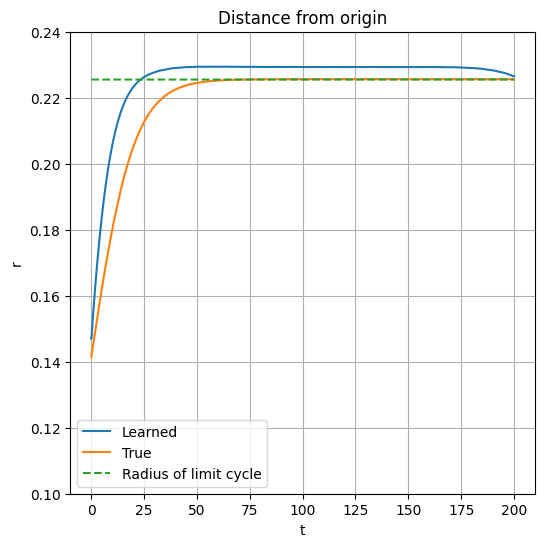

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(t_eval,v[:,0])
#plt.plot(t_eval,Z0[:,0])
plt.plot(t_eval,jnp.sqrt(x**2+y**2))
plt.plot(t_eval, jnp.sqrt(x**2+y**2)[2000]*jnp.ones(N),linestyle='--')
plt.title('Distance from origin')
plt.xlabel('t')
plt.ylabel('r')
plt.ylim(0.1, 0.24)
plt.grid()
plt.legend(["Learned","True","Radius of limit cycle"])
plt.show()

In [ ]:
jnp.abs(v[1900,0]-jnp.sqrt(x**2+y**2)[1900])

Array(0.00269018, dtype=float32)

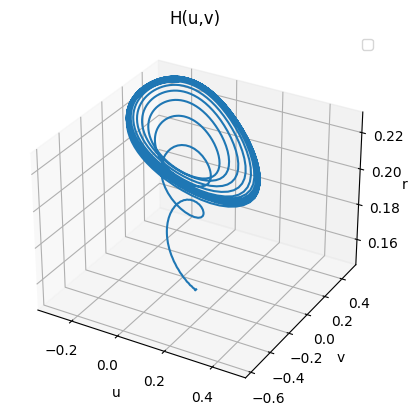

In [ ]:

ax = plt.figure().add_subplot(projection='3d')

# Prepare arrays x, y, z
z = v[:,0]
x_coord = phi
y_coord = psi

ax.plot(x_coord, y_coord, z)
ax.set_xlabel('u')
ax.set_ylabel('v')
ax.set_zlabel('r')
ax.set_title('H(u,v)')
ax.zaxis.labelpad=-0.7 # <- change the value here

ax.legend()

plt.show()

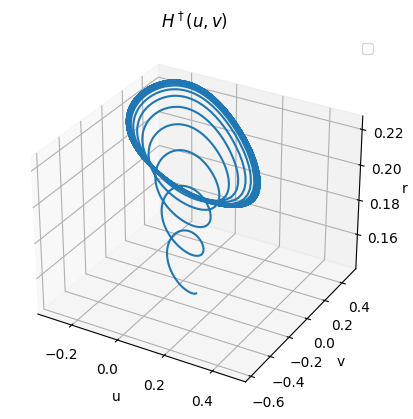

In [ ]:

ax = plt.figure().add_subplot(projection='3d')

# Prepare arrays x, y, z
z = jnp.sqrt(x**2+y**2)
x_coord = phi
y_coord = psi

ax.plot(x_coord, y_coord, z)
ax.set_xlabel('u')
ax.set_ylabel('v')
ax.set_zlabel('r')
ax.set_title(r'$H^\dagger (u,v)$')
ax.zaxis.labelpad=-0.7 # <- change the value here

ax.legend()

plt.show()

In [ ]:
v[:,0]

Array([0.14664921, 0.14661236, 0.1480325 , 0.14878409, 0.1498489 ,
       0.15047982, 0.15156847, 0.15220504, 0.15326525, 0.15388992,
       0.15492938, 0.15554461, 0.15656264, 0.1571681 , 0.15816517,
       0.15876092, 0.15973732, 0.16032341, 0.16127948, 0.16185589,
       0.16279203, 0.16335873, 0.16427527, 0.16483235, 0.16572961,
       0.16627713, 0.1671554 , 0.1676934 , 0.16855304, 0.16908163,
       0.16992293, 0.17044215, 0.17126545, 0.17177536, 0.172581  ,
       0.17308168, 0.17386995, 0.17436148, 0.17513268, 0.17561518,
       0.17636955, 0.17684306, 0.17758091, 0.17804551, 0.17876707,
       0.17922282, 0.17992838, 0.18037532, 0.18106517, 0.18150339,
       0.18217774, 0.18260731, 0.18326646, 0.18368746, 0.18433167,
       0.18474418, 0.18537372, 0.18577786, 0.18639302, 0.18678886,
       0.18738993, 0.18777762, 0.1883649 , 0.18874456, 0.18931824,
       0.18969008, 0.19025052, 0.19061457, 0.19116205, 0.19151843,
       0.19205318, 0.19240198, 0.1929242 , 0.19326551, 0.19377

In [ ]:
import sys
jnp.set_printoptions(threshold=sys.maxsize)
v[:,0]

Array([0.1470328 , 0.14701599, 0.14849192, 0.14926206, 0.15038216,
       0.15103178, 0.15217453, 0.15282972, 0.15394294, 0.1545862 ,
       0.15567753, 0.15631127, 0.15738007, 0.15800393, 0.15905067,
       0.1596647 , 0.16068973, 0.16129391, 0.16229755, 0.1628919 ,
       0.1638745 , 0.164459  , 0.16542093, 0.16599564, 0.1669372 ,
       0.16750216, 0.1684237 , 0.16897893, 0.16988078, 0.17042632,
       0.17130882, 0.17184477, 0.17270824, 0.17323464, 0.1740794 ,
       0.17459632, 0.17542273, 0.1759302 , 0.1767386 , 0.17723669,
       0.17802732, 0.17851608, 0.17928922, 0.17976874, 0.18052466,
       0.180995  , 0.18173398, 0.18219522, 0.18291749, 0.1833697 ,
       0.18407553, 0.18451881, 0.18520845, 0.18564288, 0.18631665,
       0.1867423 , 0.1874005 , 0.18781742, 0.18846036, 0.18886869,
       0.18949668, 0.18989651, 0.19050983, 0.19090132, 0.19150019,
       0.19188352, 0.19246832, 0.1928435 , 0.19341457, 0.19378175,
       0.19433925, 0.19469853, 0.19524273, 0.19559418, 0.19612

In [ ]:
jnp.max(jnp.sqrt(x**2+y**2))

Array(0.22564802, dtype=float32)

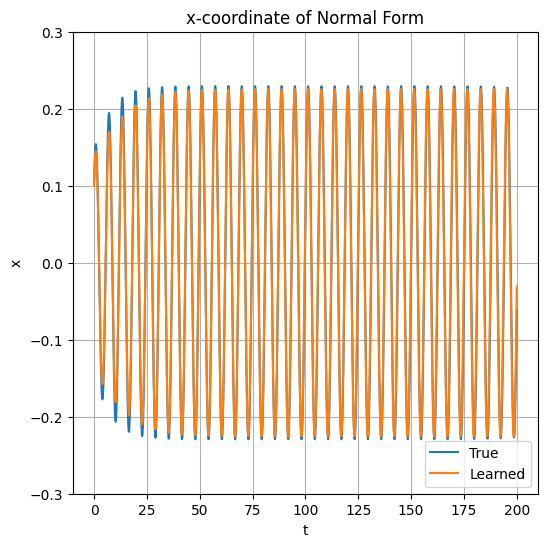

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(t_eval,v[:,0]*jnp.cos(t_eval-jnp.pi/4))
plt.plot(t_eval,x)
plt.title('x-coordinate of Normal Form')
plt.xlabel('t')
plt.ylabel('x')
plt.ylim(-0.3,0.3)
plt.grid()
plt.legend(['True','Learned'],loc='lower right')
plt.show()

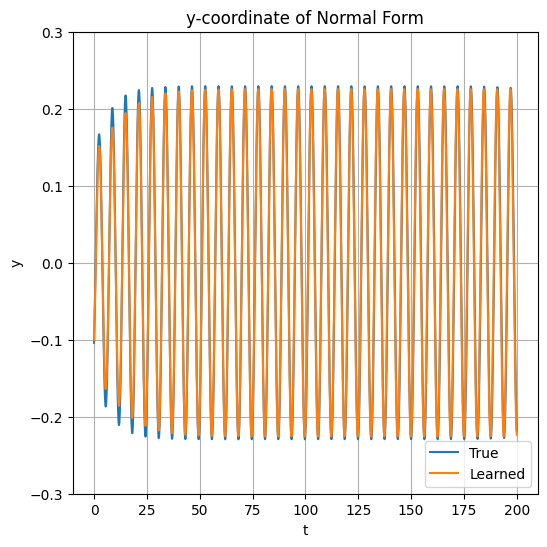

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(t_eval,v[:,0]*jnp.sin(t_eval-jnp.pi/4))
plt.plot(t_eval,y)
plt.title('y-coordinate of Normal Form')
plt.xlabel('t')
plt.ylabel('y')
plt.ylim(-0.3,0.3)
plt.legend(['True','Learned'],loc='lower right')
plt.grid()
plt.show()

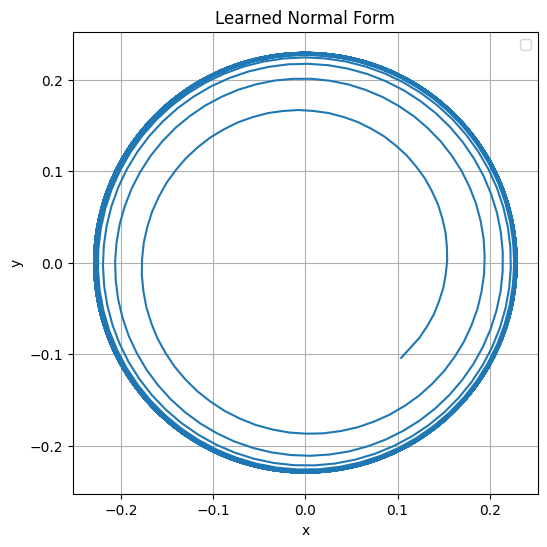

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(v[:,0]*jnp.cos(t_eval-jnp.pi/4),v[:,0]*jnp.sin(t_eval-jnp.pi/4))
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Learned Normal Form')
plt.legend(['True','Learned'],loc='lower right')
plt.show()

In [ ]:
v = jnp.zeros((N,1))
v = v.at[:,0].set(jnp.array([0.1470328 , 0.14701599, 0.14849192, 0.14926206, 0.15038216,
       0.15103178, 0.15217453, 0.15282972, 0.15394294, 0.1545862 ,
       0.15567753, 0.15631127, 0.15738007, 0.15800393, 0.15905067,
       0.1596647 , 0.16068973, 0.16129391, 0.16229755, 0.1628919 ,
       0.1638745 , 0.164459  , 0.16542093, 0.16599564, 0.1669372 ,
       0.16750216, 0.1684237 , 0.16897893, 0.16988078, 0.17042632,
       0.17130882, 0.17184477, 0.17270824, 0.17323464, 0.1740794 ,
       0.17459632, 0.17542273, 0.1759302 , 0.1767386 , 0.17723669,
       0.17802732, 0.17851608, 0.17928922, 0.17976874, 0.18052466,
       0.180995  , 0.18173398, 0.18219522, 0.18291749, 0.1833697 ,
       0.18407553, 0.18451881, 0.18520845, 0.18564288, 0.18631665,
       0.1867423 , 0.1874005 , 0.18781742, 0.18846036, 0.18886869,
       0.18949668, 0.18989651, 0.19050983, 0.19090132, 0.19150019,
       0.19188352, 0.19246832, 0.1928435 , 0.19341457, 0.19378175,
       0.19433925, 0.19469853, 0.19524273, 0.19559418, 0.1961253 ,
       0.196469  , 0.19698729, 0.1973233 , 0.19782896, 0.19815741,
       0.19865069, 0.19897166, 0.19945277, 0.19976634, 0.20023558,
       0.20054187, 0.20099942, 0.20129858, 0.20174472, 0.20203689,
       0.20247182, 0.20275712, 0.20318113, 0.20345972, 0.20387307,
       0.20414506, 0.20454799, 0.20481354, 0.2052063 , 0.20546553,
       0.20584832, 0.20610134, 0.20647442, 0.20672137, 0.20708492,
       0.20732588, 0.20768009, 0.20791514, 0.20826024, 0.20848948,
       0.20882562, 0.2090491 , 0.20937645, 0.2095943 , 0.20991303,
       0.21012533, 0.21043566, 0.21064252, 0.21094462, 0.21114615,
       0.21144022, 0.21163654, 0.21192281, 0.2121141 , 0.2123928 ,
       0.21257924, 0.2128506 , 0.2130323 , 0.21329652, 0.21347362,
       0.21373086, 0.21390344, 0.21415392, 0.21432209, 0.21456592,
       0.21472977, 0.21496713, 0.21512672, 0.21535763, 0.2155131 ,
       0.21573767, 0.21588904, 0.21610737, 0.21625471, 0.21646693,
       0.21661034, 0.2168166 , 0.21695617, 0.21715662, 0.21729243,
       0.21748725, 0.2176194 , 0.21780874, 0.21793737, 0.21812141,
       0.21824662, 0.21842553, 0.21854746, 0.2187214 , 0.21884017,
       0.2190093 , 0.21912499, 0.21928944, 0.21940216, 0.21956205,
       0.21967188, 0.21982735, 0.21993434, 0.2200855 , 0.22018972,
       0.22033665, 0.22043815, 0.2205809 , 0.22067977, 0.22081837,
       0.22091463, 0.22104913, 0.22114283, 0.22127332, 0.2213645 ,
       0.22149108, 0.2215798 , 0.2217026 , 0.22178896, 0.2219081 ,
       0.22199222, 0.22210789, 0.22218993, 0.22230229, 0.22238232,
       0.22249141, 0.22256939, 0.22267535, 0.22275116, 0.22285411,
       0.22292784, 0.22302791, 0.22309968, 0.22319704, 0.22326694,
       0.22336166, 0.2234297 , 0.22352177, 0.22358793, 0.22367737,
       0.22374165, 0.22382848, 0.22389092, 0.2239752 , 0.22403584,
       0.22411765, 0.22417656, 0.22425596, 0.22431318, 0.22439028,
       0.22444591, 0.22452082, 0.22457494, 0.22464778, 0.2247005 ,
       0.22477137, 0.22482276, 0.22489174, 0.22494186, 0.22500902,
       0.22505791, 0.22512332, 0.22517098, 0.22523466, 0.22528118,
       0.22534318, 0.22538859, 0.225449  , 0.22549336, 0.2255522 ,
       0.2255955 , 0.22565281, 0.22569503, 0.22575077, 0.22579187,
       0.22584604, 0.22588602, 0.22593863, 0.22597753, 0.22602865,
       0.22606649, 0.22611618, 0.22615305, 0.22620146, 0.22623752,
       0.22628479, 0.22632003, 0.22636598, 0.2264001 , 0.22644438,
       0.2264771 , 0.22651955, 0.22655085, 0.22659168, 0.22662185,
       0.22666141, 0.22669084, 0.22672948, 0.22675833, 0.22679608,
       0.22682431, 0.22686112, 0.22688867, 0.22692446, 0.22695132,
       0.22698614, 0.2270123 , 0.22704619, 0.22707169, 0.22710466,
       0.22712953, 0.22716163, 0.22718593, 0.22721726, 0.22724105,
       0.2272717 , 0.2272951 , 0.22732514, 0.2273482 , 0.22737765,
       0.22740036, 0.22742924, 0.22745156, 0.22747982, 0.22750174,
       0.22752936, 0.22755085, 0.22757788, 0.227599  , 0.2276255 ,
       0.22764634, 0.22767241, 0.22769305, 0.22771876, 0.2277392 ,
       0.2277645 , 0.2277847 , 0.22780952, 0.22782938, 0.2278537 ,
       0.22787324, 0.2278971 , 0.22791632, 0.22793972, 0.22795865,
       0.2279817 , 0.2280005 , 0.22802337, 0.22804204, 0.22806433,
       0.22808214, 0.22810295, 0.22811903, 0.22813782, 0.22815193,
       0.22816876, 0.22818126, 0.22819673, 0.22820841, 0.22822334,
       0.22823489, 0.22824971, 0.22826132, 0.22827604, 0.22828759,
       0.22830212, 0.22831355, 0.22832784, 0.22833917, 0.22835325,
       0.22836447, 0.22837834, 0.22838949, 0.22840317, 0.22841422,
       0.22842778, 0.22843885, 0.22845238, 0.22846355, 0.22847712,
       0.22848843, 0.22850206, 0.22851348, 0.22852708, 0.22853851,
       0.22855197, 0.2285633 , 0.2285765 , 0.22858763, 0.22860056,
       0.2286115 , 0.22862422, 0.22863507, 0.22864774, 0.22865866,
       0.22867143, 0.22868256, 0.22869551, 0.22870687, 0.22871993,
       0.22873141, 0.22874449, 0.22875603, 0.22876912, 0.22878075,
       0.2287939 , 0.2288056 , 0.2288188 , 0.22883065, 0.22884409,
       0.22885625, 0.22886969, 0.22888128, 0.22889334, 0.22890297,
       0.22891268, 0.22891992, 0.22892721, 0.22893211, 0.22893724,
       0.22894043, 0.22894439, 0.22894709, 0.228951  , 0.228954  ,
       0.22895825, 0.22896157, 0.22896606, 0.22896957, 0.2289742 ,
       0.22897786, 0.22898266, 0.22898652, 0.2289915 , 0.22899552,
       0.22900067, 0.22900486, 0.22901021, 0.2290146 , 0.22902021,
       0.22902493, 0.22903089, 0.22903602, 0.22904234, 0.22904782,
       0.22905442, 0.22906011, 0.22906682, 0.22907253, 0.22907914,
       0.2290847 , 0.22909111, 0.22909644, 0.22910264, 0.22910781,
       0.22911394, 0.22911914, 0.22912541, 0.2291309 , 0.22913752,
       0.22914346, 0.2291505 , 0.22915685, 0.22916423, 0.22917086,
       0.22917847, 0.22918537, 0.22919329, 0.2292005 , 0.2292087 ,
       0.22921617, 0.2292247 , 0.22923265, 0.22924165, 0.22924964,
       0.22925778, 0.22926396, 0.22926979, 0.22927375, 0.22927764,
       0.22927971, 0.22928144, 0.22928123, 0.22928081, 0.22927907,
       0.22927786, 0.22927608, 0.22927523, 0.22927397, 0.22927359,
       0.22927275, 0.22927268, 0.22927216, 0.22927238, 0.22927222,
       0.22927277, 0.22927298, 0.22927384, 0.22927438, 0.22927552,
       0.2292764 , 0.2292779 , 0.22927922, 0.22928114, 0.22928299,
       0.22928542, 0.22928777, 0.22929062, 0.22929335, 0.22929642,
       0.22929928, 0.22930232, 0.22930507, 0.22930789, 0.2293104 ,
       0.2293129 , 0.22931515, 0.22931741, 0.22931956, 0.22932181,
       0.22932413, 0.22932667, 0.22932944, 0.22933248, 0.2293358 ,
       0.22933935, 0.22934312, 0.22934702, 0.22935113, 0.2293554 ,
       0.22935992, 0.2293646 , 0.22936954, 0.22937454, 0.2293799 ,
       0.22938548, 0.22939137, 0.2293968 , 0.22940148, 0.22940479,
       0.22940724, 0.22940882, 0.22941001, 0.22941032, 0.22940974,
       0.22940786, 0.2294051 , 0.2294016 , 0.22939803, 0.22939445,
       0.22939128, 0.22938827, 0.22938567, 0.22938311, 0.22938092,
       0.2293787 , 0.2293769 , 0.22937508, 0.2293737 , 0.22937228,
       0.2293713 , 0.22937025, 0.22936963, 0.22936895, 0.22936873,
       0.22936852, 0.2293688 , 0.22936916, 0.22937   , 0.2293709 ,
       0.2293722 , 0.22937348, 0.22937503, 0.22937644, 0.22937796,
       0.2293792 , 0.22938046, 0.22938138, 0.22938226, 0.22938284,
       0.22938341, 0.22938378, 0.22938427, 0.22938475, 0.22938548,
       0.22938639, 0.22938763, 0.22938912, 0.2293909 , 0.2293929 ,
       0.22939509, 0.22939746, 0.22940004, 0.22940284, 0.2294059 ,
       0.22940911, 0.22941254, 0.22941618, 0.2294202 , 0.22942439,
       0.22942835, 0.2294313 , 0.22943309, 0.22943386, 0.22943434,
       0.2294346 , 0.2294346 , 0.22943366, 0.22943169, 0.22942849,
       0.22942466, 0.2294204 , 0.22941633, 0.22941239, 0.2294089 ,
       0.22940555, 0.22940256, 0.22939962, 0.229397  , 0.22939445,
       0.22939225, 0.22939013, 0.22938837, 0.22938666, 0.22938527,
       0.22938393, 0.22938293, 0.22938201, 0.22938146, 0.22938105,
       0.22938105, 0.22938125, 0.22938177, 0.22938247, 0.22938335,
       0.2293843 , 0.2293853 , 0.22938621, 0.22938702, 0.22938764,
       0.22938807, 0.22938827, 0.22938827, 0.2293881 , 0.22938782,
       0.2293875 , 0.22938722, 0.22938712, 0.2293872 , 0.2293876 ,
       0.22938824, 0.22938922, 0.22939037, 0.22939178, 0.22939332,
       0.22939509, 0.22939706, 0.22939931, 0.22940171, 0.22940432,
       0.22940713, 0.2294103 , 0.22941372, 0.22941694, 0.2294192 ,
       0.22942024, 0.22942035, 0.2294202 , 0.22942023, 0.22942021,
       0.22941965, 0.22941794, 0.22941515, 0.22941135, 0.22940727,
       0.22940302, 0.22939919, 0.22939545, 0.22939225, 0.22938901,
       0.22938623, 0.22938333, 0.22938095, 0.22937846, 0.22937651,
       0.22937445, 0.22937293, 0.22937125, 0.22937009, 0.22936876,
       0.22936803, 0.22936714, 0.22936691, 0.22936656, 0.22936693,
       0.2293671 , 0.22936796, 0.22936851, 0.22936964, 0.22937028,
       0.22937135, 0.22937179, 0.22937256, 0.22937256, 0.22937287,
       0.22937241, 0.2293723 , 0.22937146, 0.22937113, 0.22937025,
       0.22937006, 0.22936948, 0.22936973, 0.22936971, 0.22937053,
       0.22937106, 0.22937228, 0.22937319, 0.22937477, 0.22937611,
       0.22937812, 0.22937992, 0.2293823 , 0.22938448, 0.22938737,
       0.22939017, 0.22939323, 0.22939506, 0.22939596, 0.22939557,
       0.22939526, 0.22939502, 0.22939527, 0.229395  , 0.22939397,
       0.22939157, 0.22938831, 0.22938436, 0.22938044, 0.2293766 ,
       0.22937316, 0.22936991, 0.22936697, 0.22936416, 0.22936155,
       0.22935912, 0.2293569 , 0.2293549 , 0.22935309, 0.22935154,
       0.22935008, 0.22934891, 0.22934777, 0.22934702, 0.22934628,
       0.22934604, 0.22934581, 0.22934614, 0.22934644, 0.22934727,
       0.22934796, 0.22934905, 0.22934982, 0.22935088, 0.22935145,
       0.22935218, 0.22935228, 0.22935252, 0.22935212, 0.22935186,
       0.22935106, 0.2293505 , 0.22934958, 0.22934908, 0.2293484 ,
       0.2293483 , 0.22934817, 0.22934861, 0.22934902, 0.2293499 ,
       0.22935069, 0.2293519 , 0.2293531 , 0.22935475, 0.22935642,
       0.22935843, 0.22936046, 0.22936295, 0.22936559, 0.22936834,
       0.22937022, 0.22937092, 0.2293705 , 0.22936988, 0.22936964,
       0.22936995, 0.22937016, 0.22936963, 0.22936785, 0.229365  ,
       0.22936147, 0.22935773, 0.22935416, 0.22935082, 0.22934784,
       0.22934502, 0.22934248, 0.22933999, 0.2293378 , 0.2293357 ,
       0.22933392, 0.22933222, 0.22933088, 0.22932954, 0.22932856,
       0.22932756, 0.22932695, 0.22932635, 0.22932622, 0.22932613,
       0.22932655, 0.229327  , 0.2293279 , 0.22932874, 0.22932993,
       0.22933087, 0.22933203, 0.22933276, 0.2293336 , 0.22933386,
       0.22933418, 0.2293339 , 0.2293337 , 0.22933297, 0.2293324 ,
       0.2293315 , 0.22933093, 0.2293302 , 0.22933   , 0.22932976,
       0.22933012, 0.22933042, 0.22933123, 0.22933191, 0.22933304,
       0.2293341 , 0.22933567, 0.22933719, 0.22933914, 0.22934099,
       0.22934337, 0.22934581, 0.22934859, 0.22935048, 0.22935139,
       0.2293509 , 0.22935028, 0.22934984, 0.22935031, 0.22935072,
       0.22935076, 0.22934942, 0.22934712, 0.22934383, 0.22934042,
       0.2293369 , 0.22933382, 0.22933087, 0.22932829, 0.2293258 ,
       0.22932357, 0.22932144, 0.22931953, 0.22931783, 0.22931632,
       0.22931504, 0.22931391, 0.22931299, 0.22931218, 0.22931162,
       0.22931118, 0.22931108, 0.22931114, 0.22931157, 0.22931217,
       0.22931309, 0.2293141 , 0.22931531, 0.22931646, 0.22931765,
       0.2293186 , 0.22931948, 0.22931997, 0.22932035, 0.22932026,
       0.2293201 , 0.2293195 , 0.22931895, 0.22931811, 0.2293175 ,
       0.2293168 , 0.22931652, 0.22931626, 0.22931653, 0.2293168 ,
       0.22931755, 0.22931819, 0.22931927, 0.22932026, 0.22932178,
       0.2293232 , 0.22932513, 0.22932686, 0.2293292 , 0.22933148,
       0.22933432, 0.22933628, 0.22933748, 0.22933702, 0.22933649,
       0.22933581, 0.22933638, 0.22933684, 0.2293374 , 0.22933637,
       0.22933464, 0.22933148, 0.22932844, 0.22932486, 0.22932208,
       0.229319  , 0.22931677, 0.22931415, 0.22931229, 0.22930999,
       0.22930849, 0.22930656, 0.22930549, 0.22930396, 0.22930327,
       0.22930208, 0.22930174, 0.22930087, 0.22930092, 0.22930047,
       0.229301  , 0.22930108, 0.22930215, 0.22930273, 0.22930422,
       0.2293051 , 0.22930676, 0.22930764, 0.22930914, 0.22930971,
       0.22931078, 0.22931081, 0.22931132, 0.22931078, 0.22931075,
       0.2293098 , 0.22930947, 0.22930843, 0.22930816, 0.2293074 ,
       0.22930755, 0.22930732, 0.22930801, 0.22930828, 0.22930935,
       0.22930996, 0.22931136, 0.22931238, 0.22931422, 0.22931565,
       0.22931781, 0.22931962, 0.2293223 , 0.22932465, 0.22932725,
       0.22932822, 0.22932844, 0.22932741, 0.22932713, 0.2293271 ,
       0.22932813, 0.22932847, 0.2293283 , 0.22932647, 0.22932404,
       0.2293207 , 0.22931765, 0.22931446, 0.22931188, 0.22930926,
       0.22930713, 0.2293049 , 0.22930308, 0.2293012 , 0.22929974,
       0.2292983 , 0.2292972 , 0.22929616, 0.2292954 , 0.22929472,
       0.22929426, 0.22929396, 0.2292939 , 0.22929408, 0.22929451,
       0.22929525, 0.22929616, 0.22929738, 0.22929859, 0.22930002,
       0.22930124, 0.22930256, 0.22930348, 0.22930439, 0.22930479,
       0.22930513, 0.22930494, 0.22930475, 0.22930408, 0.22930357,
       0.22930273, 0.22930227, 0.22930166, 0.2293016 , 0.2293015 ,
       0.22930197, 0.22930236, 0.22930326, 0.22930399, 0.22930521,
       0.22930631, 0.22930798, 0.2293095 , 0.22931153, 0.22931336,
       0.22931588, 0.22931829, 0.22932091, 0.22932224, 0.2293226 ,
       0.22932173, 0.22932126, 0.22932118, 0.22932214, 0.22932273,
       0.22932284, 0.22932139, 0.22931917, 0.22931601, 0.22931299,
       0.22930983, 0.22930723, 0.22930464, 0.22930253, 0.22930034,
       0.22929855, 0.22929668, 0.22929525, 0.2292938 , 0.22929277,
       0.22929169, 0.22929102, 0.22929028, 0.22928993, 0.22928955,
       0.2292896 , 0.22928967, 0.22929023, 0.22929081, 0.2292919 ,
       0.22929293, 0.22929437, 0.22929561, 0.22929713, 0.22929825,
       0.22929953, 0.22930023, 0.22930102, 0.22930114, 0.22930136,
       0.2293009 , 0.22930065, 0.22929981, 0.22929938, 0.22929853,
       0.2292983 , 0.2292978 , 0.22929806, 0.22929808, 0.22929886,
       0.2292993 , 0.22930044, 0.2293012 , 0.2293027 , 0.2293039 ,
       0.22930583, 0.22930738, 0.22930963, 0.22931162, 0.22931446,
       0.22931671, 0.22931875, 0.22931892, 0.22931862, 0.2293176 ,
       0.2293178 , 0.22931823, 0.22931938, 0.22931933, 0.22931863,
       0.22931623, 0.22931364, 0.22931023, 0.22930749, 0.22930445,
       0.22930226, 0.22929972, 0.22929794, 0.22929575, 0.22929427,
       0.22929245, 0.22929135, 0.22928995, 0.22928922, 0.2292882 ,
       0.22928779, 0.22928712, 0.22928703, 0.22928676, 0.22928709,
       0.22928734, 0.22928818, 0.22928897, 0.22929025, 0.22929144,
       0.22929294, 0.22929426, 0.22929567, 0.22929677, 0.22929779,
       0.22929843, 0.22929886, 0.22929892, 0.22929877, 0.22929832,
       0.22929777, 0.22929709, 0.22929648, 0.22929595, 0.22929566,
       0.22929561, 0.22929583, 0.22929631, 0.22929698, 0.22929783,
       0.22929882, 0.2293    , 0.22930141, 0.22930305, 0.22930482,
       0.22930679, 0.22930895, 0.2293115 , 0.22931406, 0.22931609,
       0.22931679, 0.2293164 , 0.2293156 , 0.22931539, 0.22931597,
       0.22931693, 0.22931738, 0.22931673, 0.22931485, 0.22931212,
       0.22930905, 0.229306  , 0.22930323, 0.2293007 , 0.22929847,
       0.22929634, 0.2292945 , 0.22929266, 0.22929119, 0.22928971,
       0.22928867, 0.22928756, 0.22928691, 0.22928612, 0.2292858 ,
       0.22928533, 0.2292854 , 0.22928534, 0.22928591, 0.22928637,
       0.22928746, 0.2292884 , 0.22928989, 0.2292911 , 0.22929274,
       0.22929388, 0.22929534, 0.22929613, 0.22929713, 0.22929735,
       0.22929777, 0.22929741, 0.2292973 , 0.22929652, 0.22929612,
       0.22929525, 0.22929496, 0.22929437, 0.22929452, 0.22929446,
       0.22929513, 0.22929554, 0.22929658, 0.22929731, 0.2292987 ,
       0.22929983, 0.22930166, 0.2293032 , 0.22930534, 0.22930723,
       0.22930992, 0.22931233, 0.22931473, 0.22931556, 0.22931553,
       0.22931458, 0.22931434, 0.22931463, 0.22931573, 0.22931625,
       0.229316  , 0.22931428, 0.22931182, 0.22930871, 0.22930574,
       0.22930284, 0.22930036, 0.22929803, 0.22929597, 0.22929402,
       0.22929224, 0.22929066, 0.22928925, 0.22928809, 0.22928706,
       0.22928628, 0.22928557, 0.22928514, 0.22928473, 0.22928469,
       0.22928469, 0.22928512, 0.22928563, 0.2292866 , 0.22928758,
       0.229289  , 0.22929026, 0.22929186, 0.22929311, 0.22929455,
       0.22929546, 0.22929649, 0.22929685, 0.2292973 , 0.22929706,
       0.22929697, 0.22929627, 0.22929588, 0.22929503, 0.22929472,
       0.2292941 , 0.22929421, 0.22929409, 0.22929475, 0.2292951 ,
       0.22929616, 0.22929683, 0.22929825, 0.22929928, 0.22930115,
       0.22930259, 0.2293048 , 0.22930656, 0.22930929, 0.2293116 ,
       0.2293143 , 0.2293153 , 0.22931564, 0.2293146 , 0.22931439,
       0.22931437, 0.22931562, 0.22931615, 0.22931635, 0.22931473,
       0.22931266, 0.22930942, 0.22930668, 0.22930352, 0.22930124,
       0.22929865, 0.22929683, 0.22929461, 0.22929312, 0.22929123,
       0.22929011, 0.22928862, 0.22928791, 0.2292868 , 0.22928643,
       0.22928566, 0.22928561, 0.22928518, 0.22928554, 0.22928557,
       0.22928645, 0.22928698, 0.22928838, 0.22928935, 0.2292911 ,
       0.22929226, 0.22929403, 0.22929507, 0.22929655, 0.22929718,
       0.22929813, 0.22929819, 0.22929853, 0.22929806, 0.2292979 ,
       0.2292971 , 0.22929676, 0.22929598, 0.22929583, 0.22929546,
       0.2292958 , 0.22929597, 0.2292968 , 0.22929738, 0.22929855,
       0.22929946, 0.22930099, 0.22930233, 0.2293043 , 0.22930598,
       0.22930828, 0.22931042, 0.2293133 , 0.22931561, 0.22931747,
       0.22931758, 0.2293172 , 0.22931631, 0.22931653, 0.22931701,
       0.2293181 , 0.22931805, 0.2293173 , 0.2293149 , 0.22931223,
       0.22930886, 0.22930607, 0.22930309, 0.22930086, 0.22929838,
       0.22929654, 0.2292944 , 0.22929288, 0.22929111, 0.22929   ,
       0.22928862, 0.22928791, 0.22928688, 0.2292865 , 0.22928579,
       0.22928576, 0.22928545, 0.22928585, 0.22928604, 0.22928697,
       0.22928768, 0.22928907, 0.22929014, 0.22929174, 0.22929288,
       0.22929436, 0.22929525, 0.22929631, 0.22929668, 0.22929713,
       0.22929688, 0.22929671, 0.22929594, 0.22929534, 0.22929431,
       0.22929366, 0.2292928 , 0.22929245, 0.22929206, 0.22929224,
       0.22929238, 0.22929299, 0.22929348, 0.2292944 , 0.22929525,
       0.2292966 , 0.22929789, 0.22929959, 0.22930121, 0.22930332,
       0.22930552, 0.22930796, 0.2293095 , 0.22930996, 0.2293091 ,
       0.22930835, 0.22930813, 0.22930908, 0.22931008, 0.22931068,
       0.22930989, 0.22930813, 0.22930539, 0.22930253, 0.22929958,
       0.22929704, 0.22929464, 0.22929262, 0.22929063, 0.22928895,
       0.22928728, 0.22928596, 0.22928466, 0.22928375, 0.22928284,
       0.22928229, 0.22928171, 0.22928149, 0.22928123, 0.2292814 ,
       0.22928156, 0.22928222, 0.22928289, 0.22928408, 0.22928521,
       0.22928682, 0.22928819, 0.22928993, 0.22929125, 0.2292928 ,
       0.22929373, 0.22929484, 0.22929521, 0.22929575, 0.22929554,
       0.22929557, 0.22929494, 0.22929473, 0.22929403, 0.22929396,
       0.22929357, 0.22929396, 0.22929409, 0.229295  , 0.22929558,
       0.22929686, 0.22929776, 0.22929938, 0.2293007 , 0.22930275,
       0.22930446, 0.22930683, 0.22930892, 0.22931184, 0.22931439,
       0.22931693, 0.22931775, 0.2293179 , 0.22931696, 0.2293169 ,
       0.22931704, 0.22931819, 0.22931848, 0.22931837, 0.22931641,
       0.22931409, 0.22931072, 0.2293079 , 0.22930475, 0.22930244,
       0.22929983, 0.22929795, 0.2292957 , 0.22929414, 0.22929224,
       0.22929105, 0.22928958, 0.22928877, 0.22928768, 0.2292872 ,
       0.22928645, 0.2292863 , 0.22928591, 0.22928618, 0.22928627,
       0.22928706, 0.22928767, 0.22928895, 0.22928996, 0.22929154,
       0.22929269, 0.22929424, 0.22929518, 0.22929639, 0.22929685,
       0.22929749, 0.22929733, 0.22929735, 0.22929661, 0.22929616,
       0.22929509, 0.22929448, 0.22929347, 0.2292931 , 0.2292925 ,
       0.22929263, 0.22929257, 0.22929318, 0.22929351, 0.22929446,
       0.2292951 , 0.22929646, 0.22929753, 0.2292993 , 0.2293007 ,
       0.22930281, 0.2293047 , 0.22930737, 0.22930914, 0.22931042,
       0.22930978, 0.22930914, 0.22930828, 0.22930901, 0.22930974,
       0.22931089, 0.2293104 , 0.2293093 , 0.22930658, 0.22930399,
       0.22930066, 0.2292982 , 0.22929536, 0.22929345, 0.22929107,
       0.22928952, 0.22928745, 0.22928624, 0.22928454, 0.22928372,
       0.22928242, 0.22928198, 0.22928102, 0.22928089, 0.22928026,
       0.22928047, 0.22928026, 0.22928092, 0.22928123, 0.2292824 ,
       0.22928323, 0.22928481, 0.22928599, 0.22928774, 0.22928895,
       0.22929056, 0.22929148, 0.22929268, 0.22929308, 0.2292937 ,
       0.22929351, 0.2292936 , 0.22929296, 0.2292927 , 0.22929192,
       0.22929169, 0.22929116, 0.2292913 , 0.22929129, 0.22929195,
       0.22929244, 0.2292935 , 0.22929431, 0.2292957 , 0.2292969 ,
       0.22929871, 0.22930034, 0.22930248, 0.22930443, 0.22930704,
       0.22930957, 0.22931229, 0.22931372, 0.22931418, 0.2293134 ,
       0.22931291, 0.2293127 , 0.22931343, 0.22931388, 0.2293139 ,
       0.22931242, 0.22931008, 0.22930677, 0.22930354, 0.22930016,
       0.22929734, 0.2292945 , 0.22929217, 0.2292897 , 0.2292877 ,
       0.22928555, 0.22928391, 0.22928217, 0.22928093, 0.22927958,
       0.22927868, 0.22927766, 0.22927707, 0.22927639, 0.2292762 ,
       0.22927596, 0.22927625, 0.22927654, 0.22927734, 0.22927807,
       0.22927922, 0.22928016, 0.22928137, 0.22928217, 0.2292831 ,
       0.22928347, 0.22928385, 0.22928363, 0.22928338, 0.22928256,
       0.22928177, 0.22928055, 0.2292795 , 0.22927824, 0.22927734,
       0.22927642, 0.22927599, 0.22927558, 0.22927566, 0.22927569,
       0.2292761 , 0.22927645, 0.22927721, 0.22927797, 0.22927916,
       0.22928026, 0.22928177, 0.22928327, 0.22928536, 0.22928715,
       0.22928847, 0.22928819, 0.22928715, 0.22928573, 0.22928539,
       0.22928561, 0.2292863 , 0.22928602, 0.22928478, 0.22928216,
       0.229279  , 0.22927536, 0.22927202, 0.22926873, 0.22926593,
       0.22926313, 0.22926071, 0.22925824, 0.22925612, 0.22925399,
       0.22925223, 0.2292505 , 0.22924912, 0.22924773, 0.22924665,
       0.22924557, 0.2292448 , 0.2292441 , 0.22924374, 0.22924352,
       0.22924365, 0.22924395, 0.22924453, 0.22924519, 0.229246  ,
       0.22924675, 0.22924748, 0.229248  , 0.22924834, 0.22924837,
       0.22924815, 0.22924757, 0.22924677, 0.22924566, 0.22924444,
       0.22924308, 0.22924179, 0.22924055, 0.22923955, 0.22923876,
       0.22923826, 0.22923797, 0.22923788, 0.22923794, 0.22923814,
       0.22923854, 0.2292391 , 0.22923994, 0.22924085, 0.22924197,
       0.22924323, 0.2292449 , 0.22924656, 0.22924773, 0.22924754,
       0.2292463 , 0.22924441, 0.22924304, 0.22924219, 0.22924194,
       0.2292411 , 0.22923943, 0.22923627, 0.22923243, 0.22922789,
       0.22922358, 0.22921924, 0.22921544, 0.2292116 , 0.22920819,
       0.22920465, 0.22920154, 0.22919832, 0.22919554, 0.22919269,
       0.22919028, 0.22918777, 0.22918564, 0.22918342, 0.22918159,
       0.22917971, 0.22917825, 0.2291768 , 0.22917584, 0.22917488,
       0.22917433, 0.22917373, 0.22917344, 0.22917292, 0.22917253,
       0.22917177, 0.22917098, 0.22916967, 0.22916827, 0.2291663 ,
       0.22916424, 0.22916164, 0.22915907, 0.2291561 , 0.22915336,
       0.2291504 , 0.22914787, 0.22914529, 0.22914322, 0.2291411 ,
       0.22913945, 0.22913767, 0.22913627, 0.22913477, 0.22913373,
       0.22913261, 0.2291319 , 0.22913106, 0.22913064, 0.22913027,
       0.2291303 , 0.22912969, 0.22912814, 0.22912505, 0.2291216 ,
       0.22911836, 0.22911626, 0.22911449, 0.2291126 , 0.22910942,
       0.2291052 , 0.22909977, 0.22909404, 0.22908801, 0.22908238,
       0.22907677, 0.22907159, 0.22906637, 0.22906145, 0.22905649,
       0.22905183, 0.22904716, 0.22904281, 0.22903846, 0.22903441,
       0.22903033, 0.2290265 , 0.22902267, 0.2290191 , 0.22901562,
       0.22901243, 0.22900937, 0.22900663, 0.229004  , 0.22900158,
       0.22899917, 0.22899686, 0.22899437, 0.2289918 , 0.22898895,
       0.22898588, 0.22898239, 0.22897865, 0.2289745 , 0.22897013,
       0.22896545, 0.22896065, 0.22895573, 0.22895087, 0.2289461 ,
       0.22894154, 0.22893718, 0.22893304, 0.22892904, 0.22892518,
       0.22892141, 0.22891776, 0.22891426, 0.22891092, 0.22890772,
       0.22890459, 0.22890161, 0.22889885, 0.22889633, 0.2288935 ,
       0.22888967, 0.22888443, 0.22887835, 0.22887214, 0.22886656,
       0.22886144, 0.22885634, 0.22885026, 0.22884303, 0.2288345 ,
       0.22882536, 0.22881588, 0.2288066 , 0.22879742, 0.22878854,
       0.2287797 , 0.22877106, 0.22876239, 0.22875394, 0.22874548,
       0.2287373 , 0.22872911, 0.22872119, 0.22871318, 0.22870545,
       0.22869763, 0.2286901 , 0.22868252, 0.22867529, 0.22866806,
       0.22866121, 0.22865433, 0.22864774, 0.22864103, 0.22863448,
       0.22862764, 0.22862078, 0.2286135 , 0.22860606, 0.22859807,
       0.22858986, 0.22858109, 0.22857212, 0.22856264, 0.2285531 ,
       0.22854324, 0.22853349, 0.22852361, 0.22851403, 0.22850443,
       0.22849521, 0.22848593, 0.22847696, 0.22846782, 0.228459  ,
       0.22845003, 0.22844143, 0.2284327 , 0.22842428, 0.22841564,
       0.22840746, 0.22839919, 0.22839105, 0.22838172, 0.22837126,
       0.22835939, 0.22834775, 0.22833647, 0.22832629, 0.22831573,
       0.2283047 , 0.22829194, 0.22827837, 0.22826351, 0.2282488 ,
       0.22823362, 0.22821906, 0.22820419, 0.22818992, 0.22817521,
       0.22816102, 0.22814637, 0.22813231, 0.22811781, 0.22810392,
       0.22808957, 0.22807577, 0.22806151, 0.22804779, 0.2280336 ,
       0.22802001, 0.228006  , 0.22799267, 0.22797893, 0.22796586,
       0.22795232, 0.22793935, 0.22792579, 0.22791263, 0.22789875,
       0.22788511, 0.22787055, 0.22785617, 0.2278408 , 0.22782557,
       0.22780932, 0.22779332, 0.22777644, 0.22775993, 0.2277427 ,
       0.22772607, 0.22770889, 0.22769243, 0.2276755 , 0.22765927,
       0.22764248, 0.22762631, 0.22760953, 0.2275934 , 0.22757673,
       0.22756074, 0.22754414, 0.22752817, 0.22751163, 0.22749594,
       0.22747947, 0.22746292, 0.22744423, 0.22742495, 0.22740437,
       0.22738479, 0.22736503, 0.2273462 , 0.22732605, 0.22730538,
       0.22728261, 0.22725949, 0.22723511, 0.22721128, 0.22718684,
       0.22716323, 0.22713895, 0.22711542, 0.22709115, 0.22706759,
       0.22704333, 0.22701982, 0.22699559, 0.22697213, 0.22694793,
       0.22692445, 0.2269002 , 0.22687669, 0.22685246, 0.22682904,
       0.22680491, 0.22678165, 0.22675769, 0.22673453, 0.22671059,
       0.22668733, 0.22666314, 0.22663945, 0.22661468, 0.22659022,
       0.2265646 , 0.22653916, 0.22651257, 0.22648615, 0.22645856]))